In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import model_selection
from sklearn.metrics import accuracy_score
import mglearn 
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import numpy as np
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

# 데이터 EDA

### 데이터 불러오기

In [2]:
df = pd.read_csv('./data/final_dataset.csv', encoding='EUC-KR') # 각자 경로 따라 수정. 인코딩 필요없을수도있음

### 데이터 기초 정보 확인

In [3]:
df.shape  # 전체 900행으로 나타남

(14810, 16)

In [4]:
df.info() 
# 학점 ~ 봉사까지 전부 int나 float이 아닌 object인 것을 확인할 수 있음. 이는 점수 뒤에 붙은 조사 때문으로 보임
# 학점은 float, 나머지는 int로 변환할 필요가 있음

# 또한 전부 non-null이지만 900행이 아닌 열이 일부 관측됨. 기업분류, 지원분야, 전공 분야에 대한 구체적 확인이 필요함

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14810 entries, 0 to 14809
Data columns (total 16 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   기업명     14810 non-null  object
 1   지원분야    13779 non-null  object
 2   학교      14810 non-null  object
 3   전공      12563 non-null  object
 4   학점      14810 non-null  object
 5   토익      14810 non-null  object
 6   오픽      14810 non-null  object
 7   토스      14810 non-null  object
 8   자격증     14809 non-null  object
 9   연수      14810 non-null  object
 10  봉사      14810 non-null  object
 11  인턴      14810 non-null  object
 12  업종      14810 non-null  object
 13  업종분류    14810 non-null  int64 
 14  기업규모    14810 non-null  object
 15  규모분류    14810 non-null  int64 
dtypes: int64(2), object(14)
memory usage: 1.8+ MB


In [5]:
df.describe() # int 타입이 아닌 object 타입이라 제대로 값이 산출되지 않음

업종분류          규모분류
count  14810.000000  14810.000000
mean      10.605334      2.145037
std        5.317740      1.137411
min        1.000000      1.000000
25%        7.000000      1.000000
50%       11.000000      2.000000
75%       14.000000      3.000000
max       19.000000      4.000000

In [6]:
df.isnull().sum() # 빈 행 갯수만큼 각 열에서 null값이 관측됨. 해당 데이터 결측치에 대한 전처리가 필요할 것으로 판단됨.

기업명        0
지원분야    1031
학교         0
전공      2247
학점         0
토익         0
오픽         0
토스         0
자격증        1
연수         0
봉사         0
인턴         0
업종         0
업종분류       0
기업규모       0
규모분류       0
dtype: int64

In [7]:
null_rows_2 = df[df['학교']=='고졸']
null_rows_2

기업명     지원분야  학교   전공 학점 토익 오픽 토스 자격증 연수 봉사 인턴             업종  업종분류  \
9         아워홈      요리사  고졸  NaN  -  -  -  -  2개  -  -  -  음식료/호텔/리조트/여행    10   
16     21세기조선   생산직종사자  고졸  NaN  -  -  -  -  1개  -  -  -      자동차/기계/조선    12   
32      ADT캡스    회계담당자  고졸  NaN  -  -  -  -  4개  -  -  -       다업종기업/기타     3   
33      ADT캡스  설치·수리기사  고졸  NaN  -  -  -  -  1개  -  -  -       다업종기업/기타     3   
34      ADT캡스    시설관리자  고졸  NaN  -  -  -  -  2개  -  -  -       다업종기업/기타     3   
...       ...      ...  ..  ... .. .. .. ..  .. .. .. ..            ...   ...   
14761    흥아해운    회계담당자  고졸  NaN  -  -  -  -   -  -  -  -       상사/유통/운송     7   
14766    흥아해운    인사담당자  고졸  NaN  -  -  -  -  4개  -  -  -       상사/유통/운송     7   
14792    희성촉매   생산직종사자  고졸  NaN  -  -  -  -  3개  -  -  -      자동차/기계/조선    12   
14796    희성촉매   생산직종사자  고졸  NaN  -  -  -  -   -  -  -  -      자동차/기계/조선    12   
14797    희성촉매   생산직종사자  고졸  NaN  -  -  -  -  4개  -  -  -      자동차/기계/조선    12   

       기업규모  규모분류  
9      중견기업     2  
16     중소기업     4  
32     중소기업     4  
33     중소기업     4  
34     중소기업     4  
...     ...   ...  
14761  중견기업     2  
14766  중견기업     2  
14792  중견기업     2  
14796  중견기업     2  
14797  중견기업     2  

[743 rows x 16 columns]

### 데이터 타입 변경 및 기초 전처리

In [8]:
# 영어점수는 토익, 토익스피킹, 오픽중 하나만 따는 경향이 있음. 따라서 비어있는 경우가 많으므로 세 열을 하나로 합치는게 나을 것으로 보임
# 토익스피킹과 오픽 점수는 토익 점수로 환산이 가능함. 따라서 토익 점수 분류에 따라 토익스피킹과 오픽 점수를 변환함
eng = {'-' : 0, 'Lv1' : 100, 'Lv2' : 200, 'Lv3' : 300, 'Lv4' : 440, 'Lv5' : 600, 'Lv6' : 775, 'Lv7' : 915, 'Lv8' : 975,
       'Level 2' : 200, 'Level 4' : 440, 'Level 5' : 600, 'Level 6' : 775, 'Level 7' : 915, 'Level 8' : 975,
       'AL' : 975, 'AM' : 990, 'AH' : 990,
       'IL' : 440, 'IM': 570, 'IM1' : 570, 'IM2' : 745, 'IM3' : 845, '13' : 845, 'IH' : 915,
       'NL' : 100, 'NH' : 300, 'M1' : 570, 'M2' : 745}
df = df.replace(to_replace=eng)

In [9]:
df.head()
# 확인결과 정상적으로 변환된 것을 알 수 있음. 
#단, 일부 열이 아닌 전체 열에 변환과정을 진행한 것으로 타 행에서 '-'가 0으로 변환되었을 수 있음
# 따라서 추후 시각화 과정에서 다른 열, 특히 회사명~전공 등 str 열에 0값이 나타나는지 확인이 필요함
# 특히 결측치가 확인되었었던 전공, 기업분류, 지원분야 열을 주의깊게 확인

기업명       지원분야      학교       전공    학점    토익 오픽   토스 자격증  연수  봉사  인턴  \
0  아워홈       법인영업   지방4년제     중국어과   3.5     0  0    0   0  1회   0   0   
1  아워홈      재무담당자  수도권4년제    중어중문과  3.57  900점  0  975  4개  2회   0   0   
2  아워홈  바이오·제약연구원     대학원  화공생명공학과  4.19  800점  0  775  4개  1회   0  1회   
3  아워홈  바이오·제약연구원     대학원  화공생명공학과  4.19  800점  0  775  4개  1회   0  1회   
4  아워홈     온라인마케터  수도권4년제   문화경영학과  3.63  950점  0  775  1개  1회  3회  2회   

              업종  업종분류  기업규모  규모분류  
0  음식료/호텔/리조트/여행    10  중견기업     2  
1  음식료/호텔/리조트/여행    10  중견기업     2  
2  음식료/호텔/리조트/여행    10  중견기업     2  
3  음식료/호텔/리조트/여행    10  중견기업     2  
4  음식료/호텔/리조트/여행    10  중견기업     2

In [10]:
# 숫자형 데이터에서 '점', '개', '회' 등을 떼어내는 코드
df['토익'] = df['토익'].str.extract(r'(\d+)')
df['자격증'] = df['자격증'].str.extract(r'(\d+)')
df['연수'] = df['연수'].str.extract(r'(\d+)')
df['인턴'] = df['인턴'].str.extract(r'(\d+)')
df['봉사'] = df['봉사'].str.extract(r'(\d+)')
df = df.fillna(0)
df = df.astype({'학점' : 'float', '토익':'int32', '자격증':'int32', '연수':'int32', '인턴':'int32', '봉사':'int32'})

In [11]:
df.info() 
# 정상적으로 데이터 타입이 변경되었음을 확인할 수 있음. 
#단, 아까 우려한 대로 결측치가 사라짐. 해당 결측치들에 0값이 들어갔을것으로 추측됨

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14810 entries, 0 to 14809
Data columns (total 16 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   기업명     14810 non-null  object 
 1   지원분야    14810 non-null  object 
 2   학교      14810 non-null  object 
 3   전공      14810 non-null  object 
 4   학점      14810 non-null  float64
 5   토익      14810 non-null  int32  
 6   오픽      14810 non-null  object 
 7   토스      14810 non-null  object 
 8   자격증     14810 non-null  int32  
 9   연수      14810 non-null  int32  
 10  봉사      14810 non-null  int32  
 11  인턴      14810 non-null  int32  
 12  업종      14810 non-null  object 
 13  업종분류    14810 non-null  int64  
 14  기업규모    14810 non-null  object 
 15  규모분류    14810 non-null  int64  
dtypes: float64(1), int32(5), int64(2), object(8)
memory usage: 1.5+ MB


In [12]:
df.describe() 
# 외국어, 해외경험, 인턴, 봉사는 상위 75%값도 눈에띄게 낮으며, 특히 외국어의 경우 상위 75%도 0을 기록함
# 분석에 필수적인 자료가 아닐것으로 판단되므로 제외하는것이 나을것으로 판단됨

학점            토익           자격증            연수            봉사  \
count  14810.000000  14810.000000  14810.000000  14810.000000  14810.000000   
mean       3.367169    578.219514      1.447333      0.376165      0.560162   
std        1.101730    394.912070      1.674575      0.775032      1.174863   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        3.390000      0.000000      0.000000      0.000000      0.000000   
50%        3.670000    800.000000      1.000000      0.000000      0.000000   
75%        3.910000    880.000000      2.000000      1.000000      1.000000   
max        4.500000    990.000000     16.000000     14.000000     16.000000   

                 인턴          업종분류          규모분류  
count  14810.000000  14810.000000  14810.000000  
mean       0.328089     10.605334      2.145037  
std        0.938259      5.317740      1.137411  
min        0.000000      1.000000      1.000000  
25%        0.000000      7.000000      1.000000  
50%        0.000000     11.000000      2.000000  
75%        0.000000     14.000000      3.000000  
max       11.000000     19.000000      4.000000

In [13]:
#라벨인코딩하기 위해서 str형변환
#df = df.astype({'학교' : 'str' ,'전공' : 'str' })
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14810 entries, 0 to 14809
Data columns (total 16 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   기업명     14810 non-null  object 
 1   지원분야    14810 non-null  object 
 2   학교      14810 non-null  object 
 3   전공      14810 non-null  object 
 4   학점      14810 non-null  float64
 5   토익      14810 non-null  int32  
 6   오픽      14810 non-null  object 
 7   토스      14810 non-null  object 
 8   자격증     14810 non-null  int32  
 9   연수      14810 non-null  int32  
 10  봉사      14810 non-null  int32  
 11  인턴      14810 non-null  int32  
 12  업종      14810 non-null  object 
 13  업종분류    14810 non-null  int64  
 14  기업규모    14810 non-null  object 
 15  규모분류    14810 non-null  int64  
dtypes: float64(1), int32(5), int64(2), object(8)
memory usage: 1.5+ MB


In [14]:
# 범주형 데이터 라벨 인코딩
# 사용할 열만 라벨 인코딩을 진행함
# 본 분석에서 기업명, 지원분야, 전공은 필요없을것으로 판단되므로 라벨인코딩 해야하는 학교와 전공중 학교만 하면 됨

df=df.drop(['기업명','지원분야','전공'],axis=1)

In [15]:
# object 열 [회사명, 기업분류, 시기, 지원분야, 대학, 계열, 전공] 
# 회사명은 추구 기업 규모와 합쳐져 y값에 들어갈 내용이므로 제외, 기업분류도 분류코드와 내용이 중복되므로 제외
# 지원분야는 고려하지 않을것이므로 제외 , 시기도 시계열분석을 진행하지 않을것이므로 제외
# 따라서 대학, 계열, 전공만 숫자형 데이터로 인코딩을 진행함

#df = df[df.학교 != 0]
#lb = LabelEncoder()
#df['학교'] = lb.fit_transform(df['학교'])

# label 인코딩과 원핫 인코딩중 무얼 사용할지도 생각해보기
# 라벨인코딩의 경우 단순히 라벨링해서 숫자 1부터 쭈루룩 달아주는건데 모델에 따라서 숫자가 높을수록 관련이 높다고 해석될 여지도 있음!

In [16]:
university = {'고졸' : 0, '초대졸' : 1, '지방4년제' : 2, '수도권4년제' : 3, '서울4년제' : 4, '해외대학' : 5, '대학원' : 6}
df = df.replace(to_replace=university)

In [17]:
df.info() # 아까 전공계열에 있던 결측치 갯수만큼 전체 열의 행이 감소한 것을 확인해볼 수 있다.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14810 entries, 0 to 14809
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   학교      14810 non-null  int64  
 1   학점      14810 non-null  float64
 2   토익      14810 non-null  int32  
 3   오픽      14810 non-null  object 
 4   토스      14810 non-null  object 
 5   자격증     14810 non-null  int32  
 6   연수      14810 non-null  int32  
 7   봉사      14810 non-null  int32  
 8   인턴      14810 non-null  int32  
 9   업종      14810 non-null  object 
 10  업종분류    14810 non-null  int64  
 11  기업규모    14810 non-null  object 
 12  규모분류    14810 non-null  int64  
dtypes: float64(1), int32(5), int64(3), object(4)
memory usage: 1.2+ MB


In [18]:
df.head() # 대학, 계열, 전공이 성공적으로 인코딩된 것을 확인할 수 있다.

학교    학점   토익 오픽   토스  자격증  연수  봉사  인턴             업종  업종분류  기업규모  규모분류
0   2  3.50    0  0    0    0   1   0   0  음식료/호텔/리조트/여행    10  중견기업     2
1   3  3.57  900  0  975    4   2   0   0  음식료/호텔/리조트/여행    10  중견기업     2
2   6  4.19  800  0  775    4   1   0   1  음식료/호텔/리조트/여행    10  중견기업     2
3   6  4.19  800  0  775    4   1   0   1  음식료/호텔/리조트/여행    10  중견기업     2
4   3  3.63  950  0  775    1   1   3   2  음식료/호텔/리조트/여행    10  중견기업     2

In [19]:
university = {'중소기업' : 1, '중견기업' : 2, '공기업' : 3, '대기업' : 4}
df = df.replace(to_replace=university)

In [20]:
df=df.drop(['업종','업종분류','규모분류'],axis=1)

In [21]:
df.head()

학교    학점   토익 오픽   토스  자격증  연수  봉사  인턴  기업규모
0   2  3.50    0  0    0    0   1   0   0     2
1   3  3.57  900  0  975    4   2   0   0     2
2   6  4.19  800  0  775    4   1   0   1     2
3   6  4.19  800  0  775    4   1   0   1     2
4   3  3.63  950  0  775    1   1   3   2     2

In [22]:
# 이후 오류가 발생하지 않도록 칼럼명을 영어로 수정해주자. 시각화에서도 한글이면 깨진다.(별도 코딩으로 나오게할순 있음)
df.columns =['university', 'grade' ,'toeic','Opic','toeic_speaking','license','abroad','volunteer','intern', 'company_size']
df.head()

university  grade  toeic Opic toeic_speaking  license  abroad  volunteer  \
0           2   3.50      0    0              0        0       1          0   
1           3   3.57    900    0            975        4       2          0   
2           6   4.19    800    0            775        4       1          0   
3           6   4.19    800    0            775        4       1          0   
4           3   3.63    950    0            775        1       1          3   

   intern  company_size  
0       0             2  
1       0             2  
2       1             2  
3       1             2  
4       2             2

In [23]:
# 영어점수를 하나로 취합하여 보는게 나을 것 같다.
df['eng']=df.iloc[:,2:5].max(axis = 1, numeric_only = True)
df=df.drop(['toeic','toeic_speaking','Opic'],axis=1)
df

university  grade  license  abroad  volunteer  intern  company_size  \
0               2   3.50        0       1          0       0             2   
1               3   3.57        4       2          0       0             2   
2               6   4.19        4       1          0       1             2   
3               6   4.19        4       1          0       1             2   
4               3   3.63        1       1          3       2             2   
...           ...    ...      ...     ...        ...     ...           ...   
14805           1   3.50        0       0          0       0             1   
14806           4   3.31        0       1          0       0             1   
14807           1   3.62        0       0          0       0             1   
14808           1   3.60        2       0          0       0             1   
14809           1   3.20        0       1          0       0             1   

       eng  
0        0  
1      900  
2      800  
3      800  
4      950  
...    ...  
14805    0  
14806    0  
14807    0  
14808    0  
14809  825  

[14810 rows x 8 columns]

In [24]:
df = df[['university','grade', 'eng', 'license', 'abroad','volunteer', 'intern', 'company_size']]

### 시각화(히스토그램)

#### 시각화 1

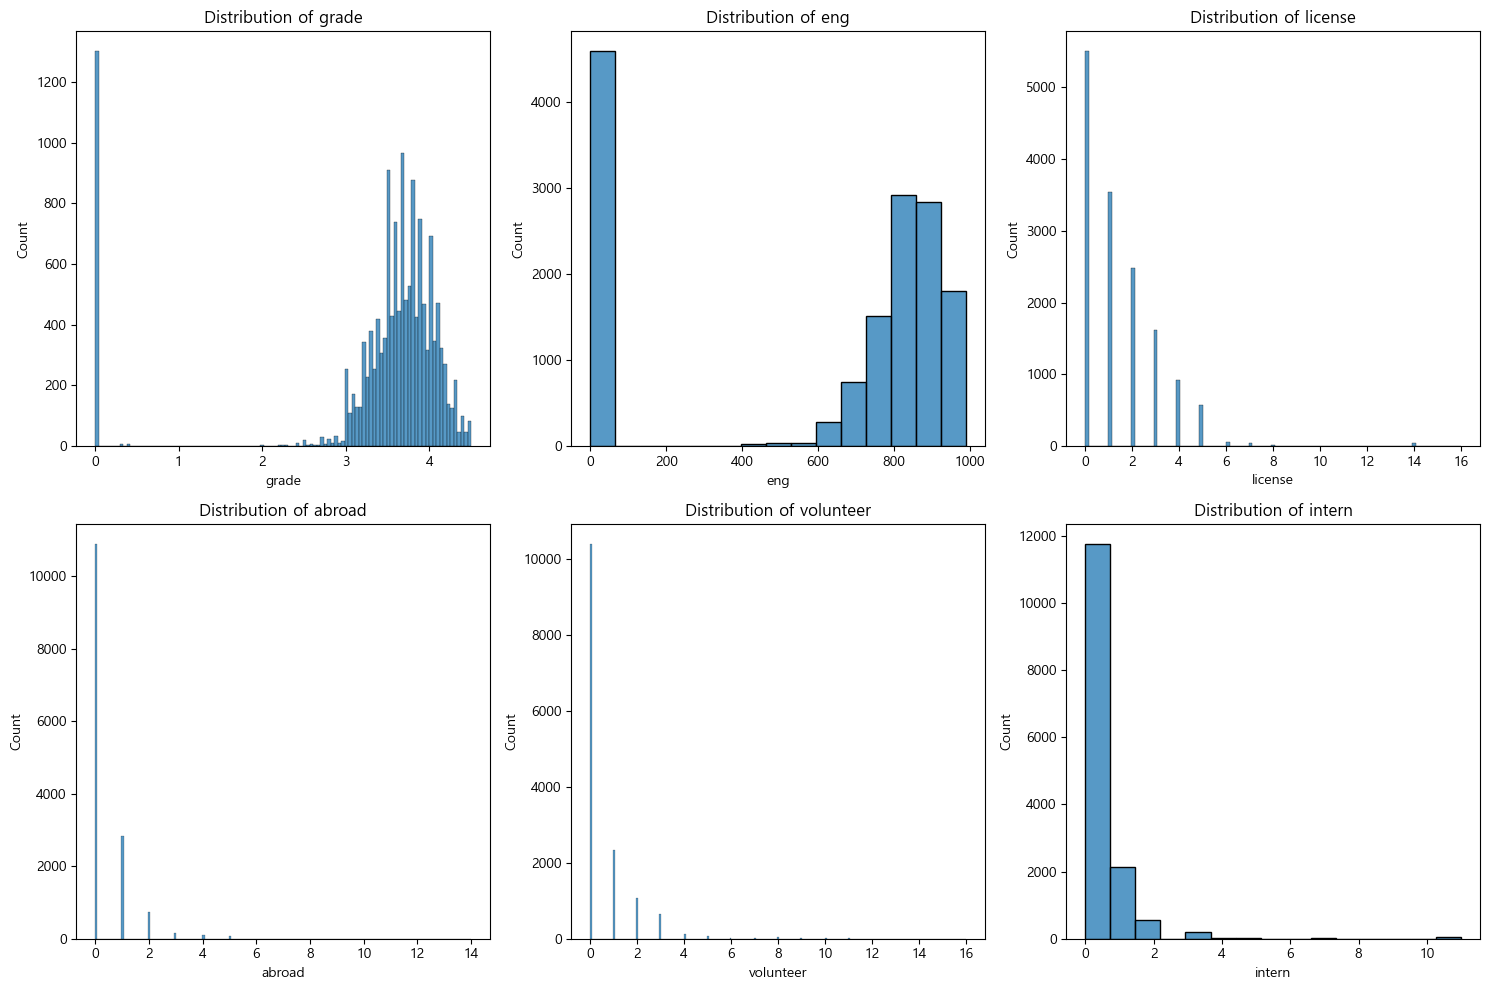

In [25]:
# 수치형 컬럼 분포
num_columns = ['grade', 'eng', 'license', 'abroad','volunteer', 'intern']

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, column in enumerate(num_columns):
    sns.histplot(df[column], ax=axes[i])
    axes[i].set_title(f'Distribution of {column}')
    
for j in range(i+1, len(axes)):
    axes[j].set_visible(False)
    
plt.tight_layout()
plt.show()
# 학점을 보면 0값이 많은 것은 알 수 있다. 학점을 입력하지 않은경우 (고졸이거나~)
# 또한 0이 아닌 0과 1사이 소수점 값인 경우도 있는데, 이는 처리해야할 아웃라이어로 판단된다.

# 그외 해외연수, 인턴쉽, 수상경력등은 거의 0~1 근처에 분포해있으며, 일부 10회 이상이 기록되나 이상치로 보기는 힘듬
# 만일 머신러닝결과 학습이 잘 진행되지 않는다고 판단될 경우 추가적으로 제거. 현재는 문제 없을것으로 보임

# 영어점수의 경우 취합을 했음에도 0점에 분포해 있는 경우가 많음
# 이는 영어점수를 요구하는 기업이 아닐경우 영어점수를 따로 입력하지 않아 발생하는 문제로 판단됨
# 따라서 영어점수 0점은 중앙값으로 대체하는 식으로 이상치를 처리하고자 함

array([[<Axes: title={'center': 'university'}>,
        <Axes: title={'center': 'grade'}>,
        <Axes: title={'center': 'eng'}>],
       [<Axes: title={'center': 'license'}>,
        <Axes: title={'center': 'abroad'}>,
        <Axes: title={'center': 'volunteer'}>],
       [<Axes: title={'center': 'intern'}>,
        <Axes: title={'center': 'company_size'}>, <Axes: >]], dtype=object)

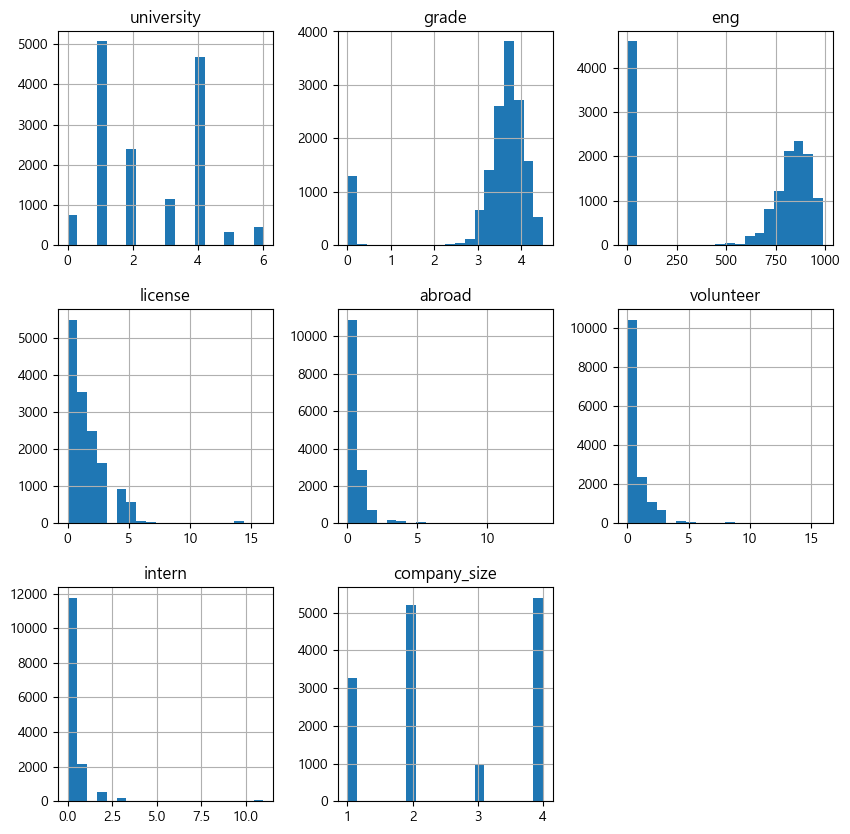

In [26]:
original_df = df
original_df.hist(bins=20, figsize=(10,10))

# 위 히스토그램 해석과 동일

#### 시각화 2 (박스 플롯)

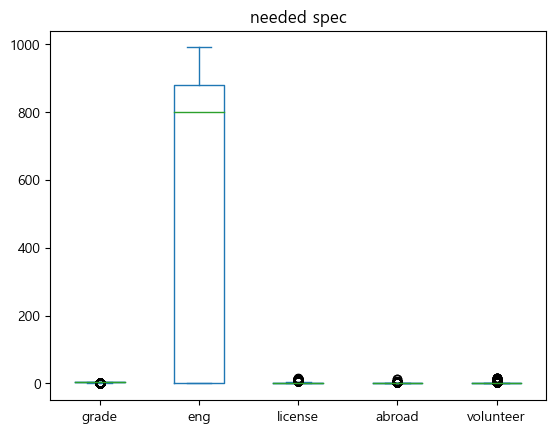

In [27]:
df.iloc[:,1:6].plot(kind = 'box');
plt.title ('needed spec')
plt.show();

# 박스플롯으로 출력한 결과 각각의 데이터 범주가 다르고
# 영어점수의 경우 특히 0~1000점 사이에 분포해 있기 때문에 식별을 위해선 minmaxscaler 등을 이용해 값 분포를 0~1사이에 일치시켜야 할 것으로 보임

# 단, 이때 labelencoder로 라벨링된 대학, 계열, 전공값은 정규화가 진행되지 않도록 주의!

In [28]:
#해당 작업을 하면 예측률이 더 떨어짐
'''
from sklearn.preprocessing import MinMaxScaler
mms =  MinMaxScaler()
df_scaled =  mms.fit_transform(df.iloc[:,1:7])
df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns =['grade' , 'eng','license','abroad','volunteer','intern']
df_scaled.plot(kind = 'box');
plt.title ('df_scaled')
plt.show();

df.iloc[:,2:8]=df_scaled.iloc[:,0:6]
'''

"\nfrom sklearn.preprocessing import MinMaxScaler\nmms =  MinMaxScaler()\ndf_scaled =  mms.fit_transform(df.iloc[:,1:7])\ndf_scaled = pd.DataFrame(df_scaled)\ndf_scaled.columns =['grade' , 'eng','license','abroad','volunteer','intern']\ndf_scaled.plot(kind = 'box');\nplt.title ('df_scaled')\nplt.show();\n\ndf.iloc[:,2:8]=df_scaled.iloc[:,0:6]\n"

In [29]:
#df.head(2)

#### 추가적인 데이터 EDA 진행

In [30]:
# 1. 학점 이상치 처리
df3= df[df.grade != 0]
while (df['grade'] < 2).any() or (df['grade'] >= 4.5).any():
    mask = (df['grade'] < 2) | (df['grade'] >= 4.5)
    df.loc[mask, 'grade'] = np.random.normal(df3['grade'].mean(), df3['grade'].std(), mask.sum())

In [31]:
# 2. 영어 이상치 처리
df3= df[df.eng != 0]
while (df['eng'] < 100).any() or (df['eng'] >= 990).any():
    mask = (df['eng'] < 100) | (df['eng'] >= 990)
    df.loc[mask, 'eng'] = np.random.normal(df3['eng'].mean(), df3['eng'].std(), mask.sum())

array([[<Axes: title={'center': 'university'}>,
        <Axes: title={'center': 'grade'}>,
        <Axes: title={'center': 'eng'}>],
       [<Axes: title={'center': 'license'}>,
        <Axes: title={'center': 'abroad'}>,
        <Axes: title={'center': 'volunteer'}>],
       [<Axes: title={'center': 'intern'}>,
        <Axes: title={'center': 'company_size'}>, <Axes: >]], dtype=object)

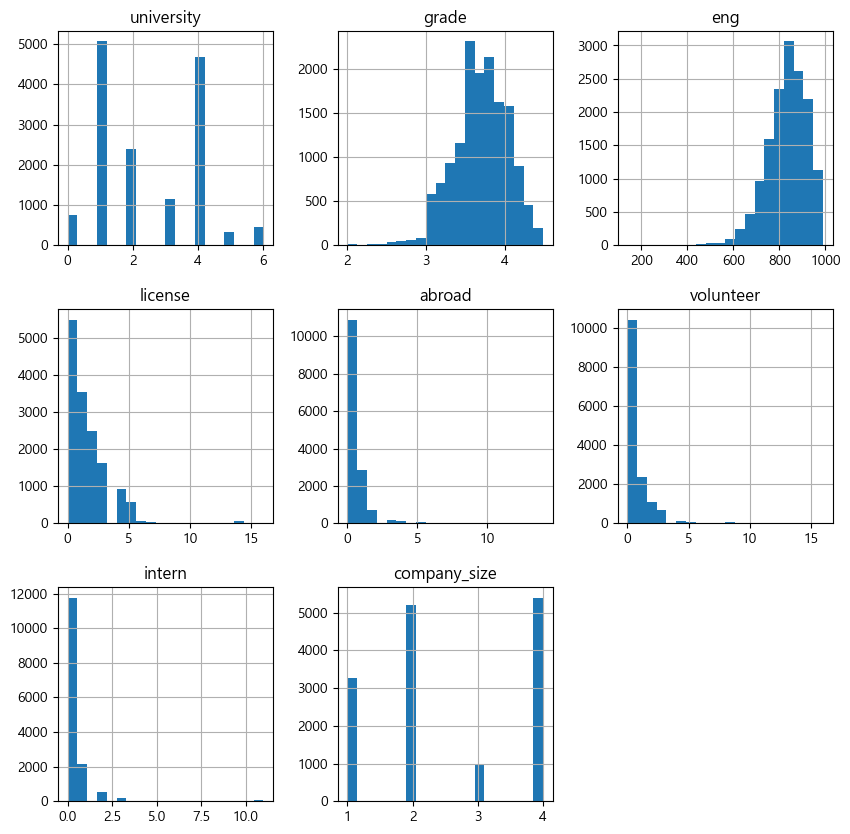

In [32]:
original_df = df
original_df.hist(bins=20, figsize=(10,10))

# 학점과 영어의 이상치가 성공적으로 사라진것을 확인할 수 있다.
# 단 영어점수를 하나로 통일할 때 토익스피킹과 오픽을 레벨에따라 특정값을 부여했더니
# 토익의 평탄화된 정규분포와 합쳐져 중간중간 삐죽삐죽 튀어나오는것을 확인할 수 있다.
# 분석해보고 값이 이상하다면 추가적인 평탄화 작업이 필요할 수 있다.

array([[<Axes: title={'center': 'university'}>,
        <Axes: title={'center': 'grade'}>,
        <Axes: title={'center': 'eng'}>],
       [<Axes: title={'center': 'license'}>,
        <Axes: title={'center': 'abroad'}>,
        <Axes: title={'center': 'volunteer'}>],
       [<Axes: title={'center': 'intern'}>,
        <Axes: title={'center': 'company_size'}>, <Axes: >]], dtype=object)

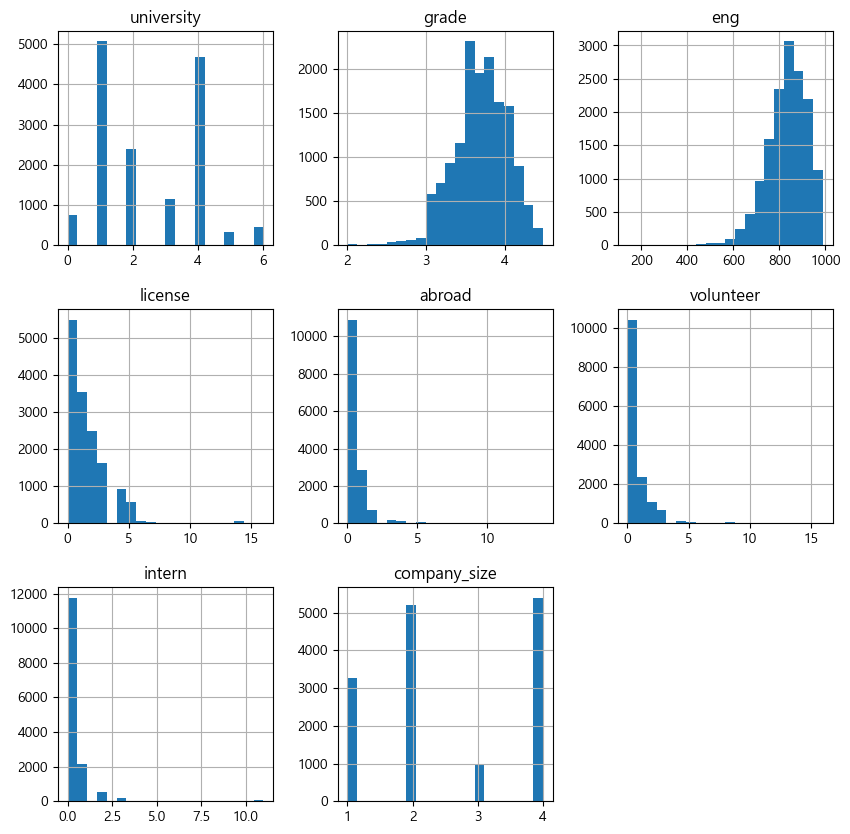

In [33]:
original_df = df
original_df.hist(bins=20, figsize=(10,10))

# 학점과 영어의 이상치가 성공적으로 사라진것을 확인할 수 있다.
# 단 영어점수를 하나로 통일할 때 토익스피킹과 오픽을 레벨에따라 특정값을 부여했더니
# 토익의 평탄화된 정규분포와 합쳐져 중간중간 삐죽삐죽 튀어나오는것을 확인할 수 있다.
# 분석해보고 값이 이상하다면 추가적인 평탄화 작업이 필요할 수 있다.

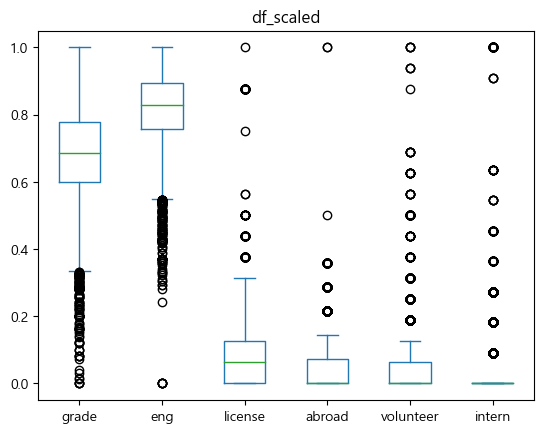

In [34]:
from sklearn.preprocessing import MinMaxScaler
mms =  MinMaxScaler()
df_scaled =  mms.fit_transform(df.iloc[:,1:7])
df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns =['grade' , 'eng','license','abroad','volunteer','intern']
df_scaled.plot(kind = 'box');
plt.title ('df_scaled')
plt.show();

In [35]:
df.iloc[:,1:7]=df_scaled.iloc[:,0:6]

In [36]:
df.head(2)

university     grade       eng  license    abroad  volunteer  intern  \
0           2  0.604517  0.816026     0.00  0.071429        0.0     0.0   
1           3  0.632728  0.894156     0.25  0.142857        0.0     0.0   

   company_size  
0             2  
1             2

#### 추가 EDA 진행 2 [15]ML 참고

In [37]:
def  std_exclude(df):
    columns  =  df [['grade' , 'eng','license','abroad','volunteer','intern']].columns     
    for col in columns:
        mean = df[col].mean();
        std  = df[col].std(); 
        b = np.abs(df[col]-mean) / std
        df = df[(b < 2 )]     
    return df 
df_scaled_fixed = std_exclude(df)


In [38]:
df_scaled_fixed

university     grade       eng  license    abroad  volunteer    intern  \
0               2  0.604517  0.816026   0.0000  0.071429     0.0000  0.000000   
2               6  0.882594  0.776504   0.2500  0.071429     0.0000  0.090909   
3               6  0.882594  0.776504   0.2500  0.071429     0.0000  0.090909   
6               4  0.604517  0.941216   0.0625  0.000000     0.0625  0.000000   
7               3  0.713330  0.652969   0.1250  0.000000     0.0000  0.000000   
...           ...       ...       ...      ...       ...        ...       ...   
14804           1  0.431222  0.708997   0.1875  0.000000     0.0625  0.000000   
14805           1  0.604517  0.941811   0.0000  0.000000     0.0000  0.000000   
14806           4  0.527945  0.767578   0.0000  0.071429     0.0000  0.000000   
14808           1  0.644818  0.712754   0.1250  0.000000     0.0000  0.000000   
14809           1  0.483613  0.805917   0.0000  0.071429     0.0000  0.000000   

       company_size  
0                 2  
2                 2  
3                 2  
6                 2  
7                 2  
...             ...  
14804             1  
14805             1  
14806             1  
14808             1  
14809             1  

[10923 rows x 8 columns]

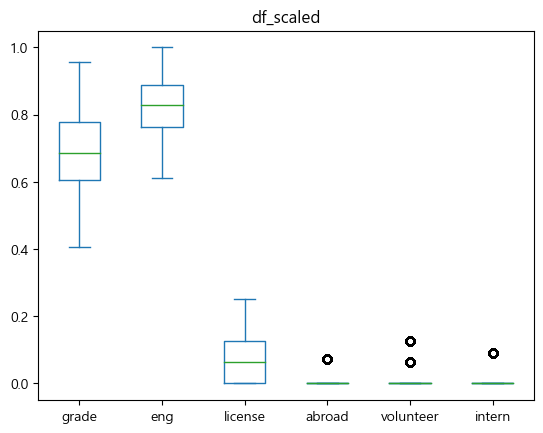

In [39]:
df_scaled_fixed.iloc[:,1:-1].plot(kind = 'box');
plt.title ('df_scaled')
plt.show();

#### 시각화 3 ([8]ML_로지스틱회귀 참고)

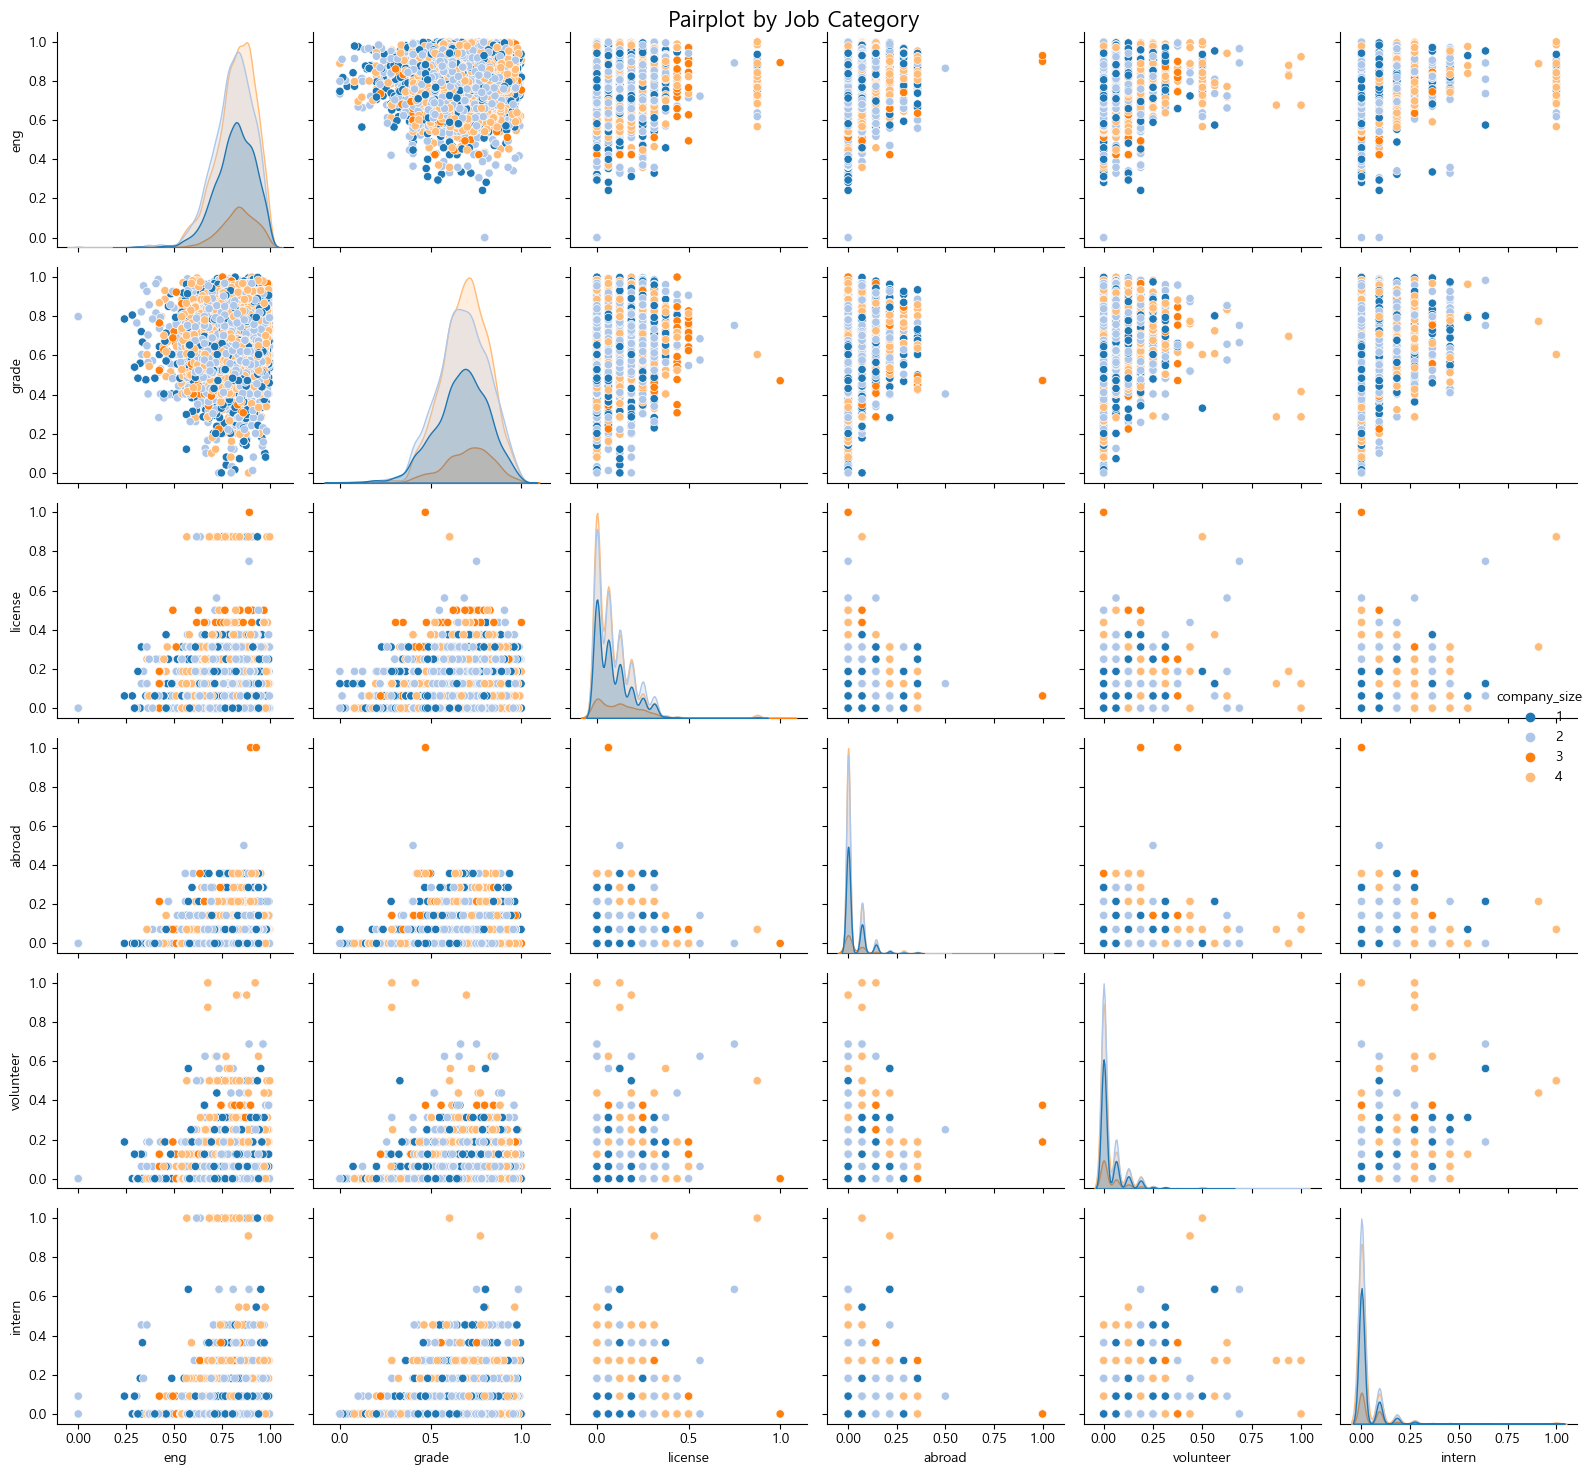

In [40]:
# pairplot 그래프 _ job에 따른 eng, grade, license 상관관계 
sns.pairplot(data=df, vars=['eng', 'grade', 'license','abroad', 'volunteer', 'intern'], hue='company_size', palette='tab20')

plt.suptitle('Pairplot by Job Category', verticalalignment='top', fontsize=16)
plt.tight_layout()
plt.show()

#### 시각화 4 상관관계 분석 (왜 해야하는지 파악하고 하셔야합니다!)

<Axes: >

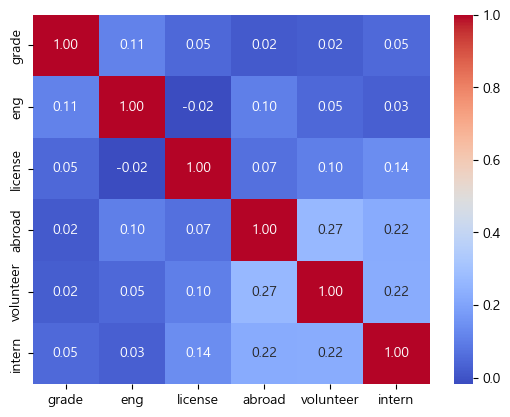

In [41]:
correlation_matrix = df_scaled_fixed.iloc[:,1:7].corr()

# Heatmap으로 상관 관계 시각화
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")

# 인턴과 봉사 상관관계가 있는것으로 나타나지만
# 대부분의 값이 0이었던 칼럼으로 그저 유사한 형태를 띄는것 판단됨

In [42]:
sampled_data = df_scaled_fixed.sample(frac=0.5, random_state=42 ,axis=0,replace=True)
df2 = pd.concat([df_scaled_fixed, sampled_data], ignore_index=True)

In [43]:
for i in range(50):
    sampled_data = df_scaled_fixed.sample(frac=0.5, random_state=42 ,axis=0,replace=True)
    df2 = pd.concat([df2, sampled_data], ignore_index=True)

array([[<Axes: title={'center': 'university'}>,
        <Axes: title={'center': 'grade'}>,
        <Axes: title={'center': 'eng'}>],
       [<Axes: title={'center': 'license'}>,
        <Axes: title={'center': 'abroad'}>,
        <Axes: title={'center': 'volunteer'}>],
       [<Axes: title={'center': 'intern'}>,
        <Axes: title={'center': 'company_size'}>, <Axes: >]], dtype=object)

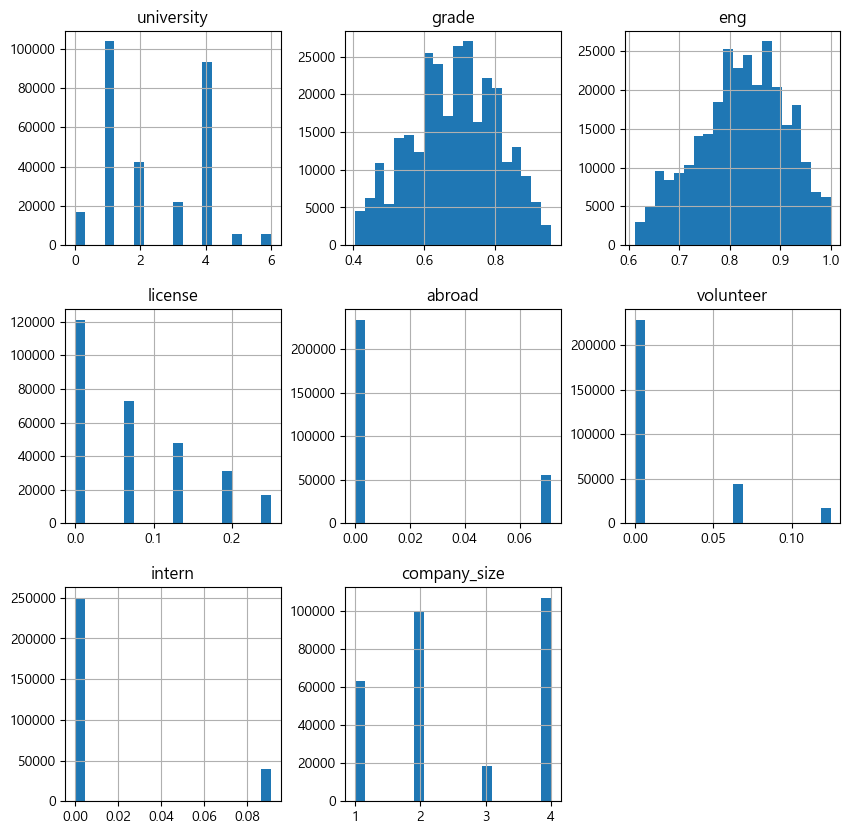

In [44]:
original_df = df2
original_df.hist(bins=20, figsize=(10,10))

In [45]:
df2.iloc[:,:-1]

university     grade       eng  license    abroad  volunteer    intern
0                2  0.604517  0.816026   0.0000  0.071429     0.0000  0.000000
1                6  0.882594  0.776504   0.2500  0.071429     0.0000  0.090909
2                6  0.882594  0.776504   0.2500  0.071429     0.0000  0.090909
3                4  0.604517  0.941216   0.0625  0.000000     0.0625  0.000000
4                3  0.713330  0.652969   0.1250  0.000000     0.0000  0.000000
...            ...       ...       ...      ...       ...        ...       ...
289480           1  0.721390  0.882390   0.0625  0.000000     0.0000  0.000000
289481           4  0.640788  0.809263   0.2500  0.000000     0.0000  0.000000
289482           1  0.717360  0.788269   0.0000  0.000000     0.0000  0.090909
289483           1  0.826173  0.688264   0.0000  0.000000     0.0000  0.000000
289484           5  0.864636  0.680470   0.0000  0.000000     0.0000  0.000000

[289485 rows x 7 columns]

In [46]:
df2.iloc[:,-1]

0         2
1         2
2         2
3         2
4         2
         ..
289480    4
289481    1
289482    2
289483    2
289484    1
Name: company_size, Length: 289485, dtype: int64

In [47]:
df

university     grade       eng  license    abroad  volunteer    intern  \
0               2  0.604517  0.816026   0.0000  0.071429     0.0000  0.000000   
1               3  0.632728  0.894156   0.2500  0.142857     0.0000  0.000000   
2               6  0.882594  0.776504   0.2500  0.071429     0.0000  0.090909   
3               6  0.882594  0.776504   0.2500  0.071429     0.0000  0.090909   
4               3  0.656908  0.952982   0.0625  0.071429     0.1875  0.181818   
...           ...       ...       ...      ...       ...        ...       ...   
14805           1  0.604517  0.941811   0.0000  0.000000     0.0000  0.000000   
14806           4  0.527945  0.767578   0.0000  0.071429     0.0000  0.000000   
14807           1  0.652878  0.581637   0.0000  0.000000     0.0000  0.000000   
14808           1  0.644818  0.712754   0.1250  0.000000     0.0000  0.000000   
14809           1  0.483613  0.805917   0.0000  0.071429     0.0000  0.000000   

       company_size  
0                 2  
1                 2  
2                 2  
3                 2  
4                 2  
...             ...  
14805             1  
14806             1  
14807             1  
14808             1  
14809             1  

[14810 rows x 8 columns]

## 머신러닝 실행

Logistic Regression(다항로짓)	이경연
Decision Tree 김지희
Random Forest 이상영
Gradient Boosting Tree (GBT) 노시은
K-Nearest Neighbor (K-NN) 박용빈
Catboost 김태언

In [48]:
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import RandomizedSearchCV

from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
# step 2. 학습 데이터와 검증 데이터로 분리

#X = df[['university','major','grade','eng', 'license','abroad', 'volunteer', 'intern','sector_code']]
#y = df[['size_code']] 
X,y = df2.iloc[:,:-1], df2.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

scores = {}

ctb_clf = CatBoostClassifier(task_type='GPU') 
#ctb_clf = CatBoostClassifier(thread_count=4)
ctb_clf.fit(X_train, y_train)

# 모든 파라미터 확인
all_params = ctb_clf.get_all_params()


results = model_selection.cross_val_score(ctb_clf, X_test, y_test, cv = 5)
scores[('8.CatBoost', 'train_score')] = results.mean()
scores[('8.CatBoost', 'test_score')] = ctb_clf.score(X_test, y_test)

pd.Series(scores).unstack()


Learning rate set to 0.194521
0:	learn: 1.3286673	total: 175ms	remaining: 2m 54s
1:	learn: 1.2893826	total: 194ms	remaining: 1m 36s
2:	learn: 1.2566666	total: 219ms	remaining: 1m 12s
3:	learn: 1.2344098	total: 238ms	remaining: 59.2s
4:	learn: 1.2180002	total: 258ms	remaining: 51.3s
5:	learn: 1.2017907	total: 274ms	remaining: 45.4s
6:	learn: 1.1904730	total: 290ms	remaining: 41.1s
7:	learn: 1.1806628	total: 306ms	remaining: 38s
8:	learn: 1.1705407	total: 325ms	remaining: 35.8s
9:	learn: 1.1626003	total: 341ms	remaining: 33.8s
10:	learn: 1.1540456	total: 359ms	remaining: 32.2s
11:	learn: 1.1485871	total: 376ms	remaining: 30.9s
12:	learn: 1.1443098	total: 391ms	remaining: 29.7s
13:	learn: 1.1385213	total: 407ms	remaining: 28.7s
14:	learn: 1.1336379	total: 423ms	remaining: 27.8s
15:	learn: 1.1293488	total: 439ms	remaining: 27s
16:	learn: 1.1243548	total: 455ms	remaining: 26.3s
17:	learn: 1.1200225	total: 472ms	remaining: 25.7s
18:	learn: 1.1164949	total: 490ms	remaining: 25.3s
19:	learn: 1

166:	learn: 0.8042082	total: 2.92s	remaining: 14.6s
167:	learn: 0.8035263	total: 2.94s	remaining: 14.6s
168:	learn: 0.8021875	total: 2.95s	remaining: 14.5s
169:	learn: 0.8010962	total: 2.97s	remaining: 14.5s
170:	learn: 0.7993161	total: 2.98s	remaining: 14.5s
171:	learn: 0.7976138	total: 3s	remaining: 14.4s
172:	learn: 0.7962074	total: 3.02s	remaining: 14.4s
173:	learn: 0.7956416	total: 3.04s	remaining: 14.4s
174:	learn: 0.7946487	total: 3.05s	remaining: 14.4s
175:	learn: 0.7928810	total: 3.07s	remaining: 14.4s
176:	learn: 0.7921212	total: 3.08s	remaining: 14.3s
177:	learn: 0.7916290	total: 3.1s	remaining: 14.3s
178:	learn: 0.7902879	total: 3.11s	remaining: 14.3s
179:	learn: 0.7889542	total: 3.13s	remaining: 14.2s
180:	learn: 0.7874728	total: 3.14s	remaining: 14.2s
181:	learn: 0.7851594	total: 3.16s	remaining: 14.2s
182:	learn: 0.7840115	total: 3.18s	remaining: 14.2s
183:	learn: 0.7826884	total: 3.19s	remaining: 14.2s
184:	learn: 0.7818924	total: 3.21s	remaining: 14.1s
185:	learn: 0.78

327:	learn: 0.6322484	total: 5.51s	remaining: 11.3s
328:	learn: 0.6314347	total: 5.53s	remaining: 11.3s
329:	learn: 0.6308995	total: 5.55s	remaining: 11.3s
330:	learn: 0.6302588	total: 5.56s	remaining: 11.2s
331:	learn: 0.6292887	total: 5.58s	remaining: 11.2s
332:	learn: 0.6287483	total: 5.59s	remaining: 11.2s
333:	learn: 0.6282271	total: 5.61s	remaining: 11.2s
334:	learn: 0.6268042	total: 5.62s	remaining: 11.2s
335:	learn: 0.6260173	total: 5.64s	remaining: 11.1s
336:	learn: 0.6247076	total: 5.65s	remaining: 11.1s
337:	learn: 0.6240797	total: 5.67s	remaining: 11.1s
338:	learn: 0.6234658	total: 5.68s	remaining: 11.1s
339:	learn: 0.6231057	total: 5.7s	remaining: 11.1s
340:	learn: 0.6221726	total: 5.71s	remaining: 11s
341:	learn: 0.6210361	total: 5.73s	remaining: 11s
342:	learn: 0.6204517	total: 5.75s	remaining: 11s
343:	learn: 0.6194174	total: 5.76s	remaining: 11s
344:	learn: 0.6183755	total: 5.78s	remaining: 11s
345:	learn: 0.6169507	total: 5.8s	remaining: 11s
346:	learn: 0.6159419	tota

495:	learn: 0.5171260	total: 8.08s	remaining: 8.21s
496:	learn: 0.5165610	total: 8.09s	remaining: 8.19s
497:	learn: 0.5159516	total: 8.11s	remaining: 8.17s
498:	learn: 0.5154039	total: 8.12s	remaining: 8.15s
499:	learn: 0.5150012	total: 8.13s	remaining: 8.13s
500:	learn: 0.5141348	total: 8.15s	remaining: 8.12s
501:	learn: 0.5138156	total: 8.16s	remaining: 8.1s
502:	learn: 0.5131798	total: 8.18s	remaining: 8.08s
503:	learn: 0.5125759	total: 8.19s	remaining: 8.06s
504:	learn: 0.5118803	total: 8.21s	remaining: 8.04s
505:	learn: 0.5109679	total: 8.23s	remaining: 8.03s
506:	learn: 0.5106859	total: 8.24s	remaining: 8.01s
507:	learn: 0.5101224	total: 8.26s	remaining: 8s
508:	learn: 0.5095395	total: 8.27s	remaining: 7.98s
509:	learn: 0.5090966	total: 8.29s	remaining: 7.96s
510:	learn: 0.5083615	total: 8.3s	remaining: 7.94s
511:	learn: 0.5077831	total: 8.31s	remaining: 7.92s
512:	learn: 0.5067574	total: 8.33s	remaining: 7.91s
513:	learn: 0.5060673	total: 8.34s	remaining: 7.89s
514:	learn: 0.505

655:	learn: 0.4412036	total: 10.6s	remaining: 5.56s
656:	learn: 0.4408386	total: 10.6s	remaining: 5.55s
657:	learn: 0.4404820	total: 10.6s	remaining: 5.53s
658:	learn: 0.4398421	total: 10.7s	remaining: 5.51s
659:	learn: 0.4395211	total: 10.7s	remaining: 5.5s
660:	learn: 0.4391228	total: 10.7s	remaining: 5.48s
661:	learn: 0.4385111	total: 10.7s	remaining: 5.47s
662:	learn: 0.4382998	total: 10.7s	remaining: 5.45s
663:	learn: 0.4378532	total: 10.7s	remaining: 5.43s
664:	learn: 0.4376765	total: 10.8s	remaining: 5.42s
665:	learn: 0.4375084	total: 10.8s	remaining: 5.4s
666:	learn: 0.4372596	total: 10.8s	remaining: 5.38s
667:	learn: 0.4368682	total: 10.8s	remaining: 5.37s
668:	learn: 0.4363449	total: 10.8s	remaining: 5.35s
669:	learn: 0.4362425	total: 10.8s	remaining: 5.34s
670:	learn: 0.4358116	total: 10.8s	remaining: 5.32s
671:	learn: 0.4354239	total: 10.9s	remaining: 5.3s
672:	learn: 0.4348831	total: 10.9s	remaining: 5.29s
673:	learn: 0.4345502	total: 10.9s	remaining: 5.27s
674:	learn: 0.4

815:	learn: 0.3857845	total: 13.2s	remaining: 2.97s
816:	learn: 0.3855292	total: 13.2s	remaining: 2.96s
817:	learn: 0.3853395	total: 13.2s	remaining: 2.94s
818:	learn: 0.3846799	total: 13.2s	remaining: 2.93s
819:	learn: 0.3843876	total: 13.3s	remaining: 2.91s
820:	learn: 0.3839620	total: 13.3s	remaining: 2.89s
821:	learn: 0.3837204	total: 13.3s	remaining: 2.88s
822:	learn: 0.3835729	total: 13.3s	remaining: 2.86s
823:	learn: 0.3833741	total: 13.3s	remaining: 2.85s
824:	learn: 0.3831123	total: 13.3s	remaining: 2.83s
825:	learn: 0.3828723	total: 13.4s	remaining: 2.81s
826:	learn: 0.3827658	total: 13.4s	remaining: 2.8s
827:	learn: 0.3826021	total: 13.4s	remaining: 2.78s
828:	learn: 0.3823982	total: 13.4s	remaining: 2.76s
829:	learn: 0.3821224	total: 13.4s	remaining: 2.75s
830:	learn: 0.3816113	total: 13.4s	remaining: 2.73s
831:	learn: 0.3813418	total: 13.5s	remaining: 2.72s
832:	learn: 0.3809461	total: 13.5s	remaining: 2.7s
833:	learn: 0.3805966	total: 13.5s	remaining: 2.68s
834:	learn: 0.

985:	learn: 0.3397248	total: 16s	remaining: 226ms
986:	learn: 0.3394544	total: 16s	remaining: 210ms
987:	learn: 0.3392439	total: 16s	remaining: 194ms
988:	learn: 0.3390203	total: 16s	remaining: 178ms
989:	learn: 0.3387063	total: 16s	remaining: 162ms
990:	learn: 0.3384377	total: 16s	remaining: 146ms
991:	learn: 0.3382660	total: 16.1s	remaining: 130ms
992:	learn: 0.3380419	total: 16.1s	remaining: 113ms
993:	learn: 0.3377763	total: 16.1s	remaining: 97.2ms
994:	learn: 0.3375348	total: 16.1s	remaining: 81ms
995:	learn: 0.3372969	total: 16.1s	remaining: 64.8ms
996:	learn: 0.3369786	total: 16.2s	remaining: 48.6ms
997:	learn: 0.3368183	total: 16.2s	remaining: 32.4ms
998:	learn: 0.3365480	total: 16.2s	remaining: 16.2ms
999:	learn: 0.3363286	total: 16.2s	remaining: 0us
Learning rate set to 0.148548
0:	learn: 1.3413380	total: 16.1ms	remaining: 16.1s
1:	learn: 1.3072210	total: 30.5ms	remaining: 15.2s
2:	learn: 1.2788839	total: 42.8ms	remaining: 14.2s
3:	learn: 1.2566241	total: 54.7ms	remaining: 13

148:	learn: 0.8972918	total: 1.7s	remaining: 9.71s
149:	learn: 0.8954639	total: 1.71s	remaining: 9.69s
150:	learn: 0.8946058	total: 1.72s	remaining: 9.67s
151:	learn: 0.8935220	total: 1.73s	remaining: 9.65s
152:	learn: 0.8926904	total: 1.74s	remaining: 9.62s
153:	learn: 0.8904643	total: 1.75s	remaining: 9.6s
154:	learn: 0.8895420	total: 1.76s	remaining: 9.59s
155:	learn: 0.8883485	total: 1.77s	remaining: 9.56s
156:	learn: 0.8870446	total: 1.78s	remaining: 9.54s
157:	learn: 0.8855579	total: 1.78s	remaining: 9.51s
158:	learn: 0.8841108	total: 1.79s	remaining: 9.49s
159:	learn: 0.8830899	total: 1.8s	remaining: 9.48s
160:	learn: 0.8822145	total: 1.81s	remaining: 9.46s
161:	learn: 0.8814759	total: 1.82s	remaining: 9.44s
162:	learn: 0.8808766	total: 1.83s	remaining: 9.43s
163:	learn: 0.8795370	total: 1.84s	remaining: 9.41s
164:	learn: 0.8786815	total: 1.85s	remaining: 9.39s
165:	learn: 0.8779816	total: 1.86s	remaining: 9.37s
166:	learn: 0.8770293	total: 1.87s	remaining: 9.35s
167:	learn: 0.8

319:	learn: 0.7242791	total: 3.62s	remaining: 7.7s
320:	learn: 0.7237160	total: 3.63s	remaining: 7.69s
321:	learn: 0.7228562	total: 3.65s	remaining: 7.67s
322:	learn: 0.7223539	total: 3.65s	remaining: 7.66s
323:	learn: 0.7216050	total: 3.67s	remaining: 7.65s
324:	learn: 0.7210796	total: 3.68s	remaining: 7.64s
325:	learn: 0.7204431	total: 3.69s	remaining: 7.62s
326:	learn: 0.7200399	total: 3.7s	remaining: 7.61s
327:	learn: 0.7195301	total: 3.71s	remaining: 7.6s
328:	learn: 0.7188249	total: 3.72s	remaining: 7.58s
329:	learn: 0.7180102	total: 3.73s	remaining: 7.57s
330:	learn: 0.7167991	total: 3.74s	remaining: 7.55s
331:	learn: 0.7162306	total: 3.75s	remaining: 7.54s
332:	learn: 0.7156016	total: 3.76s	remaining: 7.53s
333:	learn: 0.7148336	total: 3.77s	remaining: 7.51s
334:	learn: 0.7139313	total: 3.78s	remaining: 7.5s
335:	learn: 0.7131354	total: 3.79s	remaining: 7.48s
336:	learn: 0.7122604	total: 3.8s	remaining: 7.47s
337:	learn: 0.7117498	total: 3.81s	remaining: 7.46s
338:	learn: 0.711

478:	learn: 0.6210130	total: 5.33s	remaining: 5.79s
479:	learn: 0.6205546	total: 5.34s	remaining: 5.78s
480:	learn: 0.6200630	total: 5.35s	remaining: 5.77s
481:	learn: 0.6195121	total: 5.37s	remaining: 5.77s
482:	learn: 0.6183984	total: 5.38s	remaining: 5.75s
483:	learn: 0.6178569	total: 5.38s	remaining: 5.74s
484:	learn: 0.6171722	total: 5.4s	remaining: 5.73s
485:	learn: 0.6167941	total: 5.41s	remaining: 5.72s
486:	learn: 0.6163701	total: 5.42s	remaining: 5.71s
487:	learn: 0.6158708	total: 5.43s	remaining: 5.7s
488:	learn: 0.6152803	total: 5.45s	remaining: 5.69s
489:	learn: 0.6149280	total: 5.46s	remaining: 5.69s
490:	learn: 0.6139031	total: 5.48s	remaining: 5.68s
491:	learn: 0.6133331	total: 5.49s	remaining: 5.67s
492:	learn: 0.6129478	total: 5.5s	remaining: 5.66s
493:	learn: 0.6125390	total: 5.51s	remaining: 5.65s
494:	learn: 0.6121713	total: 5.52s	remaining: 5.63s
495:	learn: 0.6117544	total: 5.54s	remaining: 5.62s
496:	learn: 0.6110278	total: 5.54s	remaining: 5.61s
497:	learn: 0.6

645:	learn: 0.5370725	total: 7.22s	remaining: 3.96s
646:	learn: 0.5364550	total: 7.23s	remaining: 3.94s
647:	learn: 0.5361051	total: 7.24s	remaining: 3.93s
648:	learn: 0.5355194	total: 7.25s	remaining: 3.92s
649:	learn: 0.5349424	total: 7.26s	remaining: 3.91s
650:	learn: 0.5346827	total: 7.28s	remaining: 3.9s
651:	learn: 0.5342591	total: 7.29s	remaining: 3.89s
652:	learn: 0.5338807	total: 7.3s	remaining: 3.88s
653:	learn: 0.5335176	total: 7.31s	remaining: 3.87s
654:	learn: 0.5331709	total: 7.32s	remaining: 3.85s
655:	learn: 0.5327803	total: 7.33s	remaining: 3.85s
656:	learn: 0.5326345	total: 7.34s	remaining: 3.83s
657:	learn: 0.5323325	total: 7.36s	remaining: 3.82s
658:	learn: 0.5316275	total: 7.37s	remaining: 3.81s
659:	learn: 0.5310007	total: 7.38s	remaining: 3.8s
660:	learn: 0.5305531	total: 7.39s	remaining: 3.79s
661:	learn: 0.5303526	total: 7.4s	remaining: 3.78s
662:	learn: 0.5299075	total: 7.42s	remaining: 3.77s
663:	learn: 0.5295970	total: 7.43s	remaining: 3.76s
664:	learn: 0.52

808:	learn: 0.4761615	total: 9.14s	remaining: 2.16s
809:	learn: 0.4756275	total: 9.15s	remaining: 2.15s
810:	learn: 0.4754894	total: 9.16s	remaining: 2.13s
811:	learn: 0.4752416	total: 9.17s	remaining: 2.12s
812:	learn: 0.4749195	total: 9.18s	remaining: 2.11s
813:	learn: 0.4746799	total: 9.2s	remaining: 2.1s
814:	learn: 0.4744151	total: 9.21s	remaining: 2.09s
815:	learn: 0.4742068	total: 9.22s	remaining: 2.08s
816:	learn: 0.4739762	total: 9.23s	remaining: 2.07s
817:	learn: 0.4733761	total: 9.24s	remaining: 2.06s
818:	learn: 0.4730451	total: 9.26s	remaining: 2.04s
819:	learn: 0.4727584	total: 9.27s	remaining: 2.04s
820:	learn: 0.4723163	total: 9.29s	remaining: 2.02s
821:	learn: 0.4720251	total: 9.3s	remaining: 2.01s
822:	learn: 0.4717298	total: 9.31s	remaining: 2s
823:	learn: 0.4714607	total: 9.32s	remaining: 1.99s
824:	learn: 0.4710177	total: 9.33s	remaining: 1.98s
825:	learn: 0.4706885	total: 9.34s	remaining: 1.97s
826:	learn: 0.4704522	total: 9.36s	remaining: 1.96s
827:	learn: 0.4701

973:	learn: 0.4283925	total: 11s	remaining: 295ms
974:	learn: 0.4280090	total: 11.1s	remaining: 283ms
975:	learn: 0.4278431	total: 11.1s	remaining: 272ms
976:	learn: 0.4274702	total: 11.1s	remaining: 261ms
977:	learn: 0.4271971	total: 11.1s	remaining: 249ms
978:	learn: 0.4270313	total: 11.1s	remaining: 238ms
979:	learn: 0.4267344	total: 11.1s	remaining: 227ms
980:	learn: 0.4264486	total: 11.1s	remaining: 215ms
981:	learn: 0.4262668	total: 11.1s	remaining: 204ms
982:	learn: 0.4261355	total: 11.1s	remaining: 193ms
983:	learn: 0.4258733	total: 11.2s	remaining: 181ms
984:	learn: 0.4256696	total: 11.2s	remaining: 170ms
985:	learn: 0.4253687	total: 11.2s	remaining: 159ms
986:	learn: 0.4251129	total: 11.2s	remaining: 147ms
987:	learn: 0.4249230	total: 11.2s	remaining: 136ms
988:	learn: 0.4247316	total: 11.2s	remaining: 125ms
989:	learn: 0.4245073	total: 11.2s	remaining: 113ms
990:	learn: 0.4244038	total: 11.2s	remaining: 102ms
991:	learn: 0.4238991	total: 11.2s	remaining: 90.6ms
992:	learn: 0

138:	learn: 0.9147221	total: 1.67s	remaining: 10.3s
139:	learn: 0.9132608	total: 1.68s	remaining: 10.3s
140:	learn: 0.9123089	total: 1.69s	remaining: 10.3s
141:	learn: 0.9111437	total: 1.7s	remaining: 10.3s
142:	learn: 0.9100868	total: 1.71s	remaining: 10.3s
143:	learn: 0.9091352	total: 1.73s	remaining: 10.3s
144:	learn: 0.9084815	total: 1.74s	remaining: 10.2s
145:	learn: 0.9076486	total: 1.75s	remaining: 10.2s
146:	learn: 0.9064583	total: 1.76s	remaining: 10.2s
147:	learn: 0.9048120	total: 1.77s	remaining: 10.2s
148:	learn: 0.9034259	total: 1.78s	remaining: 10.1s
149:	learn: 0.9022094	total: 1.79s	remaining: 10.1s
150:	learn: 0.9016778	total: 1.8s	remaining: 10.1s
151:	learn: 0.9006416	total: 1.81s	remaining: 10.1s
152:	learn: 0.8996434	total: 1.82s	remaining: 10.1s
153:	learn: 0.8970829	total: 1.83s	remaining: 10.1s
154:	learn: 0.8955010	total: 1.85s	remaining: 10.1s
155:	learn: 0.8943695	total: 1.86s	remaining: 10.1s
156:	learn: 0.8924212	total: 1.87s	remaining: 10s
157:	learn: 0.89

302:	learn: 0.7469905	total: 3.55s	remaining: 8.17s
303:	learn: 0.7466718	total: 3.57s	remaining: 8.16s
304:	learn: 0.7455583	total: 3.58s	remaining: 8.15s
305:	learn: 0.7441116	total: 3.59s	remaining: 8.13s
306:	learn: 0.7434153	total: 3.6s	remaining: 8.13s
307:	learn: 0.7427260	total: 3.61s	remaining: 8.11s
308:	learn: 0.7424765	total: 3.62s	remaining: 8.1s
309:	learn: 0.7415357	total: 3.63s	remaining: 8.09s
310:	learn: 0.7405837	total: 3.64s	remaining: 8.07s
311:	learn: 0.7388331	total: 3.65s	remaining: 8.06s
312:	learn: 0.7384822	total: 3.66s	remaining: 8.04s
313:	learn: 0.7377286	total: 3.68s	remaining: 8.03s
314:	learn: 0.7369650	total: 3.69s	remaining: 8.02s
315:	learn: 0.7359352	total: 3.7s	remaining: 8s
316:	learn: 0.7348536	total: 3.71s	remaining: 7.99s
317:	learn: 0.7343126	total: 3.72s	remaining: 7.98s
318:	learn: 0.7338815	total: 3.73s	remaining: 7.97s
319:	learn: 0.7329657	total: 3.74s	remaining: 7.95s
320:	learn: 0.7322094	total: 3.76s	remaining: 7.95s
321:	learn: 0.7313

461:	learn: 0.6350635	total: 5.45s	remaining: 6.35s
462:	learn: 0.6346519	total: 5.46s	remaining: 6.34s
463:	learn: 0.6342598	total: 5.48s	remaining: 6.33s
464:	learn: 0.6338784	total: 5.49s	remaining: 6.32s
465:	learn: 0.6332682	total: 5.5s	remaining: 6.3s
466:	learn: 0.6329723	total: 5.51s	remaining: 6.29s
467:	learn: 0.6324818	total: 5.52s	remaining: 6.28s
468:	learn: 0.6319542	total: 5.53s	remaining: 6.26s
469:	learn: 0.6313971	total: 5.54s	remaining: 6.25s
470:	learn: 0.6308492	total: 5.55s	remaining: 6.24s
471:	learn: 0.6300957	total: 5.56s	remaining: 6.22s
472:	learn: 0.6291242	total: 5.58s	remaining: 6.21s
473:	learn: 0.6285134	total: 5.59s	remaining: 6.2s
474:	learn: 0.6281161	total: 5.6s	remaining: 6.19s
475:	learn: 0.6273956	total: 5.61s	remaining: 6.17s
476:	learn: 0.6270021	total: 5.62s	remaining: 6.16s
477:	learn: 0.6263532	total: 5.63s	remaining: 6.15s
478:	learn: 0.6260368	total: 5.64s	remaining: 6.13s
479:	learn: 0.6253311	total: 5.65s	remaining: 6.12s
480:	learn: 0.62

632:	learn: 0.5477158	total: 7.55s	remaining: 4.38s
633:	learn: 0.5472896	total: 7.56s	remaining: 4.36s
634:	learn: 0.5469573	total: 7.57s	remaining: 4.35s
635:	learn: 0.5465475	total: 7.58s	remaining: 4.34s
636:	learn: 0.5460703	total: 7.6s	remaining: 4.33s
637:	learn: 0.5454466	total: 7.61s	remaining: 4.32s
638:	learn: 0.5451353	total: 7.62s	remaining: 4.3s
639:	learn: 0.5449023	total: 7.63s	remaining: 4.29s
640:	learn: 0.5444451	total: 7.64s	remaining: 4.28s
641:	learn: 0.5442211	total: 7.65s	remaining: 4.26s
642:	learn: 0.5434876	total: 7.66s	remaining: 4.25s
643:	learn: 0.5431674	total: 7.67s	remaining: 4.24s
644:	learn: 0.5426995	total: 7.68s	remaining: 4.23s
645:	learn: 0.5423438	total: 7.69s	remaining: 4.22s
646:	learn: 0.5418292	total: 7.7s	remaining: 4.2s
647:	learn: 0.5415197	total: 7.72s	remaining: 4.19s
648:	learn: 0.5410802	total: 7.73s	remaining: 4.18s
649:	learn: 0.5408298	total: 7.74s	remaining: 4.17s
650:	learn: 0.5406107	total: 7.75s	remaining: 4.16s
651:	learn: 0.54

792:	learn: 0.4881381	total: 9.46s	remaining: 2.47s
793:	learn: 0.4879095	total: 9.47s	remaining: 2.46s
794:	learn: 0.4873729	total: 9.49s	remaining: 2.45s
795:	learn: 0.4872279	total: 9.5s	remaining: 2.43s
796:	learn: 0.4869710	total: 9.51s	remaining: 2.42s
797:	learn: 0.4866635	total: 9.52s	remaining: 2.41s
798:	learn: 0.4863430	total: 9.53s	remaining: 2.4s
799:	learn: 0.4860543	total: 9.54s	remaining: 2.38s
800:	learn: 0.4854426	total: 9.55s	remaining: 2.37s
801:	learn: 0.4852154	total: 9.56s	remaining: 2.36s
802:	learn: 0.4850035	total: 9.57s	remaining: 2.35s
803:	learn: 0.4845568	total: 9.59s	remaining: 2.34s
804:	learn: 0.4842382	total: 9.6s	remaining: 2.32s
805:	learn: 0.4839257	total: 9.61s	remaining: 2.31s
806:	learn: 0.4835501	total: 9.62s	remaining: 2.3s
807:	learn: 0.4833037	total: 9.63s	remaining: 2.29s
808:	learn: 0.4829263	total: 9.64s	remaining: 2.28s
809:	learn: 0.4826876	total: 9.65s	remaining: 2.26s
810:	learn: 0.4823136	total: 9.66s	remaining: 2.25s
811:	learn: 0.48

952:	learn: 0.4392651	total: 11.4s	remaining: 560ms
953:	learn: 0.4390817	total: 11.4s	remaining: 548ms
954:	learn: 0.4388920	total: 11.4s	remaining: 536ms
955:	learn: 0.4386822	total: 11.4s	remaining: 525ms
956:	learn: 0.4384157	total: 11.4s	remaining: 513ms
957:	learn: 0.4381291	total: 11.4s	remaining: 501ms
958:	learn: 0.4379619	total: 11.4s	remaining: 489ms
959:	learn: 0.4376226	total: 11.4s	remaining: 477ms
960:	learn: 0.4373229	total: 11.5s	remaining: 465ms
961:	learn: 0.4369657	total: 11.5s	remaining: 453ms
962:	learn: 0.4366774	total: 11.5s	remaining: 441ms
963:	learn: 0.4364804	total: 11.5s	remaining: 429ms
964:	learn: 0.4362409	total: 11.5s	remaining: 417ms
965:	learn: 0.4359272	total: 11.5s	remaining: 405ms
966:	learn: 0.4354911	total: 11.5s	remaining: 393ms
967:	learn: 0.4350993	total: 11.5s	remaining: 382ms
968:	learn: 0.4346995	total: 11.6s	remaining: 370ms
969:	learn: 0.4344777	total: 11.6s	remaining: 358ms
970:	learn: 0.4341985	total: 11.6s	remaining: 346ms
971:	learn: 

122:	learn: 0.9300854	total: 1.48s	remaining: 10.5s
123:	learn: 0.9289093	total: 1.49s	remaining: 10.5s
124:	learn: 0.9269791	total: 1.5s	remaining: 10.5s
125:	learn: 0.9261456	total: 1.51s	remaining: 10.5s
126:	learn: 0.9252248	total: 1.52s	remaining: 10.5s
127:	learn: 0.9239609	total: 1.54s	remaining: 10.5s
128:	learn: 0.9222203	total: 1.55s	remaining: 10.5s
129:	learn: 0.9205264	total: 1.56s	remaining: 10.4s
130:	learn: 0.9188176	total: 1.57s	remaining: 10.4s
131:	learn: 0.9173585	total: 1.59s	remaining: 10.4s
132:	learn: 0.9160585	total: 1.6s	remaining: 10.4s
133:	learn: 0.9153542	total: 1.61s	remaining: 10.4s
134:	learn: 0.9140873	total: 1.62s	remaining: 10.4s
135:	learn: 0.9132014	total: 1.63s	remaining: 10.4s
136:	learn: 0.9120880	total: 1.64s	remaining: 10.3s
137:	learn: 0.9093013	total: 1.65s	remaining: 10.3s
138:	learn: 0.9073830	total: 1.67s	remaining: 10.3s
139:	learn: 0.9062040	total: 1.68s	remaining: 10.3s
140:	learn: 0.9045192	total: 1.7s	remaining: 10.3s
141:	learn: 0.9

286:	learn: 0.7513137	total: 3.38s	remaining: 8.39s
287:	learn: 0.7503845	total: 3.39s	remaining: 8.38s
288:	learn: 0.7495922	total: 3.4s	remaining: 8.37s
289:	learn: 0.7483111	total: 3.41s	remaining: 8.35s
290:	learn: 0.7474314	total: 3.42s	remaining: 8.34s
291:	learn: 0.7466028	total: 3.43s	remaining: 8.32s
292:	learn: 0.7457760	total: 3.44s	remaining: 8.3s
293:	learn: 0.7449828	total: 3.46s	remaining: 8.3s
294:	learn: 0.7443554	total: 3.47s	remaining: 8.29s
295:	learn: 0.7434304	total: 3.48s	remaining: 8.28s
296:	learn: 0.7430504	total: 3.49s	remaining: 8.27s
297:	learn: 0.7418479	total: 3.5s	remaining: 8.25s
298:	learn: 0.7412919	total: 3.51s	remaining: 8.24s
299:	learn: 0.7406688	total: 3.53s	remaining: 8.23s
300:	learn: 0.7396313	total: 3.54s	remaining: 8.22s
301:	learn: 0.7387793	total: 3.55s	remaining: 8.21s
302:	learn: 0.7381952	total: 3.56s	remaining: 8.2s
303:	learn: 0.7371049	total: 3.57s	remaining: 8.18s
304:	learn: 0.7365374	total: 3.58s	remaining: 8.17s
305:	learn: 0.735

453:	learn: 0.6390373	total: 5.29s	remaining: 6.36s
454:	learn: 0.6382542	total: 5.3s	remaining: 6.35s
455:	learn: 0.6376873	total: 5.32s	remaining: 6.35s
456:	learn: 0.6369109	total: 5.34s	remaining: 6.34s
457:	learn: 0.6365554	total: 5.35s	remaining: 6.33s
458:	learn: 0.6360095	total: 5.36s	remaining: 6.31s
459:	learn: 0.6353122	total: 5.37s	remaining: 6.3s
460:	learn: 0.6341918	total: 5.38s	remaining: 6.29s
461:	learn: 0.6333651	total: 5.39s	remaining: 6.28s
462:	learn: 0.6328947	total: 5.4s	remaining: 6.26s
463:	learn: 0.6322379	total: 5.42s	remaining: 6.26s
464:	learn: 0.6316799	total: 5.43s	remaining: 6.24s
465:	learn: 0.6310599	total: 5.44s	remaining: 6.23s
466:	learn: 0.6299826	total: 5.45s	remaining: 6.22s
467:	learn: 0.6296682	total: 5.46s	remaining: 6.21s
468:	learn: 0.6288559	total: 5.47s	remaining: 6.2s
469:	learn: 0.6281277	total: 5.49s	remaining: 6.18s
470:	learn: 0.6275194	total: 5.49s	remaining: 6.17s
471:	learn: 0.6269298	total: 5.5s	remaining: 6.16s
472:	learn: 0.626

622:	learn: 0.5507067	total: 7.4s	remaining: 4.48s
623:	learn: 0.5502525	total: 7.41s	remaining: 4.47s
624:	learn: 0.5496497	total: 7.42s	remaining: 4.45s
625:	learn: 0.5493369	total: 7.43s	remaining: 4.44s
626:	learn: 0.5489360	total: 7.44s	remaining: 4.43s
627:	learn: 0.5486747	total: 7.45s	remaining: 4.42s
628:	learn: 0.5482933	total: 7.46s	remaining: 4.4s
629:	learn: 0.5476493	total: 7.47s	remaining: 4.39s
630:	learn: 0.5473915	total: 7.49s	remaining: 4.38s
631:	learn: 0.5470529	total: 7.5s	remaining: 4.37s
632:	learn: 0.5461923	total: 7.51s	remaining: 4.35s
633:	learn: 0.5456982	total: 7.52s	remaining: 4.34s
634:	learn: 0.5450295	total: 7.54s	remaining: 4.34s
635:	learn: 0.5444674	total: 7.56s	remaining: 4.33s
636:	learn: 0.5438658	total: 7.57s	remaining: 4.31s
637:	learn: 0.5432750	total: 7.58s	remaining: 4.3s
638:	learn: 0.5429956	total: 7.59s	remaining: 4.29s
639:	learn: 0.5426473	total: 7.6s	remaining: 4.28s
640:	learn: 0.5421352	total: 7.62s	remaining: 4.26s
641:	learn: 0.541

794:	learn: 0.4843598	total: 9.53s	remaining: 2.46s
795:	learn: 0.4841235	total: 9.55s	remaining: 2.45s
796:	learn: 0.4837841	total: 9.56s	remaining: 2.44s
797:	learn: 0.4833751	total: 9.58s	remaining: 2.42s
798:	learn: 0.4831738	total: 9.59s	remaining: 2.41s
799:	learn: 0.4826610	total: 9.6s	remaining: 2.4s
800:	learn: 0.4823516	total: 9.61s	remaining: 2.39s
801:	learn: 0.4820386	total: 9.62s	remaining: 2.38s
802:	learn: 0.4818259	total: 9.63s	remaining: 2.36s
803:	learn: 0.4812889	total: 9.65s	remaining: 2.35s
804:	learn: 0.4809585	total: 9.66s	remaining: 2.34s
805:	learn: 0.4806070	total: 9.67s	remaining: 2.33s
806:	learn: 0.4802313	total: 9.68s	remaining: 2.31s
807:	learn: 0.4799045	total: 9.7s	remaining: 2.3s
808:	learn: 0.4796297	total: 9.71s	remaining: 2.29s
809:	learn: 0.4793553	total: 9.72s	remaining: 2.28s
810:	learn: 0.4790365	total: 9.73s	remaining: 2.27s
811:	learn: 0.4787288	total: 9.74s	remaining: 2.26s
812:	learn: 0.4784149	total: 9.76s	remaining: 2.24s
813:	learn: 0.47

961:	learn: 0.4340728	total: 11.4s	remaining: 452ms
962:	learn: 0.4337942	total: 11.5s	remaining: 440ms
963:	learn: 0.4336110	total: 11.5s	remaining: 428ms
964:	learn: 0.4333761	total: 11.5s	remaining: 416ms
965:	learn: 0.4331524	total: 11.5s	remaining: 404ms
966:	learn: 0.4328664	total: 11.5s	remaining: 392ms
967:	learn: 0.4326499	total: 11.5s	remaining: 380ms
968:	learn: 0.4323873	total: 11.5s	remaining: 369ms
969:	learn: 0.4320830	total: 11.5s	remaining: 357ms
970:	learn: 0.4318879	total: 11.5s	remaining: 345ms
971:	learn: 0.4317080	total: 11.6s	remaining: 333ms
972:	learn: 0.4315701	total: 11.6s	remaining: 321ms
973:	learn: 0.4313689	total: 11.6s	remaining: 309ms
974:	learn: 0.4311233	total: 11.6s	remaining: 297ms
975:	learn: 0.4308259	total: 11.6s	remaining: 285ms
976:	learn: 0.4304582	total: 11.6s	remaining: 273ms
977:	learn: 0.4299587	total: 11.6s	remaining: 261ms
978:	learn: 0.4295998	total: 11.6s	remaining: 249ms
979:	learn: 0.4293018	total: 11.6s	remaining: 238ms
980:	learn: 

134:	learn: 0.9141978	total: 1.7s	remaining: 10.9s
135:	learn: 0.9129979	total: 1.73s	remaining: 11s
136:	learn: 0.9115891	total: 1.74s	remaining: 11s
137:	learn: 0.9106293	total: 1.76s	remaining: 11s
138:	learn: 0.9091517	total: 1.77s	remaining: 11s
139:	learn: 0.9079776	total: 1.79s	remaining: 11s
140:	learn: 0.9068849	total: 1.8s	remaining: 11s
141:	learn: 0.9048723	total: 1.82s	remaining: 11s
142:	learn: 0.9041334	total: 1.84s	remaining: 11s
143:	learn: 0.9032665	total: 1.85s	remaining: 11s
144:	learn: 0.9020897	total: 1.86s	remaining: 11s
145:	learn: 0.9008058	total: 1.87s	remaining: 11s
146:	learn: 0.8987572	total: 1.88s	remaining: 10.9s
147:	learn: 0.8965149	total: 1.9s	remaining: 10.9s
148:	learn: 0.8955005	total: 1.91s	remaining: 10.9s
149:	learn: 0.8941361	total: 1.92s	remaining: 10.9s
150:	learn: 0.8929163	total: 1.94s	remaining: 10.9s
151:	learn: 0.8917875	total: 1.95s	remaining: 10.9s
152:	learn: 0.8895050	total: 1.96s	remaining: 10.9s
153:	learn: 0.8881295	total: 1.98s	re

308:	learn: 0.7336136	total: 3.81s	remaining: 8.53s
309:	learn: 0.7328250	total: 3.83s	remaining: 8.52s
310:	learn: 0.7322681	total: 3.84s	remaining: 8.51s
311:	learn: 0.7315056	total: 3.85s	remaining: 8.49s
312:	learn: 0.7307872	total: 3.86s	remaining: 8.48s
313:	learn: 0.7300484	total: 3.88s	remaining: 8.47s
314:	learn: 0.7290426	total: 3.89s	remaining: 8.45s
315:	learn: 0.7279934	total: 3.9s	remaining: 8.45s
316:	learn: 0.7275217	total: 3.91s	remaining: 8.43s
317:	learn: 0.7265491	total: 3.92s	remaining: 8.41s
318:	learn: 0.7259573	total: 3.93s	remaining: 8.4s
319:	learn: 0.7251874	total: 3.94s	remaining: 8.38s
320:	learn: 0.7243214	total: 3.96s	remaining: 8.37s
321:	learn: 0.7236197	total: 3.97s	remaining: 8.36s
322:	learn: 0.7228779	total: 3.98s	remaining: 8.34s
323:	learn: 0.7223952	total: 3.99s	remaining: 8.33s
324:	learn: 0.7215796	total: 4s	remaining: 8.31s
325:	learn: 0.7208101	total: 4.01s	remaining: 8.3s
326:	learn: 0.7202426	total: 4.03s	remaining: 8.3s
327:	learn: 0.71949

469:	learn: 0.6239216	total: 5.71s	remaining: 6.44s
470:	learn: 0.6232119	total: 5.72s	remaining: 6.43s
471:	learn: 0.6224623	total: 5.74s	remaining: 6.42s
472:	learn: 0.6221311	total: 5.75s	remaining: 6.41s
473:	learn: 0.6216740	total: 5.77s	remaining: 6.41s
474:	learn: 0.6211188	total: 5.79s	remaining: 6.4s
475:	learn: 0.6201356	total: 5.81s	remaining: 6.4s
476:	learn: 0.6192698	total: 5.83s	remaining: 6.39s
477:	learn: 0.6186429	total: 5.84s	remaining: 6.38s
478:	learn: 0.6180863	total: 5.86s	remaining: 6.37s
479:	learn: 0.6175901	total: 5.87s	remaining: 6.36s
480:	learn: 0.6169467	total: 5.88s	remaining: 6.34s
481:	learn: 0.6164379	total: 5.89s	remaining: 6.33s
482:	learn: 0.6161051	total: 5.91s	remaining: 6.32s
483:	learn: 0.6156861	total: 5.92s	remaining: 6.31s
484:	learn: 0.6150710	total: 5.93s	remaining: 6.3s
485:	learn: 0.6145306	total: 5.94s	remaining: 6.28s
486:	learn: 0.6141138	total: 5.95s	remaining: 6.27s
487:	learn: 0.6135353	total: 5.96s	remaining: 6.26s
488:	learn: 0.6

641:	learn: 0.5382707	total: 7.85s	remaining: 4.38s
642:	learn: 0.5376676	total: 7.86s	remaining: 4.36s
643:	learn: 0.5372123	total: 7.87s	remaining: 4.35s
644:	learn: 0.5367846	total: 7.88s	remaining: 4.34s
645:	learn: 0.5363386	total: 7.89s	remaining: 4.33s
646:	learn: 0.5359327	total: 7.9s	remaining: 4.31s
647:	learn: 0.5356122	total: 7.92s	remaining: 4.3s
648:	learn: 0.5351767	total: 7.93s	remaining: 4.29s
649:	learn: 0.5349434	total: 7.95s	remaining: 4.28s
650:	learn: 0.5341988	total: 7.96s	remaining: 4.27s
651:	learn: 0.5338403	total: 7.97s	remaining: 4.26s
652:	learn: 0.5335020	total: 7.99s	remaining: 4.24s
653:	learn: 0.5332706	total: 8s	remaining: 4.23s
654:	learn: 0.5328057	total: 8.02s	remaining: 4.22s
655:	learn: 0.5323445	total: 8.04s	remaining: 4.21s
656:	learn: 0.5321051	total: 8.06s	remaining: 4.21s
657:	learn: 0.5314208	total: 8.07s	remaining: 4.19s
658:	learn: 0.5311130	total: 8.08s	remaining: 4.18s
659:	learn: 0.5307598	total: 8.09s	remaining: 4.17s
660:	learn: 0.530

806:	learn: 0.4783563	total: 9.95s	remaining: 2.38s
807:	learn: 0.4778786	total: 9.96s	remaining: 2.37s
808:	learn: 0.4775601	total: 9.97s	remaining: 2.35s
809:	learn: 0.4771869	total: 9.98s	remaining: 2.34s
810:	learn: 0.4768824	total: 9.99s	remaining: 2.33s
811:	learn: 0.4765683	total: 10s	remaining: 2.32s
812:	learn: 0.4763407	total: 10s	remaining: 2.3s
813:	learn: 0.4759969	total: 10s	remaining: 2.29s
814:	learn: 0.4757730	total: 10s	remaining: 2.28s
815:	learn: 0.4754127	total: 10s	remaining: 2.27s
816:	learn: 0.4750606	total: 10.1s	remaining: 2.25s
817:	learn: 0.4748437	total: 10.1s	remaining: 2.24s
818:	learn: 0.4745880	total: 10.1s	remaining: 2.23s
819:	learn: 0.4742500	total: 10.1s	remaining: 2.21s
820:	learn: 0.4736025	total: 10.1s	remaining: 2.2s
821:	learn: 0.4731185	total: 10.1s	remaining: 2.19s
822:	learn: 0.4726517	total: 10.1s	remaining: 2.18s
823:	learn: 0.4723317	total: 10.1s	remaining: 2.16s
824:	learn: 0.4720064	total: 10.1s	remaining: 2.15s
825:	learn: 0.4715718	to

966:	learn: 0.4291538	total: 11.9s	remaining: 405ms
967:	learn: 0.4289771	total: 11.9s	remaining: 393ms
968:	learn: 0.4285047	total: 11.9s	remaining: 381ms
969:	learn: 0.4282983	total: 11.9s	remaining: 368ms
970:	learn: 0.4282018	total: 11.9s	remaining: 356ms
971:	learn: 0.4279984	total: 11.9s	remaining: 344ms
972:	learn: 0.4277300	total: 11.9s	remaining: 331ms
973:	learn: 0.4273588	total: 11.9s	remaining: 319ms
974:	learn: 0.4271450	total: 12s	remaining: 307ms
975:	learn: 0.4269003	total: 12s	remaining: 294ms
976:	learn: 0.4266368	total: 12s	remaining: 282ms
977:	learn: 0.4262737	total: 12s	remaining: 270ms
978:	learn: 0.4259805	total: 12s	remaining: 258ms
979:	learn: 0.4258107	total: 12s	remaining: 245ms
980:	learn: 0.4256061	total: 12s	remaining: 233ms
981:	learn: 0.4252511	total: 12s	remaining: 221ms
982:	learn: 0.4250462	total: 12.1s	remaining: 209ms
983:	learn: 0.4247306	total: 12.1s	remaining: 196ms
984:	learn: 0.4243508	total: 12.1s	remaining: 184ms
985:	learn: 0.4241065	total:

129:	learn: 0.9237471	total: 1.67s	remaining: 11.1s
130:	learn: 0.9229696	total: 1.67s	remaining: 11.1s
131:	learn: 0.9213338	total: 1.68s	remaining: 11.1s
132:	learn: 0.9201042	total: 1.7s	remaining: 11.1s
133:	learn: 0.9189978	total: 1.71s	remaining: 11.1s
134:	learn: 0.9168418	total: 1.72s	remaining: 11s
135:	learn: 0.9159158	total: 1.73s	remaining: 11s
136:	learn: 0.9141835	total: 1.75s	remaining: 11s
137:	learn: 0.9129301	total: 1.76s	remaining: 11s
138:	learn: 0.9120611	total: 1.77s	remaining: 11s
139:	learn: 0.9110248	total: 1.78s	remaining: 10.9s
140:	learn: 0.9091987	total: 1.79s	remaining: 10.9s
141:	learn: 0.9078974	total: 1.81s	remaining: 10.9s
142:	learn: 0.9070899	total: 1.82s	remaining: 10.9s
143:	learn: 0.9058915	total: 1.83s	remaining: 10.9s
144:	learn: 0.9047732	total: 1.84s	remaining: 10.8s
145:	learn: 0.9034143	total: 1.85s	remaining: 10.8s
146:	learn: 0.9022665	total: 1.86s	remaining: 10.8s
147:	learn: 0.9001477	total: 1.88s	remaining: 10.8s
148:	learn: 0.8985389	t

302:	learn: 0.7419044	total: 3.8s	remaining: 8.74s
303:	learn: 0.7408891	total: 3.81s	remaining: 8.73s
304:	learn: 0.7400669	total: 3.84s	remaining: 8.74s
305:	learn: 0.7393335	total: 3.85s	remaining: 8.74s
306:	learn: 0.7384082	total: 3.87s	remaining: 8.73s
307:	learn: 0.7379025	total: 3.88s	remaining: 8.71s
308:	learn: 0.7371733	total: 3.89s	remaining: 8.7s
309:	learn: 0.7361532	total: 3.9s	remaining: 8.68s
310:	learn: 0.7356719	total: 3.91s	remaining: 8.66s
311:	learn: 0.7352648	total: 3.92s	remaining: 8.65s
312:	learn: 0.7344251	total: 3.93s	remaining: 8.63s
313:	learn: 0.7339354	total: 3.94s	remaining: 8.62s
314:	learn: 0.7331712	total: 3.96s	remaining: 8.61s
315:	learn: 0.7323850	total: 3.97s	remaining: 8.59s
316:	learn: 0.7311652	total: 3.98s	remaining: 8.57s
317:	learn: 0.7303395	total: 3.99s	remaining: 8.56s
318:	learn: 0.7293063	total: 4s	remaining: 8.54s
319:	learn: 0.7284736	total: 4.01s	remaining: 8.53s
320:	learn: 0.7272560	total: 4.02s	remaining: 8.51s
321:	learn: 0.7265

478:	learn: 0.6211504	total: 5.91s	remaining: 6.42s
479:	learn: 0.6203768	total: 5.92s	remaining: 6.41s
480:	learn: 0.6199525	total: 5.93s	remaining: 6.4s
481:	learn: 0.6192694	total: 5.94s	remaining: 6.38s
482:	learn: 0.6186548	total: 5.95s	remaining: 6.37s
483:	learn: 0.6180072	total: 5.96s	remaining: 6.36s
484:	learn: 0.6173698	total: 5.98s	remaining: 6.35s
485:	learn: 0.6164942	total: 5.99s	remaining: 6.33s
486:	learn: 0.6159072	total: 6s	remaining: 6.32s
487:	learn: 0.6151953	total: 6.01s	remaining: 6.31s
488:	learn: 0.6146423	total: 6.02s	remaining: 6.29s
489:	learn: 0.6139382	total: 6.03s	remaining: 6.28s
490:	learn: 0.6130802	total: 6.05s	remaining: 6.27s
491:	learn: 0.6125413	total: 6.06s	remaining: 6.26s
492:	learn: 0.6121852	total: 6.07s	remaining: 6.24s
493:	learn: 0.6117041	total: 6.08s	remaining: 6.23s
494:	learn: 0.6106226	total: 6.09s	remaining: 6.22s
495:	learn: 0.6099866	total: 6.11s	remaining: 6.21s
496:	learn: 0.6094860	total: 6.12s	remaining: 6.2s
497:	learn: 0.608

649:	learn: 0.5372301	total: 8.01s	remaining: 4.32s
650:	learn: 0.5370290	total: 8.03s	remaining: 4.3s
651:	learn: 0.5365615	total: 8.04s	remaining: 4.29s
652:	learn: 0.5360616	total: 8.05s	remaining: 4.28s
653:	learn: 0.5357639	total: 8.06s	remaining: 4.26s
654:	learn: 0.5354151	total: 8.07s	remaining: 4.25s
655:	learn: 0.5348974	total: 8.08s	remaining: 4.24s
656:	learn: 0.5342613	total: 8.09s	remaining: 4.22s
657:	learn: 0.5338886	total: 8.1s	remaining: 4.21s
658:	learn: 0.5332978	total: 8.12s	remaining: 4.2s
659:	learn: 0.5329862	total: 8.13s	remaining: 4.19s
660:	learn: 0.5327026	total: 8.13s	remaining: 4.17s
661:	learn: 0.5321894	total: 8.15s	remaining: 4.16s
662:	learn: 0.5318299	total: 8.16s	remaining: 4.15s
663:	learn: 0.5313687	total: 8.17s	remaining: 4.14s
664:	learn: 0.5308784	total: 8.19s	remaining: 4.12s
665:	learn: 0.5306437	total: 8.2s	remaining: 4.11s
666:	learn: 0.5303214	total: 8.21s	remaining: 4.1s
667:	learn: 0.5299338	total: 8.22s	remaining: 4.09s
668:	learn: 0.529

821:	learn: 0.4732445	total: 10.2s	remaining: 2.2s
822:	learn: 0.4729329	total: 10.2s	remaining: 2.19s
823:	learn: 0.4725841	total: 10.2s	remaining: 2.17s
824:	learn: 0.4722895	total: 10.2s	remaining: 2.16s
825:	learn: 0.4718974	total: 10.2s	remaining: 2.15s
826:	learn: 0.4716914	total: 10.2s	remaining: 2.13s
827:	learn: 0.4712850	total: 10.2s	remaining: 2.12s
828:	learn: 0.4710426	total: 10.2s	remaining: 2.11s
829:	learn: 0.4705488	total: 10.2s	remaining: 2.1s
830:	learn: 0.4702016	total: 10.3s	remaining: 2.08s
831:	learn: 0.4698721	total: 10.3s	remaining: 2.07s
832:	learn: 0.4695947	total: 10.3s	remaining: 2.06s
833:	learn: 0.4692933	total: 10.3s	remaining: 2.05s
834:	learn: 0.4688351	total: 10.3s	remaining: 2.03s
835:	learn: 0.4684080	total: 10.3s	remaining: 2.02s
836:	learn: 0.4679527	total: 10.3s	remaining: 2.01s
837:	learn: 0.4676118	total: 10.3s	remaining: 2s
838:	learn: 0.4672012	total: 10.3s	remaining: 1.98s
839:	learn: 0.4669455	total: 10.4s	remaining: 1.97s
840:	learn: 0.466

987:	learn: 0.4248618	total: 12.1s	remaining: 147ms
988:	learn: 0.4247052	total: 12.1s	remaining: 134ms
989:	learn: 0.4245487	total: 12.1s	remaining: 122ms
990:	learn: 0.4241982	total: 12.1s	remaining: 110ms
991:	learn: 0.4238035	total: 12.1s	remaining: 97.7ms
992:	learn: 0.4235238	total: 12.1s	remaining: 85.5ms
993:	learn: 0.4231656	total: 12.1s	remaining: 73.3ms
994:	learn: 0.4228671	total: 12.1s	remaining: 61.1ms
995:	learn: 0.4226334	total: 12.2s	remaining: 48.8ms
996:	learn: 0.4224611	total: 12.2s	remaining: 36.6ms
997:	learn: 0.4221097	total: 12.2s	remaining: 24.4ms
998:	learn: 0.4218947	total: 12.2s	remaining: 12.2ms
999:	learn: 0.4217449	total: 12.2s	remaining: 0us


test_score  train_score
8.CatBoost    0.916294     0.882109

In [49]:
print("전체 파라미터:", all_params)

전체 파라미터: {'nan_mode': 'Min', 'gpu_ram_part': 0.95, 'eval_metric': 'MultiClass', 'iterations': 1000, 'leaf_estimation_method': 'Newton', 'observations_to_bootstrap': 'TestOnly', 'random_score_type': 'NormalWithModelSizeDecrease', 'grow_policy': 'SymmetricTree', 'penalties_coefficient': 1, 'boosting_type': 'Plain', 'feature_border_type': 'GreedyLogSum', 'bayesian_matrix_reg': 0.10000000149011612, 'devices': '-1', 'eval_fraction': 0, 'pinned_memory_bytes': '104857600', 'force_unit_auto_pair_weights': False, 'l2_leaf_reg': 3, 'random_strength': 1, 'rsm': 1, 'boost_from_average': False, 'gpu_cat_features_storage': 'GpuRam', 'fold_size_loss_normalization': False, 'model_size_reg': 0.5, 'pool_metainfo_options': {'tags': {}}, 'use_best_model': False, 'meta_l2_frequency': 0, 'class_names': [1, 2, 3, 4], 'random_seed': 0, 'depth': 6, 'border_count': 128, 'min_fold_size': 100, 'data_partition': 'DocParallel', 'bagging_temperature': 1, 'classes_count': 0, 'auto_class_weights': 'None', 'leaf_estima

In [50]:
#3-3. 일반화 작업  cross validation(교차검증) -> 과적합과 하이퍼파라미터를 찾자  
from sklearn.model_selection import cross_val_score,KFold

cv  = KFold(n_splits=10, shuffle=True, random_state=42)
results = cross_val_score(ctb_clf, X_train, y_train,cv=cv)
fin_results =  np.mean(results)

type(results)

for i, _  in enumerate(results):
    print('{}번째 교차 검증 정확도 : {} '.format(i,_))
    

print(' 최종  교차 검증 정확도 : {} '.format(fin_results))

Learning rate set to 0.190385
0:	learn: 1.3298236	total: 18.1ms	remaining: 18s
1:	learn: 1.2910349	total: 34.4ms	remaining: 17.2s
2:	learn: 1.2622830	total: 49.6ms	remaining: 16.5s
3:	learn: 1.2371829	total: 66.2ms	remaining: 16.5s
4:	learn: 1.2193992	total: 80.8ms	remaining: 16.1s
5:	learn: 1.2057537	total: 97.3ms	remaining: 16.1s
6:	learn: 1.1918575	total: 113ms	remaining: 16s
7:	learn: 1.1815880	total: 131ms	remaining: 16.2s
8:	learn: 1.1714368	total: 148ms	remaining: 16.2s
9:	learn: 1.1646351	total: 164ms	remaining: 16.3s
10:	learn: 1.1582075	total: 180ms	remaining: 16.1s
11:	learn: 1.1514858	total: 195ms	remaining: 16.1s
12:	learn: 1.1451766	total: 210ms	remaining: 15.9s
13:	learn: 1.1398358	total: 224ms	remaining: 15.7s
14:	learn: 1.1351456	total: 238ms	remaining: 15.6s
15:	learn: 1.1308667	total: 254ms	remaining: 15.6s
16:	learn: 1.1265603	total: 269ms	remaining: 15.5s
17:	learn: 1.1230436	total: 282ms	remaining: 15.4s
18:	learn: 1.1173112	total: 296ms	remaining: 15.3s
19:	learn

169:	learn: 0.8082853	total: 2.8s	remaining: 13.7s
170:	learn: 0.8073371	total: 2.81s	remaining: 13.6s
171:	learn: 0.8057284	total: 2.83s	remaining: 13.6s
172:	learn: 0.8038634	total: 2.85s	remaining: 13.6s
173:	learn: 0.8025968	total: 2.87s	remaining: 13.6s
174:	learn: 0.8009711	total: 2.88s	remaining: 13.6s
175:	learn: 0.7996425	total: 2.9s	remaining: 13.6s
176:	learn: 0.7988107	total: 2.91s	remaining: 13.5s
177:	learn: 0.7974555	total: 2.93s	remaining: 13.5s
178:	learn: 0.7957409	total: 2.94s	remaining: 13.5s
179:	learn: 0.7926601	total: 2.96s	remaining: 13.5s
180:	learn: 0.7914681	total: 2.97s	remaining: 13.4s
181:	learn: 0.7899045	total: 2.99s	remaining: 13.4s
182:	learn: 0.7892664	total: 3.01s	remaining: 13.4s
183:	learn: 0.7882213	total: 3.03s	remaining: 13.4s
184:	learn: 0.7872112	total: 3.04s	remaining: 13.4s
185:	learn: 0.7865618	total: 3.06s	remaining: 13.4s
186:	learn: 0.7843828	total: 3.08s	remaining: 13.4s
187:	learn: 0.7828862	total: 3.09s	remaining: 13.4s
188:	learn: 0.

335:	learn: 0.6317936	total: 5.56s	remaining: 11s
336:	learn: 0.6309284	total: 5.57s	remaining: 11s
337:	learn: 0.6299517	total: 5.59s	remaining: 11s
338:	learn: 0.6292037	total: 5.61s	remaining: 10.9s
339:	learn: 0.6283007	total: 5.63s	remaining: 10.9s
340:	learn: 0.6278141	total: 5.64s	remaining: 10.9s
341:	learn: 0.6272763	total: 5.66s	remaining: 10.9s
342:	learn: 0.6264979	total: 5.67s	remaining: 10.9s
343:	learn: 0.6251589	total: 5.69s	remaining: 10.8s
344:	learn: 0.6242837	total: 5.7s	remaining: 10.8s
345:	learn: 0.6235752	total: 5.72s	remaining: 10.8s
346:	learn: 0.6230640	total: 5.73s	remaining: 10.8s
347:	learn: 0.6226527	total: 5.75s	remaining: 10.8s
348:	learn: 0.6221983	total: 5.76s	remaining: 10.7s
349:	learn: 0.6213980	total: 5.77s	remaining: 10.7s
350:	learn: 0.6202785	total: 5.79s	remaining: 10.7s
351:	learn: 0.6191774	total: 5.8s	remaining: 10.7s
352:	learn: 0.6183936	total: 5.82s	remaining: 10.7s
353:	learn: 0.6175856	total: 5.83s	remaining: 10.6s
354:	learn: 0.616358

500:	learn: 0.5213945	total: 8.32s	remaining: 8.28s
501:	learn: 0.5211294	total: 8.33s	remaining: 8.26s
502:	learn: 0.5205943	total: 8.35s	remaining: 8.25s
503:	learn: 0.5200887	total: 8.36s	remaining: 8.23s
504:	learn: 0.5195866	total: 8.38s	remaining: 8.21s
505:	learn: 0.5191219	total: 8.39s	remaining: 8.2s
506:	learn: 0.5184174	total: 8.41s	remaining: 8.18s
507:	learn: 0.5175720	total: 8.43s	remaining: 8.16s
508:	learn: 0.5170392	total: 8.44s	remaining: 8.14s
509:	learn: 0.5166311	total: 8.46s	remaining: 8.13s
510:	learn: 0.5159734	total: 8.47s	remaining: 8.11s
511:	learn: 0.5155379	total: 8.49s	remaining: 8.09s
512:	learn: 0.5149678	total: 8.5s	remaining: 8.07s
513:	learn: 0.5144777	total: 8.52s	remaining: 8.06s
514:	learn: 0.5142200	total: 8.54s	remaining: 8.04s
515:	learn: 0.5138869	total: 8.55s	remaining: 8.02s
516:	learn: 0.5133927	total: 8.56s	remaining: 8s
517:	learn: 0.5127623	total: 8.58s	remaining: 7.98s
518:	learn: 0.5126123	total: 8.6s	remaining: 7.97s
519:	learn: 0.5119

660:	learn: 0.4450251	total: 10.9s	remaining: 5.57s
661:	learn: 0.4447663	total: 10.9s	remaining: 5.55s
662:	learn: 0.4444318	total: 10.9s	remaining: 5.54s
663:	learn: 0.4438797	total: 10.9s	remaining: 5.52s
664:	learn: 0.4433740	total: 10.9s	remaining: 5.5s
665:	learn: 0.4428759	total: 10.9s	remaining: 5.49s
666:	learn: 0.4424053	total: 11s	remaining: 5.47s
667:	learn: 0.4418964	total: 11s	remaining: 5.45s
668:	learn: 0.4417843	total: 11s	remaining: 5.43s
669:	learn: 0.4413662	total: 11s	remaining: 5.42s
670:	learn: 0.4408438	total: 11s	remaining: 5.4s
671:	learn: 0.4406252	total: 11s	remaining: 5.38s
672:	learn: 0.4399750	total: 11.1s	remaining: 5.37s
673:	learn: 0.4396603	total: 11.1s	remaining: 5.35s
674:	learn: 0.4392698	total: 11.1s	remaining: 5.33s
675:	learn: 0.4388857	total: 11.1s	remaining: 5.32s
676:	learn: 0.4383664	total: 11.1s	remaining: 5.3s
677:	learn: 0.4381338	total: 11.1s	remaining: 5.28s
678:	learn: 0.4378709	total: 11.1s	remaining: 5.27s
679:	learn: 0.4373938	total

830:	learn: 0.3841759	total: 13.7s	remaining: 2.78s
831:	learn: 0.3838800	total: 13.7s	remaining: 2.76s
832:	learn: 0.3836118	total: 13.7s	remaining: 2.75s
833:	learn: 0.3833069	total: 13.7s	remaining: 2.73s
834:	learn: 0.3830390	total: 13.7s	remaining: 2.71s
835:	learn: 0.3827233	total: 13.7s	remaining: 2.69s
836:	learn: 0.3825450	total: 13.8s	remaining: 2.68s
837:	learn: 0.3823448	total: 13.8s	remaining: 2.66s
838:	learn: 0.3821648	total: 13.8s	remaining: 2.64s
839:	learn: 0.3819665	total: 13.8s	remaining: 2.63s
840:	learn: 0.3817141	total: 13.8s	remaining: 2.61s
841:	learn: 0.3815225	total: 13.8s	remaining: 2.6s
842:	learn: 0.3811928	total: 13.8s	remaining: 2.58s
843:	learn: 0.3809322	total: 13.9s	remaining: 2.56s
844:	learn: 0.3805872	total: 13.9s	remaining: 2.55s
845:	learn: 0.3803323	total: 13.9s	remaining: 2.53s
846:	learn: 0.3798786	total: 13.9s	remaining: 2.51s
847:	learn: 0.3794398	total: 13.9s	remaining: 2.5s
848:	learn: 0.3790432	total: 13.9s	remaining: 2.48s
849:	learn: 0.

996:	learn: 0.3408686	total: 16.4s	remaining: 49.5ms
997:	learn: 0.3406402	total: 16.5s	remaining: 33ms
998:	learn: 0.3404144	total: 16.5s	remaining: 16.5ms
999:	learn: 0.3399526	total: 16.5s	remaining: 0us
Learning rate set to 0.190385
0:	learn: 1.3299132	total: 24.1ms	remaining: 24.1s
1:	learn: 1.2918193	total: 39.4ms	remaining: 19.6s
2:	learn: 1.2565500	total: 59.9ms	remaining: 19.9s
3:	learn: 1.2341428	total: 77.7ms	remaining: 19.3s
4:	learn: 1.2148934	total: 95.9ms	remaining: 19.1s
5:	learn: 1.2012618	total: 111ms	remaining: 18.4s
6:	learn: 1.1898150	total: 127ms	remaining: 18s
7:	learn: 1.1800014	total: 144ms	remaining: 17.8s
8:	learn: 1.1717523	total: 162ms	remaining: 17.9s
9:	learn: 1.1654835	total: 178ms	remaining: 17.7s
10:	learn: 1.1573274	total: 194ms	remaining: 17.4s
11:	learn: 1.1501863	total: 208ms	remaining: 17.1s
12:	learn: 1.1450917	total: 233ms	remaining: 17.7s
13:	learn: 1.1413072	total: 252ms	remaining: 17.8s
14:	learn: 1.1351175	total: 270ms	remaining: 17.7s
15:	l

156:	learn: 0.8210673	total: 2.53s	remaining: 13.6s
157:	learn: 0.8203658	total: 2.55s	remaining: 13.6s
158:	learn: 0.8197402	total: 2.56s	remaining: 13.6s
159:	learn: 0.8184312	total: 2.58s	remaining: 13.5s
160:	learn: 0.8169479	total: 2.59s	remaining: 13.5s
161:	learn: 0.8155727	total: 2.61s	remaining: 13.5s
162:	learn: 0.8140932	total: 2.63s	remaining: 13.5s
163:	learn: 0.8129983	total: 2.64s	remaining: 13.5s
164:	learn: 0.8103932	total: 2.66s	remaining: 13.4s
165:	learn: 0.8092365	total: 2.67s	remaining: 13.4s
166:	learn: 0.8079042	total: 2.69s	remaining: 13.4s
167:	learn: 0.8061459	total: 2.7s	remaining: 13.4s
168:	learn: 0.8049026	total: 2.72s	remaining: 13.4s
169:	learn: 0.8041009	total: 2.73s	remaining: 13.3s
170:	learn: 0.8027605	total: 2.75s	remaining: 13.3s
171:	learn: 0.8016851	total: 2.76s	remaining: 13.3s
172:	learn: 0.8008915	total: 2.78s	remaining: 13.3s
173:	learn: 0.7994701	total: 2.8s	remaining: 13.3s
174:	learn: 0.7979683	total: 2.81s	remaining: 13.3s
175:	learn: 0.

318:	learn: 0.6468478	total: 5.1s	remaining: 10.9s
319:	learn: 0.6459802	total: 5.12s	remaining: 10.9s
320:	learn: 0.6452166	total: 5.13s	remaining: 10.9s
321:	learn: 0.6442278	total: 5.15s	remaining: 10.8s
322:	learn: 0.6436393	total: 5.17s	remaining: 10.8s
323:	learn: 0.6426523	total: 5.18s	remaining: 10.8s
324:	learn: 0.6416110	total: 5.2s	remaining: 10.8s
325:	learn: 0.6409951	total: 5.22s	remaining: 10.8s
326:	learn: 0.6398731	total: 5.24s	remaining: 10.8s
327:	learn: 0.6383474	total: 5.26s	remaining: 10.8s
328:	learn: 0.6373080	total: 5.28s	remaining: 10.8s
329:	learn: 0.6363584	total: 5.3s	remaining: 10.8s
330:	learn: 0.6356445	total: 5.31s	remaining: 10.7s
331:	learn: 0.6348233	total: 5.33s	remaining: 10.7s
332:	learn: 0.6339653	total: 5.34s	remaining: 10.7s
333:	learn: 0.6336341	total: 5.36s	remaining: 10.7s
334:	learn: 0.6331788	total: 5.37s	remaining: 10.7s
335:	learn: 0.6323481	total: 5.38s	remaining: 10.6s
336:	learn: 0.6312871	total: 5.4s	remaining: 10.6s
337:	learn: 0.63

483:	learn: 0.5281375	total: 7.85s	remaining: 8.37s
484:	learn: 0.5273131	total: 7.87s	remaining: 8.35s
485:	learn: 0.5265037	total: 7.88s	remaining: 8.34s
486:	learn: 0.5258768	total: 7.9s	remaining: 8.32s
487:	learn: 0.5254830	total: 7.92s	remaining: 8.31s
488:	learn: 0.5247415	total: 7.93s	remaining: 8.29s
489:	learn: 0.5241675	total: 7.95s	remaining: 8.28s
490:	learn: 0.5238074	total: 7.97s	remaining: 8.26s
491:	learn: 0.5230753	total: 7.99s	remaining: 8.24s
492:	learn: 0.5222700	total: 8s	remaining: 8.23s
493:	learn: 0.5218144	total: 8.02s	remaining: 8.21s
494:	learn: 0.5214000	total: 8.03s	remaining: 8.19s
495:	learn: 0.5208843	total: 8.04s	remaining: 8.17s
496:	learn: 0.5202039	total: 8.06s	remaining: 8.16s
497:	learn: 0.5196824	total: 8.07s	remaining: 8.14s
498:	learn: 0.5191435	total: 8.09s	remaining: 8.12s
499:	learn: 0.5182720	total: 8.11s	remaining: 8.11s
500:	learn: 0.5175780	total: 8.12s	remaining: 8.09s
501:	learn: 0.5170466	total: 8.13s	remaining: 8.07s
502:	learn: 0.51

653:	learn: 0.4460958	total: 10.6s	remaining: 5.63s
654:	learn: 0.4455867	total: 10.7s	remaining: 5.62s
655:	learn: 0.4451933	total: 10.7s	remaining: 5.6s
656:	learn: 0.4446054	total: 10.7s	remaining: 5.58s
657:	learn: 0.4439091	total: 10.7s	remaining: 5.57s
658:	learn: 0.4434935	total: 10.7s	remaining: 5.55s
659:	learn: 0.4432285	total: 10.7s	remaining: 5.53s
660:	learn: 0.4429008	total: 10.8s	remaining: 5.52s
661:	learn: 0.4424689	total: 10.8s	remaining: 5.5s
662:	learn: 0.4419957	total: 10.8s	remaining: 5.49s
663:	learn: 0.4416192	total: 10.8s	remaining: 5.47s
664:	learn: 0.4412391	total: 10.8s	remaining: 5.45s
665:	learn: 0.4408501	total: 10.8s	remaining: 5.43s
666:	learn: 0.4404635	total: 10.9s	remaining: 5.42s
667:	learn: 0.4403486	total: 10.9s	remaining: 5.4s
668:	learn: 0.4398184	total: 10.9s	remaining: 5.39s
669:	learn: 0.4391202	total: 10.9s	remaining: 5.37s
670:	learn: 0.4385782	total: 10.9s	remaining: 5.36s
671:	learn: 0.4380019	total: 10.9s	remaining: 5.34s
672:	learn: 0.4

825:	learn: 0.3861265	total: 13.5s	remaining: 2.83s
826:	learn: 0.3857369	total: 13.5s	remaining: 2.82s
827:	learn: 0.3855178	total: 13.5s	remaining: 2.8s
828:	learn: 0.3852783	total: 13.5s	remaining: 2.79s
829:	learn: 0.3850060	total: 13.5s	remaining: 2.77s
830:	learn: 0.3848357	total: 13.5s	remaining: 2.75s
831:	learn: 0.3845663	total: 13.5s	remaining: 2.73s
832:	learn: 0.3845221	total: 13.6s	remaining: 2.72s
833:	learn: 0.3843607	total: 13.6s	remaining: 2.7s
834:	learn: 0.3839434	total: 13.6s	remaining: 2.69s
835:	learn: 0.3836577	total: 13.6s	remaining: 2.67s
836:	learn: 0.3833697	total: 13.6s	remaining: 2.65s
837:	learn: 0.3829219	total: 13.6s	remaining: 2.63s
838:	learn: 0.3825346	total: 13.7s	remaining: 2.62s
839:	learn: 0.3822256	total: 13.7s	remaining: 2.6s
840:	learn: 0.3818889	total: 13.7s	remaining: 2.59s
841:	learn: 0.3813507	total: 13.7s	remaining: 2.57s
842:	learn: 0.3810541	total: 13.7s	remaining: 2.55s
843:	learn: 0.3806916	total: 13.7s	remaining: 2.54s
844:	learn: 0.3

985:	learn: 0.3429347	total: 16.1s	remaining: 228ms
986:	learn: 0.3425655	total: 16.1s	remaining: 212ms
987:	learn: 0.3423250	total: 16.1s	remaining: 195ms
988:	learn: 0.3421873	total: 16.1s	remaining: 179ms
989:	learn: 0.3419180	total: 16.1s	remaining: 163ms
990:	learn: 0.3416853	total: 16.1s	remaining: 146ms
991:	learn: 0.3415279	total: 16.1s	remaining: 130ms
992:	learn: 0.3413718	total: 16.2s	remaining: 114ms
993:	learn: 0.3411544	total: 16.2s	remaining: 97.7ms
994:	learn: 0.3410336	total: 16.2s	remaining: 81.4ms
995:	learn: 0.3407932	total: 16.2s	remaining: 65.1ms
996:	learn: 0.3405682	total: 16.2s	remaining: 48.8ms
997:	learn: 0.3403046	total: 16.2s	remaining: 32.6ms
998:	learn: 0.3400056	total: 16.3s	remaining: 16.3ms
999:	learn: 0.3398549	total: 16.3s	remaining: 0us
Learning rate set to 0.190385
0:	learn: 1.3298608	total: 20.7ms	remaining: 20.7s
1:	learn: 1.2910307	total: 37.6ms	remaining: 18.7s
2:	learn: 1.2615835	total: 56.6ms	remaining: 18.8s
3:	learn: 1.2378115	total: 73.8ms

154:	learn: 0.8237751	total: 2.52s	remaining: 13.8s
155:	learn: 0.8225303	total: 2.54s	remaining: 13.7s
156:	learn: 0.8204064	total: 2.55s	remaining: 13.7s
157:	learn: 0.8194325	total: 2.56s	remaining: 13.7s
158:	learn: 0.8186930	total: 2.58s	remaining: 13.6s
159:	learn: 0.8175385	total: 2.59s	remaining: 13.6s
160:	learn: 0.8159744	total: 2.61s	remaining: 13.6s
161:	learn: 0.8150077	total: 2.62s	remaining: 13.5s
162:	learn: 0.8140591	total: 2.63s	remaining: 13.5s
163:	learn: 0.8129014	total: 2.65s	remaining: 13.5s
164:	learn: 0.8114335	total: 2.66s	remaining: 13.5s
165:	learn: 0.8099141	total: 2.67s	remaining: 13.4s
166:	learn: 0.8083549	total: 2.69s	remaining: 13.4s
167:	learn: 0.8065686	total: 2.7s	remaining: 13.4s
168:	learn: 0.8047851	total: 2.72s	remaining: 13.4s
169:	learn: 0.8029395	total: 2.73s	remaining: 13.4s
170:	learn: 0.8017547	total: 2.75s	remaining: 13.4s
171:	learn: 0.7996151	total: 2.77s	remaining: 13.3s
172:	learn: 0.7980132	total: 2.78s	remaining: 13.3s
173:	learn: 0

325:	learn: 0.6397957	total: 5.33s	remaining: 11s
326:	learn: 0.6389101	total: 5.34s	remaining: 11s
327:	learn: 0.6383741	total: 5.36s	remaining: 11s
328:	learn: 0.6372959	total: 5.37s	remaining: 11s
329:	learn: 0.6362268	total: 5.38s	remaining: 10.9s
330:	learn: 0.6357267	total: 5.4s	remaining: 10.9s
331:	learn: 0.6346954	total: 5.41s	remaining: 10.9s
332:	learn: 0.6340615	total: 5.42s	remaining: 10.9s
333:	learn: 0.6329929	total: 5.44s	remaining: 10.8s
334:	learn: 0.6324375	total: 5.45s	remaining: 10.8s
335:	learn: 0.6320232	total: 5.46s	remaining: 10.8s
336:	learn: 0.6309451	total: 5.48s	remaining: 10.8s
337:	learn: 0.6303926	total: 5.49s	remaining: 10.8s
338:	learn: 0.6297217	total: 5.5s	remaining: 10.7s
339:	learn: 0.6287561	total: 5.52s	remaining: 10.7s
340:	learn: 0.6280956	total: 5.53s	remaining: 10.7s
341:	learn: 0.6272408	total: 5.55s	remaining: 10.7s
342:	learn: 0.6258840	total: 5.57s	remaining: 10.7s
343:	learn: 0.6248254	total: 5.58s	remaining: 10.6s
344:	learn: 0.6242579	

493:	learn: 0.5235815	total: 8.17s	remaining: 8.37s
494:	learn: 0.5231885	total: 8.18s	remaining: 8.35s
495:	learn: 0.5225076	total: 8.2s	remaining: 8.33s
496:	learn: 0.5218900	total: 8.21s	remaining: 8.31s
497:	learn: 0.5213989	total: 8.23s	remaining: 8.29s
498:	learn: 0.5205443	total: 8.24s	remaining: 8.28s
499:	learn: 0.5198088	total: 8.26s	remaining: 8.26s
500:	learn: 0.5192345	total: 8.28s	remaining: 8.24s
501:	learn: 0.5188146	total: 8.29s	remaining: 8.23s
502:	learn: 0.5183080	total: 8.31s	remaining: 8.21s
503:	learn: 0.5179819	total: 8.32s	remaining: 8.19s
504:	learn: 0.5175203	total: 8.34s	remaining: 8.17s
505:	learn: 0.5168786	total: 8.36s	remaining: 8.16s
506:	learn: 0.5163449	total: 8.38s	remaining: 8.15s
507:	learn: 0.5160818	total: 8.39s	remaining: 8.13s
508:	learn: 0.5152814	total: 8.41s	remaining: 8.11s
509:	learn: 0.5146445	total: 8.42s	remaining: 8.09s
510:	learn: 0.5144106	total: 8.44s	remaining: 8.07s
511:	learn: 0.5139632	total: 8.45s	remaining: 8.06s
512:	learn: 0

659:	learn: 0.4453950	total: 10.9s	remaining: 5.63s
660:	learn: 0.4447955	total: 10.9s	remaining: 5.61s
661:	learn: 0.4443196	total: 11s	remaining: 5.59s
662:	learn: 0.4439987	total: 11s	remaining: 5.58s
663:	learn: 0.4436525	total: 11s	remaining: 5.56s
664:	learn: 0.4432999	total: 11s	remaining: 5.54s
665:	learn: 0.4429237	total: 11s	remaining: 5.52s
666:	learn: 0.4427253	total: 11s	remaining: 5.5s
667:	learn: 0.4418150	total: 11s	remaining: 5.49s
668:	learn: 0.4415865	total: 11.1s	remaining: 5.47s
669:	learn: 0.4413452	total: 11.1s	remaining: 5.46s
670:	learn: 0.4410087	total: 11.1s	remaining: 5.44s
671:	learn: 0.4406615	total: 11.1s	remaining: 5.42s
672:	learn: 0.4404100	total: 11.1s	remaining: 5.4s
673:	learn: 0.4402819	total: 11.1s	remaining: 5.39s
674:	learn: 0.4397774	total: 11.2s	remaining: 5.37s
675:	learn: 0.4394342	total: 11.2s	remaining: 5.35s
676:	learn: 0.4390537	total: 11.2s	remaining: 5.33s
677:	learn: 0.4385712	total: 11.2s	remaining: 5.32s
678:	learn: 0.4383108	total:

828:	learn: 0.3868323	total: 13.7s	remaining: 2.83s
829:	learn: 0.3865074	total: 13.7s	remaining: 2.81s
830:	learn: 0.3862126	total: 13.7s	remaining: 2.79s
831:	learn: 0.3856694	total: 13.8s	remaining: 2.78s
832:	learn: 0.3852601	total: 13.8s	remaining: 2.76s
833:	learn: 0.3850387	total: 13.8s	remaining: 2.75s
834:	learn: 0.3846744	total: 13.8s	remaining: 2.73s
835:	learn: 0.3841927	total: 13.8s	remaining: 2.71s
836:	learn: 0.3839107	total: 13.8s	remaining: 2.69s
837:	learn: 0.3835407	total: 13.8s	remaining: 2.68s
838:	learn: 0.3832127	total: 13.9s	remaining: 2.66s
839:	learn: 0.3829538	total: 13.9s	remaining: 2.64s
840:	learn: 0.3825959	total: 13.9s	remaining: 2.63s
841:	learn: 0.3823331	total: 13.9s	remaining: 2.61s
842:	learn: 0.3820401	total: 13.9s	remaining: 2.59s
843:	learn: 0.3814801	total: 13.9s	remaining: 2.58s
844:	learn: 0.3811007	total: 14s	remaining: 2.56s
845:	learn: 0.3808416	total: 14s	remaining: 2.54s
846:	learn: 0.3806158	total: 14s	remaining: 2.53s
847:	learn: 0.3803

996:	learn: 0.3429732	total: 16.5s	remaining: 49.6ms
997:	learn: 0.3426720	total: 16.5s	remaining: 33ms
998:	learn: 0.3424761	total: 16.5s	remaining: 16.5ms
999:	learn: 0.3421195	total: 16.5s	remaining: 0us
Learning rate set to 0.190385
0:	learn: 1.3297017	total: 18.4ms	remaining: 18.4s
1:	learn: 1.2904208	total: 38.7ms	remaining: 19.3s
2:	learn: 1.2578598	total: 57.7ms	remaining: 19.2s
3:	learn: 1.2355214	total: 74.9ms	remaining: 18.6s
4:	learn: 1.2172466	total: 90.3ms	remaining: 18s
5:	learn: 1.2037849	total: 108ms	remaining: 17.9s
6:	learn: 1.1910608	total: 123ms	remaining: 17.5s
7:	learn: 1.1821790	total: 136ms	remaining: 16.9s
8:	learn: 1.1710526	total: 156ms	remaining: 17.1s
9:	learn: 1.1618765	total: 172ms	remaining: 17.1s
10:	learn: 1.1533608	total: 191ms	remaining: 17.1s
11:	learn: 1.1479922	total: 205ms	remaining: 16.8s
12:	learn: 1.1420825	total: 223ms	remaining: 16.9s
13:	learn: 1.1376108	total: 236ms	remaining: 16.6s
14:	learn: 1.1330765	total: 252ms	remaining: 16.5s
15:	l

166:	learn: 0.8073561	total: 2.77s	remaining: 13.8s
167:	learn: 0.8057275	total: 2.79s	remaining: 13.8s
168:	learn: 0.8043896	total: 2.81s	remaining: 13.8s
169:	learn: 0.8029299	total: 2.82s	remaining: 13.8s
170:	learn: 0.8017915	total: 2.83s	remaining: 13.7s
171:	learn: 0.8001691	total: 2.85s	remaining: 13.7s
172:	learn: 0.7991531	total: 2.87s	remaining: 13.7s
173:	learn: 0.7967353	total: 2.88s	remaining: 13.7s
174:	learn: 0.7956269	total: 2.9s	remaining: 13.7s
175:	learn: 0.7945712	total: 2.91s	remaining: 13.6s
176:	learn: 0.7931645	total: 2.93s	remaining: 13.6s
177:	learn: 0.7921268	total: 2.94s	remaining: 13.6s
178:	learn: 0.7912932	total: 2.96s	remaining: 13.6s
179:	learn: 0.7904044	total: 2.97s	remaining: 13.5s
180:	learn: 0.7896580	total: 2.99s	remaining: 13.5s
181:	learn: 0.7885045	total: 3s	remaining: 13.5s
182:	learn: 0.7871893	total: 3.02s	remaining: 13.5s
183:	learn: 0.7863260	total: 3.04s	remaining: 13.5s
184:	learn: 0.7849908	total: 3.06s	remaining: 13.5s
185:	learn: 0.78

325:	learn: 0.6386744	total: 5.34s	remaining: 11.1s
326:	learn: 0.6374138	total: 5.36s	remaining: 11s
327:	learn: 0.6361654	total: 5.37s	remaining: 11s
328:	learn: 0.6353910	total: 5.39s	remaining: 11s
329:	learn: 0.6349412	total: 5.4s	remaining: 11s
330:	learn: 0.6339479	total: 5.42s	remaining: 10.9s
331:	learn: 0.6335545	total: 5.43s	remaining: 10.9s
332:	learn: 0.6331286	total: 5.45s	remaining: 10.9s
333:	learn: 0.6320681	total: 5.47s	remaining: 10.9s
334:	learn: 0.6309111	total: 5.48s	remaining: 10.9s
335:	learn: 0.6291215	total: 5.5s	remaining: 10.9s
336:	learn: 0.6284301	total: 5.51s	remaining: 10.8s
337:	learn: 0.6272816	total: 5.53s	remaining: 10.8s
338:	learn: 0.6263545	total: 5.55s	remaining: 10.8s
339:	learn: 0.6256132	total: 5.57s	remaining: 10.8s
340:	learn: 0.6245007	total: 5.6s	remaining: 10.8s
341:	learn: 0.6239822	total: 5.62s	remaining: 10.8s
342:	learn: 0.6228201	total: 5.64s	remaining: 10.8s
343:	learn: 0.6218807	total: 5.67s	remaining: 10.8s
344:	learn: 0.6214291	t

495:	learn: 0.5238084	total: 8.15s	remaining: 8.29s
496:	learn: 0.5234559	total: 8.17s	remaining: 8.27s
497:	learn: 0.5226431	total: 8.19s	remaining: 8.26s
498:	learn: 0.5223512	total: 8.21s	remaining: 8.25s
499:	learn: 0.5219579	total: 8.23s	remaining: 8.23s
500:	learn: 0.5216731	total: 8.25s	remaining: 8.21s
501:	learn: 0.5208846	total: 8.26s	remaining: 8.2s
502:	learn: 0.5205166	total: 8.28s	remaining: 8.18s
503:	learn: 0.5199042	total: 8.3s	remaining: 8.16s
504:	learn: 0.5194069	total: 8.31s	remaining: 8.15s
505:	learn: 0.5188475	total: 8.33s	remaining: 8.13s
506:	learn: 0.5183385	total: 8.34s	remaining: 8.11s
507:	learn: 0.5181019	total: 8.36s	remaining: 8.1s
508:	learn: 0.5174846	total: 8.38s	remaining: 8.08s
509:	learn: 0.5172674	total: 8.39s	remaining: 8.06s
510:	learn: 0.5166066	total: 8.41s	remaining: 8.05s
511:	learn: 0.5161410	total: 8.42s	remaining: 8.03s
512:	learn: 0.5156891	total: 8.44s	remaining: 8.01s
513:	learn: 0.5155037	total: 8.45s	remaining: 7.99s
514:	learn: 0.5

665:	learn: 0.4418017	total: 10.9s	remaining: 5.47s
666:	learn: 0.4414919	total: 10.9s	remaining: 5.45s
667:	learn: 0.4413214	total: 10.9s	remaining: 5.44s
668:	learn: 0.4410179	total: 11s	remaining: 5.42s
669:	learn: 0.4404280	total: 11s	remaining: 5.4s
670:	learn: 0.4400180	total: 11s	remaining: 5.38s
671:	learn: 0.4397891	total: 11s	remaining: 5.37s
672:	learn: 0.4392239	total: 11s	remaining: 5.35s
673:	learn: 0.4388559	total: 11s	remaining: 5.34s
674:	learn: 0.4384812	total: 11.1s	remaining: 5.32s
675:	learn: 0.4382441	total: 11.1s	remaining: 5.3s
676:	learn: 0.4378304	total: 11.1s	remaining: 5.29s
677:	learn: 0.4374040	total: 11.1s	remaining: 5.27s
678:	learn: 0.4371688	total: 11.1s	remaining: 5.25s
679:	learn: 0.4365410	total: 11.1s	remaining: 5.24s
680:	learn: 0.4359993	total: 11.2s	remaining: 5.22s
681:	learn: 0.4355014	total: 11.2s	remaining: 5.21s
682:	learn: 0.4350531	total: 11.2s	remaining: 5.19s
683:	learn: 0.4346939	total: 11.2s	remaining: 5.17s
684:	learn: 0.4342000	tota

830:	learn: 0.3865475	total: 13.5s	remaining: 2.75s
831:	learn: 0.3864240	total: 13.5s	remaining: 2.73s
832:	learn: 0.3861413	total: 13.5s	remaining: 2.71s
833:	learn: 0.3859089	total: 13.6s	remaining: 2.7s
834:	learn: 0.3854955	total: 13.6s	remaining: 2.68s
835:	learn: 0.3851536	total: 13.6s	remaining: 2.67s
836:	learn: 0.3848398	total: 13.6s	remaining: 2.65s
837:	learn: 0.3846403	total: 13.6s	remaining: 2.63s
838:	learn: 0.3841720	total: 13.6s	remaining: 2.62s
839:	learn: 0.3838574	total: 13.7s	remaining: 2.6s
840:	learn: 0.3835326	total: 13.7s	remaining: 2.58s
841:	learn: 0.3831261	total: 13.7s	remaining: 2.57s
842:	learn: 0.3828279	total: 13.7s	remaining: 2.55s
843:	learn: 0.3823010	total: 13.7s	remaining: 2.54s
844:	learn: 0.3820527	total: 13.7s	remaining: 2.52s
845:	learn: 0.3818568	total: 13.8s	remaining: 2.5s
846:	learn: 0.3815106	total: 13.8s	remaining: 2.49s
847:	learn: 0.3812019	total: 13.8s	remaining: 2.47s
848:	learn: 0.3807953	total: 13.8s	remaining: 2.46s
849:	learn: 0.3

989:	learn: 0.3433526	total: 16.1s	remaining: 162ms
990:	learn: 0.3431255	total: 16.1s	remaining: 146ms
991:	learn: 0.3428287	total: 16.1s	remaining: 130ms
992:	learn: 0.3426994	total: 16.1s	remaining: 114ms
993:	learn: 0.3425501	total: 16.1s	remaining: 97.4ms
994:	learn: 0.3422277	total: 16.1s	remaining: 81.1ms
995:	learn: 0.3420785	total: 16.2s	remaining: 64.9ms
996:	learn: 0.3417253	total: 16.2s	remaining: 48.7ms
997:	learn: 0.3414373	total: 16.2s	remaining: 32.4ms
998:	learn: 0.3411000	total: 16.2s	remaining: 16.2ms
999:	learn: 0.3408260	total: 16.2s	remaining: 0us
Learning rate set to 0.190385
0:	learn: 1.3297685	total: 19.7ms	remaining: 19.7s
1:	learn: 1.2915412	total: 41.3ms	remaining: 20.6s
2:	learn: 1.2584090	total: 58.4ms	remaining: 19.4s
3:	learn: 1.2360865	total: 78ms	remaining: 19.4s
4:	learn: 1.2172409	total: 95.3ms	remaining: 19s
5:	learn: 1.2033663	total: 115ms	remaining: 19.1s
6:	learn: 1.1889818	total: 133ms	remaining: 18.8s
7:	learn: 1.1793359	total: 152ms	remaining:

157:	learn: 0.8213978	total: 2.57s	remaining: 13.7s
158:	learn: 0.8193521	total: 2.58s	remaining: 13.7s
159:	learn: 0.8181798	total: 2.6s	remaining: 13.7s
160:	learn: 0.8166786	total: 2.62s	remaining: 13.7s
161:	learn: 0.8155236	total: 2.64s	remaining: 13.7s
162:	learn: 0.8150303	total: 2.65s	remaining: 13.6s
163:	learn: 0.8137538	total: 2.67s	remaining: 13.6s
164:	learn: 0.8126926	total: 2.68s	remaining: 13.6s
165:	learn: 0.8110579	total: 2.7s	remaining: 13.6s
166:	learn: 0.8086173	total: 2.71s	remaining: 13.5s
167:	learn: 0.8069546	total: 2.73s	remaining: 13.5s
168:	learn: 0.8055746	total: 2.74s	remaining: 13.5s
169:	learn: 0.8048697	total: 2.75s	remaining: 13.4s
170:	learn: 0.8035984	total: 2.77s	remaining: 13.4s
171:	learn: 0.8023797	total: 2.78s	remaining: 13.4s
172:	learn: 0.8013669	total: 2.8s	remaining: 13.4s
173:	learn: 0.8000476	total: 2.82s	remaining: 13.4s
174:	learn: 0.7985379	total: 2.83s	remaining: 13.4s
175:	learn: 0.7976228	total: 2.85s	remaining: 13.3s
176:	learn: 0.7

317:	learn: 0.6469530	total: 5.14s	remaining: 11s
318:	learn: 0.6460684	total: 5.16s	remaining: 11s
319:	learn: 0.6449637	total: 5.17s	remaining: 11s
320:	learn: 0.6437508	total: 5.19s	remaining: 11s
321:	learn: 0.6430147	total: 5.21s	remaining: 11s
322:	learn: 0.6421499	total: 5.22s	remaining: 10.9s
323:	learn: 0.6416423	total: 5.24s	remaining: 10.9s
324:	learn: 0.6408100	total: 5.25s	remaining: 10.9s
325:	learn: 0.6402499	total: 5.27s	remaining: 10.9s
326:	learn: 0.6392781	total: 5.28s	remaining: 10.9s
327:	learn: 0.6388086	total: 5.3s	remaining: 10.9s
328:	learn: 0.6380542	total: 5.32s	remaining: 10.8s
329:	learn: 0.6370889	total: 5.33s	remaining: 10.8s
330:	learn: 0.6359116	total: 5.35s	remaining: 10.8s
331:	learn: 0.6351980	total: 5.36s	remaining: 10.8s
332:	learn: 0.6347744	total: 5.38s	remaining: 10.8s
333:	learn: 0.6339679	total: 5.39s	remaining: 10.8s
334:	learn: 0.6333919	total: 5.41s	remaining: 10.7s
335:	learn: 0.6327298	total: 5.43s	remaining: 10.7s
336:	learn: 0.6321301	t

477:	learn: 0.5323032	total: 7.7s	remaining: 8.41s
478:	learn: 0.5319786	total: 7.72s	remaining: 8.4s
479:	learn: 0.5315456	total: 7.73s	remaining: 8.38s
480:	learn: 0.5311850	total: 7.75s	remaining: 8.36s
481:	learn: 0.5308266	total: 7.76s	remaining: 8.34s
482:	learn: 0.5301964	total: 7.78s	remaining: 8.32s
483:	learn: 0.5291039	total: 7.79s	remaining: 8.31s
484:	learn: 0.5283931	total: 7.81s	remaining: 8.29s
485:	learn: 0.5278930	total: 7.83s	remaining: 8.28s
486:	learn: 0.5276016	total: 7.84s	remaining: 8.26s
487:	learn: 0.5273571	total: 7.85s	remaining: 8.24s
488:	learn: 0.5268556	total: 7.87s	remaining: 8.22s
489:	learn: 0.5263150	total: 7.88s	remaining: 8.21s
490:	learn: 0.5256888	total: 7.9s	remaining: 8.19s
491:	learn: 0.5249051	total: 7.91s	remaining: 8.17s
492:	learn: 0.5244632	total: 7.93s	remaining: 8.16s
493:	learn: 0.5236838	total: 7.95s	remaining: 8.14s
494:	learn: 0.5233469	total: 7.96s	remaining: 8.13s
495:	learn: 0.5229336	total: 7.98s	remaining: 8.11s
496:	learn: 0.5

639:	learn: 0.4529803	total: 10.3s	remaining: 5.77s
640:	learn: 0.4526581	total: 10.3s	remaining: 5.76s
641:	learn: 0.4524183	total: 10.3s	remaining: 5.74s
642:	learn: 0.4517771	total: 10.3s	remaining: 5.73s
643:	learn: 0.4514122	total: 10.3s	remaining: 5.71s
644:	learn: 0.4508077	total: 10.3s	remaining: 5.7s
645:	learn: 0.4504645	total: 10.4s	remaining: 5.68s
646:	learn: 0.4502085	total: 10.4s	remaining: 5.66s
647:	learn: 0.4494682	total: 10.4s	remaining: 5.64s
648:	learn: 0.4492898	total: 10.4s	remaining: 5.63s
649:	learn: 0.4488363	total: 10.4s	remaining: 5.61s
650:	learn: 0.4484580	total: 10.4s	remaining: 5.59s
651:	learn: 0.4480433	total: 10.5s	remaining: 5.58s
652:	learn: 0.4473728	total: 10.5s	remaining: 5.57s
653:	learn: 0.4468225	total: 10.5s	remaining: 5.55s
654:	learn: 0.4464134	total: 10.5s	remaining: 5.53s
655:	learn: 0.4458551	total: 10.5s	remaining: 5.52s
656:	learn: 0.4455046	total: 10.5s	remaining: 5.5s
657:	learn: 0.4451541	total: 10.6s	remaining: 5.49s
658:	learn: 0.

804:	learn: 0.3932121	total: 12.8s	remaining: 3.1s
805:	learn: 0.3930218	total: 12.8s	remaining: 3.09s
806:	learn: 0.3928793	total: 12.8s	remaining: 3.07s
807:	learn: 0.3924896	total: 12.9s	remaining: 3.06s
808:	learn: 0.3923645	total: 12.9s	remaining: 3.04s
809:	learn: 0.3920860	total: 12.9s	remaining: 3.02s
810:	learn: 0.3917353	total: 12.9s	remaining: 3.01s
811:	learn: 0.3914829	total: 12.9s	remaining: 2.99s
812:	learn: 0.3913687	total: 12.9s	remaining: 2.98s
813:	learn: 0.3911615	total: 13s	remaining: 2.96s
814:	learn: 0.3909691	total: 13s	remaining: 2.94s
815:	learn: 0.3905104	total: 13s	remaining: 2.93s
816:	learn: 0.3903428	total: 13s	remaining: 2.91s
817:	learn: 0.3897338	total: 13s	remaining: 2.9s
818:	learn: 0.3893874	total: 13s	remaining: 2.88s
819:	learn: 0.3891955	total: 13.1s	remaining: 2.87s
820:	learn: 0.3889984	total: 13.1s	remaining: 2.85s
821:	learn: 0.3885093	total: 13.1s	remaining: 2.83s
822:	learn: 0.3883466	total: 13.1s	remaining: 2.82s
823:	learn: 0.3881691	tota

966:	learn: 0.3482184	total: 15.4s	remaining: 525ms
967:	learn: 0.3480029	total: 15.4s	remaining: 509ms
968:	learn: 0.3478362	total: 15.4s	remaining: 493ms
969:	learn: 0.3476551	total: 15.4s	remaining: 477ms
970:	learn: 0.3473603	total: 15.4s	remaining: 461ms
971:	learn: 0.3471181	total: 15.5s	remaining: 446ms
972:	learn: 0.3469220	total: 15.5s	remaining: 430ms
973:	learn: 0.3467289	total: 15.5s	remaining: 414ms
974:	learn: 0.3465327	total: 15.5s	remaining: 398ms
975:	learn: 0.3464736	total: 15.5s	remaining: 382ms
976:	learn: 0.3462587	total: 15.5s	remaining: 366ms
977:	learn: 0.3459436	total: 15.6s	remaining: 350ms
978:	learn: 0.3458670	total: 15.6s	remaining: 334ms
979:	learn: 0.3455955	total: 15.6s	remaining: 318ms
980:	learn: 0.3452753	total: 15.6s	remaining: 302ms
981:	learn: 0.3450958	total: 15.6s	remaining: 286ms
982:	learn: 0.3448603	total: 15.6s	remaining: 270ms
983:	learn: 0.3446445	total: 15.6s	remaining: 254ms
984:	learn: 0.3444794	total: 15.7s	remaining: 238ms
985:	learn: 

133:	learn: 0.8602779	total: 2.1s	remaining: 13.6s
134:	learn: 0.8585362	total: 2.12s	remaining: 13.6s
135:	learn: 0.8568330	total: 2.13s	remaining: 13.5s
136:	learn: 0.8543907	total: 2.15s	remaining: 13.5s
137:	learn: 0.8527184	total: 2.17s	remaining: 13.5s
138:	learn: 0.8512433	total: 2.18s	remaining: 13.5s
139:	learn: 0.8491043	total: 2.2s	remaining: 13.5s
140:	learn: 0.8471344	total: 2.21s	remaining: 13.5s
141:	learn: 0.8452894	total: 2.22s	remaining: 13.4s
142:	learn: 0.8436094	total: 2.24s	remaining: 13.4s
143:	learn: 0.8423737	total: 2.26s	remaining: 13.4s
144:	learn: 0.8411529	total: 2.27s	remaining: 13.4s
145:	learn: 0.8406713	total: 2.29s	remaining: 13.4s
146:	learn: 0.8395067	total: 2.3s	remaining: 13.4s
147:	learn: 0.8383067	total: 2.32s	remaining: 13.3s
148:	learn: 0.8368501	total: 2.33s	remaining: 13.3s
149:	learn: 0.8360012	total: 2.35s	remaining: 13.3s
150:	learn: 0.8351891	total: 2.36s	remaining: 13.3s
151:	learn: 0.8340405	total: 2.38s	remaining: 13.3s
152:	learn: 0.8

297:	learn: 0.6636476	total: 4.67s	remaining: 11s
298:	learn: 0.6625887	total: 4.69s	remaining: 11s
299:	learn: 0.6611476	total: 4.71s	remaining: 11s
300:	learn: 0.6599162	total: 4.73s	remaining: 11s
301:	learn: 0.6591509	total: 4.74s	remaining: 11s
302:	learn: 0.6585108	total: 4.75s	remaining: 10.9s
303:	learn: 0.6578678	total: 4.77s	remaining: 10.9s
304:	learn: 0.6569853	total: 4.79s	remaining: 10.9s
305:	learn: 0.6566326	total: 4.8s	remaining: 10.9s
306:	learn: 0.6555978	total: 4.82s	remaining: 10.9s
307:	learn: 0.6546258	total: 4.84s	remaining: 10.9s
308:	learn: 0.6540209	total: 4.85s	remaining: 10.8s
309:	learn: 0.6531408	total: 4.87s	remaining: 10.8s
310:	learn: 0.6517133	total: 4.89s	remaining: 10.8s
311:	learn: 0.6509723	total: 4.91s	remaining: 10.8s
312:	learn: 0.6505796	total: 4.92s	remaining: 10.8s
313:	learn: 0.6498179	total: 4.94s	remaining: 10.8s
314:	learn: 0.6489368	total: 4.96s	remaining: 10.8s
315:	learn: 0.6484020	total: 4.97s	remaining: 10.8s
316:	learn: 0.6477907	t

460:	learn: 0.5430837	total: 7.24s	remaining: 8.47s
461:	learn: 0.5425037	total: 7.26s	remaining: 8.45s
462:	learn: 0.5417001	total: 7.27s	remaining: 8.44s
463:	learn: 0.5408255	total: 7.29s	remaining: 8.42s
464:	learn: 0.5402396	total: 7.31s	remaining: 8.41s
465:	learn: 0.5397442	total: 7.32s	remaining: 8.39s
466:	learn: 0.5391609	total: 7.34s	remaining: 8.38s
467:	learn: 0.5386893	total: 7.35s	remaining: 8.36s
468:	learn: 0.5384245	total: 7.37s	remaining: 8.35s
469:	learn: 0.5378320	total: 7.39s	remaining: 8.33s
470:	learn: 0.5369334	total: 7.41s	remaining: 8.32s
471:	learn: 0.5361280	total: 7.42s	remaining: 8.3s
472:	learn: 0.5352599	total: 7.43s	remaining: 8.28s
473:	learn: 0.5344995	total: 7.45s	remaining: 8.27s
474:	learn: 0.5338214	total: 7.47s	remaining: 8.26s
475:	learn: 0.5331560	total: 7.49s	remaining: 8.24s
476:	learn: 0.5326993	total: 7.5s	remaining: 8.22s
477:	learn: 0.5321534	total: 7.52s	remaining: 8.21s
478:	learn: 0.5313514	total: 7.53s	remaining: 8.19s
479:	learn: 0.

623:	learn: 0.4586711	total: 9.81s	remaining: 5.91s
624:	learn: 0.4578797	total: 9.82s	remaining: 5.89s
625:	learn: 0.4573371	total: 9.84s	remaining: 5.88s
626:	learn: 0.4570301	total: 9.85s	remaining: 5.86s
627:	learn: 0.4566263	total: 9.87s	remaining: 5.84s
628:	learn: 0.4561968	total: 9.89s	remaining: 5.83s
629:	learn: 0.4558098	total: 9.9s	remaining: 5.82s
630:	learn: 0.4554218	total: 9.92s	remaining: 5.8s
631:	learn: 0.4550129	total: 9.93s	remaining: 5.78s
632:	learn: 0.4547335	total: 9.95s	remaining: 5.77s
633:	learn: 0.4543388	total: 9.96s	remaining: 5.75s
634:	learn: 0.4539252	total: 9.98s	remaining: 5.74s
635:	learn: 0.4536125	total: 10s	remaining: 5.72s
636:	learn: 0.4531934	total: 10s	remaining: 5.71s
637:	learn: 0.4526738	total: 10s	remaining: 5.69s
638:	learn: 0.4523654	total: 10s	remaining: 5.67s
639:	learn: 0.4519595	total: 10.1s	remaining: 5.66s
640:	learn: 0.4514123	total: 10.1s	remaining: 5.64s
641:	learn: 0.4510197	total: 10.1s	remaining: 5.62s
642:	learn: 0.4507237	

785:	learn: 0.3989131	total: 12.4s	remaining: 3.37s
786:	learn: 0.3985453	total: 12.4s	remaining: 3.36s
787:	learn: 0.3980606	total: 12.4s	remaining: 3.35s
788:	learn: 0.3977009	total: 12.5s	remaining: 3.33s
789:	learn: 0.3973859	total: 12.5s	remaining: 3.31s
790:	learn: 0.3972434	total: 12.5s	remaining: 3.3s
791:	learn: 0.3968589	total: 12.5s	remaining: 3.29s
792:	learn: 0.3965835	total: 12.5s	remaining: 3.27s
793:	learn: 0.3958823	total: 12.5s	remaining: 3.25s
794:	learn: 0.3957540	total: 12.6s	remaining: 3.24s
795:	learn: 0.3954199	total: 12.6s	remaining: 3.22s
796:	learn: 0.3949983	total: 12.6s	remaining: 3.21s
797:	learn: 0.3946170	total: 12.6s	remaining: 3.19s
798:	learn: 0.3943853	total: 12.6s	remaining: 3.17s
799:	learn: 0.3941206	total: 12.6s	remaining: 3.16s
800:	learn: 0.3938368	total: 12.7s	remaining: 3.14s
801:	learn: 0.3933786	total: 12.7s	remaining: 3.13s
802:	learn: 0.3929845	total: 12.7s	remaining: 3.11s
803:	learn: 0.3926992	total: 12.7s	remaining: 3.09s
804:	learn: 0

946:	learn: 0.3518402	total: 15s	remaining: 839ms
947:	learn: 0.3514543	total: 15s	remaining: 823ms
948:	learn: 0.3512540	total: 15s	remaining: 807ms
949:	learn: 0.3510407	total: 15s	remaining: 791ms
950:	learn: 0.3509511	total: 15.1s	remaining: 776ms
951:	learn: 0.3506919	total: 15.1s	remaining: 760ms
952:	learn: 0.3504310	total: 15.1s	remaining: 744ms
953:	learn: 0.3502289	total: 15.1s	remaining: 728ms
954:	learn: 0.3501024	total: 15.1s	remaining: 712ms
955:	learn: 0.3498139	total: 15.1s	remaining: 696ms
956:	learn: 0.3496352	total: 15.1s	remaining: 680ms
957:	learn: 0.3494011	total: 15.2s	remaining: 664ms
958:	learn: 0.3490880	total: 15.2s	remaining: 648ms
959:	learn: 0.3489384	total: 15.2s	remaining: 633ms
960:	learn: 0.3487802	total: 15.2s	remaining: 617ms
961:	learn: 0.3485378	total: 15.2s	remaining: 601ms
962:	learn: 0.3482753	total: 15.2s	remaining: 585ms
963:	learn: 0.3479191	total: 15.3s	remaining: 570ms
964:	learn: 0.3476001	total: 15.3s	remaining: 554ms
965:	learn: 0.347285

115:	learn: 0.8881014	total: 1.92s	remaining: 14.6s
116:	learn: 0.8863643	total: 1.93s	remaining: 14.6s
117:	learn: 0.8846417	total: 1.95s	remaining: 14.6s
118:	learn: 0.8834307	total: 1.96s	remaining: 14.5s
119:	learn: 0.8816949	total: 1.98s	remaining: 14.5s
120:	learn: 0.8802344	total: 1.99s	remaining: 14.5s
121:	learn: 0.8790014	total: 2.01s	remaining: 14.4s
122:	learn: 0.8776268	total: 2.03s	remaining: 14.5s
123:	learn: 0.8763556	total: 2.04s	remaining: 14.4s
124:	learn: 0.8751826	total: 2.06s	remaining: 14.4s
125:	learn: 0.8739019	total: 2.07s	remaining: 14.4s
126:	learn: 0.8718801	total: 2.09s	remaining: 14.3s
127:	learn: 0.8704481	total: 2.1s	remaining: 14.3s
128:	learn: 0.8690739	total: 2.12s	remaining: 14.3s
129:	learn: 0.8666682	total: 2.14s	remaining: 14.3s
130:	learn: 0.8652402	total: 2.15s	remaining: 14.3s
131:	learn: 0.8635983	total: 2.17s	remaining: 14.3s
132:	learn: 0.8621275	total: 2.18s	remaining: 14.2s
133:	learn: 0.8608803	total: 2.2s	remaining: 14.2s
134:	learn: 0.

279:	learn: 0.6808379	total: 4.53s	remaining: 11.6s
280:	learn: 0.6798709	total: 4.54s	remaining: 11.6s
281:	learn: 0.6793991	total: 4.56s	remaining: 11.6s
282:	learn: 0.6787493	total: 4.58s	remaining: 11.6s
283:	learn: 0.6773050	total: 4.59s	remaining: 11.6s
284:	learn: 0.6762784	total: 4.61s	remaining: 11.6s
285:	learn: 0.6756450	total: 4.62s	remaining: 11.5s
286:	learn: 0.6752799	total: 4.64s	remaining: 11.5s
287:	learn: 0.6736073	total: 4.65s	remaining: 11.5s
288:	learn: 0.6728190	total: 4.67s	remaining: 11.5s
289:	learn: 0.6713280	total: 4.68s	remaining: 11.5s
290:	learn: 0.6700398	total: 4.7s	remaining: 11.4s
291:	learn: 0.6694651	total: 4.71s	remaining: 11.4s
292:	learn: 0.6689553	total: 4.73s	remaining: 11.4s
293:	learn: 0.6681594	total: 4.75s	remaining: 11.4s
294:	learn: 0.6674770	total: 4.77s	remaining: 11.4s
295:	learn: 0.6667707	total: 4.79s	remaining: 11.4s
296:	learn: 0.6653297	total: 4.8s	remaining: 11.4s
297:	learn: 0.6645330	total: 4.82s	remaining: 11.3s
298:	learn: 0.

446:	learn: 0.5500697	total: 7.29s	remaining: 9.02s
447:	learn: 0.5495640	total: 7.3s	remaining: 9s
448:	learn: 0.5487325	total: 7.32s	remaining: 8.98s
449:	learn: 0.5480857	total: 7.34s	remaining: 8.97s
450:	learn: 0.5477224	total: 7.35s	remaining: 8.95s
451:	learn: 0.5471071	total: 7.37s	remaining: 8.94s
452:	learn: 0.5464178	total: 7.39s	remaining: 8.92s
453:	learn: 0.5456410	total: 7.41s	remaining: 8.91s
454:	learn: 0.5448423	total: 7.42s	remaining: 8.89s
455:	learn: 0.5443055	total: 7.44s	remaining: 8.88s
456:	learn: 0.5437585	total: 7.46s	remaining: 8.86s
457:	learn: 0.5431757	total: 7.47s	remaining: 8.84s
458:	learn: 0.5427272	total: 7.48s	remaining: 8.82s
459:	learn: 0.5419219	total: 7.5s	remaining: 8.8s
460:	learn: 0.5411599	total: 7.51s	remaining: 8.78s
461:	learn: 0.5407066	total: 7.53s	remaining: 8.77s
462:	learn: 0.5400076	total: 7.55s	remaining: 8.76s
463:	learn: 0.5396968	total: 7.57s	remaining: 8.74s
464:	learn: 0.5387046	total: 7.58s	remaining: 8.72s
465:	learn: 0.5380

616:	learn: 0.4595353	total: 10.1s	remaining: 6.24s
617:	learn: 0.4589390	total: 10.1s	remaining: 6.22s
618:	learn: 0.4586662	total: 10.1s	remaining: 6.21s
619:	learn: 0.4582499	total: 10.1s	remaining: 6.19s
620:	learn: 0.4579424	total: 10.1s	remaining: 6.17s
621:	learn: 0.4575915	total: 10.1s	remaining: 6.16s
622:	learn: 0.4572557	total: 10.2s	remaining: 6.14s
623:	learn: 0.4566803	total: 10.2s	remaining: 6.13s
624:	learn: 0.4564389	total: 10.2s	remaining: 6.11s
625:	learn: 0.4562493	total: 10.2s	remaining: 6.09s
626:	learn: 0.4559131	total: 10.2s	remaining: 6.07s
627:	learn: 0.4557035	total: 10.2s	remaining: 6.06s
628:	learn: 0.4554024	total: 10.2s	remaining: 6.04s
629:	learn: 0.4548744	total: 10.3s	remaining: 6.02s
630:	learn: 0.4543867	total: 10.3s	remaining: 6.01s
631:	learn: 0.4540000	total: 10.3s	remaining: 5.99s
632:	learn: 0.4536724	total: 10.3s	remaining: 5.97s
633:	learn: 0.4531206	total: 10.3s	remaining: 5.96s
634:	learn: 0.4528848	total: 10.3s	remaining: 5.94s
635:	learn: 

787:	learn: 0.3960298	total: 12.8s	remaining: 3.45s
788:	learn: 0.3957613	total: 12.9s	remaining: 3.44s
789:	learn: 0.3950426	total: 12.9s	remaining: 3.42s
790:	learn: 0.3947138	total: 12.9s	remaining: 3.4s
791:	learn: 0.3944448	total: 12.9s	remaining: 3.39s
792:	learn: 0.3941918	total: 12.9s	remaining: 3.38s
793:	learn: 0.3940187	total: 13s	remaining: 3.36s
794:	learn: 0.3937849	total: 13s	remaining: 3.35s
795:	learn: 0.3935478	total: 13s	remaining: 3.33s
796:	learn: 0.3931303	total: 13s	remaining: 3.31s
797:	learn: 0.3926417	total: 13s	remaining: 3.3s
798:	learn: 0.3923740	total: 13.1s	remaining: 3.28s
799:	learn: 0.3919605	total: 13.1s	remaining: 3.27s
800:	learn: 0.3917572	total: 13.1s	remaining: 3.25s
801:	learn: 0.3911650	total: 13.1s	remaining: 3.23s
802:	learn: 0.3908321	total: 13.1s	remaining: 3.22s
803:	learn: 0.3905952	total: 13.1s	remaining: 3.2s
804:	learn: 0.3904212	total: 13.1s	remaining: 3.18s
805:	learn: 0.3900440	total: 13.2s	remaining: 3.17s
806:	learn: 0.3897199	tot

955:	learn: 0.3498343	total: 15.6s	remaining: 719ms
956:	learn: 0.3494062	total: 15.7s	remaining: 703ms
957:	learn: 0.3491516	total: 15.7s	remaining: 687ms
958:	learn: 0.3486843	total: 15.7s	remaining: 671ms
959:	learn: 0.3483951	total: 15.7s	remaining: 654ms
960:	learn: 0.3480082	total: 15.7s	remaining: 638ms
961:	learn: 0.3477748	total: 15.7s	remaining: 622ms
962:	learn: 0.3476584	total: 15.8s	remaining: 606ms
963:	learn: 0.3473845	total: 15.8s	remaining: 589ms
964:	learn: 0.3471841	total: 15.8s	remaining: 573ms
965:	learn: 0.3469362	total: 15.8s	remaining: 557ms
966:	learn: 0.3467411	total: 15.8s	remaining: 540ms
967:	learn: 0.3466057	total: 15.8s	remaining: 524ms
968:	learn: 0.3464458	total: 15.9s	remaining: 507ms
969:	learn: 0.3461793	total: 15.9s	remaining: 491ms
970:	learn: 0.3460098	total: 15.9s	remaining: 475ms
971:	learn: 0.3455719	total: 15.9s	remaining: 458ms
972:	learn: 0.3452323	total: 15.9s	remaining: 442ms
973:	learn: 0.3450817	total: 15.9s	remaining: 426ms
974:	learn: 

118:	learn: 0.8863650	total: 1.9s	remaining: 14.1s
119:	learn: 0.8847781	total: 1.92s	remaining: 14.1s
120:	learn: 0.8834105	total: 1.94s	remaining: 14.1s
121:	learn: 0.8824174	total: 1.95s	remaining: 14.1s
122:	learn: 0.8814445	total: 1.97s	remaining: 14s
123:	learn: 0.8794769	total: 1.99s	remaining: 14s
124:	learn: 0.8776297	total: 2s	remaining: 14s
125:	learn: 0.8754133	total: 2.02s	remaining: 14s
126:	learn: 0.8732311	total: 2.04s	remaining: 14s
127:	learn: 0.8721878	total: 2.06s	remaining: 14s
128:	learn: 0.8711330	total: 2.07s	remaining: 14s
129:	learn: 0.8690618	total: 2.09s	remaining: 14s
130:	learn: 0.8680884	total: 2.1s	remaining: 14s
131:	learn: 0.8662800	total: 2.12s	remaining: 13.9s
132:	learn: 0.8648147	total: 2.14s	remaining: 13.9s
133:	learn: 0.8634493	total: 2.16s	remaining: 14s
134:	learn: 0.8621221	total: 2.17s	remaining: 13.9s
135:	learn: 0.8597305	total: 2.19s	remaining: 13.9s
136:	learn: 0.8583152	total: 2.21s	remaining: 13.9s
137:	learn: 0.8558182	total: 2.22s	re

282:	learn: 0.6816328	total: 4.5s	remaining: 11.4s
283:	learn: 0.6809468	total: 4.52s	remaining: 11.4s
284:	learn: 0.6793443	total: 4.53s	remaining: 11.4s
285:	learn: 0.6780326	total: 4.54s	remaining: 11.3s
286:	learn: 0.6770294	total: 4.56s	remaining: 11.3s
287:	learn: 0.6764703	total: 4.57s	remaining: 11.3s
288:	learn: 0.6757781	total: 4.59s	remaining: 11.3s
289:	learn: 0.6747730	total: 4.6s	remaining: 11.3s
290:	learn: 0.6734829	total: 4.62s	remaining: 11.3s
291:	learn: 0.6723955	total: 4.64s	remaining: 11.2s
292:	learn: 0.6716381	total: 4.65s	remaining: 11.2s
293:	learn: 0.6708743	total: 4.67s	remaining: 11.2s
294:	learn: 0.6698134	total: 4.69s	remaining: 11.2s
295:	learn: 0.6685390	total: 4.7s	remaining: 11.2s
296:	learn: 0.6673849	total: 4.71s	remaining: 11.2s
297:	learn: 0.6663429	total: 4.73s	remaining: 11.1s
298:	learn: 0.6651945	total: 4.75s	remaining: 11.1s
299:	learn: 0.6642866	total: 4.76s	remaining: 11.1s
300:	learn: 0.6632116	total: 4.77s	remaining: 11.1s
301:	learn: 0.6

450:	learn: 0.5524252	total: 7.27s	remaining: 8.85s
451:	learn: 0.5516504	total: 7.29s	remaining: 8.84s
452:	learn: 0.5513656	total: 7.3s	remaining: 8.82s
453:	learn: 0.5509254	total: 7.32s	remaining: 8.8s
454:	learn: 0.5505164	total: 7.33s	remaining: 8.79s
455:	learn: 0.5500068	total: 7.35s	remaining: 8.77s
456:	learn: 0.5493420	total: 7.36s	remaining: 8.75s
457:	learn: 0.5489053	total: 7.38s	remaining: 8.73s
458:	learn: 0.5485264	total: 7.39s	remaining: 8.71s
459:	learn: 0.5476450	total: 7.41s	remaining: 8.7s
460:	learn: 0.5471466	total: 7.42s	remaining: 8.68s
461:	learn: 0.5458999	total: 7.44s	remaining: 8.67s
462:	learn: 0.5452080	total: 7.46s	remaining: 8.65s
463:	learn: 0.5446979	total: 7.47s	remaining: 8.63s
464:	learn: 0.5442199	total: 7.49s	remaining: 8.61s
465:	learn: 0.5438890	total: 7.5s	remaining: 8.59s
466:	learn: 0.5430932	total: 7.51s	remaining: 8.58s
467:	learn: 0.5426221	total: 7.53s	remaining: 8.56s
468:	learn: 0.5417198	total: 7.55s	remaining: 8.55s
469:	learn: 0.54

610:	learn: 0.4677771	total: 9.87s	remaining: 6.28s
611:	learn: 0.4673843	total: 9.89s	remaining: 6.27s
612:	learn: 0.4671793	total: 9.9s	remaining: 6.25s
613:	learn: 0.4664211	total: 9.92s	remaining: 6.24s
614:	learn: 0.4662064	total: 9.94s	remaining: 6.22s
615:	learn: 0.4656625	total: 9.95s	remaining: 6.2s
616:	learn: 0.4651350	total: 9.97s	remaining: 6.19s
617:	learn: 0.4646900	total: 9.98s	remaining: 6.17s
618:	learn: 0.4642411	total: 10s	remaining: 6.15s
619:	learn: 0.4636186	total: 10s	remaining: 6.14s
620:	learn: 0.4632881	total: 10s	remaining: 6.12s
621:	learn: 0.4627509	total: 10s	remaining: 6.1s
622:	learn: 0.4624395	total: 10.1s	remaining: 6.09s
623:	learn: 0.4623004	total: 10.1s	remaining: 6.07s
624:	learn: 0.4618155	total: 10.1s	remaining: 6.06s
625:	learn: 0.4615068	total: 10.1s	remaining: 6.04s
626:	learn: 0.4612668	total: 10.1s	remaining: 6.03s
627:	learn: 0.4607915	total: 10.1s	remaining: 6.01s
628:	learn: 0.4603168	total: 10.2s	remaining: 5.99s
629:	learn: 0.4594980	t

775:	learn: 0.4046118	total: 12.6s	remaining: 3.64s
776:	learn: 0.4041772	total: 12.6s	remaining: 3.63s
777:	learn: 0.4038887	total: 12.7s	remaining: 3.61s
778:	learn: 0.4036475	total: 12.7s	remaining: 3.6s
779:	learn: 0.4032682	total: 12.7s	remaining: 3.58s
780:	learn: 0.4030451	total: 12.7s	remaining: 3.56s
781:	learn: 0.4027532	total: 12.7s	remaining: 3.55s
782:	learn: 0.4024215	total: 12.7s	remaining: 3.53s
783:	learn: 0.4020131	total: 12.8s	remaining: 3.52s
784:	learn: 0.4017842	total: 12.8s	remaining: 3.5s
785:	learn: 0.4012714	total: 12.8s	remaining: 3.48s
786:	learn: 0.4011086	total: 12.8s	remaining: 3.47s
787:	learn: 0.4008359	total: 12.8s	remaining: 3.45s
788:	learn: 0.4003662	total: 12.8s	remaining: 3.43s
789:	learn: 0.4001014	total: 12.9s	remaining: 3.42s
790:	learn: 0.3999494	total: 12.9s	remaining: 3.4s
791:	learn: 0.3995129	total: 12.9s	remaining: 3.38s
792:	learn: 0.3992336	total: 12.9s	remaining: 3.37s
793:	learn: 0.3986123	total: 12.9s	remaining: 3.35s
794:	learn: 0.3

935:	learn: 0.3577620	total: 15.2s	remaining: 1.04s
936:	learn: 0.3575224	total: 15.2s	remaining: 1.02s
937:	learn: 0.3573167	total: 15.2s	remaining: 1.01s
938:	learn: 0.3570984	total: 15.2s	remaining: 990ms
939:	learn: 0.3568350	total: 15.3s	remaining: 974ms
940:	learn: 0.3565422	total: 15.3s	remaining: 958ms
941:	learn: 0.3562561	total: 15.3s	remaining: 941ms
942:	learn: 0.3559550	total: 15.3s	remaining: 925ms
943:	learn: 0.3556893	total: 15.3s	remaining: 909ms
944:	learn: 0.3553199	total: 15.3s	remaining: 892ms
945:	learn: 0.3550190	total: 15.4s	remaining: 876ms
946:	learn: 0.3546834	total: 15.4s	remaining: 860ms
947:	learn: 0.3544535	total: 15.4s	remaining: 844ms
948:	learn: 0.3543166	total: 15.4s	remaining: 828ms
949:	learn: 0.3541275	total: 15.4s	remaining: 812ms
950:	learn: 0.3538161	total: 15.4s	remaining: 795ms
951:	learn: 0.3535076	total: 15.5s	remaining: 779ms
952:	learn: 0.3530734	total: 15.5s	remaining: 763ms
953:	learn: 0.3526210	total: 15.5s	remaining: 746ms
954:	learn: 

99:	learn: 0.9179444	total: 1.68s	remaining: 15.2s
100:	learn: 0.9162014	total: 1.7s	remaining: 15.2s
101:	learn: 0.9144306	total: 1.72s	remaining: 15.1s
102:	learn: 0.9131661	total: 1.74s	remaining: 15.1s
103:	learn: 0.9110789	total: 1.75s	remaining: 15.1s
104:	learn: 0.9099338	total: 1.77s	remaining: 15.1s
105:	learn: 0.9080145	total: 1.79s	remaining: 15.1s
106:	learn: 0.9058303	total: 1.8s	remaining: 15.1s
107:	learn: 0.9041599	total: 1.82s	remaining: 15s
108:	learn: 0.9027135	total: 1.83s	remaining: 15s
109:	learn: 0.9011573	total: 1.85s	remaining: 15s
110:	learn: 0.8991688	total: 1.86s	remaining: 14.9s
111:	learn: 0.8969818	total: 1.88s	remaining: 14.9s
112:	learn: 0.8960216	total: 1.9s	remaining: 14.9s
113:	learn: 0.8940450	total: 1.91s	remaining: 14.9s
114:	learn: 0.8922503	total: 1.93s	remaining: 14.9s
115:	learn: 0.8902326	total: 1.95s	remaining: 14.8s
116:	learn: 0.8891943	total: 1.97s	remaining: 14.8s
117:	learn: 0.8855920	total: 1.98s	remaining: 14.8s
118:	learn: 0.8837412	

267:	learn: 0.7013062	total: 4.48s	remaining: 12.2s
268:	learn: 0.6997471	total: 4.49s	remaining: 12.2s
269:	learn: 0.6983988	total: 4.51s	remaining: 12.2s
270:	learn: 0.6973553	total: 4.53s	remaining: 12.2s
271:	learn: 0.6960603	total: 4.54s	remaining: 12.2s
272:	learn: 0.6951586	total: 4.56s	remaining: 12.1s
273:	learn: 0.6935946	total: 4.57s	remaining: 12.1s
274:	learn: 0.6927290	total: 4.59s	remaining: 12.1s
275:	learn: 0.6919249	total: 4.61s	remaining: 12.1s
276:	learn: 0.6913051	total: 4.62s	remaining: 12.1s
277:	learn: 0.6904780	total: 4.64s	remaining: 12.1s
278:	learn: 0.6899953	total: 4.66s	remaining: 12s
279:	learn: 0.6885373	total: 4.67s	remaining: 12s
280:	learn: 0.6873511	total: 4.69s	remaining: 12s
281:	learn: 0.6866071	total: 4.71s	remaining: 12s
282:	learn: 0.6858358	total: 4.72s	remaining: 12s
283:	learn: 0.6845702	total: 4.74s	remaining: 12s
284:	learn: 0.6840616	total: 4.75s	remaining: 11.9s
285:	learn: 0.6826545	total: 4.77s	remaining: 11.9s
286:	learn: 0.6819602	to

435:	learn: 0.5631673	total: 7.07s	remaining: 9.15s
436:	learn: 0.5627752	total: 7.08s	remaining: 9.13s
437:	learn: 0.5623491	total: 7.1s	remaining: 9.11s
438:	learn: 0.5612762	total: 7.11s	remaining: 9.09s
439:	learn: 0.5605960	total: 7.13s	remaining: 9.07s
440:	learn: 0.5599845	total: 7.14s	remaining: 9.06s
441:	learn: 0.5592500	total: 7.16s	remaining: 9.04s
442:	learn: 0.5584628	total: 7.18s	remaining: 9.02s
443:	learn: 0.5575280	total: 7.19s	remaining: 9.01s
444:	learn: 0.5569836	total: 7.21s	remaining: 8.99s
445:	learn: 0.5562609	total: 7.22s	remaining: 8.97s
446:	learn: 0.5553576	total: 7.24s	remaining: 8.95s
447:	learn: 0.5549320	total: 7.25s	remaining: 8.93s
448:	learn: 0.5542939	total: 7.26s	remaining: 8.91s
449:	learn: 0.5538903	total: 7.28s	remaining: 8.9s
450:	learn: 0.5533436	total: 7.29s	remaining: 8.88s
451:	learn: 0.5529313	total: 7.31s	remaining: 8.86s
452:	learn: 0.5518837	total: 7.32s	remaining: 8.84s
453:	learn: 0.5513023	total: 7.33s	remaining: 8.82s
454:	learn: 0.

603:	learn: 0.4698566	total: 9.63s	remaining: 6.32s
604:	learn: 0.4693627	total: 9.65s	remaining: 6.3s
605:	learn: 0.4687596	total: 9.66s	remaining: 6.28s
606:	learn: 0.4683055	total: 9.68s	remaining: 6.27s
607:	learn: 0.4676044	total: 9.7s	remaining: 6.25s
608:	learn: 0.4674764	total: 9.71s	remaining: 6.24s
609:	learn: 0.4668444	total: 9.73s	remaining: 6.22s
610:	learn: 0.4663569	total: 9.74s	remaining: 6.2s
611:	learn: 0.4658640	total: 9.76s	remaining: 6.19s
612:	learn: 0.4653819	total: 9.77s	remaining: 6.17s
613:	learn: 0.4648410	total: 9.79s	remaining: 6.15s
614:	learn: 0.4642701	total: 9.8s	remaining: 6.14s
615:	learn: 0.4636099	total: 9.82s	remaining: 6.12s
616:	learn: 0.4631157	total: 9.83s	remaining: 6.1s
617:	learn: 0.4626949	total: 9.84s	remaining: 6.08s
618:	learn: 0.4621411	total: 9.86s	remaining: 6.07s
619:	learn: 0.4619293	total: 9.87s	remaining: 6.05s
620:	learn: 0.4614550	total: 9.88s	remaining: 6.03s
621:	learn: 0.4611390	total: 9.9s	remaining: 6.01s
622:	learn: 0.4608

762:	learn: 0.4074040	total: 12s	remaining: 3.72s
763:	learn: 0.4070153	total: 12s	remaining: 3.71s
764:	learn: 0.4067044	total: 12s	remaining: 3.69s
765:	learn: 0.4062876	total: 12s	remaining: 3.68s
766:	learn: 0.4058552	total: 12.1s	remaining: 3.66s
767:	learn: 0.4055085	total: 12.1s	remaining: 3.64s
768:	learn: 0.4050372	total: 12.1s	remaining: 3.63s
769:	learn: 0.4046124	total: 12.1s	remaining: 3.61s
770:	learn: 0.4042386	total: 12.1s	remaining: 3.6s
771:	learn: 0.4038930	total: 12.1s	remaining: 3.58s
772:	learn: 0.4035909	total: 12.1s	remaining: 3.56s
773:	learn: 0.4033624	total: 12.2s	remaining: 3.55s
774:	learn: 0.4031486	total: 12.2s	remaining: 3.53s
775:	learn: 0.4027959	total: 12.2s	remaining: 3.52s
776:	learn: 0.4024280	total: 12.2s	remaining: 3.5s
777:	learn: 0.4020547	total: 12.2s	remaining: 3.48s
778:	learn: 0.4017213	total: 12.2s	remaining: 3.47s
779:	learn: 0.4015018	total: 12.2s	remaining: 3.45s
780:	learn: 0.4012187	total: 12.3s	remaining: 3.44s
781:	learn: 0.4008033	

921:	learn: 0.3629884	total: 14.3s	remaining: 1.21s
922:	learn: 0.3627042	total: 14.3s	remaining: 1.2s
923:	learn: 0.3625100	total: 14.3s	remaining: 1.18s
924:	learn: 0.3621569	total: 14.4s	remaining: 1.16s
925:	learn: 0.3619431	total: 14.4s	remaining: 1.15s
926:	learn: 0.3615787	total: 14.4s	remaining: 1.13s
927:	learn: 0.3613590	total: 14.4s	remaining: 1.12s
928:	learn: 0.3610346	total: 14.4s	remaining: 1.1s
929:	learn: 0.3608364	total: 14.4s	remaining: 1.09s
930:	learn: 0.3605950	total: 14.4s	remaining: 1.07s
931:	learn: 0.3604133	total: 14.5s	remaining: 1.05s
932:	learn: 0.3599525	total: 14.5s	remaining: 1.04s
933:	learn: 0.3597600	total: 14.5s	remaining: 1.02s
934:	learn: 0.3595169	total: 14.5s	remaining: 1.01s
935:	learn: 0.3593864	total: 14.5s	remaining: 993ms
936:	learn: 0.3590145	total: 14.5s	remaining: 977ms
937:	learn: 0.3587648	total: 14.5s	remaining: 962ms
938:	learn: 0.3584597	total: 14.6s	remaining: 946ms
939:	learn: 0.3582414	total: 14.6s	remaining: 931ms
940:	learn: 0.

92:	learn: 0.9243727	total: 1.47s	remaining: 14.3s
93:	learn: 0.9230601	total: 1.48s	remaining: 14.3s
94:	learn: 0.9213520	total: 1.5s	remaining: 14.3s
95:	learn: 0.9190565	total: 1.51s	remaining: 14.2s
96:	learn: 0.9163614	total: 1.53s	remaining: 14.2s
97:	learn: 0.9146855	total: 1.54s	remaining: 14.2s
98:	learn: 0.9132318	total: 1.55s	remaining: 14.2s
99:	learn: 0.9120262	total: 1.57s	remaining: 14.1s
100:	learn: 0.9103006	total: 1.58s	remaining: 14.1s
101:	learn: 0.9086151	total: 1.6s	remaining: 14.1s
102:	learn: 0.9060300	total: 1.61s	remaining: 14s
103:	learn: 0.9046513	total: 1.63s	remaining: 14s
104:	learn: 0.9019997	total: 1.64s	remaining: 14s
105:	learn: 0.8997895	total: 1.66s	remaining: 14s
106:	learn: 0.8976851	total: 1.67s	remaining: 14s
107:	learn: 0.8950650	total: 1.69s	remaining: 13.9s
108:	learn: 0.8936052	total: 1.7s	remaining: 13.9s
109:	learn: 0.8922484	total: 1.71s	remaining: 13.9s
110:	learn: 0.8914374	total: 1.73s	remaining: 13.9s
111:	learn: 0.8901563	total: 1.75

265:	learn: 0.6949072	total: 4.04s	remaining: 11.2s
266:	learn: 0.6939790	total: 4.05s	remaining: 11.1s
267:	learn: 0.6932168	total: 4.07s	remaining: 11.1s
268:	learn: 0.6923400	total: 4.08s	remaining: 11.1s
269:	learn: 0.6912885	total: 4.1s	remaining: 11.1s
270:	learn: 0.6904595	total: 4.13s	remaining: 11.1s
271:	learn: 0.6893621	total: 4.14s	remaining: 11.1s
272:	learn: 0.6882952	total: 4.16s	remaining: 11.1s
273:	learn: 0.6877344	total: 4.18s	remaining: 11.1s
274:	learn: 0.6866757	total: 4.2s	remaining: 11.1s
275:	learn: 0.6856057	total: 4.21s	remaining: 11.1s
276:	learn: 0.6849624	total: 4.23s	remaining: 11s
277:	learn: 0.6840155	total: 4.24s	remaining: 11s
278:	learn: 0.6828423	total: 4.26s	remaining: 11s
279:	learn: 0.6819250	total: 4.28s	remaining: 11s
280:	learn: 0.6808688	total: 4.29s	remaining: 11s
281:	learn: 0.6799360	total: 4.31s	remaining: 11s
282:	learn: 0.6788157	total: 4.32s	remaining: 11s
283:	learn: 0.6784746	total: 4.34s	remaining: 10.9s
284:	learn: 0.6774037	total:

436:	learn: 0.5594607	total: 6.66s	remaining: 8.58s
437:	learn: 0.5590101	total: 6.67s	remaining: 8.56s
438:	learn: 0.5582653	total: 6.69s	remaining: 8.55s
439:	learn: 0.5576429	total: 6.7s	remaining: 8.53s
440:	learn: 0.5567412	total: 6.72s	remaining: 8.52s
441:	learn: 0.5559185	total: 6.74s	remaining: 8.5s
442:	learn: 0.5552283	total: 6.75s	remaining: 8.49s
443:	learn: 0.5546924	total: 6.76s	remaining: 8.47s
444:	learn: 0.5543902	total: 6.78s	remaining: 8.46s
445:	learn: 0.5538349	total: 6.81s	remaining: 8.46s
446:	learn: 0.5532484	total: 6.83s	remaining: 8.45s
447:	learn: 0.5527609	total: 6.84s	remaining: 8.43s
448:	learn: 0.5521574	total: 6.86s	remaining: 8.41s
449:	learn: 0.5518460	total: 6.87s	remaining: 8.4s
450:	learn: 0.5509659	total: 6.89s	remaining: 8.38s
451:	learn: 0.5503900	total: 6.9s	remaining: 8.37s
452:	learn: 0.5497833	total: 6.91s	remaining: 8.35s
453:	learn: 0.5493288	total: 6.93s	remaining: 8.33s
454:	learn: 0.5491524	total: 6.94s	remaining: 8.31s
455:	learn: 0.54

598:	learn: 0.4733517	total: 9.02s	remaining: 6.04s
599:	learn: 0.4726824	total: 9.03s	remaining: 6.02s
600:	learn: 0.4723681	total: 9.05s	remaining: 6.01s
601:	learn: 0.4719863	total: 9.06s	remaining: 5.99s
602:	learn: 0.4714761	total: 9.08s	remaining: 5.97s
603:	learn: 0.4711519	total: 9.09s	remaining: 5.96s
604:	learn: 0.4707586	total: 9.11s	remaining: 5.95s
605:	learn: 0.4705233	total: 9.12s	remaining: 5.93s
606:	learn: 0.4701729	total: 9.13s	remaining: 5.91s
607:	learn: 0.4697099	total: 9.15s	remaining: 5.9s
608:	learn: 0.4692111	total: 9.16s	remaining: 5.88s
609:	learn: 0.4688302	total: 9.18s	remaining: 5.87s
610:	learn: 0.4683571	total: 9.19s	remaining: 5.85s
611:	learn: 0.4679334	total: 9.21s	remaining: 5.84s
612:	learn: 0.4675374	total: 9.22s	remaining: 5.82s
613:	learn: 0.4670818	total: 9.24s	remaining: 5.81s
614:	learn: 0.4665659	total: 9.25s	remaining: 5.79s
615:	learn: 0.4660825	total: 9.27s	remaining: 5.78s
616:	learn: 0.4654528	total: 9.28s	remaining: 5.76s
617:	learn: 0

761:	learn: 0.4107846	total: 11.4s	remaining: 3.55s
762:	learn: 0.4103852	total: 11.4s	remaining: 3.54s
763:	learn: 0.4102260	total: 11.4s	remaining: 3.52s
764:	learn: 0.4099765	total: 11.4s	remaining: 3.51s
765:	learn: 0.4096274	total: 11.4s	remaining: 3.49s
766:	learn: 0.4094396	total: 11.4s	remaining: 3.48s
767:	learn: 0.4091315	total: 11.5s	remaining: 3.46s
768:	learn: 0.4089310	total: 11.5s	remaining: 3.45s
769:	learn: 0.4086819	total: 11.5s	remaining: 3.43s
770:	learn: 0.4083858	total: 11.5s	remaining: 3.42s
771:	learn: 0.4081175	total: 11.5s	remaining: 3.4s
772:	learn: 0.4078154	total: 11.5s	remaining: 3.39s
773:	learn: 0.4074654	total: 11.5s	remaining: 3.37s
774:	learn: 0.4069281	total: 11.6s	remaining: 3.35s
775:	learn: 0.4065231	total: 11.6s	remaining: 3.34s
776:	learn: 0.4059774	total: 11.6s	remaining: 3.33s
777:	learn: 0.4055337	total: 11.6s	remaining: 3.31s
778:	learn: 0.4052900	total: 11.6s	remaining: 3.29s
779:	learn: 0.4050019	total: 11.6s	remaining: 3.28s
780:	learn: 0

924:	learn: 0.3627028	total: 13.7s	remaining: 1.11s
925:	learn: 0.3622188	total: 13.7s	remaining: 1.1s
926:	learn: 0.3618405	total: 13.8s	remaining: 1.08s
927:	learn: 0.3617285	total: 13.8s	remaining: 1.07s
928:	learn: 0.3616012	total: 13.8s	remaining: 1.05s
929:	learn: 0.3611797	total: 13.8s	remaining: 1.04s
930:	learn: 0.3609313	total: 13.8s	remaining: 1.02s
931:	learn: 0.3607242	total: 13.8s	remaining: 1.01s
932:	learn: 0.3603419	total: 13.8s	remaining: 994ms
933:	learn: 0.3599174	total: 13.9s	remaining: 979ms
934:	learn: 0.3596859	total: 13.9s	remaining: 964ms
935:	learn: 0.3592662	total: 13.9s	remaining: 949ms
936:	learn: 0.3589441	total: 13.9s	remaining: 934ms
937:	learn: 0.3586634	total: 13.9s	remaining: 919ms
938:	learn: 0.3582087	total: 13.9s	remaining: 905ms
939:	learn: 0.3579751	total: 13.9s	remaining: 890ms
940:	learn: 0.3576037	total: 14s	remaining: 875ms
941:	learn: 0.3572688	total: 14s	remaining: 860ms
942:	learn: 0.3571274	total: 14s	remaining: 845ms
943:	learn: 0.35699

## 앙상블
#### 각자 진행한 모델학습 취합

##  평가 (RUC/ 커브 그려서 정확도가 얼마나 되는지)

In [51]:
#!pip install scikit_plot

Learning rate set to 0.116198
0:	learn: 1.3506738	total: 12.4ms	remaining: 12.3s
1:	learn: 1.3220584	total: 23.5ms	remaining: 11.7s
2:	learn: 1.2944290	total: 34.7ms	remaining: 11.5s
3:	learn: 1.2741078	total: 45.4ms	remaining: 11.3s
4:	learn: 1.2544291	total: 56ms	remaining: 11.2s
5:	learn: 1.2397197	total: 65.8ms	remaining: 10.9s
6:	learn: 1.2263329	total: 77.6ms	remaining: 11s
7:	learn: 1.2154196	total: 87.6ms	remaining: 10.9s
8:	learn: 1.2060351	total: 98.9ms	remaining: 10.9s
9:	learn: 1.1971636	total: 109ms	remaining: 10.8s
10:	learn: 1.1895366	total: 118ms	remaining: 10.6s
11:	learn: 1.1831360	total: 128ms	remaining: 10.5s
12:	learn: 1.1767989	total: 138ms	remaining: 10.5s
13:	learn: 1.1716008	total: 148ms	remaining: 10.4s
14:	learn: 1.1673709	total: 159ms	remaining: 10.4s
15:	learn: 1.1615897	total: 170ms	remaining: 10.4s
16:	learn: 1.1577777	total: 179ms	remaining: 10.3s
17:	learn: 1.1523345	total: 189ms	remaining: 10.3s
18:	learn: 1.1487917	total: 203ms	remaining: 10.5s
19:	le

165:	learn: 0.9213459	total: 1.7s	remaining: 8.52s
166:	learn: 0.9205798	total: 1.71s	remaining: 8.51s
167:	learn: 0.9198967	total: 1.72s	remaining: 8.5s
168:	learn: 0.9184066	total: 1.73s	remaining: 8.48s
169:	learn: 0.9170440	total: 1.73s	remaining: 8.46s
170:	learn: 0.9160116	total: 1.74s	remaining: 8.45s
171:	learn: 0.9144052	total: 1.75s	remaining: 8.43s
172:	learn: 0.9133165	total: 1.76s	remaining: 8.41s
173:	learn: 0.9113850	total: 1.77s	remaining: 8.39s
174:	learn: 0.9106044	total: 1.78s	remaining: 8.38s
175:	learn: 0.9098377	total: 1.79s	remaining: 8.37s
176:	learn: 0.9091934	total: 1.79s	remaining: 8.35s
177:	learn: 0.9086338	total: 1.8s	remaining: 8.34s
178:	learn: 0.9073241	total: 1.81s	remaining: 8.32s
179:	learn: 0.9069261	total: 1.82s	remaining: 8.31s
180:	learn: 0.9055438	total: 1.83s	remaining: 8.3s
181:	learn: 0.9048962	total: 1.84s	remaining: 8.28s
182:	learn: 0.9041583	total: 1.85s	remaining: 8.27s
183:	learn: 0.9030330	total: 1.86s	remaining: 8.26s
184:	learn: 0.90

336:	learn: 0.7774933	total: 3.38s	remaining: 6.66s
337:	learn: 0.7771593	total: 3.4s	remaining: 6.65s
338:	learn: 0.7763102	total: 3.41s	remaining: 6.64s
339:	learn: 0.7757592	total: 3.42s	remaining: 6.63s
340:	learn: 0.7746585	total: 3.43s	remaining: 6.62s
341:	learn: 0.7740615	total: 3.44s	remaining: 6.61s
342:	learn: 0.7734458	total: 3.45s	remaining: 6.6s
343:	learn: 0.7727762	total: 3.46s	remaining: 6.59s
344:	learn: 0.7721071	total: 3.47s	remaining: 6.58s
345:	learn: 0.7715545	total: 3.48s	remaining: 6.58s
346:	learn: 0.7710093	total: 3.49s	remaining: 6.57s
347:	learn: 0.7702756	total: 3.5s	remaining: 6.56s
348:	learn: 0.7696633	total: 3.51s	remaining: 6.55s
349:	learn: 0.7690971	total: 3.52s	remaining: 6.54s
350:	learn: 0.7686112	total: 3.53s	remaining: 6.53s
351:	learn: 0.7679233	total: 3.54s	remaining: 6.52s
352:	learn: 0.7675333	total: 3.55s	remaining: 6.51s
353:	learn: 0.7669130	total: 3.56s	remaining: 6.5s
354:	learn: 0.7662636	total: 3.57s	remaining: 6.49s
355:	learn: 0.76

499:	learn: 0.6838863	total: 5.08s	remaining: 5.08s
500:	learn: 0.6834941	total: 5.09s	remaining: 5.07s
501:	learn: 0.6831594	total: 5.1s	remaining: 5.06s
502:	learn: 0.6826028	total: 5.11s	remaining: 5.05s
503:	learn: 0.6819119	total: 5.12s	remaining: 5.04s
504:	learn: 0.6815477	total: 5.13s	remaining: 5.03s
505:	learn: 0.6809791	total: 5.14s	remaining: 5.01s
506:	learn: 0.6805399	total: 5.15s	remaining: 5s
507:	learn: 0.6801002	total: 5.16s	remaining: 5s
508:	learn: 0.6795830	total: 5.17s	remaining: 4.99s
509:	learn: 0.6788117	total: 5.18s	remaining: 4.98s
510:	learn: 0.6784901	total: 5.19s	remaining: 4.97s
511:	learn: 0.6780492	total: 5.2s	remaining: 4.96s
512:	learn: 0.6776107	total: 5.21s	remaining: 4.95s
513:	learn: 0.6770121	total: 5.22s	remaining: 4.94s
514:	learn: 0.6765640	total: 5.23s	remaining: 4.93s
515:	learn: 0.6759401	total: 5.24s	remaining: 4.92s
516:	learn: 0.6756558	total: 5.25s	remaining: 4.91s
517:	learn: 0.6751887	total: 5.26s	remaining: 4.89s
518:	learn: 0.674818

676:	learn: 0.6075302	total: 6.99s	remaining: 3.33s
677:	learn: 0.6068987	total: 7s	remaining: 3.32s
678:	learn: 0.6066990	total: 7.01s	remaining: 3.31s
679:	learn: 0.6063151	total: 7.02s	remaining: 3.3s
680:	learn: 0.6059729	total: 7.03s	remaining: 3.29s
681:	learn: 0.6057721	total: 7.04s	remaining: 3.28s
682:	learn: 0.6053095	total: 7.05s	remaining: 3.27s
683:	learn: 0.6048980	total: 7.06s	remaining: 3.26s
684:	learn: 0.6045066	total: 7.07s	remaining: 3.25s
685:	learn: 0.6041324	total: 7.08s	remaining: 3.24s
686:	learn: 0.6035207	total: 7.09s	remaining: 3.23s
687:	learn: 0.6030708	total: 7.1s	remaining: 3.22s
688:	learn: 0.6026267	total: 7.11s	remaining: 3.21s
689:	learn: 0.6022574	total: 7.12s	remaining: 3.2s
690:	learn: 0.6016558	total: 7.13s	remaining: 3.19s
691:	learn: 0.6011722	total: 7.14s	remaining: 3.18s
692:	learn: 0.6009543	total: 7.15s	remaining: 3.17s
693:	learn: 0.6005962	total: 7.16s	remaining: 3.16s
694:	learn: 0.6004060	total: 7.17s	remaining: 3.15s
695:	learn: 0.5998

835:	learn: 0.5533125	total: 8.7s	remaining: 1.71s
836:	learn: 0.5529125	total: 8.71s	remaining: 1.7s
837:	learn: 0.5524954	total: 8.72s	remaining: 1.69s
838:	learn: 0.5522630	total: 8.74s	remaining: 1.68s
839:	learn: 0.5520356	total: 8.75s	remaining: 1.67s
840:	learn: 0.5517734	total: 8.76s	remaining: 1.66s
841:	learn: 0.5514865	total: 8.77s	remaining: 1.65s
842:	learn: 0.5512354	total: 8.78s	remaining: 1.64s
843:	learn: 0.5509307	total: 8.79s	remaining: 1.62s
844:	learn: 0.5506247	total: 8.8s	remaining: 1.61s
845:	learn: 0.5500722	total: 8.81s	remaining: 1.6s
846:	learn: 0.5499583	total: 8.82s	remaining: 1.59s
847:	learn: 0.5496377	total: 8.83s	remaining: 1.58s
848:	learn: 0.5492668	total: 8.84s	remaining: 1.57s
849:	learn: 0.5489429	total: 8.85s	remaining: 1.56s
850:	learn: 0.5485962	total: 8.86s	remaining: 1.55s
851:	learn: 0.5482797	total: 8.87s	remaining: 1.54s
852:	learn: 0.5479642	total: 8.88s	remaining: 1.53s
853:	learn: 0.5475334	total: 8.9s	remaining: 1.52s
854:	learn: 0.547

Learning rate set to 0.147782
0:	learn: 1.3412933	total: 14.5ms	remaining: 14.5s
1:	learn: 1.3077500	total: 26.2ms	remaining: 13.1s
2:	learn: 1.2784736	total: 39.7ms	remaining: 13.2s
3:	learn: 1.2571714	total: 52.1ms	remaining: 13s
4:	learn: 1.2383956	total: 64.5ms	remaining: 12.8s
5:	learn: 1.2242292	total: 77ms	remaining: 12.8s
6:	learn: 1.2100938	total: 87.8ms	remaining: 12.5s
7:	learn: 1.2009459	total: 99.2ms	remaining: 12.3s
8:	learn: 1.1924659	total: 110ms	remaining: 12.1s
9:	learn: 1.1833875	total: 120ms	remaining: 11.9s
10:	learn: 1.1751963	total: 133ms	remaining: 11.9s
11:	learn: 1.1689458	total: 145ms	remaining: 12s
12:	learn: 1.1632996	total: 155ms	remaining: 11.8s
13:	learn: 1.1583424	total: 166ms	remaining: 11.7s
14:	learn: 1.1534768	total: 177ms	remaining: 11.6s
15:	learn: 1.1479552	total: 189ms	remaining: 11.6s
16:	learn: 1.1440813	total: 200ms	remaining: 11.6s
17:	learn: 1.1396630	total: 213ms	remaining: 11.6s
18:	learn: 1.1360004	total: 226ms	remaining: 11.7s
19:	learn

167:	learn: 0.8730837	total: 1.88s	remaining: 9.31s
168:	learn: 0.8716880	total: 1.89s	remaining: 9.3s
169:	learn: 0.8708453	total: 1.9s	remaining: 9.29s
170:	learn: 0.8702236	total: 1.91s	remaining: 9.28s
171:	learn: 0.8692838	total: 1.93s	remaining: 9.27s
172:	learn: 0.8681398	total: 1.94s	remaining: 9.26s
173:	learn: 0.8676810	total: 1.95s	remaining: 9.24s
174:	learn: 0.8666100	total: 1.96s	remaining: 9.22s
175:	learn: 0.8655379	total: 1.97s	remaining: 9.21s
176:	learn: 0.8644130	total: 1.98s	remaining: 9.2s
177:	learn: 0.8635086	total: 1.99s	remaining: 9.19s
178:	learn: 0.8620604	total: 2s	remaining: 9.19s
179:	learn: 0.8609264	total: 2.01s	remaining: 9.17s
180:	learn: 0.8592915	total: 2.02s	remaining: 9.16s
181:	learn: 0.8588909	total: 2.04s	remaining: 9.15s
182:	learn: 0.8582255	total: 2.05s	remaining: 9.14s
183:	learn: 0.8573526	total: 2.06s	remaining: 9.12s
184:	learn: 0.8562009	total: 2.07s	remaining: 9.11s
185:	learn: 0.8550023	total: 2.08s	remaining: 9.09s
186:	learn: 0.8534

340:	learn: 0.7126363	total: 3.8s	remaining: 7.34s
341:	learn: 0.7122485	total: 3.81s	remaining: 7.33s
342:	learn: 0.7112629	total: 3.82s	remaining: 7.32s
343:	learn: 0.7104164	total: 3.83s	remaining: 7.31s
344:	learn: 0.7098293	total: 3.84s	remaining: 7.3s
345:	learn: 0.7089429	total: 3.85s	remaining: 7.29s
346:	learn: 0.7075759	total: 3.87s	remaining: 7.27s
347:	learn: 0.7072528	total: 3.88s	remaining: 7.27s
348:	learn: 0.7065071	total: 3.89s	remaining: 7.26s
349:	learn: 0.7058697	total: 3.9s	remaining: 7.25s
350:	learn: 0.7053638	total: 3.91s	remaining: 7.23s
351:	learn: 0.7045667	total: 3.92s	remaining: 7.22s
352:	learn: 0.7038262	total: 3.93s	remaining: 7.21s
353:	learn: 0.7031621	total: 3.94s	remaining: 7.2s
354:	learn: 0.7025927	total: 3.96s	remaining: 7.19s
355:	learn: 0.7018884	total: 3.97s	remaining: 7.17s
356:	learn: 0.7012551	total: 3.98s	remaining: 7.16s
357:	learn: 0.7001886	total: 3.99s	remaining: 7.15s
358:	learn: 0.6997353	total: 4s	remaining: 7.14s
359:	learn: 0.69871

512:	learn: 0.5998463	total: 5.71s	remaining: 5.42s
513:	learn: 0.5989841	total: 5.72s	remaining: 5.41s
514:	learn: 0.5986120	total: 5.74s	remaining: 5.4s
515:	learn: 0.5981494	total: 5.75s	remaining: 5.39s
516:	learn: 0.5975900	total: 5.76s	remaining: 5.38s
517:	learn: 0.5970995	total: 5.77s	remaining: 5.37s
518:	learn: 0.5965654	total: 5.78s	remaining: 5.36s
519:	learn: 0.5961128	total: 5.79s	remaining: 5.35s
520:	learn: 0.5956185	total: 5.8s	remaining: 5.33s
521:	learn: 0.5949138	total: 5.81s	remaining: 5.32s
522:	learn: 0.5941221	total: 5.82s	remaining: 5.31s
523:	learn: 0.5935295	total: 5.84s	remaining: 5.3s
524:	learn: 0.5928724	total: 5.85s	remaining: 5.29s
525:	learn: 0.5922127	total: 5.86s	remaining: 5.28s
526:	learn: 0.5917627	total: 5.87s	remaining: 5.27s
527:	learn: 0.5908939	total: 5.88s	remaining: 5.25s
528:	learn: 0.5901940	total: 5.89s	remaining: 5.24s
529:	learn: 0.5896235	total: 5.9s	remaining: 5.23s
530:	learn: 0.5888003	total: 5.91s	remaining: 5.22s
531:	learn: 0.58

684:	learn: 0.5208503	total: 7.61s	remaining: 3.5s
685:	learn: 0.5203463	total: 7.62s	remaining: 3.49s
686:	learn: 0.5200278	total: 7.63s	remaining: 3.48s
687:	learn: 0.5197252	total: 7.64s	remaining: 3.47s
688:	learn: 0.5192441	total: 7.66s	remaining: 3.46s
689:	learn: 0.5188920	total: 7.67s	remaining: 3.44s
690:	learn: 0.5186841	total: 7.68s	remaining: 3.43s
691:	learn: 0.5181704	total: 7.69s	remaining: 3.42s
692:	learn: 0.5178208	total: 7.7s	remaining: 3.41s
693:	learn: 0.5173465	total: 7.71s	remaining: 3.4s
694:	learn: 0.5168528	total: 7.72s	remaining: 3.39s
695:	learn: 0.5163771	total: 7.73s	remaining: 3.38s
696:	learn: 0.5161648	total: 7.74s	remaining: 3.37s
697:	learn: 0.5158165	total: 7.75s	remaining: 3.35s
698:	learn: 0.5153239	total: 7.76s	remaining: 3.34s
699:	learn: 0.5150274	total: 7.78s	remaining: 3.33s
700:	learn: 0.5146722	total: 7.79s	remaining: 3.32s
701:	learn: 0.5143181	total: 7.79s	remaining: 3.31s
702:	learn: 0.5138392	total: 7.81s	remaining: 3.3s
703:	learn: 0.51

858:	learn: 0.4614432	total: 9.53s	remaining: 1.56s
859:	learn: 0.4613046	total: 9.54s	remaining: 1.55s
860:	learn: 0.4609975	total: 9.56s	remaining: 1.54s
861:	learn: 0.4605160	total: 9.57s	remaining: 1.53s
862:	learn: 0.4598826	total: 9.58s	remaining: 1.52s
863:	learn: 0.4595809	total: 9.59s	remaining: 1.51s
864:	learn: 0.4593585	total: 9.6s	remaining: 1.5s
865:	learn: 0.4590407	total: 9.62s	remaining: 1.49s
866:	learn: 0.4586735	total: 9.63s	remaining: 1.48s
867:	learn: 0.4584912	total: 9.64s	remaining: 1.47s
868:	learn: 0.4582935	total: 9.65s	remaining: 1.45s
869:	learn: 0.4580549	total: 9.66s	remaining: 1.44s
870:	learn: 0.4577141	total: 9.67s	remaining: 1.43s
871:	learn: 0.4573137	total: 9.68s	remaining: 1.42s
872:	learn: 0.4567367	total: 9.69s	remaining: 1.41s
873:	learn: 0.4564142	total: 9.71s	remaining: 1.4s
874:	learn: 0.4560353	total: 9.72s	remaining: 1.39s
875:	learn: 0.4557839	total: 9.73s	remaining: 1.38s
876:	learn: 0.4556831	total: 9.74s	remaining: 1.36s
877:	learn: 0.4

29:	learn: 1.0907142	total: 412ms	remaining: 13.3s
30:	learn: 1.0873595	total: 426ms	remaining: 13.3s
31:	learn: 1.0844016	total: 439ms	remaining: 13.3s
32:	learn: 1.0811923	total: 450ms	remaining: 13.2s
33:	learn: 1.0781286	total: 461ms	remaining: 13.1s
34:	learn: 1.0755369	total: 473ms	remaining: 13s
35:	learn: 1.0727770	total: 485ms	remaining: 13s
36:	learn: 1.0707496	total: 497ms	remaining: 12.9s
37:	learn: 1.0683866	total: 510ms	remaining: 12.9s
38:	learn: 1.0665219	total: 523ms	remaining: 12.9s
39:	learn: 1.0643507	total: 535ms	remaining: 12.8s
40:	learn: 1.0612433	total: 547ms	remaining: 12.8s
41:	learn: 1.0585561	total: 559ms	remaining: 12.8s
42:	learn: 1.0570948	total: 571ms	remaining: 12.7s
43:	learn: 1.0540005	total: 583ms	remaining: 12.7s
44:	learn: 1.0523010	total: 595ms	remaining: 12.6s
45:	learn: 1.0497222	total: 610ms	remaining: 12.6s
46:	learn: 1.0470156	total: 621ms	remaining: 12.6s
47:	learn: 1.0447780	total: 634ms	remaining: 12.6s
48:	learn: 1.0432535	total: 645ms	r

198:	learn: 0.8127718	total: 2.53s	remaining: 10.2s
199:	learn: 0.8118401	total: 2.54s	remaining: 10.2s
200:	learn: 0.8099267	total: 2.56s	remaining: 10.2s
201:	learn: 0.8087928	total: 2.57s	remaining: 10.2s
202:	learn: 0.8072803	total: 2.58s	remaining: 10.1s
203:	learn: 0.8056748	total: 2.59s	remaining: 10.1s
204:	learn: 0.8048691	total: 2.61s	remaining: 10.1s
205:	learn: 0.8034909	total: 2.62s	remaining: 10.1s
206:	learn: 0.8019027	total: 2.63s	remaining: 10.1s
207:	learn: 0.8007557	total: 2.64s	remaining: 10.1s
208:	learn: 0.7999279	total: 2.65s	remaining: 10s
209:	learn: 0.7985791	total: 2.67s	remaining: 10s
210:	learn: 0.7970642	total: 2.68s	remaining: 10s
211:	learn: 0.7961296	total: 2.69s	remaining: 10s
212:	learn: 0.7956108	total: 2.7s	remaining: 9.99s
213:	learn: 0.7943587	total: 2.72s	remaining: 9.99s
214:	learn: 0.7932793	total: 2.73s	remaining: 9.98s
215:	learn: 0.7917216	total: 2.75s	remaining: 9.98s
216:	learn: 0.7910185	total: 2.77s	remaining: 9.98s
217:	learn: 0.7898182

360:	learn: 0.6615408	total: 4.47s	remaining: 7.91s
361:	learn: 0.6605042	total: 4.48s	remaining: 7.89s
362:	learn: 0.6598134	total: 4.49s	remaining: 7.88s
363:	learn: 0.6590119	total: 4.5s	remaining: 7.87s
364:	learn: 0.6582316	total: 4.52s	remaining: 7.86s
365:	learn: 0.6576877	total: 4.53s	remaining: 7.84s
366:	learn: 0.6570535	total: 4.54s	remaining: 7.83s
367:	learn: 0.6563401	total: 4.55s	remaining: 7.81s
368:	learn: 0.6555519	total: 4.56s	remaining: 7.8s
369:	learn: 0.6548230	total: 4.57s	remaining: 7.79s
370:	learn: 0.6538343	total: 4.58s	remaining: 7.77s
371:	learn: 0.6527718	total: 4.59s	remaining: 7.76s
372:	learn: 0.6515120	total: 4.61s	remaining: 7.75s
373:	learn: 0.6505415	total: 4.62s	remaining: 7.73s
374:	learn: 0.6497981	total: 4.63s	remaining: 7.72s
375:	learn: 0.6491025	total: 4.64s	remaining: 7.7s
376:	learn: 0.6483199	total: 4.65s	remaining: 7.69s
377:	learn: 0.6478640	total: 4.67s	remaining: 7.68s
378:	learn: 0.6472199	total: 4.67s	remaining: 7.66s
379:	learn: 0.6

536:	learn: 0.5529513	total: 6.6s	remaining: 5.69s
537:	learn: 0.5522663	total: 6.61s	remaining: 5.68s
538:	learn: 0.5518151	total: 6.62s	remaining: 5.67s
539:	learn: 0.5512528	total: 6.63s	remaining: 5.65s
540:	learn: 0.5507512	total: 6.65s	remaining: 5.64s
541:	learn: 0.5502823	total: 6.66s	remaining: 5.63s
542:	learn: 0.5499713	total: 6.67s	remaining: 5.61s
543:	learn: 0.5494513	total: 6.68s	remaining: 5.6s
544:	learn: 0.5490183	total: 6.7s	remaining: 5.59s
545:	learn: 0.5488631	total: 6.71s	remaining: 5.58s
546:	learn: 0.5482738	total: 6.72s	remaining: 5.56s
547:	learn: 0.5475277	total: 6.73s	remaining: 5.55s
548:	learn: 0.5468120	total: 6.74s	remaining: 5.54s
549:	learn: 0.5462981	total: 6.75s	remaining: 5.53s
550:	learn: 0.5456913	total: 6.76s	remaining: 5.51s
551:	learn: 0.5450142	total: 6.78s	remaining: 5.5s
552:	learn: 0.5446730	total: 6.79s	remaining: 5.49s
553:	learn: 0.5438261	total: 6.8s	remaining: 5.47s
554:	learn: 0.5433880	total: 6.81s	remaining: 5.46s
555:	learn: 0.542

697:	learn: 0.4816966	total: 8.49s	remaining: 3.67s
698:	learn: 0.4813338	total: 8.5s	remaining: 3.66s
699:	learn: 0.4810181	total: 8.51s	remaining: 3.65s
700:	learn: 0.4807244	total: 8.52s	remaining: 3.63s
701:	learn: 0.4802181	total: 8.53s	remaining: 3.62s
702:	learn: 0.4799909	total: 8.54s	remaining: 3.61s
703:	learn: 0.4795914	total: 8.56s	remaining: 3.6s
704:	learn: 0.4793402	total: 8.57s	remaining: 3.58s
705:	learn: 0.4790504	total: 8.58s	remaining: 3.57s
706:	learn: 0.4786984	total: 8.59s	remaining: 3.56s
707:	learn: 0.4784409	total: 8.6s	remaining: 3.55s
708:	learn: 0.4782349	total: 8.62s	remaining: 3.54s
709:	learn: 0.4779284	total: 8.63s	remaining: 3.52s
710:	learn: 0.4777463	total: 8.64s	remaining: 3.51s
711:	learn: 0.4774892	total: 8.65s	remaining: 3.5s
712:	learn: 0.4770409	total: 8.66s	remaining: 3.48s
713:	learn: 0.4767344	total: 8.67s	remaining: 3.47s
714:	learn: 0.4763046	total: 8.68s	remaining: 3.46s
715:	learn: 0.4760043	total: 8.7s	remaining: 3.45s
716:	learn: 0.475

862:	learn: 0.4275128	total: 10.4s	remaining: 1.65s
863:	learn: 0.4271912	total: 10.4s	remaining: 1.64s
864:	learn: 0.4268842	total: 10.4s	remaining: 1.63s
865:	learn: 0.4266957	total: 10.4s	remaining: 1.61s
866:	learn: 0.4264533	total: 10.4s	remaining: 1.6s
867:	learn: 0.4260353	total: 10.5s	remaining: 1.59s
868:	learn: 0.4257694	total: 10.5s	remaining: 1.58s
869:	learn: 0.4255798	total: 10.5s	remaining: 1.57s
870:	learn: 0.4251642	total: 10.5s	remaining: 1.55s
871:	learn: 0.4249205	total: 10.5s	remaining: 1.54s
872:	learn: 0.4246415	total: 10.5s	remaining: 1.53s
873:	learn: 0.4241327	total: 10.5s	remaining: 1.52s
874:	learn: 0.4238840	total: 10.5s	remaining: 1.51s
875:	learn: 0.4235462	total: 10.6s	remaining: 1.49s
876:	learn: 0.4233397	total: 10.6s	remaining: 1.48s
877:	learn: 0.4231720	total: 10.6s	remaining: 1.47s
878:	learn: 0.4229665	total: 10.6s	remaining: 1.46s
879:	learn: 0.4226448	total: 10.6s	remaining: 1.45s
880:	learn: 0.4223858	total: 10.6s	remaining: 1.43s
881:	learn: 0

30:	learn: 1.0806317	total: 422ms	remaining: 13.2s
31:	learn: 1.0770421	total: 439ms	remaining: 13.3s
32:	learn: 1.0738738	total: 451ms	remaining: 13.2s
33:	learn: 1.0712129	total: 462ms	remaining: 13.1s
34:	learn: 1.0681245	total: 475ms	remaining: 13.1s
35:	learn: 1.0660610	total: 486ms	remaining: 13s
36:	learn: 1.0639282	total: 498ms	remaining: 13s
37:	learn: 1.0614544	total: 510ms	remaining: 12.9s
38:	learn: 1.0595542	total: 524ms	remaining: 12.9s
39:	learn: 1.0541903	total: 537ms	remaining: 12.9s
40:	learn: 1.0516088	total: 549ms	remaining: 12.8s
41:	learn: 1.0496249	total: 560ms	remaining: 12.8s
42:	learn: 1.0466966	total: 572ms	remaining: 12.7s
43:	learn: 1.0435227	total: 584ms	remaining: 12.7s
44:	learn: 1.0414160	total: 598ms	remaining: 12.7s
45:	learn: 1.0380022	total: 613ms	remaining: 12.7s
46:	learn: 1.0359907	total: 627ms	remaining: 12.7s
47:	learn: 1.0335407	total: 640ms	remaining: 12.7s
48:	learn: 1.0313195	total: 652ms	remaining: 12.7s
49:	learn: 1.0286298	total: 665ms	r

196:	learn: 0.7896036	total: 2.55s	remaining: 10.4s
197:	learn: 0.7883593	total: 2.56s	remaining: 10.4s
198:	learn: 0.7874619	total: 2.57s	remaining: 10.4s
199:	learn: 0.7864313	total: 2.59s	remaining: 10.3s
200:	learn: 0.7849038	total: 2.6s	remaining: 10.3s
201:	learn: 0.7835017	total: 2.61s	remaining: 10.3s
202:	learn: 0.7829257	total: 2.62s	remaining: 10.3s
203:	learn: 0.7818951	total: 2.63s	remaining: 10.3s
204:	learn: 0.7809039	total: 2.65s	remaining: 10.3s
205:	learn: 0.7802713	total: 2.66s	remaining: 10.3s
206:	learn: 0.7791664	total: 2.67s	remaining: 10.3s
207:	learn: 0.7773850	total: 2.69s	remaining: 10.2s
208:	learn: 0.7759377	total: 2.7s	remaining: 10.2s
209:	learn: 0.7749445	total: 2.71s	remaining: 10.2s
210:	learn: 0.7741231	total: 2.72s	remaining: 10.2s
211:	learn: 0.7733855	total: 2.73s	remaining: 10.2s
212:	learn: 0.7720551	total: 2.75s	remaining: 10.2s
213:	learn: 0.7707011	total: 2.76s	remaining: 10.1s
214:	learn: 0.7696525	total: 2.77s	remaining: 10.1s
215:	learn: 0.

362:	learn: 0.6326415	total: 4.66s	remaining: 8.17s
363:	learn: 0.6322892	total: 4.67s	remaining: 8.16s
364:	learn: 0.6318518	total: 4.68s	remaining: 8.15s
365:	learn: 0.6313857	total: 4.7s	remaining: 8.14s
366:	learn: 0.6307675	total: 4.71s	remaining: 8.13s
367:	learn: 0.6299308	total: 4.72s	remaining: 8.12s
368:	learn: 0.6291965	total: 4.74s	remaining: 8.1s
369:	learn: 0.6285306	total: 4.75s	remaining: 8.09s
370:	learn: 0.6278749	total: 4.76s	remaining: 8.08s
371:	learn: 0.6270405	total: 4.78s	remaining: 8.07s
372:	learn: 0.6264921	total: 4.79s	remaining: 8.06s
373:	learn: 0.6258170	total: 4.81s	remaining: 8.05s
374:	learn: 0.6251691	total: 4.82s	remaining: 8.04s
375:	learn: 0.6243075	total: 4.83s	remaining: 8.02s
376:	learn: 0.6232275	total: 4.85s	remaining: 8.01s
377:	learn: 0.6225089	total: 4.86s	remaining: 8s
378:	learn: 0.6217772	total: 4.87s	remaining: 7.99s
379:	learn: 0.6208619	total: 4.89s	remaining: 7.98s
380:	learn: 0.6198864	total: 4.9s	remaining: 7.97s
381:	learn: 0.6191

521:	learn: 0.5349721	total: 6.79s	remaining: 6.22s
522:	learn: 0.5344910	total: 6.8s	remaining: 6.21s
523:	learn: 0.5339688	total: 6.82s	remaining: 6.19s
524:	learn: 0.5335354	total: 6.83s	remaining: 6.18s
525:	learn: 0.5330234	total: 6.84s	remaining: 6.17s
526:	learn: 0.5326891	total: 6.86s	remaining: 6.15s
527:	learn: 0.5321089	total: 6.87s	remaining: 6.14s
528:	learn: 0.5314776	total: 6.88s	remaining: 6.13s
529:	learn: 0.5307631	total: 6.9s	remaining: 6.12s
530:	learn: 0.5305279	total: 6.91s	remaining: 6.1s
531:	learn: 0.5300893	total: 6.92s	remaining: 6.09s
532:	learn: 0.5297762	total: 6.93s	remaining: 6.08s
533:	learn: 0.5292211	total: 6.95s	remaining: 6.06s
534:	learn: 0.5286007	total: 6.96s	remaining: 6.05s
535:	learn: 0.5279192	total: 6.97s	remaining: 6.04s
536:	learn: 0.5275294	total: 6.99s	remaining: 6.02s
537:	learn: 0.5272197	total: 7s	remaining: 6.01s
538:	learn: 0.5265827	total: 7.01s	remaining: 6s
539:	learn: 0.5261105	total: 7.02s	remaining: 5.98s
540:	learn: 0.5255464

685:	learn: 0.4615956	total: 8.92s	remaining: 4.08s
686:	learn: 0.4613334	total: 8.93s	remaining: 4.07s
687:	learn: 0.4609715	total: 8.94s	remaining: 4.05s
688:	learn: 0.4606956	total: 8.95s	remaining: 4.04s
689:	learn: 0.4604205	total: 8.96s	remaining: 4.03s
690:	learn: 0.4599462	total: 8.98s	remaining: 4.01s
691:	learn: 0.4596297	total: 8.99s	remaining: 4s
692:	learn: 0.4591370	total: 9s	remaining: 3.99s
693:	learn: 0.4586766	total: 9.01s	remaining: 3.97s
694:	learn: 0.4583846	total: 9.03s	remaining: 3.96s
695:	learn: 0.4578979	total: 9.04s	remaining: 3.95s
696:	learn: 0.4575341	total: 9.05s	remaining: 3.93s
697:	learn: 0.4571371	total: 9.06s	remaining: 3.92s
698:	learn: 0.4566426	total: 9.07s	remaining: 3.91s
699:	learn: 0.4564129	total: 9.09s	remaining: 3.89s
700:	learn: 0.4559777	total: 9.1s	remaining: 3.88s
701:	learn: 0.4556085	total: 9.11s	remaining: 3.87s
702:	learn: 0.4550660	total: 9.12s	remaining: 3.85s
703:	learn: 0.4547254	total: 9.13s	remaining: 3.84s
704:	learn: 0.45419

855:	learn: 0.4030140	total: 11.1s	remaining: 1.86s
856:	learn: 0.4028199	total: 11.1s	remaining: 1.84s
857:	learn: 0.4026225	total: 11.1s	remaining: 1.83s
858:	learn: 0.4024395	total: 11.1s	remaining: 1.82s
859:	learn: 0.4022237	total: 11.1s	remaining: 1.81s
860:	learn: 0.4018422	total: 11.1s	remaining: 1.79s
861:	learn: 0.4014258	total: 11.1s	remaining: 1.78s
862:	learn: 0.4012191	total: 11.1s	remaining: 1.77s
863:	learn: 0.4008928	total: 11.1s	remaining: 1.75s
864:	learn: 0.4007090	total: 11.2s	remaining: 1.74s
865:	learn: 0.4005338	total: 11.2s	remaining: 1.73s
866:	learn: 0.4003622	total: 11.2s	remaining: 1.72s
867:	learn: 0.3998525	total: 11.2s	remaining: 1.7s
868:	learn: 0.3994634	total: 11.2s	remaining: 1.69s
869:	learn: 0.3990999	total: 11.2s	remaining: 1.68s
870:	learn: 0.3986736	total: 11.2s	remaining: 1.66s
871:	learn: 0.3984010	total: 11.2s	remaining: 1.65s
872:	learn: 0.3982042	total: 11.3s	remaining: 1.64s
873:	learn: 0.3977803	total: 11.3s	remaining: 1.62s
874:	learn: 0

27:	learn: 1.0874303	total: 412ms	remaining: 14.3s
28:	learn: 1.0852100	total: 425ms	remaining: 14.2s
29:	learn: 1.0824426	total: 438ms	remaining: 14.2s
30:	learn: 1.0802988	total: 453ms	remaining: 14.2s
31:	learn: 1.0771534	total: 467ms	remaining: 14.1s
32:	learn: 1.0736835	total: 482ms	remaining: 14.1s
33:	learn: 1.0711385	total: 498ms	remaining: 14.2s
34:	learn: 1.0678294	total: 513ms	remaining: 14.1s
35:	learn: 1.0657803	total: 526ms	remaining: 14.1s
36:	learn: 1.0638135	total: 541ms	remaining: 14.1s
37:	learn: 1.0613653	total: 554ms	remaining: 14s
38:	learn: 1.0579972	total: 567ms	remaining: 14s
39:	learn: 1.0551676	total: 581ms	remaining: 13.9s
40:	learn: 1.0523036	total: 594ms	remaining: 13.9s
41:	learn: 1.0486327	total: 607ms	remaining: 13.8s
42:	learn: 1.0456787	total: 622ms	remaining: 13.8s
43:	learn: 1.0436390	total: 635ms	remaining: 13.8s
44:	learn: 1.0405396	total: 648ms	remaining: 13.8s
45:	learn: 1.0380156	total: 662ms	remaining: 13.7s
46:	learn: 1.0357620	total: 676ms	r

188:	learn: 0.7913809	total: 2.72s	remaining: 11.7s
189:	learn: 0.7905912	total: 2.73s	remaining: 11.7s
190:	learn: 0.7890552	total: 2.75s	remaining: 11.6s
191:	learn: 0.7874254	total: 2.76s	remaining: 11.6s
192:	learn: 0.7860616	total: 2.78s	remaining: 11.6s
193:	learn: 0.7846043	total: 2.79s	remaining: 11.6s
194:	learn: 0.7835080	total: 2.81s	remaining: 11.6s
195:	learn: 0.7816289	total: 2.82s	remaining: 11.6s
196:	learn: 0.7801280	total: 2.83s	remaining: 11.6s
197:	learn: 0.7789358	total: 2.85s	remaining: 11.5s
198:	learn: 0.7783483	total: 2.86s	remaining: 11.5s
199:	learn: 0.7769063	total: 2.88s	remaining: 11.5s
200:	learn: 0.7754564	total: 2.89s	remaining: 11.5s
201:	learn: 0.7740187	total: 2.91s	remaining: 11.5s
202:	learn: 0.7730069	total: 2.92s	remaining: 11.5s
203:	learn: 0.7723962	total: 2.94s	remaining: 11.5s
204:	learn: 0.7715109	total: 2.95s	remaining: 11.4s
205:	learn: 0.7699519	total: 2.97s	remaining: 11.4s
206:	learn: 0.7688561	total: 2.99s	remaining: 11.4s
207:	learn: 

350:	learn: 0.6301785	total: 5.04s	remaining: 9.31s
351:	learn: 0.6294737	total: 5.05s	remaining: 9.3s
352:	learn: 0.6285080	total: 5.06s	remaining: 9.28s
353:	learn: 0.6276071	total: 5.08s	remaining: 9.27s
354:	learn: 0.6269549	total: 5.09s	remaining: 9.26s
355:	learn: 0.6264509	total: 5.11s	remaining: 9.24s
356:	learn: 0.6255385	total: 5.13s	remaining: 9.23s
357:	learn: 0.6243588	total: 5.14s	remaining: 9.22s
358:	learn: 0.6235800	total: 5.16s	remaining: 9.2s
359:	learn: 0.6229347	total: 5.17s	remaining: 9.19s
360:	learn: 0.6219127	total: 5.18s	remaining: 9.17s
361:	learn: 0.6214409	total: 5.2s	remaining: 9.16s
362:	learn: 0.6207578	total: 5.21s	remaining: 9.15s
363:	learn: 0.6202211	total: 5.23s	remaining: 9.13s
364:	learn: 0.6194914	total: 5.24s	remaining: 9.12s
365:	learn: 0.6188040	total: 5.25s	remaining: 9.1s
366:	learn: 0.6184477	total: 5.27s	remaining: 9.08s
367:	learn: 0.6181448	total: 5.28s	remaining: 9.07s
368:	learn: 0.6172124	total: 5.29s	remaining: 9.05s
369:	learn: 0.61

516:	learn: 0.5214211	total: 7.36s	remaining: 6.88s
517:	learn: 0.5209089	total: 7.38s	remaining: 6.86s
518:	learn: 0.5204536	total: 7.39s	remaining: 6.85s
519:	learn: 0.5202508	total: 7.4s	remaining: 6.83s
520:	learn: 0.5197894	total: 7.41s	remaining: 6.82s
521:	learn: 0.5190512	total: 7.43s	remaining: 6.8s
522:	learn: 0.5186286	total: 7.44s	remaining: 6.79s
523:	learn: 0.5178713	total: 7.46s	remaining: 6.77s
524:	learn: 0.5173511	total: 7.47s	remaining: 6.76s
525:	learn: 0.5168393	total: 7.48s	remaining: 6.74s
526:	learn: 0.5163995	total: 7.5s	remaining: 6.73s
527:	learn: 0.5157144	total: 7.51s	remaining: 6.71s
528:	learn: 0.5149291	total: 7.52s	remaining: 6.7s
529:	learn: 0.5143389	total: 7.54s	remaining: 6.69s
530:	learn: 0.5139634	total: 7.55s	remaining: 6.67s
531:	learn: 0.5131501	total: 7.57s	remaining: 6.66s
532:	learn: 0.5129263	total: 7.58s	remaining: 6.64s
533:	learn: 0.5126019	total: 7.59s	remaining: 6.63s
534:	learn: 0.5118794	total: 7.61s	remaining: 6.61s
535:	learn: 0.51

680:	learn: 0.4462356	total: 9.71s	remaining: 4.55s
681:	learn: 0.4456938	total: 9.73s	remaining: 4.54s
682:	learn: 0.4451045	total: 9.74s	remaining: 4.52s
683:	learn: 0.4444663	total: 9.76s	remaining: 4.51s
684:	learn: 0.4440197	total: 9.77s	remaining: 4.49s
685:	learn: 0.4435767	total: 9.78s	remaining: 4.48s
686:	learn: 0.4432407	total: 9.8s	remaining: 4.46s
687:	learn: 0.4429360	total: 9.81s	remaining: 4.45s
688:	learn: 0.4423003	total: 9.83s	remaining: 4.43s
689:	learn: 0.4420113	total: 9.84s	remaining: 4.42s
690:	learn: 0.4413435	total: 9.85s	remaining: 4.41s
691:	learn: 0.4412426	total: 9.87s	remaining: 4.39s
692:	learn: 0.4409204	total: 9.88s	remaining: 4.38s
693:	learn: 0.4404069	total: 9.89s	remaining: 4.36s
694:	learn: 0.4398716	total: 9.9s	remaining: 4.35s
695:	learn: 0.4393783	total: 9.92s	remaining: 4.33s
696:	learn: 0.4389445	total: 9.94s	remaining: 4.32s
697:	learn: 0.4386387	total: 9.95s	remaining: 4.3s
698:	learn: 0.4383752	total: 9.96s	remaining: 4.29s
699:	learn: 0.4

841:	learn: 0.3892802	total: 12.1s	remaining: 2.26s
842:	learn: 0.3888671	total: 12.1s	remaining: 2.25s
843:	learn: 0.3883155	total: 12.1s	remaining: 2.23s
844:	learn: 0.3881518	total: 12.1s	remaining: 2.22s
845:	learn: 0.3877562	total: 12.1s	remaining: 2.2s
846:	learn: 0.3873286	total: 12.1s	remaining: 2.19s
847:	learn: 0.3870924	total: 12.1s	remaining: 2.18s
848:	learn: 0.3866013	total: 12.2s	remaining: 2.16s
849:	learn: 0.3863649	total: 12.2s	remaining: 2.15s
850:	learn: 0.3862022	total: 12.2s	remaining: 2.13s
851:	learn: 0.3856638	total: 12.2s	remaining: 2.12s
852:	learn: 0.3852885	total: 12.2s	remaining: 2.1s
853:	learn: 0.3849109	total: 12.2s	remaining: 2.09s
854:	learn: 0.3847570	total: 12.2s	remaining: 2.08s
855:	learn: 0.3845180	total: 12.3s	remaining: 2.06s
856:	learn: 0.3841964	total: 12.3s	remaining: 2.05s
857:	learn: 0.3838527	total: 12.3s	remaining: 2.03s
858:	learn: 0.3834924	total: 12.3s	remaining: 2.02s
859:	learn: 0.3831634	total: 12.3s	remaining: 2s
860:	learn: 0.382

Learning rate set to 0.116198
0:	learn: 1.3501855	total: 12.2ms	remaining: 12.2s
1:	learn: 1.3212340	total: 23.2ms	remaining: 11.6s
2:	learn: 1.2943850	total: 37.5ms	remaining: 12.5s
3:	learn: 1.2740389	total: 51.3ms	remaining: 12.8s
4:	learn: 1.2565261	total: 62.2ms	remaining: 12.4s
5:	learn: 1.2399546	total: 73.9ms	remaining: 12.2s
6:	learn: 1.2268533	total: 86.7ms	remaining: 12.3s
7:	learn: 1.2158011	total: 97.8ms	remaining: 12.1s
8:	learn: 1.2072364	total: 110ms	remaining: 12.1s
9:	learn: 1.1990228	total: 119ms	remaining: 11.8s
10:	learn: 1.1904512	total: 128ms	remaining: 11.5s
11:	learn: 1.1827243	total: 143ms	remaining: 11.8s
12:	learn: 1.1763001	total: 153ms	remaining: 11.6s
13:	learn: 1.1701725	total: 163ms	remaining: 11.5s
14:	learn: 1.1651001	total: 182ms	remaining: 12s
15:	learn: 1.1615262	total: 204ms	remaining: 12.5s
16:	learn: 1.1568242	total: 229ms	remaining: 13.3s
17:	learn: 1.1515447	total: 248ms	remaining: 13.5s
18:	learn: 1.1470027	total: 263ms	remaining: 13.6s
19:	l

175:	learn: 0.9100581	total: 1.9s	remaining: 8.88s
176:	learn: 0.9095102	total: 1.91s	remaining: 8.88s
177:	learn: 0.9082392	total: 1.92s	remaining: 8.87s
178:	learn: 0.9070049	total: 1.93s	remaining: 8.84s
179:	learn: 0.9059612	total: 1.94s	remaining: 8.83s
180:	learn: 0.9048520	total: 1.95s	remaining: 8.82s
181:	learn: 0.9036519	total: 1.96s	remaining: 8.8s
182:	learn: 0.9029321	total: 1.97s	remaining: 8.79s
183:	learn: 0.9018555	total: 1.98s	remaining: 8.77s
184:	learn: 0.9008551	total: 1.99s	remaining: 8.75s
185:	learn: 0.8994098	total: 2s	remaining: 8.74s
186:	learn: 0.8982868	total: 2s	remaining: 8.72s
187:	learn: 0.8978289	total: 2.02s	remaining: 8.71s
188:	learn: 0.8964959	total: 2.03s	remaining: 8.7s
189:	learn: 0.8956526	total: 2.04s	remaining: 8.69s
190:	learn: 0.8946103	total: 2.05s	remaining: 8.67s
191:	learn: 0.8938441	total: 2.06s	remaining: 8.66s
192:	learn: 0.8922048	total: 2.07s	remaining: 8.64s
193:	learn: 0.8911565	total: 2.08s	remaining: 8.63s
194:	learn: 0.8903251

353:	learn: 0.7672136	total: 3.79s	remaining: 6.92s
354:	learn: 0.7659675	total: 3.8s	remaining: 6.91s
355:	learn: 0.7654391	total: 3.81s	remaining: 6.9s
356:	learn: 0.7647596	total: 3.83s	remaining: 6.89s
357:	learn: 0.7642075	total: 3.84s	remaining: 6.88s
358:	learn: 0.7635523	total: 3.85s	remaining: 6.87s
359:	learn: 0.7624987	total: 3.86s	remaining: 6.86s
360:	learn: 0.7619660	total: 3.87s	remaining: 6.85s
361:	learn: 0.7615082	total: 3.88s	remaining: 6.83s
362:	learn: 0.7606405	total: 3.89s	remaining: 6.82s
363:	learn: 0.7600524	total: 3.9s	remaining: 6.81s
364:	learn: 0.7596086	total: 3.91s	remaining: 6.8s
365:	learn: 0.7588681	total: 3.92s	remaining: 6.78s
366:	learn: 0.7585059	total: 3.93s	remaining: 6.77s
367:	learn: 0.7578878	total: 3.94s	remaining: 6.76s
368:	learn: 0.7569504	total: 3.95s	remaining: 6.75s
369:	learn: 0.7563681	total: 3.96s	remaining: 6.75s
370:	learn: 0.7556366	total: 3.97s	remaining: 6.73s
371:	learn: 0.7549597	total: 3.98s	remaining: 6.72s
372:	learn: 0.75

512:	learn: 0.6807645	total: 5.5s	remaining: 5.22s
513:	learn: 0.6802142	total: 5.51s	remaining: 5.21s
514:	learn: 0.6795108	total: 5.52s	remaining: 5.2s
515:	learn: 0.6789312	total: 5.54s	remaining: 5.19s
516:	learn: 0.6786941	total: 5.55s	remaining: 5.18s
517:	learn: 0.6782659	total: 5.56s	remaining: 5.17s
518:	learn: 0.6777851	total: 5.57s	remaining: 5.16s
519:	learn: 0.6772769	total: 5.58s	remaining: 5.15s
520:	learn: 0.6764561	total: 5.59s	remaining: 5.14s
521:	learn: 0.6760405	total: 5.6s	remaining: 5.13s
522:	learn: 0.6753730	total: 5.61s	remaining: 5.12s
523:	learn: 0.6748496	total: 5.62s	remaining: 5.11s
524:	learn: 0.6742785	total: 5.63s	remaining: 5.1s
525:	learn: 0.6737688	total: 5.64s	remaining: 5.09s
526:	learn: 0.6732296	total: 5.66s	remaining: 5.08s
527:	learn: 0.6725961	total: 5.67s	remaining: 5.07s
528:	learn: 0.6719747	total: 5.68s	remaining: 5.05s
529:	learn: 0.6717493	total: 5.69s	remaining: 5.04s
530:	learn: 0.6713372	total: 5.7s	remaining: 5.03s
531:	learn: 0.670

689:	learn: 0.6053889	total: 7.42s	remaining: 3.33s
690:	learn: 0.6049604	total: 7.43s	remaining: 3.32s
691:	learn: 0.6045396	total: 7.44s	remaining: 3.31s
692:	learn: 0.6042878	total: 7.45s	remaining: 3.3s
693:	learn: 0.6037792	total: 7.46s	remaining: 3.29s
694:	learn: 0.6034828	total: 7.47s	remaining: 3.28s
695:	learn: 0.6031640	total: 7.48s	remaining: 3.27s
696:	learn: 0.6026621	total: 7.49s	remaining: 3.26s
697:	learn: 0.6023869	total: 7.5s	remaining: 3.25s
698:	learn: 0.6020571	total: 7.52s	remaining: 3.24s
699:	learn: 0.6016784	total: 7.53s	remaining: 3.23s
700:	learn: 0.6011920	total: 7.54s	remaining: 3.21s
701:	learn: 0.6009887	total: 7.55s	remaining: 3.2s
702:	learn: 0.6007303	total: 7.56s	remaining: 3.19s
703:	learn: 0.6003491	total: 7.57s	remaining: 3.18s
704:	learn: 0.5997810	total: 7.58s	remaining: 3.17s
705:	learn: 0.5995032	total: 7.59s	remaining: 3.16s
706:	learn: 0.5990575	total: 7.6s	remaining: 3.15s
707:	learn: 0.5986337	total: 7.61s	remaining: 3.14s
708:	learn: 0.59

860:	learn: 0.5488572	total: 9.3s	remaining: 1.5s
861:	learn: 0.5485084	total: 9.31s	remaining: 1.49s
862:	learn: 0.5482098	total: 9.32s	remaining: 1.48s
863:	learn: 0.5478475	total: 9.33s	remaining: 1.47s
864:	learn: 0.5475775	total: 9.34s	remaining: 1.46s
865:	learn: 0.5473428	total: 9.36s	remaining: 1.45s
866:	learn: 0.5469648	total: 9.37s	remaining: 1.44s
867:	learn: 0.5467493	total: 9.38s	remaining: 1.43s
868:	learn: 0.5464743	total: 9.39s	remaining: 1.42s
869:	learn: 0.5461749	total: 9.4s	remaining: 1.4s
870:	learn: 0.5458801	total: 9.41s	remaining: 1.39s
871:	learn: 0.5455710	total: 9.42s	remaining: 1.38s
872:	learn: 0.5453789	total: 9.43s	remaining: 1.37s
873:	learn: 0.5449445	total: 9.44s	remaining: 1.36s
874:	learn: 0.5445532	total: 9.45s	remaining: 1.35s
875:	learn: 0.5444725	total: 9.46s	remaining: 1.34s
876:	learn: 0.5441537	total: 9.47s	remaining: 1.33s
877:	learn: 0.5437293	total: 9.49s	remaining: 1.32s
878:	learn: 0.5434227	total: 9.5s	remaining: 1.31s
879:	learn: 0.543

35:	learn: 1.0846080	total: 413ms	remaining: 11.1s
36:	learn: 1.0820414	total: 423ms	remaining: 11s
37:	learn: 1.0792088	total: 435ms	remaining: 11s
38:	learn: 1.0768964	total: 446ms	remaining: 11s
39:	learn: 1.0741871	total: 462ms	remaining: 11.1s
40:	learn: 1.0710344	total: 476ms	remaining: 11.1s
41:	learn: 1.0689049	total: 487ms	remaining: 11.1s
42:	learn: 1.0665498	total: 499ms	remaining: 11.1s
43:	learn: 1.0637469	total: 510ms	remaining: 11.1s
44:	learn: 1.0618378	total: 522ms	remaining: 11.1s
45:	learn: 1.0596514	total: 533ms	remaining: 11.1s
46:	learn: 1.0565737	total: 544ms	remaining: 11s
47:	learn: 1.0541463	total: 555ms	remaining: 11s
48:	learn: 1.0527152	total: 566ms	remaining: 11s
49:	learn: 1.0492901	total: 580ms	remaining: 11s
50:	learn: 1.0466651	total: 592ms	remaining: 11s
51:	learn: 1.0449532	total: 602ms	remaining: 11s
52:	learn: 1.0428589	total: 612ms	remaining: 10.9s
53:	learn: 1.0409929	total: 624ms	remaining: 10.9s
54:	learn: 1.0391750	total: 634ms	remaining: 10.9

209:	learn: 0.8222680	total: 2.31s	remaining: 8.7s
210:	learn: 0.8217922	total: 2.32s	remaining: 8.68s
211:	learn: 0.8201473	total: 2.33s	remaining: 8.66s
212:	learn: 0.8195769	total: 2.34s	remaining: 8.65s
213:	learn: 0.8182800	total: 2.35s	remaining: 8.63s
214:	learn: 0.8170827	total: 2.36s	remaining: 8.62s
215:	learn: 0.8161175	total: 2.37s	remaining: 8.61s
216:	learn: 0.8151681	total: 2.38s	remaining: 8.6s
217:	learn: 0.8138379	total: 2.39s	remaining: 8.59s
218:	learn: 0.8125500	total: 2.4s	remaining: 8.58s
219:	learn: 0.8113477	total: 2.41s	remaining: 8.56s
220:	learn: 0.8106679	total: 2.42s	remaining: 8.55s
221:	learn: 0.8092527	total: 2.44s	remaining: 8.54s
222:	learn: 0.8087066	total: 2.45s	remaining: 8.52s
223:	learn: 0.8075962	total: 2.46s	remaining: 8.51s
224:	learn: 0.8063872	total: 2.47s	remaining: 8.5s
225:	learn: 0.8056930	total: 2.48s	remaining: 8.49s
226:	learn: 0.8043277	total: 2.49s	remaining: 8.47s
227:	learn: 0.8033563	total: 2.5s	remaining: 8.46s
228:	learn: 0.802

378:	learn: 0.6791926	total: 4.22s	remaining: 6.91s
379:	learn: 0.6783933	total: 4.23s	remaining: 6.9s
380:	learn: 0.6778533	total: 4.24s	remaining: 6.9s
381:	learn: 0.6774392	total: 4.25s	remaining: 6.88s
382:	learn: 0.6770055	total: 4.26s	remaining: 6.87s
383:	learn: 0.6765469	total: 4.28s	remaining: 6.86s
384:	learn: 0.6762162	total: 4.29s	remaining: 6.85s
385:	learn: 0.6752733	total: 4.3s	remaining: 6.84s
386:	learn: 0.6748876	total: 4.31s	remaining: 6.83s
387:	learn: 0.6740521	total: 4.32s	remaining: 6.82s
388:	learn: 0.6736028	total: 4.34s	remaining: 6.81s
389:	learn: 0.6724577	total: 4.35s	remaining: 6.8s
390:	learn: 0.6718479	total: 4.36s	remaining: 6.79s
391:	learn: 0.6709874	total: 4.37s	remaining: 6.78s
392:	learn: 0.6704503	total: 4.38s	remaining: 6.76s
393:	learn: 0.6696511	total: 4.39s	remaining: 6.75s
394:	learn: 0.6690127	total: 4.4s	remaining: 6.74s
395:	learn: 0.6682538	total: 4.42s	remaining: 6.74s
396:	learn: 0.6675132	total: 4.43s	remaining: 6.73s
397:	learn: 0.667

545:	learn: 0.5860891	total: 6.14s	remaining: 5.1s
546:	learn: 0.5855711	total: 6.15s	remaining: 5.09s
547:	learn: 0.5852288	total: 6.16s	remaining: 5.08s
548:	learn: 0.5843627	total: 6.17s	remaining: 5.07s
549:	learn: 0.5839525	total: 6.18s	remaining: 5.05s
550:	learn: 0.5832583	total: 6.19s	remaining: 5.05s
551:	learn: 0.5829366	total: 6.2s	remaining: 5.04s
552:	learn: 0.5824061	total: 6.22s	remaining: 5.03s
553:	learn: 0.5818439	total: 6.23s	remaining: 5.01s
554:	learn: 0.5814208	total: 6.24s	remaining: 5s
555:	learn: 0.5804969	total: 6.25s	remaining: 4.99s
556:	learn: 0.5797764	total: 6.26s	remaining: 4.98s
557:	learn: 0.5792831	total: 6.27s	remaining: 4.96s
558:	learn: 0.5786370	total: 6.28s	remaining: 4.95s
559:	learn: 0.5780715	total: 6.29s	remaining: 4.94s
560:	learn: 0.5774632	total: 6.3s	remaining: 4.93s
561:	learn: 0.5770685	total: 6.31s	remaining: 4.92s
562:	learn: 0.5763814	total: 6.32s	remaining: 4.91s
563:	learn: 0.5759402	total: 6.33s	remaining: 4.89s
564:	learn: 0.5756

714:	learn: 0.5116035	total: 8.05s	remaining: 3.21s
715:	learn: 0.5111747	total: 8.06s	remaining: 3.2s
716:	learn: 0.5109296	total: 8.07s	remaining: 3.19s
717:	learn: 0.5106853	total: 8.08s	remaining: 3.17s
718:	learn: 0.5101840	total: 8.1s	remaining: 3.16s
719:	learn: 0.5095902	total: 8.11s	remaining: 3.15s
720:	learn: 0.5091003	total: 8.12s	remaining: 3.14s
721:	learn: 0.5086711	total: 8.14s	remaining: 3.13s
722:	learn: 0.5082715	total: 8.15s	remaining: 3.12s
723:	learn: 0.5078692	total: 8.17s	remaining: 3.11s
724:	learn: 0.5074645	total: 8.18s	remaining: 3.1s
725:	learn: 0.5069957	total: 8.19s	remaining: 3.09s
726:	learn: 0.5068607	total: 8.21s	remaining: 3.08s
727:	learn: 0.5065648	total: 8.22s	remaining: 3.07s
728:	learn: 0.5059773	total: 8.23s	remaining: 3.06s
729:	learn: 0.5054611	total: 8.24s	remaining: 3.05s
730:	learn: 0.5050186	total: 8.25s	remaining: 3.04s
731:	learn: 0.5046345	total: 8.26s	remaining: 3.02s
732:	learn: 0.5042901	total: 8.27s	remaining: 3.01s
733:	learn: 0.5

885:	learn: 0.4540856	total: 9.94s	remaining: 1.28s
886:	learn: 0.4536376	total: 9.95s	remaining: 1.27s
887:	learn: 0.4532535	total: 9.96s	remaining: 1.25s
888:	learn: 0.4529166	total: 9.97s	remaining: 1.24s
889:	learn: 0.4526820	total: 9.98s	remaining: 1.23s
890:	learn: 0.4522420	total: 9.98s	remaining: 1.22s
891:	learn: 0.4519433	total: 9.99s	remaining: 1.21s
892:	learn: 0.4517397	total: 10s	remaining: 1.2s
893:	learn: 0.4515353	total: 10s	remaining: 1.19s
894:	learn: 0.4512194	total: 10s	remaining: 1.18s
895:	learn: 0.4508862	total: 10s	remaining: 1.16s
896:	learn: 0.4506880	total: 10s	remaining: 1.15s
897:	learn: 0.4503952	total: 10.1s	remaining: 1.14s
898:	learn: 0.4501459	total: 10.1s	remaining: 1.13s
899:	learn: 0.4499938	total: 10.1s	remaining: 1.12s
900:	learn: 0.4497461	total: 10.1s	remaining: 1.11s
901:	learn: 0.4495175	total: 10.1s	remaining: 1.1s
902:	learn: 0.4493284	total: 10.1s	remaining: 1.08s
903:	learn: 0.4489642	total: 10.1s	remaining: 1.07s
904:	learn: 0.4488325	to

51:	learn: 1.0351578	total: 627ms	remaining: 11.4s
52:	learn: 1.0331493	total: 640ms	remaining: 11.4s
53:	learn: 1.0315387	total: 650ms	remaining: 11.4s
54:	learn: 1.0296306	total: 661ms	remaining: 11.4s
55:	learn: 1.0276788	total: 675ms	remaining: 11.4s
56:	learn: 1.0255605	total: 686ms	remaining: 11.3s
57:	learn: 1.0225455	total: 697ms	remaining: 11.3s
58:	learn: 1.0198213	total: 709ms	remaining: 11.3s
59:	learn: 1.0180997	total: 719ms	remaining: 11.3s
60:	learn: 1.0156258	total: 730ms	remaining: 11.2s
61:	learn: 1.0142847	total: 742ms	remaining: 11.2s
62:	learn: 1.0132510	total: 753ms	remaining: 11.2s
63:	learn: 1.0119399	total: 765ms	remaining: 11.2s
64:	learn: 1.0095898	total: 777ms	remaining: 11.2s
65:	learn: 1.0071626	total: 789ms	remaining: 11.2s
66:	learn: 1.0050160	total: 801ms	remaining: 11.2s
67:	learn: 1.0038421	total: 812ms	remaining: 11.1s
68:	learn: 1.0022460	total: 822ms	remaining: 11.1s
69:	learn: 1.0001186	total: 834ms	remaining: 11.1s
70:	learn: 0.9986858	total: 845

220:	learn: 0.7874812	total: 2.56s	remaining: 9.02s
221:	learn: 0.7855413	total: 2.57s	remaining: 9.01s
222:	learn: 0.7840311	total: 2.58s	remaining: 9s
223:	learn: 0.7822412	total: 2.59s	remaining: 8.98s
224:	learn: 0.7810522	total: 2.6s	remaining: 8.97s
225:	learn: 0.7803430	total: 2.62s	remaining: 8.96s
226:	learn: 0.7795459	total: 2.63s	remaining: 8.95s
227:	learn: 0.7779805	total: 2.64s	remaining: 8.94s
228:	learn: 0.7769449	total: 2.65s	remaining: 8.94s
229:	learn: 0.7758674	total: 2.67s	remaining: 8.93s
230:	learn: 0.7741768	total: 2.68s	remaining: 8.93s
231:	learn: 0.7729870	total: 2.69s	remaining: 8.92s
232:	learn: 0.7721189	total: 2.7s	remaining: 8.9s
233:	learn: 0.7713975	total: 2.72s	remaining: 8.89s
234:	learn: 0.7708665	total: 2.73s	remaining: 8.88s
235:	learn: 0.7697539	total: 2.74s	remaining: 8.87s
236:	learn: 0.7690459	total: 2.75s	remaining: 8.85s
237:	learn: 0.7680083	total: 2.76s	remaining: 8.83s
238:	learn: 0.7669192	total: 2.77s	remaining: 8.82s
239:	learn: 0.7653

387:	learn: 0.6418560	total: 4.46s	remaining: 7.04s
388:	learn: 0.6413904	total: 4.47s	remaining: 7.03s
389:	learn: 0.6409305	total: 4.49s	remaining: 7.02s
390:	learn: 0.6400616	total: 4.5s	remaining: 7.01s
391:	learn: 0.6392323	total: 4.51s	remaining: 7s
392:	learn: 0.6386980	total: 4.53s	remaining: 6.99s
393:	learn: 0.6381166	total: 4.54s	remaining: 6.98s
394:	learn: 0.6376700	total: 4.55s	remaining: 6.97s
395:	learn: 0.6368674	total: 4.56s	remaining: 6.96s
396:	learn: 0.6361107	total: 4.58s	remaining: 6.95s
397:	learn: 0.6351754	total: 4.59s	remaining: 6.94s
398:	learn: 0.6344765	total: 4.6s	remaining: 6.92s
399:	learn: 0.6338022	total: 4.61s	remaining: 6.92s
400:	learn: 0.6329660	total: 4.62s	remaining: 6.9s
401:	learn: 0.6321789	total: 4.63s	remaining: 6.89s
402:	learn: 0.6314445	total: 4.64s	remaining: 6.88s
403:	learn: 0.6304599	total: 4.66s	remaining: 6.87s
404:	learn: 0.6298476	total: 4.67s	remaining: 6.86s
405:	learn: 0.6290110	total: 4.68s	remaining: 6.84s
406:	learn: 0.6286

553:	learn: 0.5436318	total: 6.38s	remaining: 5.14s
554:	learn: 0.5427174	total: 6.4s	remaining: 5.13s
555:	learn: 0.5424101	total: 6.41s	remaining: 5.12s
556:	learn: 0.5418073	total: 6.42s	remaining: 5.1s
557:	learn: 0.5412210	total: 6.43s	remaining: 5.09s
558:	learn: 0.5404353	total: 6.46s	remaining: 5.09s
559:	learn: 0.5399856	total: 6.48s	remaining: 5.09s
560:	learn: 0.5394234	total: 6.51s	remaining: 5.09s
561:	learn: 0.5390192	total: 6.52s	remaining: 5.08s
562:	learn: 0.5386605	total: 6.54s	remaining: 5.08s
563:	learn: 0.5381242	total: 6.55s	remaining: 5.07s
564:	learn: 0.5376597	total: 6.57s	remaining: 5.06s
565:	learn: 0.5372640	total: 6.58s	remaining: 5.05s
566:	learn: 0.5369926	total: 6.6s	remaining: 5.04s
567:	learn: 0.5363901	total: 6.61s	remaining: 5.03s
568:	learn: 0.5360803	total: 6.62s	remaining: 5.01s
569:	learn: 0.5357109	total: 6.64s	remaining: 5.01s
570:	learn: 0.5350130	total: 6.65s	remaining: 5s
571:	learn: 0.5346784	total: 6.66s	remaining: 4.99s
572:	learn: 0.5340

728:	learn: 0.4702682	total: 8.47s	remaining: 3.15s
729:	learn: 0.4698527	total: 8.48s	remaining: 3.14s
730:	learn: 0.4695474	total: 8.5s	remaining: 3.13s
731:	learn: 0.4692522	total: 8.51s	remaining: 3.11s
732:	learn: 0.4687937	total: 8.52s	remaining: 3.1s
733:	learn: 0.4683741	total: 8.53s	remaining: 3.09s
734:	learn: 0.4677710	total: 8.54s	remaining: 3.08s
735:	learn: 0.4672402	total: 8.55s	remaining: 3.07s
736:	learn: 0.4669722	total: 8.56s	remaining: 3.06s
737:	learn: 0.4664444	total: 8.57s	remaining: 3.04s
738:	learn: 0.4662351	total: 8.58s	remaining: 3.03s
739:	learn: 0.4655120	total: 8.59s	remaining: 3.02s
740:	learn: 0.4653439	total: 8.61s	remaining: 3.01s
741:	learn: 0.4650313	total: 8.62s	remaining: 3s
742:	learn: 0.4645545	total: 8.63s	remaining: 2.98s
743:	learn: 0.4641661	total: 8.64s	remaining: 2.97s
744:	learn: 0.4638665	total: 8.65s	remaining: 2.96s
745:	learn: 0.4634560	total: 8.66s	remaining: 2.95s
746:	learn: 0.4629927	total: 8.68s	remaining: 2.94s
747:	learn: 0.462

894:	learn: 0.4158887	total: 10.4s	remaining: 1.22s
895:	learn: 0.4156138	total: 10.4s	remaining: 1.21s
896:	learn: 0.4152307	total: 10.4s	remaining: 1.19s
897:	learn: 0.4149917	total: 10.4s	remaining: 1.18s
898:	learn: 0.4147496	total: 10.4s	remaining: 1.17s
899:	learn: 0.4144843	total: 10.4s	remaining: 1.16s
900:	learn: 0.4141420	total: 10.4s	remaining: 1.15s
901:	learn: 0.4137744	total: 10.5s	remaining: 1.14s
902:	learn: 0.4136401	total: 10.5s	remaining: 1.12s
903:	learn: 0.4134465	total: 10.5s	remaining: 1.11s
904:	learn: 0.4132381	total: 10.5s	remaining: 1.1s
905:	learn: 0.4129492	total: 10.5s	remaining: 1.09s
906:	learn: 0.4127454	total: 10.5s	remaining: 1.08s
907:	learn: 0.4124191	total: 10.5s	remaining: 1.07s
908:	learn: 0.4122047	total: 10.5s	remaining: 1.05s
909:	learn: 0.4119778	total: 10.6s	remaining: 1.04s
910:	learn: 0.4117570	total: 10.6s	remaining: 1.03s
911:	learn: 0.4112743	total: 10.6s	remaining: 1.02s
912:	learn: 0.4109487	total: 10.6s	remaining: 1.01s
913:	learn: 0

57:	learn: 1.0099023	total: 824ms	remaining: 13.4s
58:	learn: 1.0071371	total: 838ms	remaining: 13.4s
59:	learn: 1.0047471	total: 850ms	remaining: 13.3s
60:	learn: 1.0030295	total: 863ms	remaining: 13.3s
61:	learn: 1.0016618	total: 875ms	remaining: 13.2s
62:	learn: 0.9991073	total: 887ms	remaining: 13.2s
63:	learn: 0.9960808	total: 900ms	remaining: 13.2s
64:	learn: 0.9930916	total: 912ms	remaining: 13.1s
65:	learn: 0.9917002	total: 923ms	remaining: 13.1s
66:	learn: 0.9881324	total: 936ms	remaining: 13s
67:	learn: 0.9871460	total: 948ms	remaining: 13s
68:	learn: 0.9847938	total: 959ms	remaining: 12.9s
69:	learn: 0.9828636	total: 973ms	remaining: 12.9s
70:	learn: 0.9802746	total: 985ms	remaining: 12.9s
71:	learn: 0.9780854	total: 997ms	remaining: 12.8s
72:	learn: 0.9762517	total: 1.01s	remaining: 12.8s
73:	learn: 0.9747251	total: 1.02s	remaining: 12.8s
74:	learn: 0.9729461	total: 1.03s	remaining: 12.7s
75:	learn: 0.9706089	total: 1.04s	remaining: 12.7s
76:	learn: 0.9689595	total: 1.05s	r

227:	learn: 0.7581007	total: 2.97s	remaining: 10s
228:	learn: 0.7568755	total: 2.98s	remaining: 10s
229:	learn: 0.7552756	total: 2.99s	remaining: 10s
230:	learn: 0.7544266	total: 3s	remaining: 10s
231:	learn: 0.7530103	total: 3.02s	remaining: 10s
232:	learn: 0.7524875	total: 3.03s	remaining: 9.98s
233:	learn: 0.7509516	total: 3.04s	remaining: 9.96s
234:	learn: 0.7494835	total: 3.06s	remaining: 9.96s
235:	learn: 0.7486593	total: 3.07s	remaining: 9.94s
236:	learn: 0.7478784	total: 3.08s	remaining: 9.92s
237:	learn: 0.7467677	total: 3.1s	remaining: 9.91s
238:	learn: 0.7459527	total: 3.11s	remaining: 9.9s
239:	learn: 0.7449306	total: 3.12s	remaining: 9.89s
240:	learn: 0.7433767	total: 3.13s	remaining: 9.87s
241:	learn: 0.7423679	total: 3.15s	remaining: 9.86s
242:	learn: 0.7416118	total: 3.16s	remaining: 9.85s
243:	learn: 0.7405884	total: 3.18s	remaining: 9.85s
244:	learn: 0.7395480	total: 3.19s	remaining: 9.83s
245:	learn: 0.7383051	total: 3.2s	remaining: 9.82s
246:	learn: 0.7374918	total:

391:	learn: 0.6137726	total: 5.1s	remaining: 7.92s
392:	learn: 0.6130945	total: 5.12s	remaining: 7.91s
393:	learn: 0.6126455	total: 5.13s	remaining: 7.89s
394:	learn: 0.6117721	total: 5.14s	remaining: 7.88s
395:	learn: 0.6110054	total: 5.16s	remaining: 7.87s
396:	learn: 0.6100461	total: 5.17s	remaining: 7.86s
397:	learn: 0.6094596	total: 5.18s	remaining: 7.84s
398:	learn: 0.6089183	total: 5.2s	remaining: 7.83s
399:	learn: 0.6081380	total: 5.21s	remaining: 7.82s
400:	learn: 0.6074260	total: 5.22s	remaining: 7.8s
401:	learn: 0.6069351	total: 5.24s	remaining: 7.79s
402:	learn: 0.6062292	total: 5.25s	remaining: 7.78s
403:	learn: 0.6056283	total: 5.26s	remaining: 7.76s
404:	learn: 0.6050096	total: 5.27s	remaining: 7.75s
405:	learn: 0.6044129	total: 5.29s	remaining: 7.73s
406:	learn: 0.6031940	total: 5.3s	remaining: 7.72s
407:	learn: 0.6025462	total: 5.31s	remaining: 7.7s
408:	learn: 0.6020846	total: 5.33s	remaining: 7.7s
409:	learn: 0.6014248	total: 5.34s	remaining: 7.68s
410:	learn: 0.6006

551:	learn: 0.5228501	total: 7.24s	remaining: 5.87s
552:	learn: 0.5223976	total: 7.25s	remaining: 5.86s
553:	learn: 0.5221104	total: 7.26s	remaining: 5.85s
554:	learn: 0.5215461	total: 7.28s	remaining: 5.83s
555:	learn: 0.5210400	total: 7.29s	remaining: 5.82s
556:	learn: 0.5202894	total: 7.31s	remaining: 5.81s
557:	learn: 0.5195352	total: 7.32s	remaining: 5.8s
558:	learn: 0.5192786	total: 7.33s	remaining: 5.78s
559:	learn: 0.5190929	total: 7.34s	remaining: 5.77s
560:	learn: 0.5185844	total: 7.36s	remaining: 5.76s
561:	learn: 0.5179228	total: 7.37s	remaining: 5.74s
562:	learn: 0.5175067	total: 7.38s	remaining: 5.73s
563:	learn: 0.5171782	total: 7.4s	remaining: 5.72s
564:	learn: 0.5167971	total: 7.41s	remaining: 5.7s
565:	learn: 0.5164320	total: 7.42s	remaining: 5.69s
566:	learn: 0.5162093	total: 7.43s	remaining: 5.68s
567:	learn: 0.5155967	total: 7.45s	remaining: 5.67s
568:	learn: 0.5149422	total: 7.46s	remaining: 5.65s
569:	learn: 0.5140744	total: 7.48s	remaining: 5.64s
570:	learn: 0.5

725:	learn: 0.4505199	total: 9.57s	remaining: 3.61s
726:	learn: 0.4503598	total: 9.59s	remaining: 3.6s
727:	learn: 0.4500631	total: 9.6s	remaining: 3.59s
728:	learn: 0.4497932	total: 9.62s	remaining: 3.57s
729:	learn: 0.4495305	total: 9.63s	remaining: 3.56s
730:	learn: 0.4494310	total: 9.64s	remaining: 3.55s
731:	learn: 0.4488705	total: 9.65s	remaining: 3.53s
732:	learn: 0.4485669	total: 9.67s	remaining: 3.52s
733:	learn: 0.4479685	total: 9.68s	remaining: 3.51s
734:	learn: 0.4475232	total: 9.69s	remaining: 3.49s
735:	learn: 0.4472012	total: 9.7s	remaining: 3.48s
736:	learn: 0.4470503	total: 9.72s	remaining: 3.47s
737:	learn: 0.4467586	total: 9.73s	remaining: 3.45s
738:	learn: 0.4464241	total: 9.74s	remaining: 3.44s
739:	learn: 0.4459345	total: 9.75s	remaining: 3.43s
740:	learn: 0.4455420	total: 9.77s	remaining: 3.41s
741:	learn: 0.4454096	total: 9.78s	remaining: 3.4s
742:	learn: 0.4451955	total: 9.79s	remaining: 3.39s
743:	learn: 0.4449433	total: 9.81s	remaining: 3.37s
744:	learn: 0.44

899:	learn: 0.3978717	total: 11.9s	remaining: 1.32s
900:	learn: 0.3977335	total: 11.9s	remaining: 1.31s
901:	learn: 0.3974819	total: 12s	remaining: 1.3s
902:	learn: 0.3970223	total: 12s	remaining: 1.28s
903:	learn: 0.3967045	total: 12s	remaining: 1.27s
904:	learn: 0.3964723	total: 12s	remaining: 1.26s
905:	learn: 0.3962125	total: 12s	remaining: 1.25s
906:	learn: 0.3957559	total: 12s	remaining: 1.23s
907:	learn: 0.3954769	total: 12s	remaining: 1.22s
908:	learn: 0.3951179	total: 12.1s	remaining: 1.21s
909:	learn: 0.3947427	total: 12.1s	remaining: 1.19s
910:	learn: 0.3945733	total: 12.1s	remaining: 1.18s
911:	learn: 0.3943142	total: 12.1s	remaining: 1.17s
912:	learn: 0.3941334	total: 12.1s	remaining: 1.15s
913:	learn: 0.3939422	total: 12.1s	remaining: 1.14s
914:	learn: 0.3936143	total: 12.1s	remaining: 1.13s
915:	learn: 0.3931687	total: 12.2s	remaining: 1.11s
916:	learn: 0.3929541	total: 12.2s	remaining: 1.1s
917:	learn: 0.3926771	total: 12.2s	remaining: 1.09s
918:	learn: 0.3924255	total:

71:	learn: 0.9688126	total: 1.06s	remaining: 13.6s
72:	learn: 0.9663685	total: 1.07s	remaining: 13.6s
73:	learn: 0.9647809	total: 1.08s	remaining: 13.6s
74:	learn: 0.9634642	total: 1.1s	remaining: 13.5s
75:	learn: 0.9619224	total: 1.11s	remaining: 13.5s
76:	learn: 0.9606011	total: 1.13s	remaining: 13.5s
77:	learn: 0.9580087	total: 1.15s	remaining: 13.6s
78:	learn: 0.9559918	total: 1.16s	remaining: 13.5s
79:	learn: 0.9544176	total: 1.18s	remaining: 13.5s
80:	learn: 0.9527243	total: 1.19s	remaining: 13.5s
81:	learn: 0.9513675	total: 1.2s	remaining: 13.5s
82:	learn: 0.9493681	total: 1.22s	remaining: 13.5s
83:	learn: 0.9475216	total: 1.24s	remaining: 13.5s
84:	learn: 0.9447728	total: 1.25s	remaining: 13.5s
85:	learn: 0.9425883	total: 1.26s	remaining: 13.4s
86:	learn: 0.9399963	total: 1.28s	remaining: 13.4s
87:	learn: 0.9384089	total: 1.3s	remaining: 13.4s
88:	learn: 0.9372314	total: 1.31s	remaining: 13.4s
89:	learn: 0.9348774	total: 1.32s	remaining: 13.4s
90:	learn: 0.9330138	total: 1.34s	

235:	learn: 0.7359880	total: 3.4s	remaining: 11s
236:	learn: 0.7348471	total: 3.41s	remaining: 11s
237:	learn: 0.7339672	total: 3.43s	remaining: 11s
238:	learn: 0.7329131	total: 3.44s	remaining: 11s
239:	learn: 0.7318024	total: 3.45s	remaining: 10.9s
240:	learn: 0.7307546	total: 3.47s	remaining: 10.9s
241:	learn: 0.7292213	total: 3.48s	remaining: 10.9s
242:	learn: 0.7280065	total: 3.49s	remaining: 10.9s
243:	learn: 0.7271492	total: 3.51s	remaining: 10.9s
244:	learn: 0.7262258	total: 3.52s	remaining: 10.8s
245:	learn: 0.7250823	total: 3.53s	remaining: 10.8s
246:	learn: 0.7239359	total: 3.55s	remaining: 10.8s
247:	learn: 0.7230080	total: 3.56s	remaining: 10.8s
248:	learn: 0.7219290	total: 3.57s	remaining: 10.8s
249:	learn: 0.7209130	total: 3.58s	remaining: 10.8s
250:	learn: 0.7199441	total: 3.6s	remaining: 10.7s
251:	learn: 0.7189050	total: 3.61s	remaining: 10.7s
252:	learn: 0.7178824	total: 3.62s	remaining: 10.7s
253:	learn: 0.7166396	total: 3.64s	remaining: 10.7s
254:	learn: 0.7159602	

404:	learn: 0.5923345	total: 5.72s	remaining: 8.4s
405:	learn: 0.5919649	total: 5.73s	remaining: 8.38s
406:	learn: 0.5911942	total: 5.74s	remaining: 8.37s
407:	learn: 0.5903963	total: 5.76s	remaining: 8.35s
408:	learn: 0.5896411	total: 5.77s	remaining: 8.34s
409:	learn: 0.5895181	total: 5.79s	remaining: 8.33s
410:	learn: 0.5887624	total: 5.8s	remaining: 8.31s
411:	learn: 0.5880802	total: 5.82s	remaining: 8.3s
412:	learn: 0.5875305	total: 5.83s	remaining: 8.28s
413:	learn: 0.5867890	total: 5.84s	remaining: 8.27s
414:	learn: 0.5859379	total: 5.86s	remaining: 8.27s
415:	learn: 0.5849381	total: 5.88s	remaining: 8.25s
416:	learn: 0.5844220	total: 5.89s	remaining: 8.23s
417:	learn: 0.5835926	total: 5.9s	remaining: 8.22s
418:	learn: 0.5830928	total: 5.92s	remaining: 8.21s
419:	learn: 0.5825530	total: 5.94s	remaining: 8.2s
420:	learn: 0.5819059	total: 5.96s	remaining: 8.19s
421:	learn: 0.5811697	total: 5.97s	remaining: 8.18s
422:	learn: 0.5801512	total: 5.99s	remaining: 8.16s
423:	learn: 0.578

570:	learn: 0.4935659	total: 8.08s	remaining: 6.07s
571:	learn: 0.4929384	total: 8.09s	remaining: 6.06s
572:	learn: 0.4925014	total: 8.11s	remaining: 6.04s
573:	learn: 0.4919039	total: 8.12s	remaining: 6.03s
574:	learn: 0.4913837	total: 8.14s	remaining: 6.01s
575:	learn: 0.4909035	total: 8.15s	remaining: 6s
576:	learn: 0.4904911	total: 8.16s	remaining: 5.99s
577:	learn: 0.4897727	total: 8.18s	remaining: 5.97s
578:	learn: 0.4888815	total: 8.19s	remaining: 5.96s
579:	learn: 0.4886639	total: 8.21s	remaining: 5.94s
580:	learn: 0.4883064	total: 8.22s	remaining: 5.93s
581:	learn: 0.4879765	total: 8.23s	remaining: 5.91s
582:	learn: 0.4875452	total: 8.24s	remaining: 5.89s
583:	learn: 0.4871863	total: 8.26s	remaining: 5.88s
584:	learn: 0.4868583	total: 8.27s	remaining: 5.87s
585:	learn: 0.4860155	total: 8.28s	remaining: 5.85s
586:	learn: 0.4853505	total: 8.29s	remaining: 5.84s
587:	learn: 0.4849438	total: 8.31s	remaining: 5.82s
588:	learn: 0.4844045	total: 8.32s	remaining: 5.81s
589:	learn: 0.4

731:	learn: 0.4287920	total: 10.4s	remaining: 3.81s
732:	learn: 0.4285483	total: 10.4s	remaining: 3.8s
733:	learn: 0.4281731	total: 10.4s	remaining: 3.79s
734:	learn: 0.4278106	total: 10.5s	remaining: 3.77s
735:	learn: 0.4272841	total: 10.5s	remaining: 3.76s
736:	learn: 0.4266885	total: 10.5s	remaining: 3.75s
737:	learn: 0.4264263	total: 10.5s	remaining: 3.73s
738:	learn: 0.4260960	total: 10.5s	remaining: 3.72s
739:	learn: 0.4257293	total: 10.5s	remaining: 3.7s
740:	learn: 0.4252070	total: 10.6s	remaining: 3.69s
741:	learn: 0.4249813	total: 10.6s	remaining: 3.67s
742:	learn: 0.4246724	total: 10.6s	remaining: 3.66s
743:	learn: 0.4243724	total: 10.6s	remaining: 3.65s
744:	learn: 0.4238076	total: 10.6s	remaining: 3.63s
745:	learn: 0.4233594	total: 10.6s	remaining: 3.62s
746:	learn: 0.4231043	total: 10.6s	remaining: 3.6s
747:	learn: 0.4225957	total: 10.6s	remaining: 3.59s
748:	learn: 0.4223683	total: 10.7s	remaining: 3.57s
749:	learn: 0.4221256	total: 10.7s	remaining: 3.56s
750:	learn: 0.4

901:	learn: 0.3762259	total: 13s	remaining: 1.41s
902:	learn: 0.3760004	total: 13s	remaining: 1.39s
903:	learn: 0.3754349	total: 13s	remaining: 1.38s
904:	learn: 0.3753088	total: 13s	remaining: 1.36s
905:	learn: 0.3749400	total: 13s	remaining: 1.35s
906:	learn: 0.3746592	total: 13s	remaining: 1.34s
907:	learn: 0.3743234	total: 13.1s	remaining: 1.32s
908:	learn: 0.3739346	total: 13.1s	remaining: 1.31s
909:	learn: 0.3736860	total: 13.1s	remaining: 1.29s
910:	learn: 0.3733251	total: 13.1s	remaining: 1.28s
911:	learn: 0.3731131	total: 13.1s	remaining: 1.26s
912:	learn: 0.3727207	total: 13.1s	remaining: 1.25s
913:	learn: 0.3725310	total: 13.1s	remaining: 1.24s
914:	learn: 0.3720201	total: 13.2s	remaining: 1.22s
915:	learn: 0.3717563	total: 13.2s	remaining: 1.21s
916:	learn: 0.3713912	total: 13.2s	remaining: 1.19s
917:	learn: 0.3710870	total: 13.2s	remaining: 1.18s
918:	learn: 0.3709153	total: 13.2s	remaining: 1.16s
919:	learn: 0.3705055	total: 13.2s	remaining: 1.15s
920:	learn: 0.3702384	to

60:	learn: 1.0516464	total: 643ms	remaining: 9.89s
61:	learn: 1.0501161	total: 657ms	remaining: 9.94s
62:	learn: 1.0485741	total: 668ms	remaining: 9.94s
63:	learn: 1.0466172	total: 678ms	remaining: 9.92s
64:	learn: 1.0449490	total: 688ms	remaining: 9.9s
65:	learn: 1.0439251	total: 701ms	remaining: 9.92s
66:	learn: 1.0423490	total: 712ms	remaining: 9.91s
67:	learn: 1.0409430	total: 720ms	remaining: 9.87s
68:	learn: 1.0387943	total: 729ms	remaining: 9.84s
69:	learn: 1.0374523	total: 739ms	remaining: 9.81s
70:	learn: 1.0358434	total: 751ms	remaining: 9.83s
71:	learn: 1.0346809	total: 762ms	remaining: 9.82s
72:	learn: 1.0331608	total: 773ms	remaining: 9.81s
73:	learn: 1.0317437	total: 782ms	remaining: 9.78s
74:	learn: 1.0303572	total: 795ms	remaining: 9.8s
75:	learn: 1.0286594	total: 808ms	remaining: 9.82s
76:	learn: 1.0264521	total: 820ms	remaining: 9.82s
77:	learn: 1.0253151	total: 840ms	remaining: 9.93s
78:	learn: 1.0229783	total: 851ms	remaining: 9.92s
79:	learn: 1.0219148	total: 866ms

222:	learn: 0.8662008	total: 2.3s	remaining: 8s
223:	learn: 0.8656026	total: 2.31s	remaining: 7.99s
224:	learn: 0.8648730	total: 2.31s	remaining: 7.97s
225:	learn: 0.8640917	total: 2.32s	remaining: 7.96s
226:	learn: 0.8634650	total: 2.33s	remaining: 7.95s
227:	learn: 0.8625459	total: 2.34s	remaining: 7.93s
228:	learn: 0.8617034	total: 2.35s	remaining: 7.92s
229:	learn: 0.8613024	total: 2.36s	remaining: 7.91s
230:	learn: 0.8605364	total: 2.37s	remaining: 7.89s
231:	learn: 0.8597635	total: 2.38s	remaining: 7.88s
232:	learn: 0.8586413	total: 2.39s	remaining: 7.87s
233:	learn: 0.8578999	total: 2.4s	remaining: 7.85s
234:	learn: 0.8568161	total: 2.41s	remaining: 7.84s
235:	learn: 0.8553150	total: 2.42s	remaining: 7.83s
236:	learn: 0.8546209	total: 2.43s	remaining: 7.81s
237:	learn: 0.8534100	total: 2.44s	remaining: 7.8s
238:	learn: 0.8528395	total: 2.44s	remaining: 7.79s
239:	learn: 0.8520928	total: 2.45s	remaining: 7.77s
240:	learn: 0.8512265	total: 2.46s	remaining: 7.76s
241:	learn: 0.8504

385:	learn: 0.7461825	total: 3.99s	remaining: 6.35s
386:	learn: 0.7456357	total: 4s	remaining: 6.34s
387:	learn: 0.7449734	total: 4.01s	remaining: 6.33s
388:	learn: 0.7441599	total: 4.03s	remaining: 6.33s
389:	learn: 0.7436257	total: 4.04s	remaining: 6.31s
390:	learn: 0.7428335	total: 4.05s	remaining: 6.3s
391:	learn: 0.7421674	total: 4.06s	remaining: 6.29s
392:	learn: 0.7417054	total: 4.07s	remaining: 6.28s
393:	learn: 0.7410857	total: 4.08s	remaining: 6.27s
394:	learn: 0.7404767	total: 4.09s	remaining: 6.27s
395:	learn: 0.7398535	total: 4.1s	remaining: 6.26s
396:	learn: 0.7393533	total: 4.12s	remaining: 6.25s
397:	learn: 0.7388804	total: 4.13s	remaining: 6.24s
398:	learn: 0.7383928	total: 4.14s	remaining: 6.23s
399:	learn: 0.7379915	total: 4.15s	remaining: 6.22s
400:	learn: 0.7376426	total: 4.16s	remaining: 6.21s
401:	learn: 0.7371480	total: 4.17s	remaining: 6.21s
402:	learn: 0.7365202	total: 4.18s	remaining: 6.2s
403:	learn: 0.7360631	total: 4.19s	remaining: 6.18s
404:	learn: 0.7355

560:	learn: 0.6568168	total: 5.89s	remaining: 4.61s
561:	learn: 0.6563799	total: 5.91s	remaining: 4.6s
562:	learn: 0.6555081	total: 5.92s	remaining: 4.59s
563:	learn: 0.6550421	total: 5.92s	remaining: 4.58s
564:	learn: 0.6547912	total: 5.93s	remaining: 4.57s
565:	learn: 0.6544928	total: 5.94s	remaining: 4.56s
566:	learn: 0.6541748	total: 5.95s	remaining: 4.55s
567:	learn: 0.6538240	total: 5.96s	remaining: 4.53s
568:	learn: 0.6534130	total: 5.97s	remaining: 4.52s
569:	learn: 0.6528452	total: 5.98s	remaining: 4.51s
570:	learn: 0.6525920	total: 5.99s	remaining: 4.5s
571:	learn: 0.6523110	total: 6s	remaining: 4.49s
572:	learn: 0.6517929	total: 6.01s	remaining: 4.48s
573:	learn: 0.6515026	total: 6.02s	remaining: 4.47s
574:	learn: 0.6510557	total: 6.03s	remaining: 4.46s
575:	learn: 0.6507620	total: 6.04s	remaining: 4.45s
576:	learn: 0.6504364	total: 6.05s	remaining: 4.43s
577:	learn: 0.6497842	total: 6.06s	remaining: 4.42s
578:	learn: 0.6492858	total: 6.07s	remaining: 4.41s
579:	learn: 0.648

732:	learn: 0.5896768	total: 7.8s	remaining: 2.84s
733:	learn: 0.5892290	total: 7.81s	remaining: 2.83s
734:	learn: 0.5890387	total: 7.82s	remaining: 2.82s
735:	learn: 0.5887489	total: 7.84s	remaining: 2.81s
736:	learn: 0.5883656	total: 7.85s	remaining: 2.8s
737:	learn: 0.5878843	total: 7.86s	remaining: 2.79s
738:	learn: 0.5873903	total: 7.88s	remaining: 2.78s
739:	learn: 0.5870164	total: 7.89s	remaining: 2.77s
740:	learn: 0.5865559	total: 7.9s	remaining: 2.76s
741:	learn: 0.5863136	total: 7.91s	remaining: 2.75s
742:	learn: 0.5858970	total: 7.92s	remaining: 2.74s
743:	learn: 0.5856568	total: 7.93s	remaining: 2.73s
744:	learn: 0.5853373	total: 7.94s	remaining: 2.72s
745:	learn: 0.5849672	total: 7.95s	remaining: 2.71s
746:	learn: 0.5846880	total: 7.96s	remaining: 2.7s
747:	learn: 0.5844112	total: 7.97s	remaining: 2.69s
748:	learn: 0.5840334	total: 7.99s	remaining: 2.67s
749:	learn: 0.5835932	total: 8s	remaining: 2.67s
750:	learn: 0.5832314	total: 8.01s	remaining: 2.65s
751:	learn: 0.58285

897:	learn: 0.5377073	total: 9.71s	remaining: 1.1s
898:	learn: 0.5373293	total: 9.73s	remaining: 1.09s
899:	learn: 0.5370737	total: 9.74s	remaining: 1.08s
900:	learn: 0.5369511	total: 9.76s	remaining: 1.07s
901:	learn: 0.5365227	total: 9.77s	remaining: 1.06s
902:	learn: 0.5362345	total: 9.79s	remaining: 1.05s
903:	learn: 0.5359079	total: 9.8s	remaining: 1.04s
904:	learn: 0.5356627	total: 9.81s	remaining: 1.03s
905:	learn: 0.5354400	total: 9.82s	remaining: 1.02s
906:	learn: 0.5352577	total: 9.84s	remaining: 1.01s
907:	learn: 0.5350247	total: 9.85s	remaining: 998ms
908:	learn: 0.5346608	total: 9.86s	remaining: 987ms
909:	learn: 0.5344121	total: 9.87s	remaining: 976ms
910:	learn: 0.5340652	total: 9.88s	remaining: 966ms
911:	learn: 0.5337643	total: 9.9s	remaining: 955ms
912:	learn: 0.5333647	total: 9.91s	remaining: 944ms
913:	learn: 0.5331803	total: 9.92s	remaining: 933ms
914:	learn: 0.5329073	total: 9.93s	remaining: 923ms
915:	learn: 0.5327031	total: 9.94s	remaining: 912ms
916:	learn: 0.5

75:	learn: 1.0037234	total: 838ms	remaining: 10.2s
76:	learn: 1.0023767	total: 849ms	remaining: 10.2s
77:	learn: 1.0008581	total: 858ms	remaining: 10.1s
78:	learn: 0.9982090	total: 868ms	remaining: 10.1s
79:	learn: 0.9971773	total: 877ms	remaining: 10.1s
80:	learn: 0.9936908	total: 887ms	remaining: 10.1s
81:	learn: 0.9918816	total: 897ms	remaining: 10s
82:	learn: 0.9906064	total: 907ms	remaining: 10s
83:	learn: 0.9881440	total: 917ms	remaining: 10s
84:	learn: 0.9872909	total: 927ms	remaining: 9.98s
85:	learn: 0.9843550	total: 939ms	remaining: 9.97s
86:	learn: 0.9826838	total: 949ms	remaining: 9.96s
87:	learn: 0.9813032	total: 958ms	remaining: 9.93s
88:	learn: 0.9799277	total: 969ms	remaining: 9.92s
89:	learn: 0.9772532	total: 978ms	remaining: 9.89s
90:	learn: 0.9760133	total: 989ms	remaining: 9.88s
91:	learn: 0.9746784	total: 999ms	remaining: 9.86s
92:	learn: 0.9731191	total: 1.01s	remaining: 9.84s
93:	learn: 0.9710402	total: 1.02s	remaining: 9.83s
94:	learn: 0.9691112	total: 1.03s	rem

242:	learn: 0.7922745	total: 2.75s	remaining: 8.59s
243:	learn: 0.7915647	total: 2.77s	remaining: 8.57s
244:	learn: 0.7907437	total: 2.78s	remaining: 8.56s
245:	learn: 0.7900233	total: 2.79s	remaining: 8.56s
246:	learn: 0.7891721	total: 2.8s	remaining: 8.55s
247:	learn: 0.7879454	total: 2.81s	remaining: 8.54s
248:	learn: 0.7869678	total: 2.82s	remaining: 8.52s
249:	learn: 0.7863651	total: 2.84s	remaining: 8.51s
250:	learn: 0.7852738	total: 2.85s	remaining: 8.5s
251:	learn: 0.7840423	total: 2.86s	remaining: 8.48s
252:	learn: 0.7835202	total: 2.87s	remaining: 8.47s
253:	learn: 0.7827348	total: 2.88s	remaining: 8.46s
254:	learn: 0.7818079	total: 2.89s	remaining: 8.44s
255:	learn: 0.7811842	total: 2.9s	remaining: 8.42s
256:	learn: 0.7799929	total: 2.91s	remaining: 8.41s
257:	learn: 0.7792804	total: 2.92s	remaining: 8.4s
258:	learn: 0.7786451	total: 2.93s	remaining: 8.38s
259:	learn: 0.7779663	total: 2.94s	remaining: 8.38s
260:	learn: 0.7769475	total: 2.95s	remaining: 8.36s
261:	learn: 0.77

411:	learn: 0.6589193	total: 4.64s	remaining: 6.62s
412:	learn: 0.6584945	total: 4.65s	remaining: 6.61s
413:	learn: 0.6579469	total: 4.66s	remaining: 6.6s
414:	learn: 0.6572328	total: 4.67s	remaining: 6.59s
415:	learn: 0.6562025	total: 4.68s	remaining: 6.58s
416:	learn: 0.6555792	total: 4.7s	remaining: 6.57s
417:	learn: 0.6548766	total: 4.71s	remaining: 6.55s
418:	learn: 0.6545947	total: 4.72s	remaining: 6.54s
419:	learn: 0.6539812	total: 4.73s	remaining: 6.53s
420:	learn: 0.6535363	total: 4.74s	remaining: 6.52s
421:	learn: 0.6530187	total: 4.75s	remaining: 6.51s
422:	learn: 0.6523400	total: 4.76s	remaining: 6.5s
423:	learn: 0.6519199	total: 4.77s	remaining: 6.48s
424:	learn: 0.6511298	total: 4.78s	remaining: 6.47s
425:	learn: 0.6504563	total: 4.79s	remaining: 6.46s
426:	learn: 0.6499798	total: 4.8s	remaining: 6.44s
427:	learn: 0.6495286	total: 4.81s	remaining: 6.43s
428:	learn: 0.6486888	total: 4.82s	remaining: 6.42s
429:	learn: 0.6480490	total: 4.84s	remaining: 6.42s
430:	learn: 0.64

585:	learn: 0.5648447	total: 6.56s	remaining: 4.63s
586:	learn: 0.5644979	total: 6.57s	remaining: 4.62s
587:	learn: 0.5640994	total: 6.58s	remaining: 4.61s
588:	learn: 0.5633635	total: 6.59s	remaining: 4.6s
589:	learn: 0.5630706	total: 6.61s	remaining: 4.59s
590:	learn: 0.5623767	total: 6.62s	remaining: 4.58s
591:	learn: 0.5618150	total: 6.63s	remaining: 4.57s
592:	learn: 0.5613529	total: 6.64s	remaining: 4.56s
593:	learn: 0.5608983	total: 6.65s	remaining: 4.55s
594:	learn: 0.5605059	total: 6.66s	remaining: 4.53s
595:	learn: 0.5599713	total: 6.67s	remaining: 4.52s
596:	learn: 0.5596462	total: 6.68s	remaining: 4.51s
597:	learn: 0.5592969	total: 6.7s	remaining: 4.5s
598:	learn: 0.5589709	total: 6.71s	remaining: 4.49s
599:	learn: 0.5584825	total: 6.72s	remaining: 4.48s
600:	learn: 0.5580797	total: 6.73s	remaining: 4.47s
601:	learn: 0.5577468	total: 6.74s	remaining: 4.46s
602:	learn: 0.5572768	total: 6.75s	remaining: 4.44s
603:	learn: 0.5569091	total: 6.76s	remaining: 4.43s
604:	learn: 0.5

758:	learn: 0.4951286	total: 8.47s	remaining: 2.69s
759:	learn: 0.4945925	total: 8.48s	remaining: 2.68s
760:	learn: 0.4942328	total: 8.49s	remaining: 2.67s
761:	learn: 0.4939768	total: 8.5s	remaining: 2.65s
762:	learn: 0.4937240	total: 8.51s	remaining: 2.64s
763:	learn: 0.4933474	total: 8.52s	remaining: 2.63s
764:	learn: 0.4930233	total: 8.53s	remaining: 2.62s
765:	learn: 0.4928712	total: 8.54s	remaining: 2.61s
766:	learn: 0.4924944	total: 8.56s	remaining: 2.6s
767:	learn: 0.4921657	total: 8.57s	remaining: 2.59s
768:	learn: 0.4918165	total: 8.58s	remaining: 2.58s
769:	learn: 0.4914808	total: 8.59s	remaining: 2.56s
770:	learn: 0.4912003	total: 8.6s	remaining: 2.55s
771:	learn: 0.4909584	total: 8.61s	remaining: 2.54s
772:	learn: 0.4906341	total: 8.62s	remaining: 2.53s
773:	learn: 0.4901522	total: 8.63s	remaining: 2.52s
774:	learn: 0.4898254	total: 8.64s	remaining: 2.51s
775:	learn: 0.4893951	total: 8.65s	remaining: 2.5s
776:	learn: 0.4892152	total: 8.66s	remaining: 2.48s
777:	learn: 0.48

921:	learn: 0.4435283	total: 10.2s	remaining: 860ms
922:	learn: 0.4431690	total: 10.2s	remaining: 849ms
923:	learn: 0.4430236	total: 10.2s	remaining: 838ms
924:	learn: 0.4427017	total: 10.2s	remaining: 827ms
925:	learn: 0.4423667	total: 10.2s	remaining: 816ms
926:	learn: 0.4421811	total: 10.2s	remaining: 805ms
927:	learn: 0.4420149	total: 10.2s	remaining: 793ms
928:	learn: 0.4417213	total: 10.2s	remaining: 782ms
929:	learn: 0.4415380	total: 10.2s	remaining: 771ms
930:	learn: 0.4412519	total: 10.3s	remaining: 760ms
931:	learn: 0.4409978	total: 10.3s	remaining: 749ms
932:	learn: 0.4407687	total: 10.3s	remaining: 738ms
933:	learn: 0.4404140	total: 10.3s	remaining: 727ms
934:	learn: 0.4402194	total: 10.3s	remaining: 716ms
935:	learn: 0.4400500	total: 10.3s	remaining: 705ms
936:	learn: 0.4397019	total: 10.3s	remaining: 694ms
937:	learn: 0.4393969	total: 10.3s	remaining: 684ms
938:	learn: 0.4390466	total: 10.4s	remaining: 673ms
939:	learn: 0.4388844	total: 10.4s	remaining: 662ms
940:	learn: 

89:	learn: 0.9576813	total: 1.05s	remaining: 10.6s
90:	learn: 0.9549431	total: 1.06s	remaining: 10.6s
91:	learn: 0.9523778	total: 1.07s	remaining: 10.6s
92:	learn: 0.9506837	total: 1.08s	remaining: 10.6s
93:	learn: 0.9495142	total: 1.09s	remaining: 10.5s
94:	learn: 0.9470193	total: 1.1s	remaining: 10.5s
95:	learn: 0.9453322	total: 1.12s	remaining: 10.5s
96:	learn: 0.9436680	total: 1.13s	remaining: 10.5s
97:	learn: 0.9415410	total: 1.14s	remaining: 10.5s
98:	learn: 0.9405543	total: 1.15s	remaining: 10.5s
99:	learn: 0.9397464	total: 1.16s	remaining: 10.4s
100:	learn: 0.9382308	total: 1.17s	remaining: 10.4s
101:	learn: 0.9363797	total: 1.19s	remaining: 10.4s
102:	learn: 0.9346812	total: 1.2s	remaining: 10.4s
103:	learn: 0.9326327	total: 1.21s	remaining: 10.4s
104:	learn: 0.9312104	total: 1.22s	remaining: 10.4s
105:	learn: 0.9294121	total: 1.23s	remaining: 10.4s
106:	learn: 0.9279985	total: 1.24s	remaining: 10.4s
107:	learn: 0.9266224	total: 1.25s	remaining: 10.4s
108:	learn: 0.9249200	tot

266:	learn: 0.7390702	total: 3.16s	remaining: 8.68s
267:	learn: 0.7383874	total: 3.17s	remaining: 8.66s
268:	learn: 0.7373882	total: 3.18s	remaining: 8.64s
269:	learn: 0.7361271	total: 3.19s	remaining: 8.63s
270:	learn: 0.7350474	total: 3.2s	remaining: 8.61s
271:	learn: 0.7341023	total: 3.21s	remaining: 8.6s
272:	learn: 0.7329581	total: 3.23s	remaining: 8.59s
273:	learn: 0.7315784	total: 3.24s	remaining: 8.58s
274:	learn: 0.7308892	total: 3.25s	remaining: 8.57s
275:	learn: 0.7293837	total: 3.26s	remaining: 8.56s
276:	learn: 0.7288448	total: 3.27s	remaining: 8.54s
277:	learn: 0.7279720	total: 3.29s	remaining: 8.53s
278:	learn: 0.7268676	total: 3.3s	remaining: 8.52s
279:	learn: 0.7257376	total: 3.31s	remaining: 8.51s
280:	learn: 0.7244040	total: 3.32s	remaining: 8.5s
281:	learn: 0.7237955	total: 3.33s	remaining: 8.49s
282:	learn: 0.7233474	total: 3.35s	remaining: 8.48s
283:	learn: 0.7228495	total: 3.36s	remaining: 8.47s
284:	learn: 0.7215953	total: 3.37s	remaining: 8.45s
285:	learn: 0.72

426:	learn: 0.6116020	total: 5.08s	remaining: 6.82s
427:	learn: 0.6108496	total: 5.09s	remaining: 6.81s
428:	learn: 0.6102662	total: 5.11s	remaining: 6.8s
429:	learn: 0.6095905	total: 5.12s	remaining: 6.79s
430:	learn: 0.6087555	total: 5.13s	remaining: 6.78s
431:	learn: 0.6081421	total: 5.14s	remaining: 6.76s
432:	learn: 0.6077345	total: 5.16s	remaining: 6.75s
433:	learn: 0.6068258	total: 5.17s	remaining: 6.74s
434:	learn: 0.6060902	total: 5.18s	remaining: 6.73s
435:	learn: 0.6056694	total: 5.19s	remaining: 6.72s
436:	learn: 0.6053282	total: 5.2s	remaining: 6.7s
437:	learn: 0.6045845	total: 5.21s	remaining: 6.69s
438:	learn: 0.6038354	total: 5.22s	remaining: 6.68s
439:	learn: 0.6034943	total: 5.23s	remaining: 6.66s
440:	learn: 0.6032645	total: 5.25s	remaining: 6.65s
441:	learn: 0.6023345	total: 5.26s	remaining: 6.64s
442:	learn: 0.6017315	total: 5.28s	remaining: 6.63s
443:	learn: 0.6012080	total: 5.29s	remaining: 6.62s
444:	learn: 0.6005380	total: 5.3s	remaining: 6.61s
445:	learn: 0.60

585:	learn: 0.5238966	total: 7s	remaining: 4.95s
586:	learn: 0.5235385	total: 7.01s	remaining: 4.93s
587:	learn: 0.5232915	total: 7.03s	remaining: 4.92s
588:	learn: 0.5229922	total: 7.04s	remaining: 4.91s
589:	learn: 0.5225166	total: 7.05s	remaining: 4.9s
590:	learn: 0.5223240	total: 7.07s	remaining: 4.89s
591:	learn: 0.5218599	total: 7.08s	remaining: 4.88s
592:	learn: 0.5212350	total: 7.09s	remaining: 4.87s
593:	learn: 0.5208839	total: 7.1s	remaining: 4.85s
594:	learn: 0.5204039	total: 7.11s	remaining: 4.84s
595:	learn: 0.5200872	total: 7.13s	remaining: 4.83s
596:	learn: 0.5197407	total: 7.14s	remaining: 4.82s
597:	learn: 0.5193535	total: 7.15s	remaining: 4.8s
598:	learn: 0.5190129	total: 7.16s	remaining: 4.79s
599:	learn: 0.5184452	total: 7.17s	remaining: 4.78s
600:	learn: 0.5180564	total: 7.18s	remaining: 4.77s
601:	learn: 0.5176930	total: 7.2s	remaining: 4.76s
602:	learn: 0.5171743	total: 7.21s	remaining: 4.75s
603:	learn: 0.5164068	total: 7.23s	remaining: 4.74s
604:	learn: 0.51592

752:	learn: 0.4558969	total: 9.09s	remaining: 2.98s
753:	learn: 0.4556304	total: 9.1s	remaining: 2.97s
754:	learn: 0.4552123	total: 9.12s	remaining: 2.96s
755:	learn: 0.4547136	total: 9.13s	remaining: 2.94s
756:	learn: 0.4545006	total: 9.14s	remaining: 2.93s
757:	learn: 0.4542598	total: 9.15s	remaining: 2.92s
758:	learn: 0.4539808	total: 9.16s	remaining: 2.91s
759:	learn: 0.4537176	total: 9.18s	remaining: 2.9s
760:	learn: 0.4535284	total: 9.19s	remaining: 2.88s
761:	learn: 0.4531648	total: 9.2s	remaining: 2.87s
762:	learn: 0.4527444	total: 9.21s	remaining: 2.86s
763:	learn: 0.4521338	total: 9.23s	remaining: 2.85s
764:	learn: 0.4518734	total: 9.24s	remaining: 2.84s
765:	learn: 0.4517605	total: 9.25s	remaining: 2.83s
766:	learn: 0.4513050	total: 9.26s	remaining: 2.81s
767:	learn: 0.4510397	total: 9.27s	remaining: 2.8s
768:	learn: 0.4507772	total: 9.28s	remaining: 2.79s
769:	learn: 0.4506719	total: 9.29s	remaining: 2.77s
770:	learn: 0.4504168	total: 9.3s	remaining: 2.76s
771:	learn: 0.450

916:	learn: 0.4064228	total: 11s	remaining: 995ms
917:	learn: 0.4062326	total: 11s	remaining: 983ms
918:	learn: 0.4059285	total: 11s	remaining: 971ms
919:	learn: 0.4055107	total: 11s	remaining: 959ms
920:	learn: 0.4052796	total: 11s	remaining: 948ms
921:	learn: 0.4050373	total: 11.1s	remaining: 935ms
922:	learn: 0.4047480	total: 11.1s	remaining: 923ms
923:	learn: 0.4043984	total: 11.1s	remaining: 912ms
924:	learn: 0.4042004	total: 11.1s	remaining: 900ms
925:	learn: 0.4039950	total: 11.1s	remaining: 888ms
926:	learn: 0.4037625	total: 11.1s	remaining: 876ms
927:	learn: 0.4035097	total: 11.1s	remaining: 864ms
928:	learn: 0.4031035	total: 11.1s	remaining: 852ms
929:	learn: 0.4030054	total: 11.2s	remaining: 840ms
930:	learn: 0.4029123	total: 11.2s	remaining: 828ms
931:	learn: 0.4026519	total: 11.2s	remaining: 816ms
932:	learn: 0.4023444	total: 11.2s	remaining: 804ms
933:	learn: 0.4019736	total: 11.2s	remaining: 793ms
934:	learn: 0.4018563	total: 11.2s	remaining: 781ms
935:	learn: 0.4016159	

77:	learn: 0.9689235	total: 1.05s	remaining: 12.5s
78:	learn: 0.9677944	total: 1.07s	remaining: 12.4s
79:	learn: 0.9664777	total: 1.08s	remaining: 12.4s
80:	learn: 0.9641622	total: 1.09s	remaining: 12.4s
81:	learn: 0.9614500	total: 1.1s	remaining: 12.4s
82:	learn: 0.9598293	total: 1.12s	remaining: 12.3s
83:	learn: 0.9579318	total: 1.13s	remaining: 12.3s
84:	learn: 0.9563511	total: 1.14s	remaining: 12.3s
85:	learn: 0.9551370	total: 1.16s	remaining: 12.3s
86:	learn: 0.9540459	total: 1.17s	remaining: 12.3s
87:	learn: 0.9526664	total: 1.18s	remaining: 12.2s
88:	learn: 0.9499231	total: 1.19s	remaining: 12.2s
89:	learn: 0.9475919	total: 1.21s	remaining: 12.2s
90:	learn: 0.9456028	total: 1.22s	remaining: 12.2s
91:	learn: 0.9435730	total: 1.23s	remaining: 12.2s
92:	learn: 0.9422737	total: 1.24s	remaining: 12.1s
93:	learn: 0.9401586	total: 1.25s	remaining: 12.1s
94:	learn: 0.9386824	total: 1.26s	remaining: 12.1s
95:	learn: 0.9365634	total: 1.28s	remaining: 12s
96:	learn: 0.9348733	total: 1.29s	

241:	learn: 0.7443833	total: 3.18s	remaining: 9.96s
242:	learn: 0.7439701	total: 3.19s	remaining: 9.94s
243:	learn: 0.7427388	total: 3.2s	remaining: 9.93s
244:	learn: 0.7419960	total: 3.21s	remaining: 9.91s
245:	learn: 0.7409189	total: 3.23s	remaining: 9.9s
246:	learn: 0.7402647	total: 3.24s	remaining: 9.89s
247:	learn: 0.7392299	total: 3.26s	remaining: 9.88s
248:	learn: 0.7383058	total: 3.27s	remaining: 9.88s
249:	learn: 0.7376426	total: 3.29s	remaining: 9.87s
250:	learn: 0.7369725	total: 3.3s	remaining: 9.86s
251:	learn: 0.7363278	total: 3.32s	remaining: 9.85s
252:	learn: 0.7360206	total: 3.33s	remaining: 9.84s
253:	learn: 0.7348406	total: 3.34s	remaining: 9.82s
254:	learn: 0.7339875	total: 3.35s	remaining: 9.8s
255:	learn: 0.7329161	total: 3.37s	remaining: 9.8s
256:	learn: 0.7316496	total: 3.38s	remaining: 9.78s
257:	learn: 0.7306745	total: 3.4s	remaining: 9.77s
258:	learn: 0.7299246	total: 3.41s	remaining: 9.75s
259:	learn: 0.7291082	total: 3.42s	remaining: 9.75s
260:	learn: 0.7274

404:	learn: 0.6069082	total: 5.33s	remaining: 7.83s
405:	learn: 0.6059134	total: 5.34s	remaining: 7.82s
406:	learn: 0.6046749	total: 5.36s	remaining: 7.8s
407:	learn: 0.6041200	total: 5.37s	remaining: 7.79s
408:	learn: 0.6038146	total: 5.38s	remaining: 7.78s
409:	learn: 0.6030142	total: 5.4s	remaining: 7.77s
410:	learn: 0.6023123	total: 5.41s	remaining: 7.75s
411:	learn: 0.6018225	total: 5.42s	remaining: 7.74s
412:	learn: 0.6012983	total: 5.44s	remaining: 7.73s
413:	learn: 0.6007021	total: 5.45s	remaining: 7.71s
414:	learn: 0.5996551	total: 5.46s	remaining: 7.7s
415:	learn: 0.5989361	total: 5.47s	remaining: 7.69s
416:	learn: 0.5981565	total: 5.49s	remaining: 7.67s
417:	learn: 0.5973733	total: 5.5s	remaining: 7.66s
418:	learn: 0.5966584	total: 5.52s	remaining: 7.65s
419:	learn: 0.5958456	total: 5.53s	remaining: 7.64s
420:	learn: 0.5949303	total: 5.54s	remaining: 7.62s
421:	learn: 0.5945140	total: 5.56s	remaining: 7.61s
422:	learn: 0.5938801	total: 5.57s	remaining: 7.6s
423:	learn: 0.593

577:	learn: 0.5062656	total: 7.64s	remaining: 5.58s
578:	learn: 0.5057870	total: 7.65s	remaining: 5.56s
579:	learn: 0.5052934	total: 7.66s	remaining: 5.55s
580:	learn: 0.5050531	total: 7.67s	remaining: 5.54s
581:	learn: 0.5049680	total: 7.69s	remaining: 5.52s
582:	learn: 0.5044394	total: 7.7s	remaining: 5.51s
583:	learn: 0.5040289	total: 7.71s	remaining: 5.49s
584:	learn: 0.5034953	total: 7.73s	remaining: 5.48s
585:	learn: 0.5027712	total: 7.74s	remaining: 5.47s
586:	learn: 0.5021318	total: 7.75s	remaining: 5.45s
587:	learn: 0.5019405	total: 7.77s	remaining: 5.44s
588:	learn: 0.5014374	total: 7.78s	remaining: 5.43s
589:	learn: 0.5005937	total: 7.79s	remaining: 5.41s
590:	learn: 0.5002865	total: 7.81s	remaining: 5.4s
591:	learn: 0.4997325	total: 7.82s	remaining: 5.39s
592:	learn: 0.4992571	total: 7.83s	remaining: 5.38s
593:	learn: 0.4989331	total: 7.85s	remaining: 5.36s
594:	learn: 0.4984248	total: 7.86s	remaining: 5.35s
595:	learn: 0.4977045	total: 7.87s	remaining: 5.34s
596:	learn: 0.

750:	learn: 0.4373330	total: 9.96s	remaining: 3.3s
751:	learn: 0.4369291	total: 9.98s	remaining: 3.29s
752:	learn: 0.4366102	total: 9.99s	remaining: 3.28s
753:	learn: 0.4363919	total: 10s	remaining: 3.27s
754:	learn: 0.4361783	total: 10s	remaining: 3.25s
755:	learn: 0.4358909	total: 10s	remaining: 3.24s
756:	learn: 0.4355115	total: 10.1s	remaining: 3.23s
757:	learn: 0.4349986	total: 10.1s	remaining: 3.21s
758:	learn: 0.4347936	total: 10.1s	remaining: 3.2s
759:	learn: 0.4346019	total: 10.1s	remaining: 3.19s
760:	learn: 0.4341952	total: 10.1s	remaining: 3.17s
761:	learn: 0.4335584	total: 10.1s	remaining: 3.16s
762:	learn: 0.4332332	total: 10.1s	remaining: 3.15s
763:	learn: 0.4326268	total: 10.1s	remaining: 3.13s
764:	learn: 0.4324624	total: 10.2s	remaining: 3.12s
765:	learn: 0.4322890	total: 10.2s	remaining: 3.1s
766:	learn: 0.4318214	total: 10.2s	remaining: 3.09s
767:	learn: 0.4313960	total: 10.2s	remaining: 3.08s
768:	learn: 0.4311468	total: 10.2s	remaining: 3.06s
769:	learn: 0.4309114

912:	learn: 0.3864539	total: 12.1s	remaining: 1.15s
913:	learn: 0.3861355	total: 12.1s	remaining: 1.14s
914:	learn: 0.3856976	total: 12.1s	remaining: 1.13s
915:	learn: 0.3854407	total: 12.1s	remaining: 1.11s
916:	learn: 0.3850930	total: 12.1s	remaining: 1.1s
917:	learn: 0.3848823	total: 12.2s	remaining: 1.09s
918:	learn: 0.3846088	total: 12.2s	remaining: 1.07s
919:	learn: 0.3845263	total: 12.2s	remaining: 1.06s
920:	learn: 0.3843181	total: 12.2s	remaining: 1.05s
921:	learn: 0.3841467	total: 12.2s	remaining: 1.03s
922:	learn: 0.3836939	total: 12.2s	remaining: 1.02s
923:	learn: 0.3834456	total: 12.2s	remaining: 1.01s
924:	learn: 0.3832011	total: 12.3s	remaining: 993ms
925:	learn: 0.3829880	total: 12.3s	remaining: 980ms
926:	learn: 0.3827789	total: 12.3s	remaining: 967ms
927:	learn: 0.3826207	total: 12.3s	remaining: 954ms
928:	learn: 0.3822139	total: 12.3s	remaining: 941ms
929:	learn: 0.3820513	total: 12.3s	remaining: 928ms
930:	learn: 0.3817188	total: 12.3s	remaining: 914ms
931:	learn: 0

84:	learn: 0.9402786	total: 1.26s	remaining: 13.6s
85:	learn: 0.9384786	total: 1.27s	remaining: 13.6s
86:	learn: 0.9363952	total: 1.29s	remaining: 13.5s
87:	learn: 0.9350717	total: 1.3s	remaining: 13.5s
88:	learn: 0.9330242	total: 1.32s	remaining: 13.5s
89:	learn: 0.9317046	total: 1.33s	remaining: 13.5s
90:	learn: 0.9301863	total: 1.35s	remaining: 13.5s
91:	learn: 0.9283045	total: 1.36s	remaining: 13.5s
92:	learn: 0.9258037	total: 1.38s	remaining: 13.5s
93:	learn: 0.9246760	total: 1.39s	remaining: 13.4s
94:	learn: 0.9234378	total: 1.41s	remaining: 13.4s
95:	learn: 0.9210438	total: 1.42s	remaining: 13.4s
96:	learn: 0.9190950	total: 1.44s	remaining: 13.4s
97:	learn: 0.9171176	total: 1.45s	remaining: 13.3s
98:	learn: 0.9162667	total: 1.46s	remaining: 13.3s
99:	learn: 0.9142779	total: 1.48s	remaining: 13.3s
100:	learn: 0.9117481	total: 1.49s	remaining: 13.3s
101:	learn: 0.9097248	total: 1.5s	remaining: 13.3s
102:	learn: 0.9078660	total: 1.52s	remaining: 13.3s
103:	learn: 0.9047146	total: 1

243:	learn: 0.7232770	total: 3.61s	remaining: 11.2s
244:	learn: 0.7226169	total: 3.63s	remaining: 11.2s
245:	learn: 0.7221669	total: 3.64s	remaining: 11.2s
246:	learn: 0.7206289	total: 3.66s	remaining: 11.1s
247:	learn: 0.7190372	total: 3.67s	remaining: 11.1s
248:	learn: 0.7180563	total: 3.68s	remaining: 11.1s
249:	learn: 0.7173320	total: 3.7s	remaining: 11.1s
250:	learn: 0.7165821	total: 3.71s	remaining: 11.1s
251:	learn: 0.7149703	total: 3.73s	remaining: 11.1s
252:	learn: 0.7139253	total: 3.74s	remaining: 11s
253:	learn: 0.7129278	total: 3.75s	remaining: 11s
254:	learn: 0.7125147	total: 3.77s	remaining: 11s
255:	learn: 0.7114534	total: 3.79s	remaining: 11s
256:	learn: 0.7101672	total: 3.8s	remaining: 11s
257:	learn: 0.7093765	total: 3.82s	remaining: 11s
258:	learn: 0.7086335	total: 3.84s	remaining: 11s
259:	learn: 0.7072856	total: 3.86s	remaining: 11s
260:	learn: 0.7062087	total: 3.88s	remaining: 11s
261:	learn: 0.7057040	total: 3.9s	remaining: 11s
262:	learn: 0.7048786	total: 3.92s	

412:	learn: 0.5798685	total: 6.17s	remaining: 8.77s
413:	learn: 0.5787312	total: 6.18s	remaining: 8.75s
414:	learn: 0.5781278	total: 6.2s	remaining: 8.74s
415:	learn: 0.5776626	total: 6.21s	remaining: 8.72s
416:	learn: 0.5772232	total: 6.23s	remaining: 8.71s
417:	learn: 0.5767930	total: 6.24s	remaining: 8.69s
418:	learn: 0.5761736	total: 6.26s	remaining: 8.68s
419:	learn: 0.5758115	total: 6.27s	remaining: 8.66s
420:	learn: 0.5754134	total: 6.29s	remaining: 8.64s
421:	learn: 0.5748610	total: 6.3s	remaining: 8.63s
422:	learn: 0.5742204	total: 6.32s	remaining: 8.63s
423:	learn: 0.5735038	total: 6.34s	remaining: 8.61s
424:	learn: 0.5730118	total: 6.36s	remaining: 8.61s
425:	learn: 0.5727404	total: 6.38s	remaining: 8.59s
426:	learn: 0.5723211	total: 6.41s	remaining: 8.6s
427:	learn: 0.5718226	total: 6.43s	remaining: 8.59s
428:	learn: 0.5713537	total: 6.44s	remaining: 8.57s
429:	learn: 0.5707390	total: 6.46s	remaining: 8.56s
430:	learn: 0.5698163	total: 6.47s	remaining: 8.54s
431:	learn: 0.5

585:	learn: 0.4859786	total: 8.73s	remaining: 6.17s
586:	learn: 0.4856643	total: 8.75s	remaining: 6.15s
587:	learn: 0.4851253	total: 8.76s	remaining: 6.14s
588:	learn: 0.4845681	total: 8.78s	remaining: 6.12s
589:	learn: 0.4837808	total: 8.79s	remaining: 6.11s
590:	learn: 0.4835378	total: 8.8s	remaining: 6.09s
591:	learn: 0.4829299	total: 8.82s	remaining: 6.08s
592:	learn: 0.4824381	total: 8.83s	remaining: 6.06s
593:	learn: 0.4819572	total: 8.85s	remaining: 6.05s
594:	learn: 0.4813890	total: 8.86s	remaining: 6.03s
595:	learn: 0.4810146	total: 8.87s	remaining: 6.01s
596:	learn: 0.4807547	total: 8.89s	remaining: 6s
597:	learn: 0.4802819	total: 8.9s	remaining: 5.99s
598:	learn: 0.4799755	total: 8.92s	remaining: 5.97s
599:	learn: 0.4796050	total: 8.93s	remaining: 5.95s
600:	learn: 0.4792736	total: 8.95s	remaining: 5.94s
601:	learn: 0.4784348	total: 8.96s	remaining: 5.92s
602:	learn: 0.4781541	total: 8.97s	remaining: 5.91s
603:	learn: 0.4777814	total: 8.99s	remaining: 5.89s
604:	learn: 0.477

748:	learn: 0.4210188	total: 11.1s	remaining: 3.71s
749:	learn: 0.4206829	total: 11.1s	remaining: 3.69s
750:	learn: 0.4199903	total: 11.1s	remaining: 3.68s
751:	learn: 0.4196791	total: 11.1s	remaining: 3.66s
752:	learn: 0.4193752	total: 11.1s	remaining: 3.65s
753:	learn: 0.4190911	total: 11.1s	remaining: 3.63s
754:	learn: 0.4188563	total: 11.2s	remaining: 3.62s
755:	learn: 0.4185614	total: 11.2s	remaining: 3.6s
756:	learn: 0.4183633	total: 11.2s	remaining: 3.59s
757:	learn: 0.4177936	total: 11.2s	remaining: 3.58s
758:	learn: 0.4174220	total: 11.2s	remaining: 3.56s
759:	learn: 0.4172000	total: 11.2s	remaining: 3.55s
760:	learn: 0.4167860	total: 11.2s	remaining: 3.53s
761:	learn: 0.4166737	total: 11.3s	remaining: 3.52s
762:	learn: 0.4162495	total: 11.3s	remaining: 3.5s
763:	learn: 0.4159184	total: 11.3s	remaining: 3.49s
764:	learn: 0.4157922	total: 11.3s	remaining: 3.47s
765:	learn: 0.4154191	total: 11.3s	remaining: 3.46s
766:	learn: 0.4152253	total: 11.3s	remaining: 3.44s
767:	learn: 0.

913:	learn: 0.3701634	total: 13.9s	remaining: 1.3s
914:	learn: 0.3697899	total: 13.9s	remaining: 1.29s
915:	learn: 0.3694076	total: 13.9s	remaining: 1.27s
916:	learn: 0.3690639	total: 13.9s	remaining: 1.26s
917:	learn: 0.3688636	total: 13.9s	remaining: 1.24s
918:	learn: 0.3684444	total: 13.9s	remaining: 1.23s
919:	learn: 0.3682426	total: 14s	remaining: 1.21s
920:	learn: 0.3680297	total: 14s	remaining: 1.2s
921:	learn: 0.3677183	total: 14s	remaining: 1.18s
922:	learn: 0.3672413	total: 14s	remaining: 1.17s
923:	learn: 0.3670830	total: 14s	remaining: 1.15s
924:	learn: 0.3667458	total: 14s	remaining: 1.14s
925:	learn: 0.3664672	total: 14s	remaining: 1.12s
926:	learn: 0.3662718	total: 14.1s	remaining: 1.11s
927:	learn: 0.3659024	total: 14.1s	remaining: 1.09s
928:	learn: 0.3657585	total: 14.1s	remaining: 1.08s
929:	learn: 0.3652905	total: 14.1s	remaining: 1.06s
930:	learn: 0.3649765	total: 14.1s	remaining: 1.05s
931:	learn: 0.3646408	total: 14.1s	remaining: 1.03s
932:	learn: 0.3643341	total:

75:	learn: 1.0286594	total: 834ms	remaining: 10.1s
76:	learn: 1.0264523	total: 843ms	remaining: 10.1s
77:	learn: 1.0253152	total: 852ms	remaining: 10.1s
78:	learn: 1.0229783	total: 861ms	remaining: 10s
79:	learn: 1.0219148	total: 870ms	remaining: 10s
80:	learn: 1.0205132	total: 880ms	remaining: 9.98s
81:	learn: 1.0192529	total: 894ms	remaining: 10s
82:	learn: 1.0177989	total: 903ms	remaining: 9.97s
83:	learn: 1.0158951	total: 914ms	remaining: 9.97s
84:	learn: 1.0146856	total: 925ms	remaining: 9.95s
85:	learn: 1.0131469	total: 935ms	remaining: 9.94s
86:	learn: 1.0122057	total: 945ms	remaining: 9.91s
87:	learn: 1.0109848	total: 954ms	remaining: 9.89s
88:	learn: 1.0092883	total: 968ms	remaining: 9.91s
89:	learn: 1.0085487	total: 978ms	remaining: 9.89s
90:	learn: 1.0070592	total: 993ms	remaining: 9.92s
91:	learn: 1.0053114	total: 1s	remaining: 9.9s
92:	learn: 1.0041170	total: 1.01s	remaining: 9.87s
93:	learn: 1.0017905	total: 1.02s	remaining: 9.86s
94:	learn: 1.0005317	total: 1.03s	remaini

235:	learn: 0.8553150	total: 2.51s	remaining: 8.13s
236:	learn: 0.8546209	total: 2.52s	remaining: 8.12s
237:	learn: 0.8534099	total: 2.53s	remaining: 8.1s
238:	learn: 0.8528394	total: 2.54s	remaining: 8.1s
239:	learn: 0.8520928	total: 2.55s	remaining: 8.09s
240:	learn: 0.8512265	total: 2.56s	remaining: 8.08s
241:	learn: 0.8504503	total: 2.57s	remaining: 8.06s
242:	learn: 0.8497138	total: 2.59s	remaining: 8.06s
243:	learn: 0.8484717	total: 2.6s	remaining: 8.05s
244:	learn: 0.8475188	total: 2.61s	remaining: 8.05s
245:	learn: 0.8469535	total: 2.62s	remaining: 8.04s
246:	learn: 0.8460652	total: 2.63s	remaining: 8.03s
247:	learn: 0.8454300	total: 2.64s	remaining: 8.01s
248:	learn: 0.8445778	total: 2.65s	remaining: 8s
249:	learn: 0.8435221	total: 2.66s	remaining: 7.99s
250:	learn: 0.8427805	total: 2.67s	remaining: 7.98s
251:	learn: 0.8414661	total: 2.68s	remaining: 7.97s
252:	learn: 0.8411050	total: 2.69s	remaining: 7.96s
253:	learn: 0.8406118	total: 2.7s	remaining: 7.94s
254:	learn: 0.83992

412:	learn: 0.7312214	total: 4.41s	remaining: 6.27s
413:	learn: 0.7306141	total: 4.42s	remaining: 6.26s
414:	learn: 0.7300150	total: 4.43s	remaining: 6.25s
415:	learn: 0.7296316	total: 4.44s	remaining: 6.23s
416:	learn: 0.7292427	total: 4.45s	remaining: 6.22s
417:	learn: 0.7288115	total: 4.46s	remaining: 6.21s
418:	learn: 0.7284185	total: 4.47s	remaining: 6.2s
419:	learn: 0.7278437	total: 4.48s	remaining: 6.19s
420:	learn: 0.7274472	total: 4.49s	remaining: 6.18s
421:	learn: 0.7269104	total: 4.5s	remaining: 6.17s
422:	learn: 0.7265999	total: 4.51s	remaining: 6.15s
423:	learn: 0.7262115	total: 4.52s	remaining: 6.14s
424:	learn: 0.7256712	total: 4.53s	remaining: 6.13s
425:	learn: 0.7250597	total: 4.54s	remaining: 6.12s
426:	learn: 0.7245761	total: 4.55s	remaining: 6.11s
427:	learn: 0.7239167	total: 4.56s	remaining: 6.09s
428:	learn: 0.7234037	total: 4.57s	remaining: 6.08s
429:	learn: 0.7230738	total: 4.58s	remaining: 6.07s
430:	learn: 0.7226533	total: 4.59s	remaining: 6.06s
431:	learn: 0.

579:	learn: 0.6489420	total: 6.3s	remaining: 4.56s
580:	learn: 0.6486961	total: 6.32s	remaining: 4.55s
581:	learn: 0.6482641	total: 6.32s	remaining: 4.54s
582:	learn: 0.6476397	total: 6.33s	remaining: 4.53s
583:	learn: 0.6474039	total: 6.35s	remaining: 4.52s
584:	learn: 0.6468629	total: 6.36s	remaining: 4.51s
585:	learn: 0.6465105	total: 6.37s	remaining: 4.5s
586:	learn: 0.6461264	total: 6.38s	remaining: 4.49s
587:	learn: 0.6455683	total: 6.39s	remaining: 4.48s
588:	learn: 0.6450847	total: 6.41s	remaining: 4.47s
589:	learn: 0.6447560	total: 6.42s	remaining: 4.46s
590:	learn: 0.6443305	total: 6.44s	remaining: 4.46s
591:	learn: 0.6440573	total: 6.46s	remaining: 4.45s
592:	learn: 0.6437170	total: 6.48s	remaining: 4.45s
593:	learn: 0.6432278	total: 6.5s	remaining: 4.44s
594:	learn: 0.6428574	total: 6.51s	remaining: 4.43s
595:	learn: 0.6423723	total: 6.53s	remaining: 4.42s
596:	learn: 0.6419815	total: 6.54s	remaining: 4.42s
597:	learn: 0.6414624	total: 6.56s	remaining: 4.41s
598:	learn: 0.6

739:	learn: 0.5870165	total: 8.2s	remaining: 2.88s
740:	learn: 0.5865559	total: 8.21s	remaining: 2.87s
741:	learn: 0.5863136	total: 8.22s	remaining: 2.86s
742:	learn: 0.5858970	total: 8.23s	remaining: 2.85s
743:	learn: 0.5856569	total: 8.24s	remaining: 2.84s
744:	learn: 0.5853373	total: 8.25s	remaining: 2.83s
745:	learn: 0.5849672	total: 8.27s	remaining: 2.81s
746:	learn: 0.5846881	total: 8.28s	remaining: 2.8s
747:	learn: 0.5844112	total: 8.29s	remaining: 2.79s
748:	learn: 0.5840335	total: 8.3s	remaining: 2.78s
749:	learn: 0.5835931	total: 8.31s	remaining: 2.77s
750:	learn: 0.5832314	total: 8.32s	remaining: 2.76s
751:	learn: 0.5828567	total: 8.33s	remaining: 2.75s
752:	learn: 0.5826528	total: 8.34s	remaining: 2.73s
753:	learn: 0.5822813	total: 8.36s	remaining: 2.73s
754:	learn: 0.5818879	total: 8.37s	remaining: 2.72s
755:	learn: 0.5814300	total: 8.38s	remaining: 2.7s
756:	learn: 0.5811377	total: 8.39s	remaining: 2.69s
757:	learn: 0.5809345	total: 8.4s	remaining: 2.68s
758:	learn: 0.580

904:	learn: 0.5356628	total: 10.1s	remaining: 1.06s
905:	learn: 0.5354401	total: 10.1s	remaining: 1.05s
906:	learn: 0.5352577	total: 10.1s	remaining: 1.04s
907:	learn: 0.5350247	total: 10.1s	remaining: 1.03s
908:	learn: 0.5346609	total: 10.1s	remaining: 1.01s
909:	learn: 0.5344122	total: 10.2s	remaining: 1s
910:	learn: 0.5340652	total: 10.2s	remaining: 993ms
911:	learn: 0.5337642	total: 10.2s	remaining: 982ms
912:	learn: 0.5333647	total: 10.2s	remaining: 971ms
913:	learn: 0.5331802	total: 10.2s	remaining: 959ms
914:	learn: 0.5329074	total: 10.2s	remaining: 948ms
915:	learn: 0.5327031	total: 10.2s	remaining: 937ms
916:	learn: 0.5324013	total: 10.2s	remaining: 926ms
917:	learn: 0.5321991	total: 10.2s	remaining: 915ms
918:	learn: 0.5319981	total: 10.3s	remaining: 904ms
919:	learn: 0.5317400	total: 10.3s	remaining: 893ms
920:	learn: 0.5314089	total: 10.3s	remaining: 882ms
921:	learn: 0.5311680	total: 10.3s	remaining: 871ms
922:	learn: 0.5308770	total: 10.3s	remaining: 861ms
923:	learn: 0.5

68:	learn: 1.0176157	total: 830ms	remaining: 11.2s
69:	learn: 1.0153492	total: 842ms	remaining: 11.2s
70:	learn: 1.0127843	total: 853ms	remaining: 11.2s
71:	learn: 1.0117964	total: 867ms	remaining: 11.2s
72:	learn: 1.0089955	total: 878ms	remaining: 11.1s
73:	learn: 1.0070914	total: 888ms	remaining: 11.1s
74:	learn: 1.0049225	total: 899ms	remaining: 11.1s
75:	learn: 1.0037235	total: 910ms	remaining: 11.1s
76:	learn: 1.0023767	total: 920ms	remaining: 11s
77:	learn: 1.0008581	total: 930ms	remaining: 11s
78:	learn: 0.9982092	total: 943ms	remaining: 11s
79:	learn: 0.9971773	total: 954ms	remaining: 11s
80:	learn: 0.9936907	total: 963ms	remaining: 10.9s
81:	learn: 0.9918816	total: 973ms	remaining: 10.9s
82:	learn: 0.9906065	total: 988ms	remaining: 10.9s
83:	learn: 0.9881440	total: 998ms	remaining: 10.9s
84:	learn: 0.9872909	total: 1.01s	remaining: 10.9s
85:	learn: 0.9843550	total: 1.02s	remaining: 10.8s
86:	learn: 0.9826837	total: 1.03s	remaining: 10.8s
87:	learn: 0.9813032	total: 1.04s	remai

231:	learn: 0.8028301	total: 2.74s	remaining: 9.06s
232:	learn: 0.8024047	total: 2.75s	remaining: 9.05s
233:	learn: 0.8017303	total: 2.76s	remaining: 9.04s
234:	learn: 0.8005245	total: 2.77s	remaining: 9.02s
235:	learn: 0.7987453	total: 2.78s	remaining: 9.01s
236:	learn: 0.7976406	total: 2.79s	remaining: 8.99s
237:	learn: 0.7966853	total: 2.81s	remaining: 8.99s
238:	learn: 0.7959519	total: 2.82s	remaining: 8.97s
239:	learn: 0.7948290	total: 2.83s	remaining: 8.95s
240:	learn: 0.7938308	total: 2.84s	remaining: 8.94s
241:	learn: 0.7929784	total: 2.85s	remaining: 8.92s
242:	learn: 0.7922747	total: 2.86s	remaining: 8.91s
243:	learn: 0.7915646	total: 2.87s	remaining: 8.89s
244:	learn: 0.7907438	total: 2.88s	remaining: 8.88s
245:	learn: 0.7900233	total: 2.89s	remaining: 8.87s
246:	learn: 0.7891721	total: 2.9s	remaining: 8.85s
247:	learn: 0.7879454	total: 2.92s	remaining: 8.84s
248:	learn: 0.7869679	total: 2.92s	remaining: 8.82s
249:	learn: 0.7863651	total: 2.94s	remaining: 8.81s
250:	learn: 0

395:	learn: 0.6705342	total: 4.64s	remaining: 7.08s
396:	learn: 0.6699223	total: 4.66s	remaining: 7.08s
397:	learn: 0.6693930	total: 4.67s	remaining: 7.07s
398:	learn: 0.6690627	total: 4.69s	remaining: 7.06s
399:	learn: 0.6678535	total: 4.7s	remaining: 7.05s
400:	learn: 0.6670571	total: 4.71s	remaining: 7.03s
401:	learn: 0.6663324	total: 4.72s	remaining: 7.02s
402:	learn: 0.6656881	total: 4.73s	remaining: 7.01s
403:	learn: 0.6647973	total: 4.74s	remaining: 7s
404:	learn: 0.6643506	total: 4.75s	remaining: 6.98s
405:	learn: 0.6635304	total: 4.77s	remaining: 6.97s
406:	learn: 0.6630389	total: 4.78s	remaining: 6.96s
407:	learn: 0.6626988	total: 4.79s	remaining: 6.95s
408:	learn: 0.6618434	total: 4.8s	remaining: 6.93s
409:	learn: 0.6610649	total: 4.81s	remaining: 6.92s
410:	learn: 0.6601913	total: 4.82s	remaining: 6.91s
411:	learn: 0.6589194	total: 4.83s	remaining: 6.9s
412:	learn: 0.6584946	total: 4.85s	remaining: 6.89s
413:	learn: 0.6579468	total: 4.86s	remaining: 6.88s
414:	learn: 0.6572

556:	learn: 0.5780310	total: 6.52s	remaining: 5.19s
557:	learn: 0.5776317	total: 6.54s	remaining: 5.18s
558:	learn: 0.5772450	total: 6.55s	remaining: 5.16s
559:	learn: 0.5766763	total: 6.56s	remaining: 5.15s
560:	learn: 0.5763802	total: 6.57s	remaining: 5.14s
561:	learn: 0.5759482	total: 6.58s	remaining: 5.13s
562:	learn: 0.5753059	total: 6.59s	remaining: 5.12s
563:	learn: 0.5748369	total: 6.6s	remaining: 5.11s
564:	learn: 0.5744573	total: 6.62s	remaining: 5.09s
565:	learn: 0.5741345	total: 6.63s	remaining: 5.08s
566:	learn: 0.5738094	total: 6.63s	remaining: 5.07s
567:	learn: 0.5731565	total: 6.64s	remaining: 5.05s
568:	learn: 0.5727850	total: 6.66s	remaining: 5.04s
569:	learn: 0.5725574	total: 6.67s	remaining: 5.03s
570:	learn: 0.5722044	total: 6.67s	remaining: 5.01s
571:	learn: 0.5718506	total: 6.69s	remaining: 5s
572:	learn: 0.5713007	total: 6.71s	remaining: 5s
573:	learn: 0.5706201	total: 6.73s	remaining: 4.99s
574:	learn: 0.5702959	total: 6.75s	remaining: 4.99s
575:	learn: 0.56978

721:	learn: 0.5085655	total: 8.45s	remaining: 3.25s
722:	learn: 0.5079903	total: 8.47s	remaining: 3.24s
723:	learn: 0.5077448	total: 8.48s	remaining: 3.23s
724:	learn: 0.5071348	total: 8.49s	remaining: 3.22s
725:	learn: 0.5067455	total: 8.51s	remaining: 3.21s
726:	learn: 0.5065591	total: 8.52s	remaining: 3.2s
727:	learn: 0.5063476	total: 8.53s	remaining: 3.19s
728:	learn: 0.5057088	total: 8.54s	remaining: 3.17s
729:	learn: 0.5051064	total: 8.55s	remaining: 3.16s
730:	learn: 0.5047827	total: 8.56s	remaining: 3.15s
731:	learn: 0.5044713	total: 8.57s	remaining: 3.14s
732:	learn: 0.5041082	total: 8.59s	remaining: 3.13s
733:	learn: 0.5037424	total: 8.6s	remaining: 3.12s
734:	learn: 0.5035038	total: 8.61s	remaining: 3.1s
735:	learn: 0.5031307	total: 8.62s	remaining: 3.09s
736:	learn: 0.5025676	total: 8.63s	remaining: 3.08s
737:	learn: 0.5022345	total: 8.64s	remaining: 3.07s
738:	learn: 0.5018670	total: 8.65s	remaining: 3.06s
739:	learn: 0.5016158	total: 8.66s	remaining: 3.04s
740:	learn: 0.5

899:	learn: 0.4504823	total: 10.4s	remaining: 1.15s
900:	learn: 0.4500529	total: 10.4s	remaining: 1.14s
901:	learn: 0.4499223	total: 10.4s	remaining: 1.13s
902:	learn: 0.4495997	total: 10.4s	remaining: 1.11s
903:	learn: 0.4490408	total: 10.4s	remaining: 1.1s
904:	learn: 0.4488144	total: 10.4s	remaining: 1.09s
905:	learn: 0.4484281	total: 10.4s	remaining: 1.08s
906:	learn: 0.4480725	total: 10.4s	remaining: 1.07s
907:	learn: 0.4478103	total: 10.4s	remaining: 1.06s
908:	learn: 0.4475943	total: 10.4s	remaining: 1.05s
909:	learn: 0.4473597	total: 10.5s	remaining: 1.03s
910:	learn: 0.4470533	total: 10.5s	remaining: 1.02s
911:	learn: 0.4466478	total: 10.5s	remaining: 1.01s
912:	learn: 0.4462109	total: 10.5s	remaining: 1000ms
913:	learn: 0.4458335	total: 10.5s	remaining: 988ms
914:	learn: 0.4455896	total: 10.5s	remaining: 976ms
915:	learn: 0.4453842	total: 10.5s	remaining: 965ms
916:	learn: 0.4449634	total: 10.5s	remaining: 954ms
917:	learn: 0.4447848	total: 10.5s	remaining: 942ms
918:	learn: 

71:	learn: 0.9925081	total: 820ms	remaining: 10.6s
72:	learn: 0.9902377	total: 833ms	remaining: 10.6s
73:	learn: 0.9881998	total: 844ms	remaining: 10.6s
74:	learn: 0.9864619	total: 855ms	remaining: 10.5s
75:	learn: 0.9845354	total: 866ms	remaining: 10.5s
76:	learn: 0.9824706	total: 877ms	remaining: 10.5s
77:	learn: 0.9813656	total: 889ms	remaining: 10.5s
78:	learn: 0.9796717	total: 900ms	remaining: 10.5s
79:	learn: 0.9783852	total: 911ms	remaining: 10.5s
80:	learn: 0.9764865	total: 923ms	remaining: 10.5s
81:	learn: 0.9734232	total: 936ms	remaining: 10.5s
82:	learn: 0.9726039	total: 947ms	remaining: 10.5s
83:	learn: 0.9717458	total: 963ms	remaining: 10.5s
84:	learn: 0.9691093	total: 974ms	remaining: 10.5s
85:	learn: 0.9674407	total: 985ms	remaining: 10.5s
86:	learn: 0.9663329	total: 995ms	remaining: 10.4s
87:	learn: 0.9642618	total: 1.01s	remaining: 10.4s
88:	learn: 0.9630077	total: 1.02s	remaining: 10.4s
89:	learn: 0.9617516	total: 1.03s	remaining: 10.4s
90:	learn: 0.9582210	total: 1.0

243:	learn: 0.7577324	total: 2.74s	remaining: 8.5s
244:	learn: 0.7572268	total: 2.75s	remaining: 8.48s
245:	learn: 0.7565626	total: 2.76s	remaining: 8.47s
246:	learn: 0.7553216	total: 2.77s	remaining: 8.46s
247:	learn: 0.7547346	total: 2.78s	remaining: 8.44s
248:	learn: 0.7533971	total: 2.8s	remaining: 8.44s
249:	learn: 0.7518766	total: 2.81s	remaining: 8.42s
250:	learn: 0.7509229	total: 2.82s	remaining: 8.41s
251:	learn: 0.7501908	total: 2.83s	remaining: 8.4s
252:	learn: 0.7494147	total: 2.84s	remaining: 8.39s
253:	learn: 0.7486399	total: 2.85s	remaining: 8.37s
254:	learn: 0.7478370	total: 2.86s	remaining: 8.36s
255:	learn: 0.7473778	total: 2.87s	remaining: 8.35s
256:	learn: 0.7468000	total: 2.88s	remaining: 8.34s
257:	learn: 0.7460747	total: 2.89s	remaining: 8.32s
258:	learn: 0.7449457	total: 2.91s	remaining: 8.31s
259:	learn: 0.7442216	total: 2.92s	remaining: 8.3s
260:	learn: 0.7432863	total: 2.93s	remaining: 8.29s
261:	learn: 0.7425391	total: 2.94s	remaining: 8.28s
262:	learn: 0.74

407:	learn: 0.6261636	total: 4.63s	remaining: 6.72s
408:	learn: 0.6258715	total: 4.64s	remaining: 6.71s
409:	learn: 0.6249643	total: 4.66s	remaining: 6.7s
410:	learn: 0.6244450	total: 4.67s	remaining: 6.69s
411:	learn: 0.6236391	total: 4.68s	remaining: 6.67s
412:	learn: 0.6230835	total: 4.69s	remaining: 6.66s
413:	learn: 0.6227304	total: 4.7s	remaining: 6.65s
414:	learn: 0.6218314	total: 4.71s	remaining: 6.64s
415:	learn: 0.6211356	total: 4.72s	remaining: 6.62s
416:	learn: 0.6205917	total: 4.73s	remaining: 6.61s
417:	learn: 0.6200518	total: 4.74s	remaining: 6.6s
418:	learn: 0.6194091	total: 4.75s	remaining: 6.59s
419:	learn: 0.6185023	total: 4.76s	remaining: 6.58s
420:	learn: 0.6178541	total: 4.78s	remaining: 6.57s
421:	learn: 0.6171777	total: 4.79s	remaining: 6.56s
422:	learn: 0.6163200	total: 4.8s	remaining: 6.55s
423:	learn: 0.6159185	total: 4.81s	remaining: 6.54s
424:	learn: 0.6152013	total: 4.83s	remaining: 6.53s
425:	learn: 0.6147765	total: 4.84s	remaining: 6.52s
426:	learn: 0.61

568:	learn: 0.5351556	total: 6.55s	remaining: 4.96s
569:	learn: 0.5345838	total: 6.56s	remaining: 4.95s
570:	learn: 0.5341377	total: 6.58s	remaining: 4.94s
571:	learn: 0.5338412	total: 6.58s	remaining: 4.93s
572:	learn: 0.5335113	total: 6.6s	remaining: 4.92s
573:	learn: 0.5331062	total: 6.61s	remaining: 4.91s
574:	learn: 0.5326775	total: 6.62s	remaining: 4.89s
575:	learn: 0.5323424	total: 6.63s	remaining: 4.88s
576:	learn: 0.5321917	total: 6.65s	remaining: 4.87s
577:	learn: 0.5316753	total: 6.66s	remaining: 4.86s
578:	learn: 0.5312982	total: 6.67s	remaining: 4.85s
579:	learn: 0.5307516	total: 6.68s	remaining: 4.84s
580:	learn: 0.5303063	total: 6.69s	remaining: 4.83s
581:	learn: 0.5299046	total: 6.71s	remaining: 4.82s
582:	learn: 0.5294460	total: 6.72s	remaining: 4.8s
583:	learn: 0.5291350	total: 6.73s	remaining: 4.79s
584:	learn: 0.5285559	total: 6.74s	remaining: 4.78s
585:	learn: 0.5282019	total: 6.75s	remaining: 4.77s
586:	learn: 0.5277458	total: 6.76s	remaining: 4.76s
587:	learn: 0.

742:	learn: 0.4641113	total: 8.67s	remaining: 3s
743:	learn: 0.4638275	total: 8.68s	remaining: 2.98s
744:	learn: 0.4634461	total: 8.69s	remaining: 2.97s
745:	learn: 0.4630713	total: 8.7s	remaining: 2.96s
746:	learn: 0.4627906	total: 8.71s	remaining: 2.95s
747:	learn: 0.4624018	total: 8.72s	remaining: 2.94s
748:	learn: 0.4619105	total: 8.74s	remaining: 2.93s
749:	learn: 0.4616029	total: 8.75s	remaining: 2.92s
750:	learn: 0.4611718	total: 8.76s	remaining: 2.9s
751:	learn: 0.4608958	total: 8.77s	remaining: 2.89s
752:	learn: 0.4602962	total: 8.78s	remaining: 2.88s
753:	learn: 0.4598792	total: 8.79s	remaining: 2.87s
754:	learn: 0.4595084	total: 8.81s	remaining: 2.86s
755:	learn: 0.4593453	total: 8.82s	remaining: 2.85s
756:	learn: 0.4590077	total: 8.83s	remaining: 2.83s
757:	learn: 0.4584657	total: 8.84s	remaining: 2.82s
758:	learn: 0.4582319	total: 8.85s	remaining: 2.81s
759:	learn: 0.4579374	total: 8.87s	remaining: 2.8s
760:	learn: 0.4575981	total: 8.88s	remaining: 2.79s
761:	learn: 0.4573

911:	learn: 0.4100119	total: 10.7s	remaining: 1.04s
912:	learn: 0.4096256	total: 10.8s	remaining: 1.02s
913:	learn: 0.4094230	total: 10.8s	remaining: 1.01s
914:	learn: 0.4091054	total: 10.8s	remaining: 1s
915:	learn: 0.4086890	total: 10.8s	remaining: 991ms
916:	learn: 0.4084877	total: 10.8s	remaining: 979ms
917:	learn: 0.4083193	total: 10.8s	remaining: 967ms
918:	learn: 0.4080526	total: 10.8s	remaining: 955ms
919:	learn: 0.4079115	total: 10.8s	remaining: 944ms
920:	learn: 0.4076512	total: 10.9s	remaining: 932ms
921:	learn: 0.4074912	total: 10.9s	remaining: 920ms
922:	learn: 0.4073528	total: 10.9s	remaining: 908ms
923:	learn: 0.4071052	total: 10.9s	remaining: 896ms
924:	learn: 0.4068402	total: 10.9s	remaining: 885ms
925:	learn: 0.4063682	total: 10.9s	remaining: 873ms
926:	learn: 0.4061216	total: 10.9s	remaining: 861ms
927:	learn: 0.4058150	total: 10.9s	remaining: 849ms
928:	learn: 0.4054253	total: 11s	remaining: 838ms
929:	learn: 0.4052197	total: 11s	remaining: 826ms
930:	learn: 0.40516

71:	learn: 0.9770089	total: 1.05s	remaining: 13.6s
72:	learn: 0.9750408	total: 1.07s	remaining: 13.6s
73:	learn: 0.9735814	total: 1.08s	remaining: 13.6s
74:	learn: 0.9720422	total: 1.1s	remaining: 13.5s
75:	learn: 0.9704712	total: 1.11s	remaining: 13.5s
76:	learn: 0.9681376	total: 1.12s	remaining: 13.5s
77:	learn: 0.9666541	total: 1.14s	remaining: 13.4s
78:	learn: 0.9644871	total: 1.15s	remaining: 13.4s
79:	learn: 0.9629732	total: 1.17s	remaining: 13.4s
80:	learn: 0.9618369	total: 1.18s	remaining: 13.4s
81:	learn: 0.9605661	total: 1.2s	remaining: 13.4s
82:	learn: 0.9573797	total: 1.21s	remaining: 13.4s
83:	learn: 0.9561324	total: 1.23s	remaining: 13.4s
84:	learn: 0.9546612	total: 1.24s	remaining: 13.4s
85:	learn: 0.9532389	total: 1.26s	remaining: 13.4s
86:	learn: 0.9511874	total: 1.27s	remaining: 13.4s
87:	learn: 0.9491824	total: 1.29s	remaining: 13.4s
88:	learn: 0.9473443	total: 1.3s	remaining: 13.3s
89:	learn: 0.9455756	total: 1.32s	remaining: 13.3s
90:	learn: 0.9439862	total: 1.33s	

239:	learn: 0.7414136	total: 3.37s	remaining: 10.7s
240:	learn: 0.7404363	total: 3.38s	remaining: 10.7s
241:	learn: 0.7392125	total: 3.4s	remaining: 10.6s
242:	learn: 0.7378162	total: 3.41s	remaining: 10.6s
243:	learn: 0.7369549	total: 3.42s	remaining: 10.6s
244:	learn: 0.7362244	total: 3.44s	remaining: 10.6s
245:	learn: 0.7343660	total: 3.46s	remaining: 10.6s
246:	learn: 0.7330225	total: 3.49s	remaining: 10.6s
247:	learn: 0.7321385	total: 3.52s	remaining: 10.7s
248:	learn: 0.7313243	total: 3.55s	remaining: 10.7s
249:	learn: 0.7303109	total: 3.57s	remaining: 10.7s
250:	learn: 0.7288081	total: 3.58s	remaining: 10.7s
251:	learn: 0.7278315	total: 3.6s	remaining: 10.7s
252:	learn: 0.7270219	total: 3.61s	remaining: 10.7s
253:	learn: 0.7258475	total: 3.63s	remaining: 10.6s
254:	learn: 0.7250573	total: 3.64s	remaining: 10.6s
255:	learn: 0.7239426	total: 3.66s	remaining: 10.6s
256:	learn: 0.7230120	total: 3.67s	remaining: 10.6s
257:	learn: 0.7223587	total: 3.68s	remaining: 10.6s
258:	learn: 0.

404:	learn: 0.6069946	total: 5.72s	remaining: 8.4s
405:	learn: 0.6058484	total: 5.73s	remaining: 8.39s
406:	learn: 0.6050691	total: 5.75s	remaining: 8.37s
407:	learn: 0.6043057	total: 5.76s	remaining: 8.36s
408:	learn: 0.6038745	total: 5.77s	remaining: 8.34s
409:	learn: 0.6031985	total: 5.78s	remaining: 8.32s
410:	learn: 0.6026927	total: 5.8s	remaining: 8.31s
411:	learn: 0.6017868	total: 5.81s	remaining: 8.3s
412:	learn: 0.6011731	total: 5.83s	remaining: 8.28s
413:	learn: 0.6006355	total: 5.84s	remaining: 8.27s
414:	learn: 0.6003494	total: 5.85s	remaining: 8.25s
415:	learn: 0.5998162	total: 5.87s	remaining: 8.24s
416:	learn: 0.5990580	total: 5.88s	remaining: 8.22s
417:	learn: 0.5987057	total: 5.89s	remaining: 8.21s
418:	learn: 0.5976190	total: 5.91s	remaining: 8.19s
419:	learn: 0.5969581	total: 5.92s	remaining: 8.17s
420:	learn: 0.5964897	total: 5.93s	remaining: 8.16s
421:	learn: 0.5957771	total: 5.95s	remaining: 8.15s
422:	learn: 0.5950170	total: 5.96s	remaining: 8.13s
423:	learn: 0.5

570:	learn: 0.5112202	total: 8.04s	remaining: 6.04s
571:	learn: 0.5107215	total: 8.05s	remaining: 6.03s
572:	learn: 0.5103318	total: 8.07s	remaining: 6.01s
573:	learn: 0.5097269	total: 8.08s	remaining: 6s
574:	learn: 0.5091587	total: 8.09s	remaining: 5.98s
575:	learn: 0.5086496	total: 8.11s	remaining: 5.97s
576:	learn: 0.5080682	total: 8.12s	remaining: 5.95s
577:	learn: 0.5074689	total: 8.13s	remaining: 5.93s
578:	learn: 0.5070902	total: 8.14s	remaining: 5.92s
579:	learn: 0.5066050	total: 8.16s	remaining: 5.91s
580:	learn: 0.5063482	total: 8.17s	remaining: 5.89s
581:	learn: 0.5060844	total: 8.18s	remaining: 5.88s
582:	learn: 0.5056795	total: 8.2s	remaining: 5.86s
583:	learn: 0.5050589	total: 8.21s	remaining: 5.85s
584:	learn: 0.5043867	total: 8.22s	remaining: 5.83s
585:	learn: 0.5041663	total: 8.24s	remaining: 5.82s
586:	learn: 0.5035903	total: 8.25s	remaining: 5.81s
587:	learn: 0.5031705	total: 8.27s	remaining: 5.79s
588:	learn: 0.5025081	total: 8.28s	remaining: 5.78s
589:	learn: 0.50

734:	learn: 0.4447743	total: 10.4s	remaining: 3.74s
735:	learn: 0.4443355	total: 10.4s	remaining: 3.72s
736:	learn: 0.4438551	total: 10.4s	remaining: 3.71s
737:	learn: 0.4433001	total: 10.4s	remaining: 3.69s
738:	learn: 0.4427556	total: 10.4s	remaining: 3.68s
739:	learn: 0.4423450	total: 10.4s	remaining: 3.67s
740:	learn: 0.4419610	total: 10.4s	remaining: 3.65s
741:	learn: 0.4418202	total: 10.5s	remaining: 3.64s
742:	learn: 0.4415435	total: 10.5s	remaining: 3.62s
743:	learn: 0.4411512	total: 10.5s	remaining: 3.61s
744:	learn: 0.4407383	total: 10.5s	remaining: 3.6s
745:	learn: 0.4402788	total: 10.5s	remaining: 3.58s
746:	learn: 0.4400851	total: 10.5s	remaining: 3.57s
747:	learn: 0.4395931	total: 10.6s	remaining: 3.55s
748:	learn: 0.4392111	total: 10.6s	remaining: 3.54s
749:	learn: 0.4389015	total: 10.6s	remaining: 3.53s
750:	learn: 0.4386141	total: 10.6s	remaining: 3.51s
751:	learn: 0.4382876	total: 10.6s	remaining: 3.5s
752:	learn: 0.4378987	total: 10.6s	remaining: 3.48s
753:	learn: 0.

903:	learn: 0.3903809	total: 12.7s	remaining: 1.35s
904:	learn: 0.3901342	total: 12.7s	remaining: 1.34s
905:	learn: 0.3897918	total: 12.7s	remaining: 1.32s
906:	learn: 0.3893699	total: 12.8s	remaining: 1.31s
907:	learn: 0.3890212	total: 12.8s	remaining: 1.29s
908:	learn: 0.3887727	total: 12.8s	remaining: 1.28s
909:	learn: 0.3883768	total: 12.8s	remaining: 1.27s
910:	learn: 0.3880945	total: 12.8s	remaining: 1.25s
911:	learn: 0.3878040	total: 12.9s	remaining: 1.24s
912:	learn: 0.3874142	total: 12.9s	remaining: 1.23s
913:	learn: 0.3871206	total: 12.9s	remaining: 1.21s
914:	learn: 0.3867593	total: 12.9s	remaining: 1.2s
915:	learn: 0.3865003	total: 12.9s	remaining: 1.19s
916:	learn: 0.3863427	total: 12.9s	remaining: 1.17s
917:	learn: 0.3860659	total: 13s	remaining: 1.16s
918:	learn: 0.3856146	total: 13s	remaining: 1.14s
919:	learn: 0.3851700	total: 13s	remaining: 1.13s
920:	learn: 0.3848776	total: 13s	remaining: 1.11s
921:	learn: 0.3845951	total: 13s	remaining: 1.1s
922:	learn: 0.3843764	to

68:	learn: 0.9817181	total: 1.05s	remaining: 14.2s
69:	learn: 0.9800996	total: 1.07s	remaining: 14.2s
70:	learn: 0.9783758	total: 1.08s	remaining: 14.1s
71:	learn: 0.9766651	total: 1.1s	remaining: 14.1s
72:	learn: 0.9739422	total: 1.11s	remaining: 14.1s
73:	learn: 0.9708224	total: 1.12s	remaining: 14.1s
74:	learn: 0.9686381	total: 1.14s	remaining: 14s
75:	learn: 0.9668049	total: 1.15s	remaining: 14s
76:	learn: 0.9643378	total: 1.17s	remaining: 14s
77:	learn: 0.9627723	total: 1.18s	remaining: 13.9s
78:	learn: 0.9607140	total: 1.19s	remaining: 13.9s
79:	learn: 0.9580793	total: 1.21s	remaining: 13.9s
80:	learn: 0.9568253	total: 1.22s	remaining: 13.9s
81:	learn: 0.9550657	total: 1.24s	remaining: 13.8s
82:	learn: 0.9522376	total: 1.25s	remaining: 13.8s
83:	learn: 0.9505286	total: 1.27s	remaining: 13.8s
84:	learn: 0.9490975	total: 1.28s	remaining: 13.8s
85:	learn: 0.9472039	total: 1.29s	remaining: 13.8s
86:	learn: 0.9448799	total: 1.31s	remaining: 13.7s
87:	learn: 0.9420773	total: 1.33s	rema

232:	learn: 0.7383340	total: 3.4s	remaining: 11.2s
233:	learn: 0.7368581	total: 3.41s	remaining: 11.2s
234:	learn: 0.7359334	total: 3.43s	remaining: 11.2s
235:	learn: 0.7350702	total: 3.44s	remaining: 11.1s
236:	learn: 0.7338405	total: 3.46s	remaining: 11.1s
237:	learn: 0.7323379	total: 3.47s	remaining: 11.1s
238:	learn: 0.7313718	total: 3.48s	remaining: 11.1s
239:	learn: 0.7302999	total: 3.5s	remaining: 11.1s
240:	learn: 0.7294963	total: 3.51s	remaining: 11.1s
241:	learn: 0.7279015	total: 3.53s	remaining: 11.1s
242:	learn: 0.7266412	total: 3.54s	remaining: 11s
243:	learn: 0.7251901	total: 3.56s	remaining: 11s
244:	learn: 0.7244992	total: 3.57s	remaining: 11s
245:	learn: 0.7236446	total: 3.59s	remaining: 11s
246:	learn: 0.7225761	total: 3.61s	remaining: 11s
247:	learn: 0.7218994	total: 3.62s	remaining: 11s
248:	learn: 0.7208340	total: 3.64s	remaining: 11s
249:	learn: 0.7203353	total: 3.65s	remaining: 11s
250:	learn: 0.7188963	total: 3.67s	remaining: 11s
251:	learn: 0.7181972	total: 3.6

394:	learn: 0.5962826	total: 5.75s	remaining: 8.81s
395:	learn: 0.5955016	total: 5.76s	remaining: 8.79s
396:	learn: 0.5948838	total: 5.78s	remaining: 8.78s
397:	learn: 0.5942299	total: 5.79s	remaining: 8.77s
398:	learn: 0.5938100	total: 5.81s	remaining: 8.75s
399:	learn: 0.5930215	total: 5.82s	remaining: 8.73s
400:	learn: 0.5923257	total: 5.84s	remaining: 8.72s
401:	learn: 0.5914837	total: 5.85s	remaining: 8.7s
402:	learn: 0.5903482	total: 5.86s	remaining: 8.69s
403:	learn: 0.5896553	total: 5.88s	remaining: 8.67s
404:	learn: 0.5888339	total: 5.89s	remaining: 8.65s
405:	learn: 0.5886795	total: 5.9s	remaining: 8.64s
406:	learn: 0.5874872	total: 5.92s	remaining: 8.63s
407:	learn: 0.5870111	total: 5.93s	remaining: 8.61s
408:	learn: 0.5865481	total: 5.95s	remaining: 8.59s
409:	learn: 0.5860290	total: 5.96s	remaining: 8.58s
410:	learn: 0.5853682	total: 5.97s	remaining: 8.56s
411:	learn: 0.5844339	total: 5.99s	remaining: 8.55s
412:	learn: 0.5841088	total: 6s	remaining: 8.53s
413:	learn: 0.583

556:	learn: 0.5004053	total: 8.09s	remaining: 6.44s
557:	learn: 0.5002075	total: 8.11s	remaining: 6.42s
558:	learn: 0.4996064	total: 8.12s	remaining: 6.41s
559:	learn: 0.4991221	total: 8.13s	remaining: 6.39s
560:	learn: 0.4988070	total: 8.15s	remaining: 6.38s
561:	learn: 0.4983141	total: 8.16s	remaining: 6.36s
562:	learn: 0.4980179	total: 8.18s	remaining: 6.35s
563:	learn: 0.4972507	total: 8.2s	remaining: 6.33s
564:	learn: 0.4968670	total: 8.21s	remaining: 6.32s
565:	learn: 0.4959009	total: 8.22s	remaining: 6.31s
566:	learn: 0.4956100	total: 8.24s	remaining: 6.29s
567:	learn: 0.4952113	total: 8.25s	remaining: 6.28s
568:	learn: 0.4947067	total: 8.27s	remaining: 6.26s
569:	learn: 0.4943112	total: 8.28s	remaining: 6.25s
570:	learn: 0.4935882	total: 8.3s	remaining: 6.23s
571:	learn: 0.4927974	total: 8.31s	remaining: 6.22s
572:	learn: 0.4922484	total: 8.32s	remaining: 6.2s
573:	learn: 0.4917915	total: 8.34s	remaining: 6.19s
574:	learn: 0.4914770	total: 8.35s	remaining: 6.17s
575:	learn: 0.4

715:	learn: 0.4311668	total: 10.4s	remaining: 4.14s
716:	learn: 0.4308584	total: 10.5s	remaining: 4.13s
717:	learn: 0.4305664	total: 10.5s	remaining: 4.12s
718:	learn: 0.4303108	total: 10.5s	remaining: 4.11s
719:	learn: 0.4300519	total: 10.5s	remaining: 4.09s
720:	learn: 0.4295978	total: 10.5s	remaining: 4.08s
721:	learn: 0.4291647	total: 10.6s	remaining: 4.06s
722:	learn: 0.4288804	total: 10.6s	remaining: 4.05s
723:	learn: 0.4283993	total: 10.6s	remaining: 4.03s
724:	learn: 0.4280721	total: 10.6s	remaining: 4.02s
725:	learn: 0.4278394	total: 10.6s	remaining: 4s
726:	learn: 0.4275073	total: 10.6s	remaining: 3.99s
727:	learn: 0.4273021	total: 10.6s	remaining: 3.97s
728:	learn: 0.4270523	total: 10.7s	remaining: 3.96s
729:	learn: 0.4266152	total: 10.7s	remaining: 3.94s
730:	learn: 0.4263787	total: 10.7s	remaining: 3.93s
731:	learn: 0.4259410	total: 10.7s	remaining: 3.92s
732:	learn: 0.4254926	total: 10.7s	remaining: 3.9s
733:	learn: 0.4251989	total: 10.7s	remaining: 3.88s
734:	learn: 0.42

886:	learn: 0.3773565	total: 13s	remaining: 1.66s
887:	learn: 0.3771355	total: 13s	remaining: 1.65s
888:	learn: 0.3770306	total: 13.1s	remaining: 1.63s
889:	learn: 0.3765666	total: 13.1s	remaining: 1.61s
890:	learn: 0.3764082	total: 13.1s	remaining: 1.6s
891:	learn: 0.3759091	total: 13.1s	remaining: 1.58s
892:	learn: 0.3757487	total: 13.1s	remaining: 1.57s
893:	learn: 0.3753290	total: 13.1s	remaining: 1.56s
894:	learn: 0.3747643	total: 13.1s	remaining: 1.54s
895:	learn: 0.3744779	total: 13.2s	remaining: 1.53s
896:	learn: 0.3742939	total: 13.2s	remaining: 1.51s
897:	learn: 0.3741150	total: 13.2s	remaining: 1.5s
898:	learn: 0.3739415	total: 13.2s	remaining: 1.48s
899:	learn: 0.3737026	total: 13.2s	remaining: 1.47s
900:	learn: 0.3734391	total: 13.2s	remaining: 1.45s
901:	learn: 0.3733182	total: 13.2s	remaining: 1.44s
902:	learn: 0.3732180	total: 13.3s	remaining: 1.42s
903:	learn: 0.3728287	total: 13.3s	remaining: 1.41s
904:	learn: 0.3722396	total: 13.3s	remaining: 1.4s
905:	learn: 0.37203

56:	learn: 1.0582292	total: 624ms	remaining: 10.3s
57:	learn: 1.0565048	total: 633ms	remaining: 10.3s
58:	learn: 1.0550444	total: 643ms	remaining: 10.3s
59:	learn: 1.0530872	total: 652ms	remaining: 10.2s
60:	learn: 1.0516463	total: 662ms	remaining: 10.2s
61:	learn: 1.0501162	total: 672ms	remaining: 10.2s
62:	learn: 1.0485740	total: 682ms	remaining: 10.1s
63:	learn: 1.0466170	total: 692ms	remaining: 10.1s
64:	learn: 1.0449492	total: 704ms	remaining: 10.1s
65:	learn: 1.0439251	total: 714ms	remaining: 10.1s
66:	learn: 1.0423492	total: 722ms	remaining: 10.1s
67:	learn: 1.0409429	total: 731ms	remaining: 10s
68:	learn: 1.0387943	total: 741ms	remaining: 10s
69:	learn: 1.0374526	total: 752ms	remaining: 9.98s
70:	learn: 1.0358435	total: 760ms	remaining: 9.94s
71:	learn: 1.0346809	total: 769ms	remaining: 9.91s
72:	learn: 1.0331610	total: 780ms	remaining: 9.9s
73:	learn: 1.0317437	total: 792ms	remaining: 9.91s
74:	learn: 1.0303570	total: 803ms	remaining: 9.9s
75:	learn: 1.0286593	total: 812ms	rem

221:	learn: 0.8670073	total: 2.31s	remaining: 8.1s
222:	learn: 0.8662008	total: 2.32s	remaining: 8.09s
223:	learn: 0.8656027	total: 2.33s	remaining: 8.07s
224:	learn: 0.8648730	total: 2.34s	remaining: 8.05s
225:	learn: 0.8640917	total: 2.35s	remaining: 8.04s
226:	learn: 0.8634649	total: 2.36s	remaining: 8.02s
227:	learn: 0.8625459	total: 2.36s	remaining: 8.01s
228:	learn: 0.8617034	total: 2.38s	remaining: 8s
229:	learn: 0.8613024	total: 2.38s	remaining: 7.98s
230:	learn: 0.8605363	total: 2.4s	remaining: 7.98s
231:	learn: 0.8597635	total: 2.4s	remaining: 7.96s
232:	learn: 0.8586413	total: 2.41s	remaining: 7.95s
233:	learn: 0.8578999	total: 2.42s	remaining: 7.93s
234:	learn: 0.8568162	total: 2.44s	remaining: 7.93s
235:	learn: 0.8553149	total: 2.44s	remaining: 7.91s
236:	learn: 0.8546209	total: 2.46s	remaining: 7.91s
237:	learn: 0.8534099	total: 2.46s	remaining: 7.89s
238:	learn: 0.8528395	total: 2.48s	remaining: 7.88s
239:	learn: 0.8520929	total: 2.49s	remaining: 7.87s
240:	learn: 0.8512

394:	learn: 0.7404768	total: 4.21s	remaining: 6.45s
395:	learn: 0.7398535	total: 4.22s	remaining: 6.43s
396:	learn: 0.7393533	total: 4.23s	remaining: 6.42s
397:	learn: 0.7388803	total: 4.24s	remaining: 6.41s
398:	learn: 0.7383929	total: 4.25s	remaining: 6.4s
399:	learn: 0.7379915	total: 4.26s	remaining: 6.39s
400:	learn: 0.7376426	total: 4.27s	remaining: 6.38s
401:	learn: 0.7371480	total: 4.28s	remaining: 6.37s
402:	learn: 0.7365201	total: 4.29s	remaining: 6.36s
403:	learn: 0.7360631	total: 4.3s	remaining: 6.35s
404:	learn: 0.7355360	total: 4.32s	remaining: 6.35s
405:	learn: 0.7350152	total: 4.33s	remaining: 6.33s
406:	learn: 0.7348306	total: 4.34s	remaining: 6.32s
407:	learn: 0.7341781	total: 4.35s	remaining: 6.31s
408:	learn: 0.7336599	total: 4.36s	remaining: 6.3s
409:	learn: 0.7323213	total: 4.37s	remaining: 6.29s
410:	learn: 0.7319478	total: 4.38s	remaining: 6.28s
411:	learn: 0.7315069	total: 4.39s	remaining: 6.27s
412:	learn: 0.7312215	total: 4.41s	remaining: 6.26s
413:	learn: 0.7

566:	learn: 0.6541748	total: 6.11s	remaining: 4.67s
567:	learn: 0.6538240	total: 6.12s	remaining: 4.65s
568:	learn: 0.6534130	total: 6.13s	remaining: 4.64s
569:	learn: 0.6528452	total: 6.14s	remaining: 4.63s
570:	learn: 0.6525920	total: 6.16s	remaining: 4.63s
571:	learn: 0.6523110	total: 6.17s	remaining: 4.61s
572:	learn: 0.6517929	total: 6.18s	remaining: 4.61s
573:	learn: 0.6515026	total: 6.19s	remaining: 4.59s
574:	learn: 0.6510557	total: 6.2s	remaining: 4.58s
575:	learn: 0.6507618	total: 6.21s	remaining: 4.57s
576:	learn: 0.6504363	total: 6.22s	remaining: 4.56s
577:	learn: 0.6497843	total: 6.24s	remaining: 4.55s
578:	learn: 0.6492859	total: 6.25s	remaining: 4.54s
579:	learn: 0.6489419	total: 6.26s	remaining: 4.53s
580:	learn: 0.6486961	total: 6.28s	remaining: 4.53s
581:	learn: 0.6482641	total: 6.3s	remaining: 4.52s
582:	learn: 0.6476397	total: 6.31s	remaining: 4.52s
583:	learn: 0.6474039	total: 6.33s	remaining: 4.51s
584:	learn: 0.6468629	total: 6.35s	remaining: 4.51s
585:	learn: 0.

726:	learn: 0.5913436	total: 8.02s	remaining: 3.01s
727:	learn: 0.5910074	total: 8.03s	remaining: 3s
728:	learn: 0.5905778	total: 8.05s	remaining: 2.99s
729:	learn: 0.5903724	total: 8.06s	remaining: 2.98s
730:	learn: 0.5901668	total: 8.07s	remaining: 2.97s
731:	learn: 0.5898539	total: 8.08s	remaining: 2.96s
732:	learn: 0.5896768	total: 8.09s	remaining: 2.95s
733:	learn: 0.5892290	total: 8.1s	remaining: 2.94s
734:	learn: 0.5890387	total: 8.12s	remaining: 2.92s
735:	learn: 0.5887489	total: 8.13s	remaining: 2.91s
736:	learn: 0.5883656	total: 8.13s	remaining: 2.9s
737:	learn: 0.5878844	total: 8.15s	remaining: 2.89s
738:	learn: 0.5873903	total: 8.16s	remaining: 2.88s
739:	learn: 0.5870164	total: 8.17s	remaining: 2.87s
740:	learn: 0.5865559	total: 8.18s	remaining: 2.86s
741:	learn: 0.5863136	total: 8.19s	remaining: 2.85s
742:	learn: 0.5858970	total: 8.2s	remaining: 2.84s
743:	learn: 0.5856569	total: 8.21s	remaining: 2.83s
744:	learn: 0.5853373	total: 8.22s	remaining: 2.81s
745:	learn: 0.5849

901:	learn: 0.5365227	total: 9.97s	remaining: 1.08s
902:	learn: 0.5362345	total: 9.99s	remaining: 1.07s
903:	learn: 0.5359079	total: 10s	remaining: 1.06s
904:	learn: 0.5356627	total: 10s	remaining: 1.05s
905:	learn: 0.5354400	total: 10s	remaining: 1.04s
906:	learn: 0.5352577	total: 10.1s	remaining: 1.03s
907:	learn: 0.5350247	total: 10.1s	remaining: 1.02s
908:	learn: 0.5346608	total: 10.1s	remaining: 1.01s
909:	learn: 0.5344122	total: 10.1s	remaining: 998ms
910:	learn: 0.5340651	total: 10.1s	remaining: 987ms
911:	learn: 0.5337643	total: 10.1s	remaining: 976ms
912:	learn: 0.5333647	total: 10.1s	remaining: 965ms
913:	learn: 0.5331803	total: 10.1s	remaining: 954ms
914:	learn: 0.5329074	total: 10.2s	remaining: 943ms
915:	learn: 0.5327031	total: 10.2s	remaining: 932ms
916:	learn: 0.5324013	total: 10.2s	remaining: 922ms
917:	learn: 0.5321991	total: 10.2s	remaining: 911ms
918:	learn: 0.5319981	total: 10.2s	remaining: 900ms
919:	learn: 0.5317401	total: 10.2s	remaining: 889ms
920:	learn: 0.5314

71:	learn: 1.0117963	total: 842ms	remaining: 10.9s
72:	learn: 1.0089956	total: 861ms	remaining: 10.9s
73:	learn: 1.0070914	total: 877ms	remaining: 11s
74:	learn: 1.0049226	total: 891ms	remaining: 11s
75:	learn: 1.0037234	total: 915ms	remaining: 11.1s
76:	learn: 1.0023767	total: 929ms	remaining: 11.1s
77:	learn: 1.0008581	total: 943ms	remaining: 11.1s
78:	learn: 0.9982091	total: 954ms	remaining: 11.1s
79:	learn: 0.9971773	total: 967ms	remaining: 11.1s
80:	learn: 0.9936908	total: 977ms	remaining: 11.1s
81:	learn: 0.9918816	total: 988ms	remaining: 11.1s
82:	learn: 0.9906065	total: 999ms	remaining: 11s
83:	learn: 0.9881439	total: 1.01s	remaining: 11s
84:	learn: 0.9872907	total: 1.02s	remaining: 11s
85:	learn: 0.9843550	total: 1.04s	remaining: 11s
86:	learn: 0.9826838	total: 1.05s	remaining: 11s
87:	learn: 0.9813032	total: 1.06s	remaining: 11s
88:	learn: 0.9799276	total: 1.07s	remaining: 10.9s
89:	learn: 0.9772531	total: 1.08s	remaining: 10.9s
90:	learn: 0.9760133	total: 1.09s	remaining: 10

231:	learn: 0.8028301	total: 2.74s	remaining: 9.06s
232:	learn: 0.8024047	total: 2.75s	remaining: 9.06s
233:	learn: 0.8017303	total: 2.77s	remaining: 9.06s
234:	learn: 0.8005246	total: 2.79s	remaining: 9.07s
235:	learn: 0.7987453	total: 2.82s	remaining: 9.13s
236:	learn: 0.7976406	total: 2.84s	remaining: 9.13s
237:	learn: 0.7966853	total: 2.85s	remaining: 9.14s
238:	learn: 0.7959520	total: 2.87s	remaining: 9.14s
239:	learn: 0.7948290	total: 2.88s	remaining: 9.13s
240:	learn: 0.7938308	total: 2.9s	remaining: 9.12s
241:	learn: 0.7929785	total: 2.91s	remaining: 9.11s
242:	learn: 0.7922746	total: 2.92s	remaining: 9.09s
243:	learn: 0.7915646	total: 2.93s	remaining: 9.08s
244:	learn: 0.7907438	total: 2.94s	remaining: 9.07s
245:	learn: 0.7900233	total: 2.95s	remaining: 9.06s
246:	learn: 0.7891721	total: 2.96s	remaining: 9.04s
247:	learn: 0.7879454	total: 2.98s	remaining: 9.02s
248:	learn: 0.7869679	total: 2.99s	remaining: 9.01s
249:	learn: 0.7863651	total: 3s	remaining: 8.99s
250:	learn: 0.78

403:	learn: 0.6647973	total: 4.87s	remaining: 7.19s
404:	learn: 0.6643506	total: 4.88s	remaining: 7.18s
405:	learn: 0.6635304	total: 4.89s	remaining: 7.16s
406:	learn: 0.6630390	total: 4.91s	remaining: 7.15s
407:	learn: 0.6626988	total: 4.92s	remaining: 7.14s
408:	learn: 0.6618433	total: 4.93s	remaining: 7.12s
409:	learn: 0.6610650	total: 4.94s	remaining: 7.11s
410:	learn: 0.6601913	total: 4.95s	remaining: 7.1s
411:	learn: 0.6589194	total: 4.96s	remaining: 7.08s
412:	learn: 0.6584946	total: 4.98s	remaining: 7.07s
413:	learn: 0.6579469	total: 4.99s	remaining: 7.06s
414:	learn: 0.6572329	total: 5s	remaining: 7.05s
415:	learn: 0.6562025	total: 5.01s	remaining: 7.04s
416:	learn: 0.6555792	total: 5.03s	remaining: 7.03s
417:	learn: 0.6548765	total: 5.04s	remaining: 7.01s
418:	learn: 0.6545947	total: 5.05s	remaining: 7s
419:	learn: 0.6539812	total: 5.06s	remaining: 6.99s
420:	learn: 0.6535363	total: 5.07s	remaining: 6.97s
421:	learn: 0.6530186	total: 5.08s	remaining: 6.96s
422:	learn: 0.65234

569:	learn: 0.5725575	total: 6.78s	remaining: 5.11s
570:	learn: 0.5722044	total: 6.79s	remaining: 5.1s
571:	learn: 0.5718506	total: 6.8s	remaining: 5.09s
572:	learn: 0.5713007	total: 6.81s	remaining: 5.08s
573:	learn: 0.5706200	total: 6.82s	remaining: 5.06s
574:	learn: 0.5702958	total: 6.83s	remaining: 5.05s
575:	learn: 0.5697846	total: 6.84s	remaining: 5.04s
576:	learn: 0.5690568	total: 6.86s	remaining: 5.03s
577:	learn: 0.5683865	total: 6.87s	remaining: 5.01s
578:	learn: 0.5680472	total: 6.88s	remaining: 5s
579:	learn: 0.5675347	total: 6.89s	remaining: 4.99s
580:	learn: 0.5668878	total: 6.9s	remaining: 4.98s
581:	learn: 0.5662834	total: 6.91s	remaining: 4.96s
582:	learn: 0.5657865	total: 6.92s	remaining: 4.95s
583:	learn: 0.5656931	total: 6.94s	remaining: 4.94s
584:	learn: 0.5652960	total: 6.95s	remaining: 4.93s
585:	learn: 0.5648447	total: 6.96s	remaining: 4.92s
586:	learn: 0.5644979	total: 6.97s	remaining: 4.9s
587:	learn: 0.5640995	total: 6.98s	remaining: 4.89s
588:	learn: 0.56336

746:	learn: 0.4988724	total: 8.89s	remaining: 3.01s
747:	learn: 0.4984614	total: 8.9s	remaining: 3s
748:	learn: 0.4983017	total: 8.91s	remaining: 2.99s
749:	learn: 0.4978858	total: 8.92s	remaining: 2.97s
750:	learn: 0.4976492	total: 8.93s	remaining: 2.96s
751:	learn: 0.4972391	total: 8.94s	remaining: 2.95s
752:	learn: 0.4967248	total: 8.95s	remaining: 2.94s
753:	learn: 0.4964131	total: 8.96s	remaining: 2.92s
754:	learn: 0.4961901	total: 8.98s	remaining: 2.91s
755:	learn: 0.4958251	total: 8.99s	remaining: 2.9s
756:	learn: 0.4955019	total: 9s	remaining: 2.89s
757:	learn: 0.4952212	total: 9.01s	remaining: 2.88s
758:	learn: 0.4951286	total: 9.02s	remaining: 2.87s
759:	learn: 0.4945925	total: 9.04s	remaining: 2.85s
760:	learn: 0.4942328	total: 9.05s	remaining: 2.84s
761:	learn: 0.4939767	total: 9.06s	remaining: 2.83s
762:	learn: 0.4937239	total: 9.07s	remaining: 2.82s
763:	learn: 0.4933474	total: 9.08s	remaining: 2.81s
764:	learn: 0.4930233	total: 9.1s	remaining: 2.79s
765:	learn: 0.4928712

923:	learn: 0.4430236	total: 11s	remaining: 905ms
924:	learn: 0.4427017	total: 11s	remaining: 893ms
925:	learn: 0.4423667	total: 11s	remaining: 881ms
926:	learn: 0.4421811	total: 11s	remaining: 869ms
927:	learn: 0.4420149	total: 11.1s	remaining: 857ms
928:	learn: 0.4417213	total: 11.1s	remaining: 845ms
929:	learn: 0.4415380	total: 11.1s	remaining: 833ms
930:	learn: 0.4412520	total: 11.1s	remaining: 821ms
931:	learn: 0.4409978	total: 11.1s	remaining: 810ms
932:	learn: 0.4407686	total: 11.1s	remaining: 798ms
933:	learn: 0.4404140	total: 11.1s	remaining: 786ms
934:	learn: 0.4402194	total: 11.1s	remaining: 774ms
935:	learn: 0.4400500	total: 11.1s	remaining: 762ms
936:	learn: 0.4397019	total: 11.2s	remaining: 750ms
937:	learn: 0.4393969	total: 11.2s	remaining: 738ms
938:	learn: 0.4390466	total: 11.2s	remaining: 726ms
939:	learn: 0.4388844	total: 11.2s	remaining: 714ms
940:	learn: 0.4385994	total: 11.2s	remaining: 702ms
941:	learn: 0.4383393	total: 11.2s	remaining: 691ms
942:	learn: 0.438055

97:	learn: 0.9450995	total: 1.28s	remaining: 11.8s
98:	learn: 0.9432964	total: 1.29s	remaining: 11.7s
99:	learn: 0.9418267	total: 1.3s	remaining: 11.7s
100:	learn: 0.9407925	total: 1.31s	remaining: 11.7s
101:	learn: 0.9385623	total: 1.32s	remaining: 11.7s
102:	learn: 0.9370975	total: 1.34s	remaining: 11.6s
103:	learn: 0.9350100	total: 1.35s	remaining: 11.6s
104:	learn: 0.9341832	total: 1.36s	remaining: 11.6s
105:	learn: 0.9329157	total: 1.37s	remaining: 11.6s
106:	learn: 0.9315071	total: 1.39s	remaining: 11.6s
107:	learn: 0.9304043	total: 1.4s	remaining: 11.5s
108:	learn: 0.9286717	total: 1.41s	remaining: 11.5s
109:	learn: 0.9273963	total: 1.42s	remaining: 11.5s
110:	learn: 0.9262896	total: 1.44s	remaining: 11.5s
111:	learn: 0.9246077	total: 1.45s	remaining: 11.5s
112:	learn: 0.9233808	total: 1.46s	remaining: 11.4s
113:	learn: 0.9219802	total: 1.48s	remaining: 11.5s
114:	learn: 0.9205168	total: 1.49s	remaining: 11.5s
115:	learn: 0.9195134	total: 1.51s	remaining: 11.5s
116:	learn: 0.918

262:	learn: 0.7419505	total: 3.41s	remaining: 9.56s
263:	learn: 0.7414333	total: 3.42s	remaining: 9.55s
264:	learn: 0.7407006	total: 3.44s	remaining: 9.53s
265:	learn: 0.7399057	total: 3.44s	remaining: 9.51s
266:	learn: 0.7388366	total: 3.46s	remaining: 9.5s
267:	learn: 0.7377708	total: 3.48s	remaining: 9.49s
268:	learn: 0.7362839	total: 3.49s	remaining: 9.49s
269:	learn: 0.7355507	total: 3.5s	remaining: 9.47s
270:	learn: 0.7342253	total: 3.51s	remaining: 9.45s
271:	learn: 0.7335563	total: 3.52s	remaining: 9.44s
272:	learn: 0.7327269	total: 3.54s	remaining: 9.42s
273:	learn: 0.7311536	total: 3.55s	remaining: 9.4s
274:	learn: 0.7299950	total: 3.56s	remaining: 9.39s
275:	learn: 0.7287681	total: 3.57s	remaining: 9.38s
276:	learn: 0.7282766	total: 3.59s	remaining: 9.36s
277:	learn: 0.7271722	total: 3.6s	remaining: 9.34s
278:	learn: 0.7261366	total: 3.61s	remaining: 9.33s
279:	learn: 0.7247719	total: 3.62s	remaining: 9.31s
280:	learn: 0.7236024	total: 3.63s	remaining: 9.29s
281:	learn: 0.72

432:	learn: 0.6111478	total: 5.52s	remaining: 7.23s
433:	learn: 0.6104445	total: 5.53s	remaining: 7.21s
434:	learn: 0.6099236	total: 5.55s	remaining: 7.2s
435:	learn: 0.6092180	total: 5.56s	remaining: 7.19s
436:	learn: 0.6087189	total: 5.57s	remaining: 7.17s
437:	learn: 0.6082794	total: 5.58s	remaining: 7.16s
438:	learn: 0.6079356	total: 5.59s	remaining: 7.15s
439:	learn: 0.6074155	total: 5.61s	remaining: 7.13s
440:	learn: 0.6070240	total: 5.62s	remaining: 7.12s
441:	learn: 0.6062292	total: 5.63s	remaining: 7.11s
442:	learn: 0.6056329	total: 5.64s	remaining: 7.09s
443:	learn: 0.6051546	total: 5.65s	remaining: 7.08s
444:	learn: 0.6048368	total: 5.66s	remaining: 7.07s
445:	learn: 0.6042158	total: 5.67s	remaining: 7.05s
446:	learn: 0.6036779	total: 5.69s	remaining: 7.04s
447:	learn: 0.6025789	total: 5.7s	remaining: 7.03s
448:	learn: 0.6018956	total: 5.72s	remaining: 7.02s
449:	learn: 0.6012360	total: 5.73s	remaining: 7s
450:	learn: 0.6005604	total: 5.74s	remaining: 6.99s
451:	learn: 0.599

603:	learn: 0.5206048	total: 7.65s	remaining: 5.01s
604:	learn: 0.5198668	total: 7.66s	remaining: 5s
605:	learn: 0.5194695	total: 7.67s	remaining: 4.99s
606:	learn: 0.5190440	total: 7.69s	remaining: 4.98s
607:	learn: 0.5185817	total: 7.7s	remaining: 4.96s
608:	learn: 0.5182645	total: 7.71s	remaining: 4.95s
609:	learn: 0.5178443	total: 7.72s	remaining: 4.94s
610:	learn: 0.5172867	total: 7.74s	remaining: 4.93s
611:	learn: 0.5166712	total: 7.76s	remaining: 4.92s
612:	learn: 0.5164535	total: 7.79s	remaining: 4.92s
613:	learn: 0.5157484	total: 7.81s	remaining: 4.91s
614:	learn: 0.5154778	total: 7.83s	remaining: 4.9s
615:	learn: 0.5149717	total: 7.85s	remaining: 4.89s
616:	learn: 0.5144995	total: 7.86s	remaining: 4.88s
617:	learn: 0.5140923	total: 7.88s	remaining: 4.87s
618:	learn: 0.5137490	total: 7.89s	remaining: 4.85s
619:	learn: 0.5131476	total: 7.9s	remaining: 4.84s
620:	learn: 0.5128443	total: 7.91s	remaining: 4.83s
621:	learn: 0.5122412	total: 7.93s	remaining: 4.82s
622:	learn: 0.5118

769:	learn: 0.4552353	total: 9.78s	remaining: 2.92s
770:	learn: 0.4550153	total: 9.79s	remaining: 2.91s
771:	learn: 0.4545758	total: 9.8s	remaining: 2.89s
772:	learn: 0.4542810	total: 9.81s	remaining: 2.88s
773:	learn: 0.4538156	total: 9.82s	remaining: 2.87s
774:	learn: 0.4535003	total: 9.84s	remaining: 2.85s
775:	learn: 0.4531668	total: 9.85s	remaining: 2.84s
776:	learn: 0.4529994	total: 9.86s	remaining: 2.83s
777:	learn: 0.4527186	total: 9.87s	remaining: 2.82s
778:	learn: 0.4524881	total: 9.88s	remaining: 2.8s
779:	learn: 0.4522479	total: 9.9s	remaining: 2.79s
780:	learn: 0.4519228	total: 9.91s	remaining: 2.78s
781:	learn: 0.4516440	total: 9.92s	remaining: 2.77s
782:	learn: 0.4513713	total: 9.93s	remaining: 2.75s
783:	learn: 0.4510801	total: 9.94s	remaining: 2.74s
784:	learn: 0.4507167	total: 9.95s	remaining: 2.73s
785:	learn: 0.4504074	total: 9.96s	remaining: 2.71s
786:	learn: 0.4501499	total: 9.98s	remaining: 2.7s
787:	learn: 0.4497690	total: 9.99s	remaining: 2.69s
788:	learn: 0.44

940:	learn: 0.4027753	total: 11.9s	remaining: 746ms
941:	learn: 0.4024730	total: 11.9s	remaining: 734ms
942:	learn: 0.4021857	total: 11.9s	remaining: 721ms
943:	learn: 0.4018741	total: 11.9s	remaining: 708ms
944:	learn: 0.4015613	total: 12s	remaining: 696ms
945:	learn: 0.4013946	total: 12s	remaining: 683ms
946:	learn: 0.4012516	total: 12s	remaining: 670ms
947:	learn: 0.4008191	total: 12s	remaining: 657ms
948:	learn: 0.4005926	total: 12s	remaining: 645ms
949:	learn: 0.4002844	total: 12s	remaining: 632ms
950:	learn: 0.3999130	total: 12s	remaining: 620ms
951:	learn: 0.3995209	total: 12.1s	remaining: 608ms
952:	learn: 0.3992417	total: 12.1s	remaining: 595ms
953:	learn: 0.3989779	total: 12.1s	remaining: 583ms
954:	learn: 0.3987327	total: 12.1s	remaining: 571ms
955:	learn: 0.3984839	total: 12.1s	remaining: 558ms
956:	learn: 0.3980356	total: 12.1s	remaining: 546ms
957:	learn: 0.3977457	total: 12.2s	remaining: 533ms
958:	learn: 0.3974324	total: 12.2s	remaining: 520ms
959:	learn: 0.3971463	tota

102:	learn: 0.9270442	total: 1.48s	remaining: 12.9s
103:	learn: 0.9263734	total: 1.49s	remaining: 12.8s
104:	learn: 0.9245131	total: 1.5s	remaining: 12.8s
105:	learn: 0.9231400	total: 1.51s	remaining: 12.8s
106:	learn: 0.9214218	total: 1.53s	remaining: 12.8s
107:	learn: 0.9198156	total: 1.54s	remaining: 12.7s
108:	learn: 0.9176074	total: 1.55s	remaining: 12.7s
109:	learn: 0.9148724	total: 1.57s	remaining: 12.7s
110:	learn: 0.9138685	total: 1.58s	remaining: 12.7s
111:	learn: 0.9122585	total: 1.6s	remaining: 12.7s
112:	learn: 0.9116506	total: 1.61s	remaining: 12.6s
113:	learn: 0.9103029	total: 1.62s	remaining: 12.6s
114:	learn: 0.9077948	total: 1.64s	remaining: 12.6s
115:	learn: 0.9064591	total: 1.66s	remaining: 12.6s
116:	learn: 0.9049236	total: 1.67s	remaining: 12.6s
117:	learn: 0.9030157	total: 1.69s	remaining: 12.6s
118:	learn: 0.9017287	total: 1.7s	remaining: 12.6s
119:	learn: 0.9000931	total: 1.72s	remaining: 12.6s
120:	learn: 0.8988378	total: 1.73s	remaining: 12.6s
121:	learn: 0.8

261:	learn: 0.7175433	total: 3.63s	remaining: 10.2s
262:	learn: 0.7162140	total: 3.65s	remaining: 10.2s
263:	learn: 0.7151938	total: 3.67s	remaining: 10.2s
264:	learn: 0.7144286	total: 3.69s	remaining: 10.2s
265:	learn: 0.7133199	total: 3.7s	remaining: 10.2s
266:	learn: 0.7128991	total: 3.71s	remaining: 10.2s
267:	learn: 0.7123353	total: 3.73s	remaining: 10.2s
268:	learn: 0.7111384	total: 3.74s	remaining: 10.2s
269:	learn: 0.7101594	total: 3.75s	remaining: 10.1s
270:	learn: 0.7092096	total: 3.77s	remaining: 10.1s
271:	learn: 0.7082991	total: 3.78s	remaining: 10.1s
272:	learn: 0.7076082	total: 3.79s	remaining: 10.1s
273:	learn: 0.7065178	total: 3.81s	remaining: 10.1s
274:	learn: 0.7057927	total: 3.83s	remaining: 10.1s
275:	learn: 0.7047191	total: 3.84s	remaining: 10.1s
276:	learn: 0.7039578	total: 3.85s	remaining: 10.1s
277:	learn: 0.7029544	total: 3.87s	remaining: 10s
278:	learn: 0.7021653	total: 3.88s	remaining: 10s
279:	learn: 0.7012146	total: 3.89s	remaining: 10s
280:	learn: 0.69996

433:	learn: 0.5822523	total: 5.98s	remaining: 7.8s
434:	learn: 0.5815624	total: 6s	remaining: 7.79s
435:	learn: 0.5807164	total: 6.01s	remaining: 7.78s
436:	learn: 0.5800359	total: 6.02s	remaining: 7.76s
437:	learn: 0.5791366	total: 6.04s	remaining: 7.75s
438:	learn: 0.5784875	total: 6.05s	remaining: 7.74s
439:	learn: 0.5779551	total: 6.07s	remaining: 7.73s
440:	learn: 0.5769798	total: 6.08s	remaining: 7.71s
441:	learn: 0.5766159	total: 6.1s	remaining: 7.7s
442:	learn: 0.5758133	total: 6.11s	remaining: 7.69s
443:	learn: 0.5752780	total: 6.13s	remaining: 7.67s
444:	learn: 0.5746646	total: 6.14s	remaining: 7.66s
445:	learn: 0.5742075	total: 6.16s	remaining: 7.65s
446:	learn: 0.5739895	total: 6.17s	remaining: 7.64s
447:	learn: 0.5734997	total: 6.19s	remaining: 7.62s
448:	learn: 0.5729661	total: 6.2s	remaining: 7.61s
449:	learn: 0.5725431	total: 6.22s	remaining: 7.6s
450:	learn: 0.5717795	total: 6.23s	remaining: 7.59s
451:	learn: 0.5706556	total: 6.25s	remaining: 7.57s
452:	learn: 0.570272

608:	learn: 0.4881110	total: 8.33s	remaining: 5.35s
609:	learn: 0.4878069	total: 8.34s	remaining: 5.33s
610:	learn: 0.4874510	total: 8.35s	remaining: 5.32s
611:	learn: 0.4870556	total: 8.36s	remaining: 5.3s
612:	learn: 0.4867202	total: 8.38s	remaining: 5.29s
613:	learn: 0.4863021	total: 8.39s	remaining: 5.28s
614:	learn: 0.4856864	total: 8.4s	remaining: 5.26s
615:	learn: 0.4853160	total: 8.42s	remaining: 5.25s
616:	learn: 0.4849953	total: 8.43s	remaining: 5.23s
617:	learn: 0.4844386	total: 8.44s	remaining: 5.22s
618:	learn: 0.4842443	total: 8.45s	remaining: 5.2s
619:	learn: 0.4836824	total: 8.47s	remaining: 5.19s
620:	learn: 0.4833014	total: 8.48s	remaining: 5.17s
621:	learn: 0.4827568	total: 8.49s	remaining: 5.16s
622:	learn: 0.4822872	total: 8.51s	remaining: 5.15s
623:	learn: 0.4821129	total: 8.52s	remaining: 5.13s
624:	learn: 0.4818212	total: 8.54s	remaining: 5.12s
625:	learn: 0.4813720	total: 8.55s	remaining: 5.11s
626:	learn: 0.4810128	total: 8.56s	remaining: 5.09s
627:	learn: 0.4

777:	learn: 0.4228101	total: 10.7s	remaining: 3.04s
778:	learn: 0.4225052	total: 10.7s	remaining: 3.03s
779:	learn: 0.4220883	total: 10.7s	remaining: 3.02s
780:	learn: 0.4216614	total: 10.7s	remaining: 3s
781:	learn: 0.4214041	total: 10.7s	remaining: 2.99s
782:	learn: 0.4211805	total: 10.7s	remaining: 2.98s
783:	learn: 0.4209671	total: 10.8s	remaining: 2.96s
784:	learn: 0.4206670	total: 10.8s	remaining: 2.95s
785:	learn: 0.4203505	total: 10.8s	remaining: 2.94s
786:	learn: 0.4200449	total: 10.8s	remaining: 2.92s
787:	learn: 0.4197353	total: 10.8s	remaining: 2.91s
788:	learn: 0.4193757	total: 10.8s	remaining: 2.89s
789:	learn: 0.4189366	total: 10.8s	remaining: 2.88s
790:	learn: 0.4187553	total: 10.8s	remaining: 2.87s
791:	learn: 0.4184353	total: 10.9s	remaining: 2.85s
792:	learn: 0.4181988	total: 10.9s	remaining: 2.84s
793:	learn: 0.4177738	total: 10.9s	remaining: 2.83s
794:	learn: 0.4174746	total: 10.9s	remaining: 2.81s
795:	learn: 0.4170573	total: 10.9s	remaining: 2.8s
796:	learn: 0.41

942:	learn: 0.3752918	total: 13s	remaining: 786ms
943:	learn: 0.3750379	total: 13s	remaining: 773ms
944:	learn: 0.3748810	total: 13s	remaining: 759ms
945:	learn: 0.3747174	total: 13.1s	remaining: 745ms
946:	learn: 0.3743883	total: 13.1s	remaining: 732ms
947:	learn: 0.3741665	total: 13.1s	remaining: 718ms
948:	learn: 0.3738990	total: 13.1s	remaining: 704ms
949:	learn: 0.3736995	total: 13.1s	remaining: 690ms
950:	learn: 0.3734082	total: 13.1s	remaining: 677ms
951:	learn: 0.3732593	total: 13.1s	remaining: 663ms
952:	learn: 0.3730547	total: 13.2s	remaining: 649ms
953:	learn: 0.3728435	total: 13.2s	remaining: 635ms
954:	learn: 0.3727696	total: 13.2s	remaining: 621ms
955:	learn: 0.3723032	total: 13.2s	remaining: 608ms
956:	learn: 0.3720522	total: 13.2s	remaining: 594ms
957:	learn: 0.3716614	total: 13.2s	remaining: 580ms
958:	learn: 0.3713161	total: 13.3s	remaining: 566ms
959:	learn: 0.3709959	total: 13.3s	remaining: 553ms
960:	learn: 0.3707609	total: 13.3s	remaining: 539ms
961:	learn: 0.3705

113:	learn: 0.8925660	total: 1.66s	remaining: 12.9s
114:	learn: 0.8910994	total: 1.69s	remaining: 13s
115:	learn: 0.8897770	total: 1.7s	remaining: 12.9s
116:	learn: 0.8888568	total: 1.71s	remaining: 12.9s
117:	learn: 0.8863751	total: 1.73s	remaining: 12.9s
118:	learn: 0.8849862	total: 1.74s	remaining: 12.9s
119:	learn: 0.8839463	total: 1.75s	remaining: 12.9s
120:	learn: 0.8819404	total: 1.77s	remaining: 12.9s
121:	learn: 0.8806530	total: 1.78s	remaining: 12.8s
122:	learn: 0.8786076	total: 1.8s	remaining: 12.8s
123:	learn: 0.8775498	total: 1.81s	remaining: 12.8s
124:	learn: 0.8744663	total: 1.83s	remaining: 12.8s
125:	learn: 0.8733341	total: 1.84s	remaining: 12.8s
126:	learn: 0.8719154	total: 1.86s	remaining: 12.8s
127:	learn: 0.8700292	total: 1.87s	remaining: 12.7s
128:	learn: 0.8685714	total: 1.89s	remaining: 12.7s
129:	learn: 0.8678655	total: 1.9s	remaining: 12.7s
130:	learn: 0.8664147	total: 1.91s	remaining: 12.7s
131:	learn: 0.8646200	total: 1.93s	remaining: 12.7s
132:	learn: 0.863

275:	learn: 0.6900070	total: 4.03s	remaining: 10.6s
276:	learn: 0.6886732	total: 4.05s	remaining: 10.6s
277:	learn: 0.6875651	total: 4.06s	remaining: 10.6s
278:	learn: 0.6866766	total: 4.08s	remaining: 10.5s
279:	learn: 0.6857411	total: 4.09s	remaining: 10.5s
280:	learn: 0.6849031	total: 4.11s	remaining: 10.5s
281:	learn: 0.6836606	total: 4.12s	remaining: 10.5s
282:	learn: 0.6830378	total: 4.14s	remaining: 10.5s
283:	learn: 0.6815020	total: 4.15s	remaining: 10.5s
284:	learn: 0.6806359	total: 4.17s	remaining: 10.5s
285:	learn: 0.6799287	total: 4.19s	remaining: 10.5s
286:	learn: 0.6783527	total: 4.21s	remaining: 10.4s
287:	learn: 0.6774483	total: 4.22s	remaining: 10.4s
288:	learn: 0.6760144	total: 4.24s	remaining: 10.4s
289:	learn: 0.6755398	total: 4.26s	remaining: 10.4s
290:	learn: 0.6744799	total: 4.28s	remaining: 10.4s
291:	learn: 0.6738123	total: 4.29s	remaining: 10.4s
292:	learn: 0.6728919	total: 4.31s	remaining: 10.4s
293:	learn: 0.6720290	total: 4.32s	remaining: 10.4s
294:	learn: 

434:	learn: 0.5666428	total: 6.41s	remaining: 8.32s
435:	learn: 0.5660287	total: 6.42s	remaining: 8.31s
436:	learn: 0.5657235	total: 6.43s	remaining: 8.29s
437:	learn: 0.5650598	total: 6.45s	remaining: 8.28s
438:	learn: 0.5644659	total: 6.46s	remaining: 8.26s
439:	learn: 0.5639107	total: 6.48s	remaining: 8.24s
440:	learn: 0.5635731	total: 6.49s	remaining: 8.23s
441:	learn: 0.5630725	total: 6.51s	remaining: 8.21s
442:	learn: 0.5624539	total: 6.52s	remaining: 8.2s
443:	learn: 0.5619398	total: 6.53s	remaining: 8.18s
444:	learn: 0.5614201	total: 6.55s	remaining: 8.17s
445:	learn: 0.5610837	total: 6.56s	remaining: 8.15s
446:	learn: 0.5601858	total: 6.58s	remaining: 8.14s
447:	learn: 0.5596225	total: 6.59s	remaining: 8.12s
448:	learn: 0.5592468	total: 6.6s	remaining: 8.1s
449:	learn: 0.5579651	total: 6.62s	remaining: 8.09s
450:	learn: 0.5573220	total: 6.63s	remaining: 8.07s
451:	learn: 0.5570173	total: 6.65s	remaining: 8.06s
452:	learn: 0.5564578	total: 6.67s	remaining: 8.05s
453:	learn: 0.5

598:	learn: 0.4802837	total: 8.76s	remaining: 5.87s
599:	learn: 0.4799679	total: 8.78s	remaining: 5.85s
600:	learn: 0.4796884	total: 8.8s	remaining: 5.84s
601:	learn: 0.4791952	total: 8.81s	remaining: 5.83s
602:	learn: 0.4786847	total: 8.83s	remaining: 5.81s
603:	learn: 0.4784775	total: 8.84s	remaining: 5.8s
604:	learn: 0.4779639	total: 8.85s	remaining: 5.78s
605:	learn: 0.4776489	total: 8.87s	remaining: 5.76s
606:	learn: 0.4772430	total: 8.88s	remaining: 5.75s
607:	learn: 0.4767932	total: 8.9s	remaining: 5.74s
608:	learn: 0.4759318	total: 8.91s	remaining: 5.72s
609:	learn: 0.4753944	total: 8.93s	remaining: 5.71s
610:	learn: 0.4749527	total: 8.94s	remaining: 5.69s
611:	learn: 0.4744401	total: 8.95s	remaining: 5.68s
612:	learn: 0.4740848	total: 8.97s	remaining: 5.66s
613:	learn: 0.4735180	total: 8.98s	remaining: 5.65s
614:	learn: 0.4732422	total: 9s	remaining: 5.63s
615:	learn: 0.4728780	total: 9.02s	remaining: 5.62s
616:	learn: 0.4725617	total: 9.03s	remaining: 5.61s
617:	learn: 0.4722

759:	learn: 0.4152220	total: 11.1s	remaining: 3.51s
760:	learn: 0.4149398	total: 11.1s	remaining: 3.5s
761:	learn: 0.4146522	total: 11.1s	remaining: 3.48s
762:	learn: 0.4144226	total: 11.2s	remaining: 3.47s
763:	learn: 0.4140531	total: 11.2s	remaining: 3.45s
764:	learn: 0.4135865	total: 11.2s	remaining: 3.44s
765:	learn: 0.4131485	total: 11.2s	remaining: 3.42s
766:	learn: 0.4128960	total: 11.2s	remaining: 3.41s
767:	learn: 0.4126669	total: 11.2s	remaining: 3.39s
768:	learn: 0.4120192	total: 11.2s	remaining: 3.38s
769:	learn: 0.4114827	total: 11.3s	remaining: 3.36s
770:	learn: 0.4112716	total: 11.3s	remaining: 3.35s
771:	learn: 0.4109929	total: 11.3s	remaining: 3.33s
772:	learn: 0.4106798	total: 11.3s	remaining: 3.32s
773:	learn: 0.4104116	total: 11.3s	remaining: 3.3s
774:	learn: 0.4101657	total: 11.3s	remaining: 3.29s
775:	learn: 0.4098177	total: 11.3s	remaining: 3.27s
776:	learn: 0.4094161	total: 11.4s	remaining: 3.26s
777:	learn: 0.4092371	total: 11.4s	remaining: 3.25s
778:	learn: 0.

925:	learn: 0.3666269	total: 13.5s	remaining: 1.08s
926:	learn: 0.3663685	total: 13.5s	remaining: 1.06s
927:	learn: 0.3660031	total: 13.5s	remaining: 1.05s
928:	learn: 0.3657251	total: 13.5s	remaining: 1.03s
929:	learn: 0.3655379	total: 13.5s	remaining: 1.02s
930:	learn: 0.3654723	total: 13.6s	remaining: 1s
931:	learn: 0.3653244	total: 13.6s	remaining: 991ms
932:	learn: 0.3648532	total: 13.6s	remaining: 976ms
933:	learn: 0.3645003	total: 13.6s	remaining: 961ms
934:	learn: 0.3641241	total: 13.6s	remaining: 947ms
935:	learn: 0.3638632	total: 13.6s	remaining: 932ms
936:	learn: 0.3635697	total: 13.6s	remaining: 918ms
937:	learn: 0.3632967	total: 13.7s	remaining: 903ms
938:	learn: 0.3631827	total: 13.7s	remaining: 888ms
939:	learn: 0.3630785	total: 13.7s	remaining: 874ms
940:	learn: 0.3628552	total: 13.7s	remaining: 859ms
941:	learn: 0.3624149	total: 13.7s	remaining: 845ms
942:	learn: 0.3621631	total: 13.7s	remaining: 830ms
943:	learn: 0.3618126	total: 13.8s	remaining: 816ms
944:	learn: 0.3

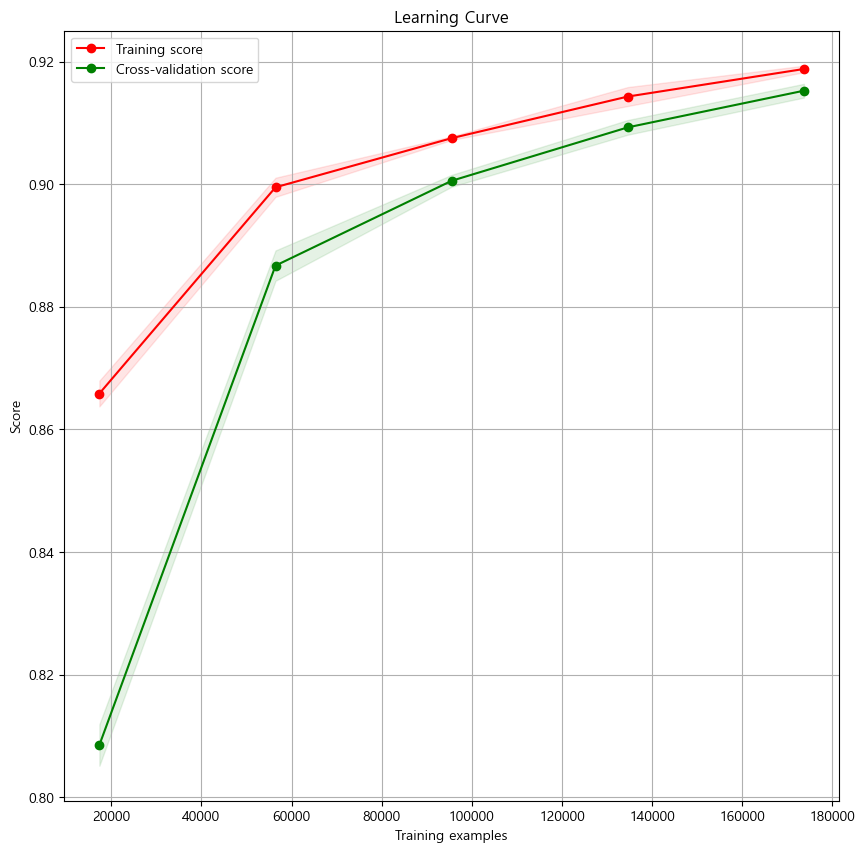

In [52]:
#!pip install scikit_plot
import scikitplot as skplt
skplt.estimators.plot_learning_curve(ctb_clf, X_train, y_train,figsize=(10,10))
plt.show()